In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:

def read_bz2_file(filename):
    """
    :param filename: 要打开的bz2文件名
    """
    file = b2f(filename)
    return file

In [3]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [4]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## abalone 数据集实验

In [5]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('abalone')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[488]	training's rmse: 1.78659	valid_1's rmse: 2.21805


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [7]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 13:37:41 2019
Fold 1 started at Sun Dec 15 13:37:42 2019
Fold 2 started at Sun Dec 15 13:37:42 2019
Fold 3 started at Sun Dec 15 13:37:43 2019
Fold 4 started at Sun Dec 15 13:37:43 2019
Fold 5 started at Sun Dec 15 13:37:43 2019
Fold 6 started at Sun Dec 15 13:37:44 2019
Fold 7 started at Sun Dec 15 13:37:44 2019
Fold 8 started at Sun Dec 15 13:37:45 2019
Fold 9 started at Sun Dec 15 13:37:45 2019
CV mean score: 2.4050, std: 0.1915.


Fold 0 started at Sun Dec 15 13:37:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.57844	valid_1's rmse: 2.16202
Early stopping, best iteration is:
[914]	training's rmse: 1.6016	valid_1's rmse: 2.16001
Fold 1 started at Sun Dec 15 13:37:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 1.82114	valid_1's rmse: 2.21794
Fold 2 started at Sun Dec 15 13:37:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 1.89488	valid_1's rmse: 1.99238
Fold 3 started at Sun Dec 15 13:37:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[310]	training's rmse: 1.8355	valid_1's rmse: 2.08564
Fold 4 started at Sun Dec 15 13:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[761]	training's rmse

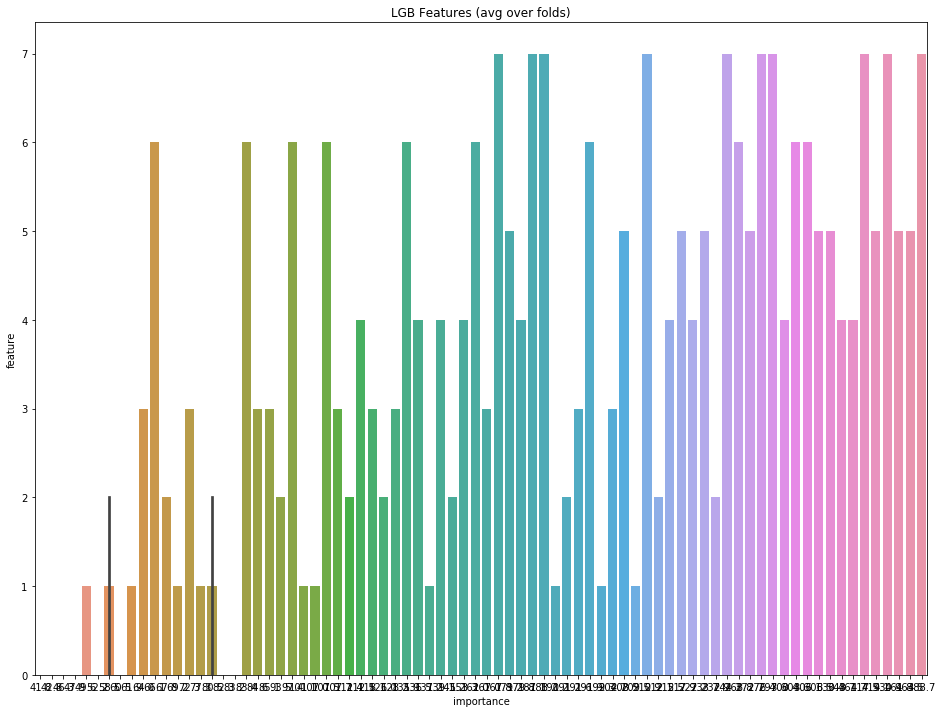

In [8]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:37:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.75254	valid_1's rmse: 2.16821
Early stopping, best iteration is:
[1400]	training's rmse: 1.68497	valid_1's rmse: 2.16602
Fold 1 started at Sun Dec 15 13:37:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.90822	valid_1's rmse: 2.2156
Fold 2 started at Sun Dec 15 13:37:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.98856	valid_1's rmse: 2.00472
Fold 3 started at Sun Dec 15 13:37:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 1.93556	valid_1's rmse: 2.05839
Fold 4 started at Sun Dec 15 13:37:59 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73209	valid_1's rmse: 2.3241

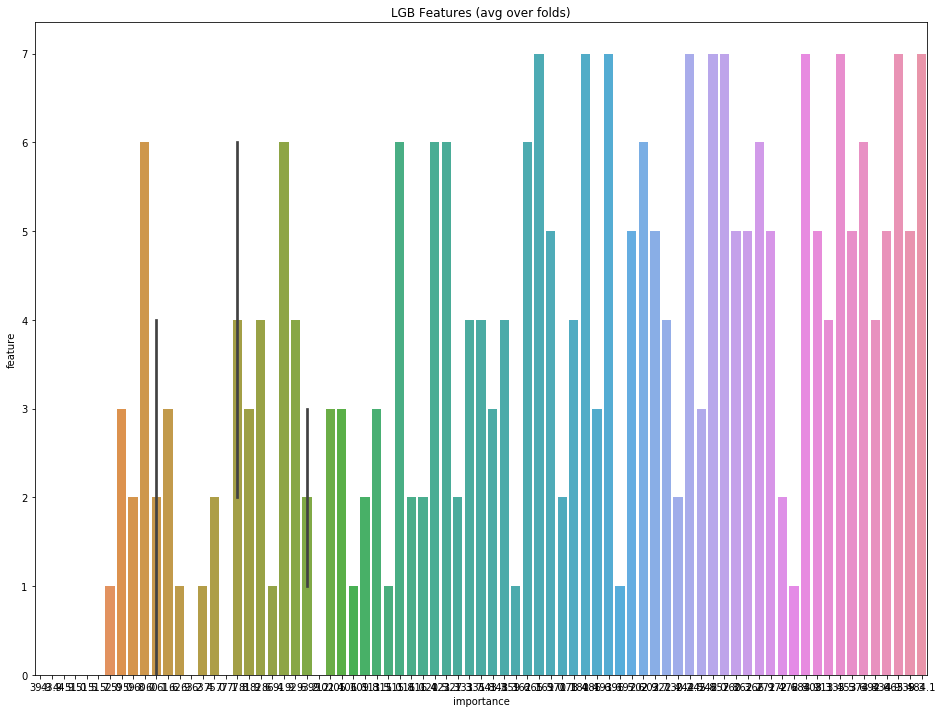

In [9]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:38:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.75254	valid_1's rmse: 2.16821
Early stopping, best iteration is:
[1400]	training's rmse: 1.68497	valid_1's rmse: 2.16602
Fold 1 started at Sun Dec 15 13:38:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.90822	valid_1's rmse: 2.2156
Fold 2 started at Sun Dec 15 13:38:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.98856	valid_1's rmse: 2.00472
Fold 3 started at Sun Dec 15 13:38:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 1.93556	valid_1's rmse: 2.05839
Fold 4 started at Sun Dec 15 13:38:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73209	valid_1's rmse: 2.3241

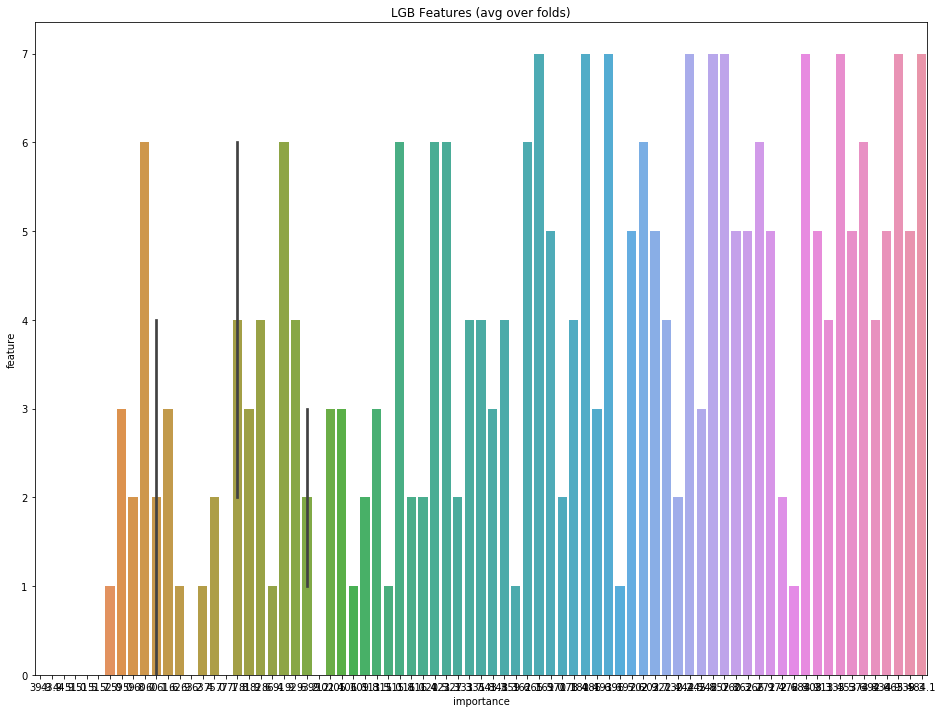

In [10]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [11]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 13:38:13 2019
Fold 1 started at Sun Dec 15 13:38:13 2019
Fold 2 started at Sun Dec 15 13:38:14 2019
Fold 3 started at Sun Dec 15 13:38:14 2019
Fold 4 started at Sun Dec 15 13:38:14 2019
Fold 5 started at Sun Dec 15 13:38:14 2019
Fold 6 started at Sun Dec 15 13:38:15 2019
Fold 7 started at Sun Dec 15 13:38:15 2019
Fold 8 started at Sun Dec 15 13:38:15 2019
Fold 9 started at Sun Dec 15 13:38:15 2019
CV mean score: 2.1657, std: 0.1499.


In [12]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:38:16 2019
[0]	train-rmse:9.87657	valid_data-rmse:9.86869
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.45264	valid_data-rmse:2.18588
Stopping. Best iteration:
[574]	train-rmse:1.40481	valid_data-rmse:2.18364

Fold 1 started at Sun Dec 15 13:38:22 2019
[0]	train-rmse:9.87916	valid_data-rmse:9.84413
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.43432	valid_data-rmse:2.23184
Stopping. Best iteration:
[423]	train-rmse:1.50344	valid_data-rmse:2.22885

Fold 2 started at Sun Dec 15 13:38:27 2019
[0]	train-rmse:9.91161	valid_data-rmse:9.54428
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

In [13]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 13:38:49 2019
Fold 1 started at Sun Dec 15 13:39:10 2019
Fold 2 started at Sun Dec 15 13:39:17 2019
Fold 3 started at Sun Dec 15 13:39:22 2019
Fold 4 started at Sun Dec 15 13:39:28 2019
Fold 5 started at Sun Dec 15 13:39:53 2019
Fold 6 started at Sun Dec 15 13:40:01 2019
Fold 7 started at Sun Dec 15 13:40:25 2019
Fold 8 started at Sun Dec 15 13:40:38 2019
Fold 9 started at Sun Dec 15 13:40:55 2019
CV mean score: 2.1314, std: 0.1429.


## stacking

Fold 0 started at Sun Dec 15 13:41:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.02873	valid_1's rmse: 2.18219
Fold 1 started at Sun Dec 15 13:41:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[442]	training's rmse: 2.01916	valid_1's rmse: 2.20932
Fold 2 started at Sun Dec 15 13:41:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.08333	valid_1's rmse: 1.98632
Fold 3 started at Sun Dec 15 13:41:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 2.06042	valid_1's rmse: 2.09853
Fold 4 started at Sun Dec 15 13:41:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[321]	training's rmse: 2.02755	valid_1's rmse: 2.35153
Fold 5 started at Su

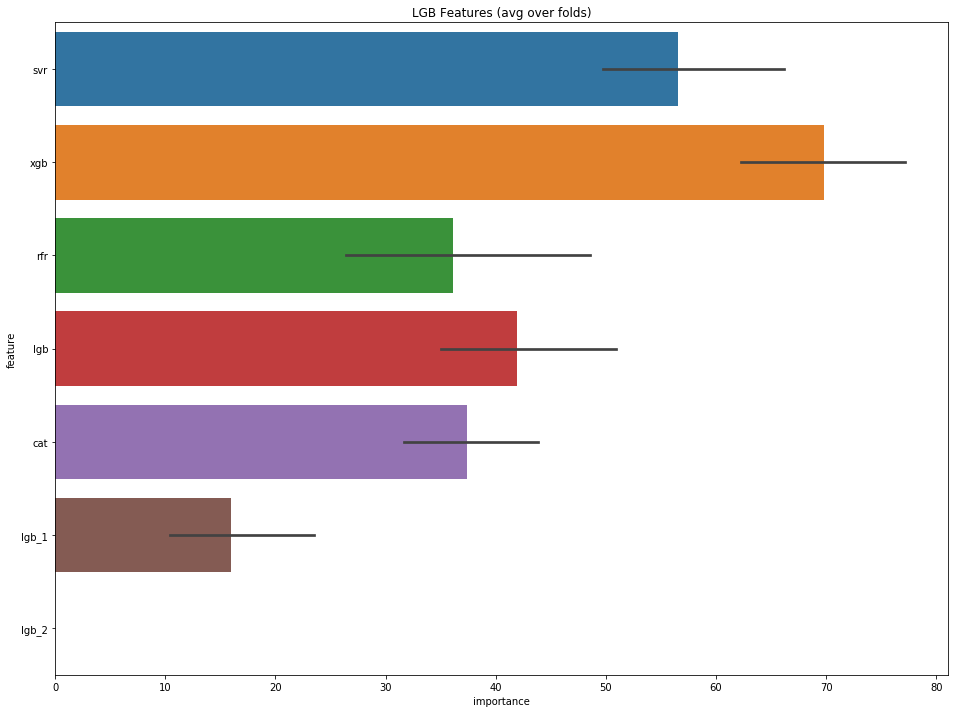

In [14]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:41:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[272]	training's rmse: 1.88073	valid_1's rmse: 2.23998
Fold 1 started at Sun Dec 15 13:41:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[297]	training's rmse: 1.86326	valid_1's rmse: 2.23673
Fold 2 started at Sun Dec 15 13:41:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[231]	training's rmse: 1.93687	valid_1's rmse: 2.01464
Fold 3 started at Sun Dec 15 13:41:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 1.90458	valid_1's rmse: 2.11249
Fold 4 started at Sun Dec 15 13:41:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 1.81622	valid_1's rmse: 2.3921
Fold 5 started at Sun

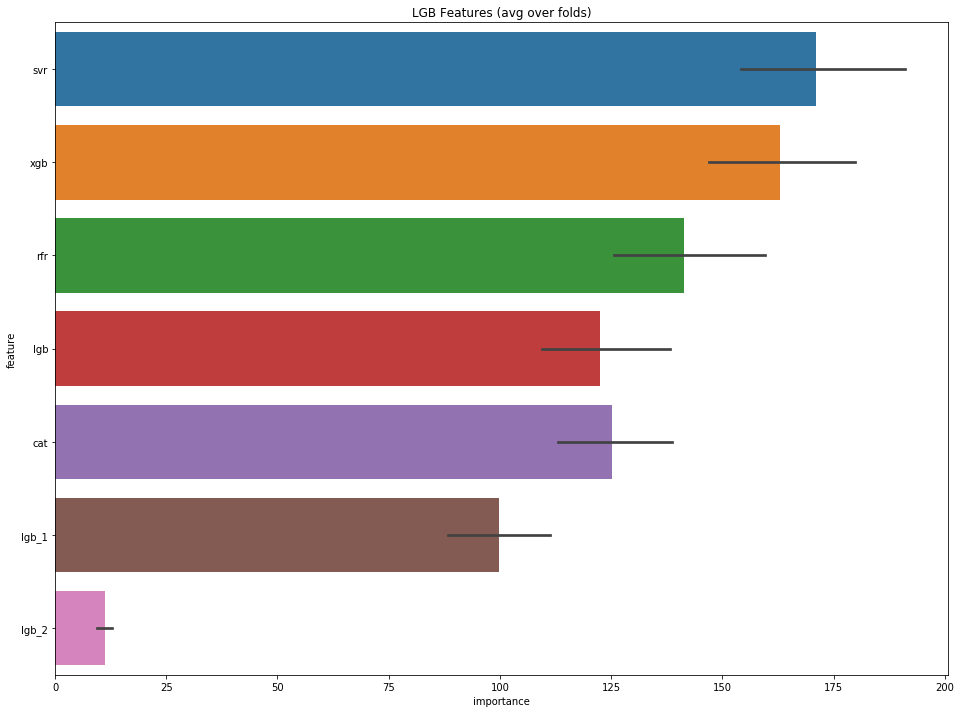

In [15]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [16]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:41:25 2019
Fold 1 started at Sun Dec 15 13:41:28 2019
Fold 2 started at Sun Dec 15 13:41:31 2019
Fold 3 started at Sun Dec 15 13:41:33 2019
Fold 4 started at Sun Dec 15 13:41:35 2019
Fold 5 started at Sun Dec 15 13:41:39 2019
Fold 6 started at Sun Dec 15 13:41:41 2019
Fold 7 started at Sun Dec 15 13:41:47 2019
Fold 8 started at Sun Dec 15 13:41:52 2019
Fold 9 started at Sun Dec 15 13:41:55 2019
CV mean score: 2.1124, std: 0.1436.


random forest做第二层融合模型

In [17]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:41:58 2019
Fold 1 started at Sun Dec 15 13:41:58 2019
Fold 2 started at Sun Dec 15 13:41:58 2019
Fold 3 started at Sun Dec 15 13:41:58 2019
Fold 4 started at Sun Dec 15 13:41:59 2019
Fold 5 started at Sun Dec 15 13:41:59 2019
Fold 6 started at Sun Dec 15 13:41:59 2019
Fold 7 started at Sun Dec 15 13:41:59 2019
Fold 8 started at Sun Dec 15 13:42:00 2019
Fold 9 started at Sun Dec 15 13:42:00 2019
CV mean score: 2.1736, std: 0.1489.


xgboost做第二层融合模型

In [18]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:42:00 2019
[0]	train-rmse:9.87506	valid_data-rmse:9.86664
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.54542	valid_data-rmse:2.23692
Stopping. Best iteration:
[407]	train-rmse:1.62524	valid_data-rmse:2.23102

Fold 1 started at Sun Dec 15 13:42:02 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84365
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.55056	valid_data-rmse:2.22964
Stopping. Best iteration:
[438]	train-rmse:1.59867	valid_data-rmse:2.2278

Fold 2 started at Sun Dec 15 13:42:04 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54352
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [19]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:42:19 2019
Fold 1 started at Sun Dec 15 13:42:19 2019
Fold 2 started at Sun Dec 15 13:42:20 2019
Fold 3 started at Sun Dec 15 13:42:20 2019
Fold 4 started at Sun Dec 15 13:42:20 2019
Fold 5 started at Sun Dec 15 13:42:21 2019
Fold 6 started at Sun Dec 15 13:42:21 2019
Fold 7 started at Sun Dec 15 13:42:22 2019
Fold 8 started at Sun Dec 15 13:42:22 2019
Fold 9 started at Sun Dec 15 13:42:22 2019
CV mean score: 2.1755, std: 0.1741.


用岭回归做第二层融合模型

In [ ]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 13:42:23 2019
Fold 1 started at Sun Dec 15 13:42:23 2019
Fold 2 started at Sun Dec 15 13:42:23 2019
Fold 3 started at Sun Dec 15 13:42:23 2019
Fold 4 started at Sun Dec 15 13:42:23 2019
Fold 5 started at Sun Dec 15 13:42:23 2019
Fold 6 started at Sun Dec 15 13:42:23 2019
Fold 7 started at Sun Dec 15 13:42:23 2019
Fold 8 started at Sun Dec 15 13:42:24 2019
Fold 9 started at Sun Dec 15 13:42:24 2019
CV mean score: 2.1112, std: 0.1401.
Fold 0 started at Sun Dec 15 13:42:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[370]	training's rmse: 2.04796	valid_1's rmse: 2.18454
Fold 1 started at Sun Dec 15 13:42:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 2.03698	valid_1's rmse: 2.21956
Fold 2 started at Sun Dec 15 13:42:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

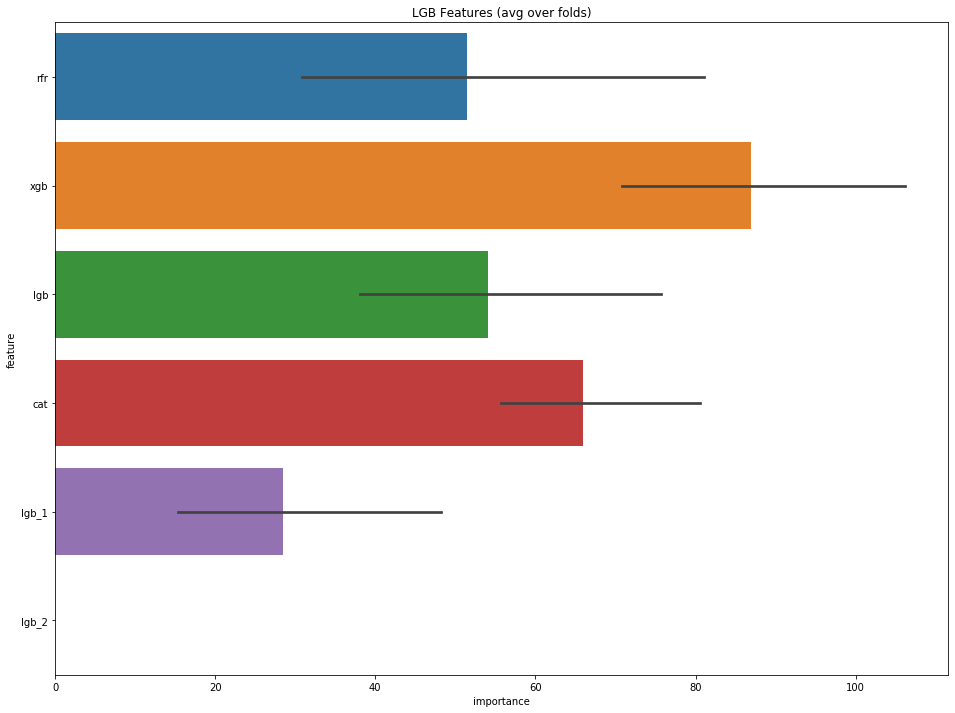

In [20]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:42:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 1.92818	valid_1's rmse: 2.26192
Fold 1 started at Sun Dec 15 13:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 1.92864	valid_1's rmse: 2.23097
Fold 2 started at Sun Dec 15 13:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 1.95755	valid_1's rmse: 1.99724
Fold 3 started at Sun Dec 15 13:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 1.93666	valid_1's rmse: 2.11395
Fold 4 started at Sun Dec 15 13:42:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 1.87975	valid_1's rmse: 2.39628
Fold 5 started at Su

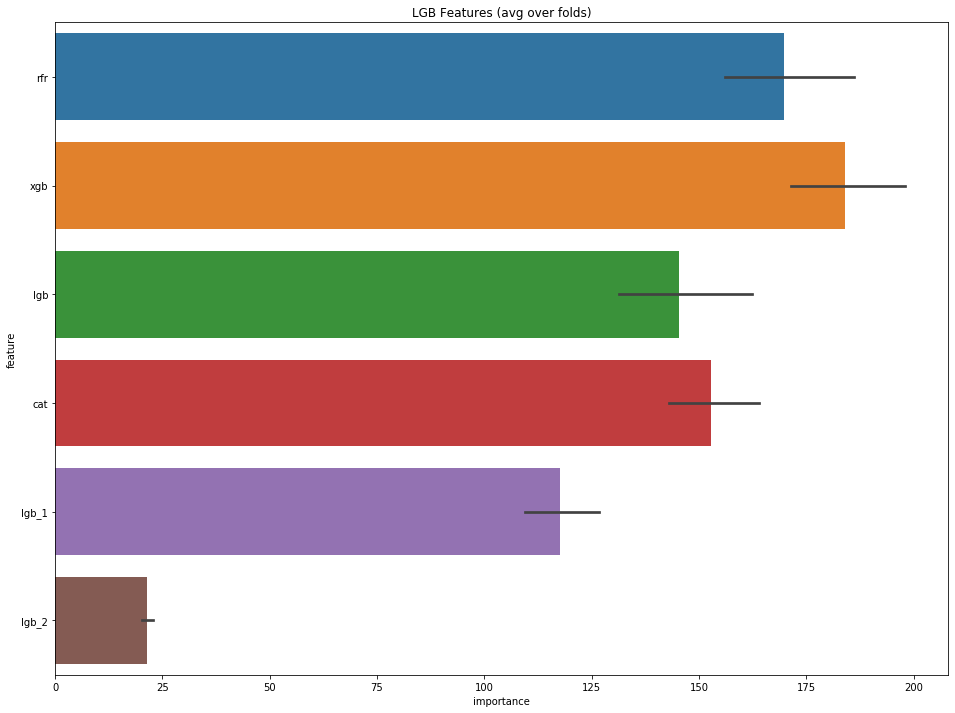

In [21]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [22]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:42:30 2019
Fold 1 started at Sun Dec 15 13:42:33 2019
Fold 2 started at Sun Dec 15 13:42:35 2019
Fold 3 started at Sun Dec 15 13:42:37 2019
Fold 4 started at Sun Dec 15 13:42:40 2019
Fold 5 started at Sun Dec 15 13:42:44 2019
Fold 6 started at Sun Dec 15 13:42:46 2019
Fold 7 started at Sun Dec 15 13:42:50 2019
Fold 8 started at Sun Dec 15 13:42:56 2019
Fold 9 started at Sun Dec 15 13:42:59 2019
CV mean score: 2.1120, std: 0.1450.


random forest做第二层融合模型

In [23]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:43:00 2019
Fold 1 started at Sun Dec 15 13:43:01 2019
Fold 2 started at Sun Dec 15 13:43:01 2019
Fold 3 started at Sun Dec 15 13:43:01 2019
Fold 4 started at Sun Dec 15 13:43:01 2019
Fold 5 started at Sun Dec 15 13:43:02 2019
Fold 6 started at Sun Dec 15 13:43:02 2019
Fold 7 started at Sun Dec 15 13:43:02 2019
Fold 8 started at Sun Dec 15 13:43:02 2019
Fold 9 started at Sun Dec 15 13:43:02 2019
CV mean score: 2.1652, std: 0.1528.


xgboost做第二层融合模型

In [24]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:43:03 2019
[0]	train-rmse:9.87506	valid_data-rmse:9.86664
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60029	valid_data-rmse:2.25553
Stopping. Best iteration:
[424]	train-rmse:1.65681	valid_data-rmse:2.24775

Fold 1 started at Sun Dec 15 13:43:04 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84365
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.60268	valid_data-rmse:2.24637
Stopping. Best iteration:
[436]	train-rmse:1.64828	valid_data-rmse:2.24405

Fold 2 started at Sun Dec 15 13:43:06 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54352
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [25]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:43:20 2019
Fold 1 started at Sun Dec 15 13:43:21 2019
Fold 2 started at Sun Dec 15 13:43:21 2019
Fold 3 started at Sun Dec 15 13:43:21 2019
Fold 4 started at Sun Dec 15 13:43:22 2019
Fold 5 started at Sun Dec 15 13:43:22 2019
Fold 6 started at Sun Dec 15 13:43:23 2019
Fold 7 started at Sun Dec 15 13:43:23 2019
Fold 8 started at Sun Dec 15 13:43:23 2019
Fold 9 started at Sun Dec 15 13:43:24 2019
CV mean score: 2.1641, std: 0.1730.


用岭回归做第二层融合模型

In [26]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:43:24 2019
Fold 1 started at Sun Dec 15 13:43:24 2019
Fold 2 started at Sun Dec 15 13:43:24 2019
Fold 3 started at Sun Dec 15 13:43:24 2019
Fold 4 started at Sun Dec 15 13:43:25 2019
Fold 5 started at Sun Dec 15 13:43:25 2019
Fold 6 started at Sun Dec 15 13:43:25 2019
Fold 7 started at Sun Dec 15 13:43:25 2019
Fold 8 started at Sun Dec 15 13:43:25 2019
Fold 9 started at Sun Dec 15 13:43:25 2019
CV mean score: 2.1117, std: 0.1416.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 13:43:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[420]	training's rmse: 2.03184	valid_1's rmse: 2.18253
Fold 1 started at Sun Dec 15 13:43:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[309]	training's rmse: 2.04736	valid_1's rmse: 2.2116
Fold 2 started at Sun Dec 15 13:43:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 2.08369	valid_1's rmse: 1.9846
Fold 3 started at Sun Dec 15 13:43:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.98453	valid_1's rmse: 2.07959
Early stopping, best iteration is:
[1224]	training's rmse: 1.96796	valid_1's rmse: 2.07515
Fold 4 started at Sun Dec 15 13:43:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rms

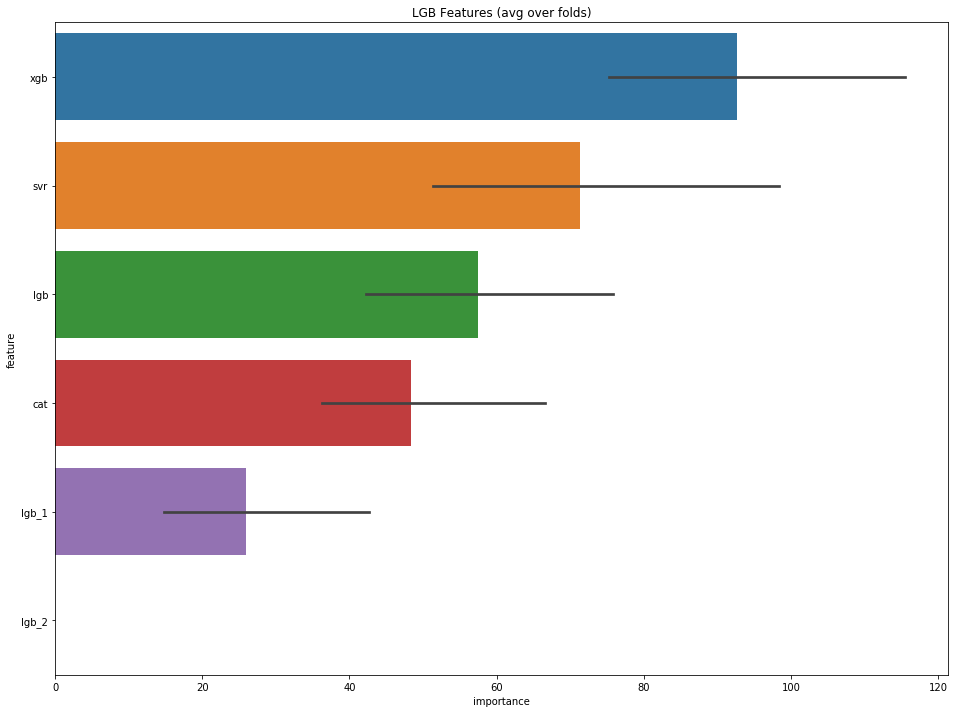

In [27]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:43:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[272]	training's rmse: 1.90044	valid_1's rmse: 2.21843
Fold 1 started at Sun Dec 15 13:43:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 1.89122	valid_1's rmse: 2.2492
Fold 2 started at Sun Dec 15 13:43:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 1.96341	valid_1's rmse: 2.0022
Fold 3 started at Sun Dec 15 13:43:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.91585	valid_1's rmse: 2.10741
Fold 4 started at Sun Dec 15 13:43:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 1.85404	valid_1's rmse: 2.38036
Fold 5 started at Sun 

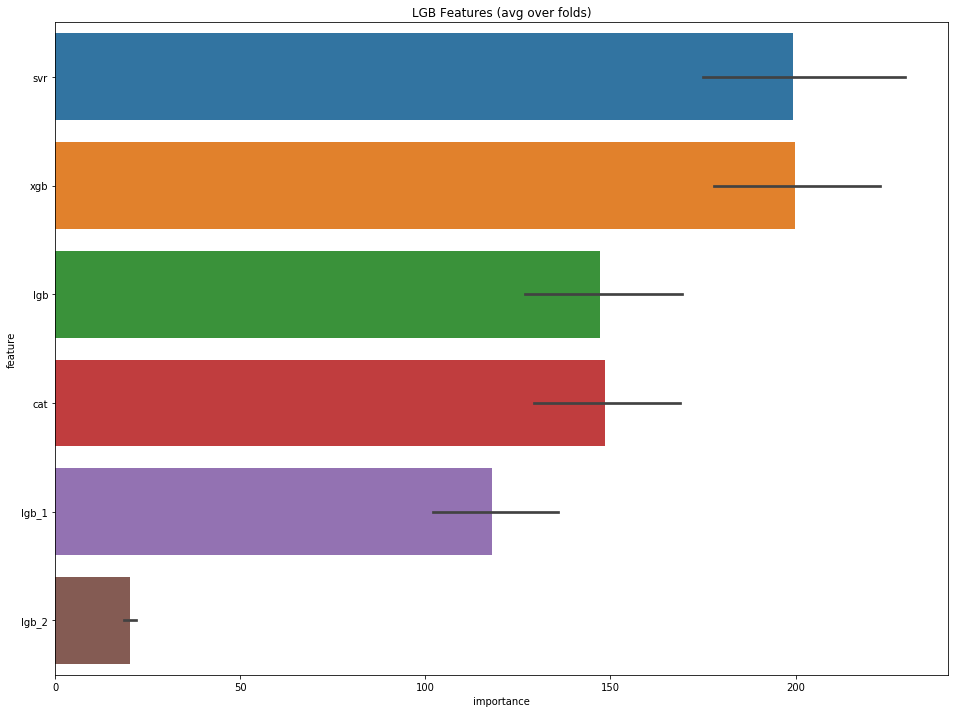

In [28]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [29]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:43:32 2019
Fold 1 started at Sun Dec 15 13:43:35 2019
Fold 2 started at Sun Dec 15 13:43:38 2019
Fold 3 started at Sun Dec 15 13:43:39 2019
Fold 4 started at Sun Dec 15 13:43:42 2019
Fold 5 started at Sun Dec 15 13:43:45 2019
Fold 6 started at Sun Dec 15 13:43:47 2019
Fold 7 started at Sun Dec 15 13:43:52 2019
Fold 8 started at Sun Dec 15 13:43:57 2019
Fold 9 started at Sun Dec 15 13:43:59 2019
CV mean score: 2.1105, std: 0.1409.


random forest做第二层融合模型

In [30]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:44:01 2019
Fold 1 started at Sun Dec 15 13:44:01 2019
Fold 2 started at Sun Dec 15 13:44:01 2019
Fold 3 started at Sun Dec 15 13:44:01 2019
Fold 4 started at Sun Dec 15 13:44:02 2019
Fold 5 started at Sun Dec 15 13:44:02 2019
Fold 6 started at Sun Dec 15 13:44:02 2019
Fold 7 started at Sun Dec 15 13:44:02 2019
Fold 8 started at Sun Dec 15 13:44:03 2019
Fold 9 started at Sun Dec 15 13:44:03 2019
CV mean score: 2.1518, std: 0.1298.


xgboost做第二层融合模型

In [31]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:44:03 2019
[0]	train-rmse:9.87509	valid_data-rmse:9.86667
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58294	valid_data-rmse:2.24146
Stopping. Best iteration:
[442]	train-rmse:1.63014	valid_data-rmse:2.23905

Fold 1 started at Sun Dec 15 13:44:05 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84363
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58701	valid_data-rmse:2.2242
Stopping. Best iteration:
[481]	train-rmse:1.6001	valid_data-rmse:2.22258

Fold 2 started at Sun Dec 15 13:44:07 2019
[0]	train-rmse:9.9102	valid_data-rmse:9.54353
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

#### SVR作为meta

In [32]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:44:20 2019
Fold 1 started at Sun Dec 15 13:44:21 2019
Fold 2 started at Sun Dec 15 13:44:21 2019
Fold 3 started at Sun Dec 15 13:44:22 2019
Fold 4 started at Sun Dec 15 13:44:22 2019
Fold 5 started at Sun Dec 15 13:44:22 2019
Fold 6 started at Sun Dec 15 13:44:23 2019
Fold 7 started at Sun Dec 15 13:44:23 2019
Fold 8 started at Sun Dec 15 13:44:23 2019
Fold 9 started at Sun Dec 15 13:44:24 2019
CV mean score: 2.1716, std: 0.1730.


用岭回归做第二层融合模型

In [33]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:44:24 2019
Fold 1 started at Sun Dec 15 13:44:24 2019
Fold 2 started at Sun Dec 15 13:44:24 2019
Fold 3 started at Sun Dec 15 13:44:24 2019
Fold 4 started at Sun Dec 15 13:44:25 2019
Fold 5 started at Sun Dec 15 13:44:25 2019
Fold 6 started at Sun Dec 15 13:44:25 2019
Fold 7 started at Sun Dec 15 13:44:25 2019
Fold 8 started at Sun Dec 15 13:44:25 2019
Fold 9 started at Sun Dec 15 13:44:25 2019
CV mean score: 2.1103, std: 0.1399.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 13:44:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.03918	valid_1's rmse: 2.18276
Fold 1 started at Sun Dec 15 13:44:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[448]	training's rmse: 2.02349	valid_1's rmse: 2.20957
Fold 2 started at Sun Dec 15 13:44:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.08413	valid_1's rmse: 1.97719
Fold 3 started at Sun Dec 15 13:44:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.9896	valid_1's rmse: 2.09464
Early stopping, best iteration is:
[839]	training's rmse: 2.00408	valid_1's rmse: 2.09111
Fold 4 started at Sun Dec 15 13:44:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rms

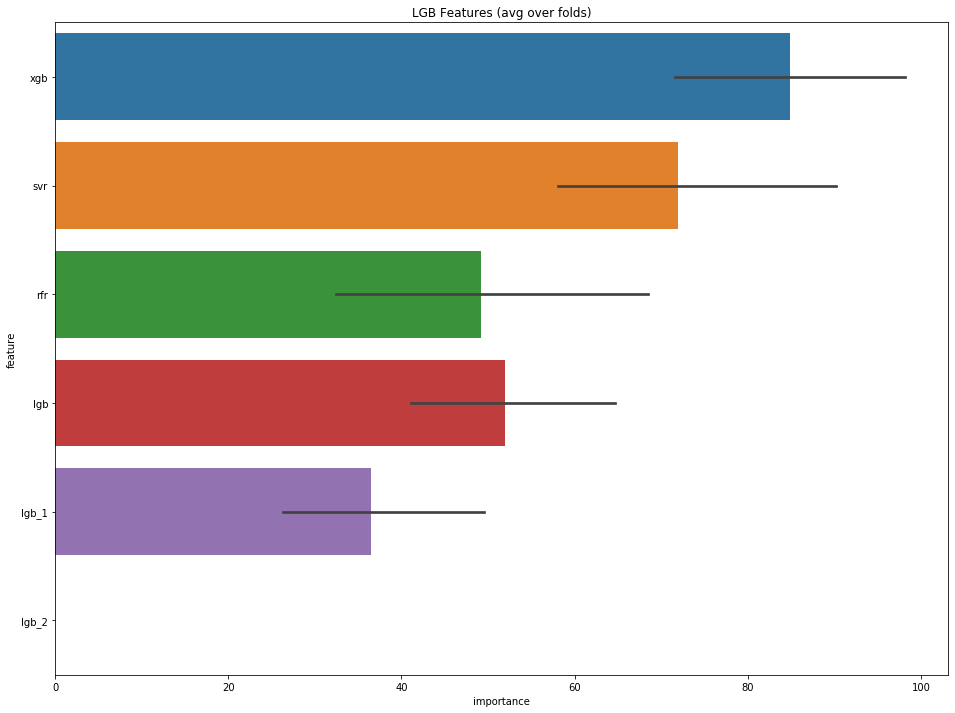

In [34]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:44:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 1.91101	valid_1's rmse: 2.24428
Fold 1 started at Sun Dec 15 13:44:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 1.87093	valid_1's rmse: 2.22106
Fold 2 started at Sun Dec 15 13:44:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 1.95936	valid_1's rmse: 2.01523
Fold 3 started at Sun Dec 15 13:44:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 1.88513	valid_1's rmse: 2.12725
Fold 4 started at Sun Dec 15 13:44:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 1.85715	valid_1's rmse: 2.38599
Fold 5 started at Su

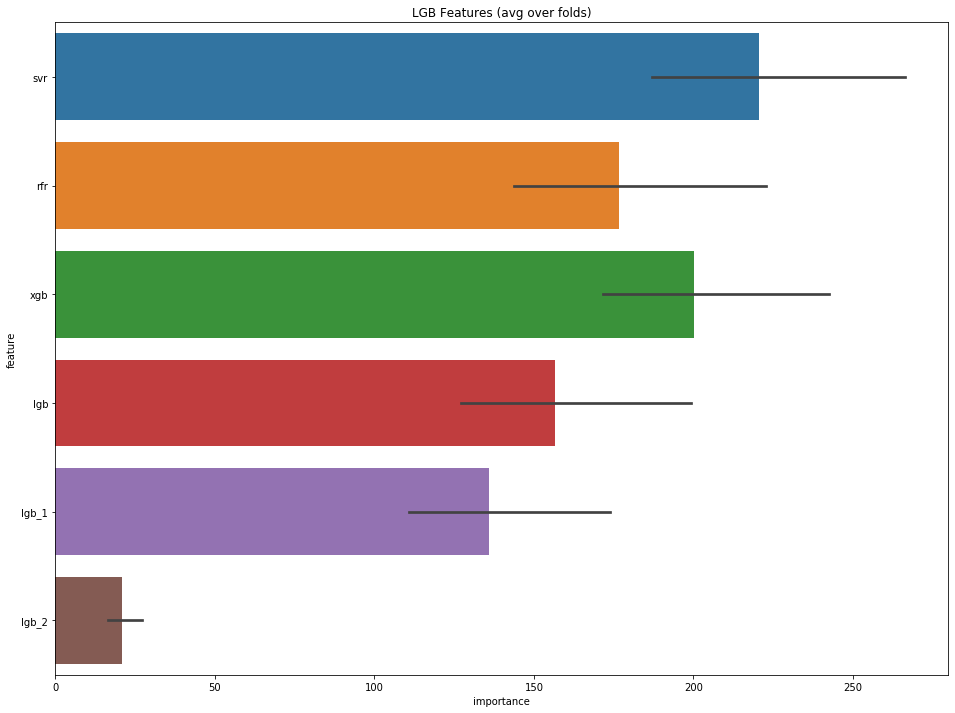

In [35]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [36]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:44:32 2019
Fold 1 started at Sun Dec 15 13:44:34 2019
Fold 2 started at Sun Dec 15 13:44:37 2019
Fold 3 started at Sun Dec 15 13:44:39 2019
Fold 4 started at Sun Dec 15 13:44:41 2019
Fold 5 started at Sun Dec 15 13:44:44 2019
Fold 6 started at Sun Dec 15 13:44:46 2019
Fold 7 started at Sun Dec 15 13:44:58 2019
Fold 8 started at Sun Dec 15 13:45:03 2019
Fold 9 started at Sun Dec 15 13:45:06 2019
CV mean score: 2.1094, std: 0.1416.


random forest做第二层融合模型

In [37]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:45:08 2019
Fold 1 started at Sun Dec 15 13:45:08 2019
Fold 2 started at Sun Dec 15 13:45:08 2019
Fold 3 started at Sun Dec 15 13:45:09 2019
Fold 4 started at Sun Dec 15 13:45:09 2019
Fold 5 started at Sun Dec 15 13:45:09 2019
Fold 6 started at Sun Dec 15 13:45:09 2019
Fold 7 started at Sun Dec 15 13:45:10 2019
Fold 8 started at Sun Dec 15 13:45:10 2019
Fold 9 started at Sun Dec 15 13:45:10 2019
CV mean score: 2.1568, std: 0.1496.


xgboost做第二层融合模型

In [38]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:45:10 2019
[0]	train-rmse:9.87509	valid_data-rmse:9.86663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.56776	valid_data-rmse:2.2602
Stopping. Best iteration:
[398]	train-rmse:1.65643	valid_data-rmse:2.25478

Fold 1 started at Sun Dec 15 13:45:12 2019
[0]	train-rmse:9.87785	valid_data-rmse:9.84363
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58688	valid_data-rmse:2.23135
Stopping. Best iteration:
[477]	train-rmse:1.60336	valid_data-rmse:2.2306

Fold 2 started at Sun Dec 15 13:45:14 2019
[0]	train-rmse:9.91018	valid_data-rmse:9.54368
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [39]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:45:27 2019
Fold 1 started at Sun Dec 15 13:45:28 2019
Fold 2 started at Sun Dec 15 13:45:28 2019
Fold 3 started at Sun Dec 15 13:45:28 2019
Fold 4 started at Sun Dec 15 13:45:29 2019
Fold 5 started at Sun Dec 15 13:45:29 2019
Fold 6 started at Sun Dec 15 13:45:30 2019
Fold 7 started at Sun Dec 15 13:45:30 2019
Fold 8 started at Sun Dec 15 13:45:30 2019
Fold 9 started at Sun Dec 15 13:45:31 2019
CV mean score: 2.1768, std: 0.1760.


用岭回归做第二层融合模型

In [40]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 13:45:31 2019
Fold 1 started at Sun Dec 15 13:45:31 2019
Fold 2 started at Sun Dec 15 13:45:31 2019
Fold 3 started at Sun Dec 15 13:45:31 2019
Fold 4 started at Sun Dec 15 13:45:32 2019
Fold 5 started at Sun Dec 15 13:45:32 2019
Fold 6 started at Sun Dec 15 13:45:32 2019
Fold 7 started at Sun Dec 15 13:45:32 2019
Fold 8 started at Sun Dec 15 13:45:32 2019
Fold 9 started at Sun Dec 15 13:45:32 2019
CV mean score: 2.1114, std: 0.1411.


### 去掉xgboost

Fold 0 started at Sun Dec 15 13:45:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.05438	valid_1's rmse: 2.17287
Fold 1 started at Sun Dec 15 13:45:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[459]	training's rmse: 2.03127	valid_1's rmse: 2.20359
Fold 2 started at Sun Dec 15 13:45:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 2.08779	valid_1's rmse: 2.00764
Fold 3 started at Sun Dec 15 13:45:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 2.07574	valid_1's rmse: 2.11313
Fold 4 started at Sun Dec 15 13:45:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 2.02975	valid_1's rmse: 2.34502
Fold 5 started at Su

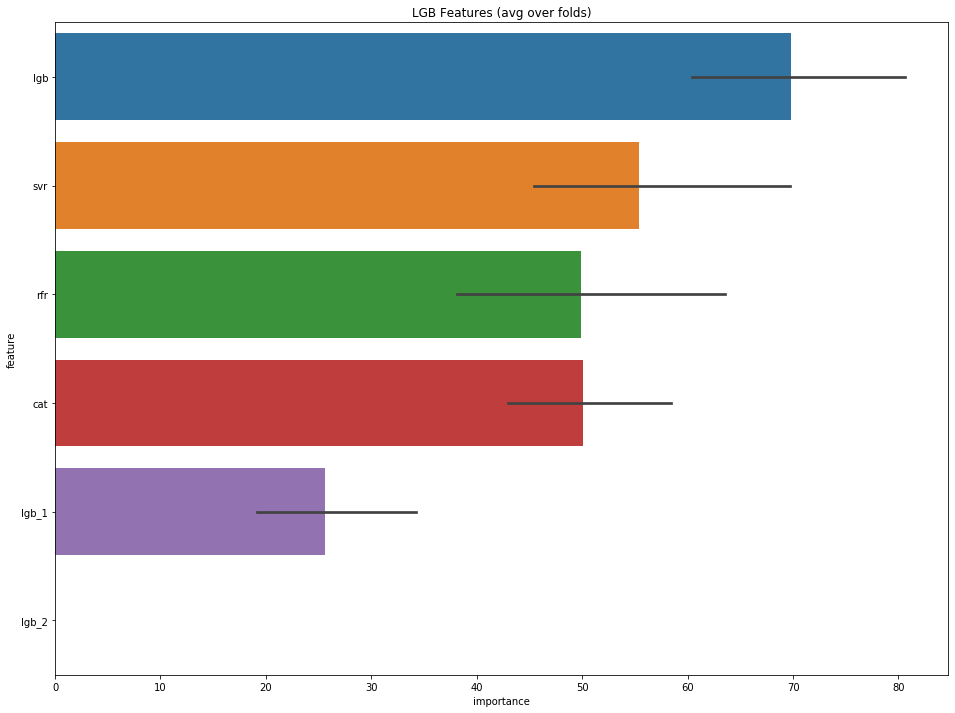

In [41]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:45:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 1.89638	valid_1's rmse: 2.22536
Fold 1 started at Sun Dec 15 13:45:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 1.8706	valid_1's rmse: 2.22813
Fold 2 started at Sun Dec 15 13:45:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[219]	training's rmse: 1.96694	valid_1's rmse: 2.04236
Fold 3 started at Sun Dec 15 13:45:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 1.90241	valid_1's rmse: 2.10937
Fold 4 started at Sun Dec 15 13:45:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 1.84835	valid_1's rmse: 2.37863
Fold 5 started at Sun

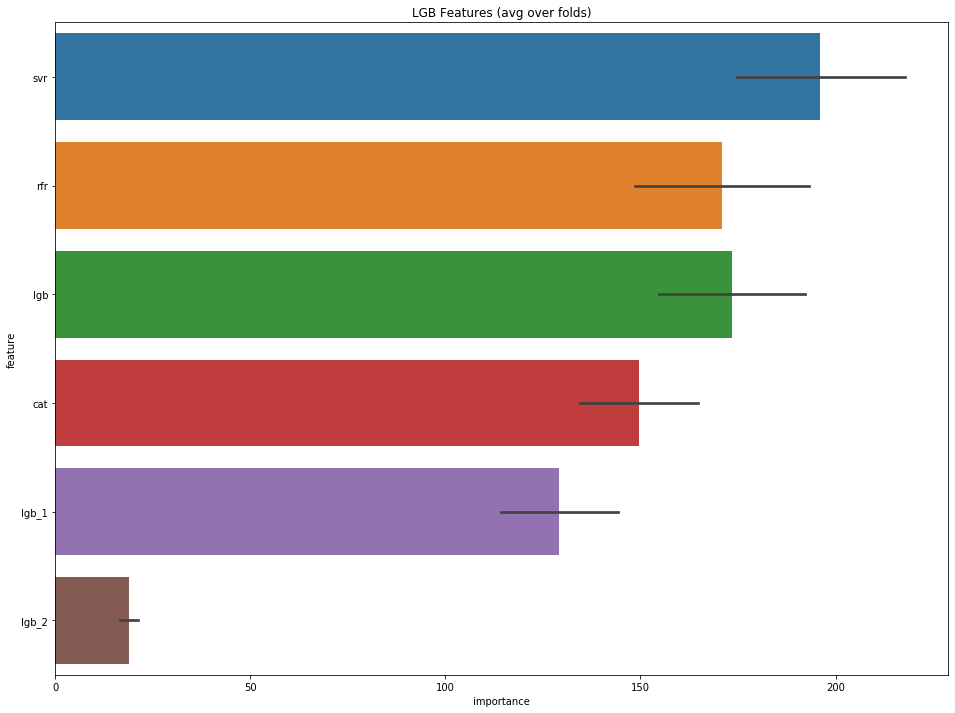

In [42]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [43]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:45:39 2019
Fold 1 started at Sun Dec 15 13:45:41 2019
Fold 2 started at Sun Dec 15 13:45:44 2019
Fold 3 started at Sun Dec 15 13:45:46 2019
Fold 4 started at Sun Dec 15 13:45:49 2019
Fold 5 started at Sun Dec 15 13:45:52 2019
Fold 6 started at Sun Dec 15 13:45:55 2019
Fold 7 started at Sun Dec 15 13:45:59 2019
Fold 8 started at Sun Dec 15 13:46:02 2019
Fold 9 started at Sun Dec 15 13:46:05 2019
CV mean score: 2.1173, std: 0.1418.


random forest做第二层融合模型

In [44]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:46:06 2019
Fold 1 started at Sun Dec 15 13:46:07 2019
Fold 2 started at Sun Dec 15 13:46:07 2019
Fold 3 started at Sun Dec 15 13:46:07 2019
Fold 4 started at Sun Dec 15 13:46:07 2019
Fold 5 started at Sun Dec 15 13:46:08 2019
Fold 6 started at Sun Dec 15 13:46:08 2019
Fold 7 started at Sun Dec 15 13:46:08 2019
Fold 8 started at Sun Dec 15 13:46:08 2019
Fold 9 started at Sun Dec 15 13:46:09 2019
CV mean score: 2.1461, std: 0.1420.


xgboost做第二层融合模型

In [45]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:46:09 2019
[0]	train-rmse:9.87518	valid_data-rmse:9.86749
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.58056	valid_data-rmse:2.22096
Stopping. Best iteration:
[478]	train-rmse:1.59607	valid_data-rmse:2.22011

Fold 1 started at Sun Dec 15 13:46:11 2019
[0]	train-rmse:9.87784	valid_data-rmse:9.84288
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.59096	valid_data-rmse:2.22195
Stopping. Best iteration:
[499]	train-rmse:1.59205	valid_data-rmse:2.22171

Fold 2 started at Sun Dec 15 13:46:13 2019
[0]	train-rmse:9.91028	valid_data-rmse:9.54242
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

#### SVR作为meta

In [46]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:46:26 2019
Fold 1 started at Sun Dec 15 13:46:26 2019
Fold 2 started at Sun Dec 15 13:46:27 2019
Fold 3 started at Sun Dec 15 13:46:27 2019
Fold 4 started at Sun Dec 15 13:46:28 2019
Fold 5 started at Sun Dec 15 13:46:28 2019
Fold 6 started at Sun Dec 15 13:46:28 2019
Fold 7 started at Sun Dec 15 13:46:29 2019
Fold 8 started at Sun Dec 15 13:46:29 2019
Fold 9 started at Sun Dec 15 13:46:30 2019
CV mean score: 2.1795, std: 0.1729.


用岭回归做第二层融合模型

In [47]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:46:30 2019
Fold 1 started at Sun Dec 15 13:46:30 2019
Fold 2 started at Sun Dec 15 13:46:30 2019
Fold 3 started at Sun Dec 15 13:46:30 2019
Fold 4 started at Sun Dec 15 13:46:30 2019
Fold 5 started at Sun Dec 15 13:46:30 2019
Fold 6 started at Sun Dec 15 13:46:30 2019
Fold 7 started at Sun Dec 15 13:46:31 2019
Fold 8 started at Sun Dec 15 13:46:31 2019
Fold 9 started at Sun Dec 15 13:46:31 2019
CV mean score: 2.1153, std: 0.1391.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 13:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.05022	valid_1's rmse: 2.18755
Fold 1 started at Sun Dec 15 13:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[659]	training's rmse: 2.00891	valid_1's rmse: 2.18772
Fold 2 started at Sun Dec 15 13:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 2.09021	valid_1's rmse: 1.99026
Fold 3 started at Sun Dec 15 13:46:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[289]	training's rmse: 2.06868	valid_1's rmse: 2.08739
Fold 4 started at Sun Dec 15 13:46:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 2.03064	valid_1's rmse: 2.35713
Fold 5 started at Su

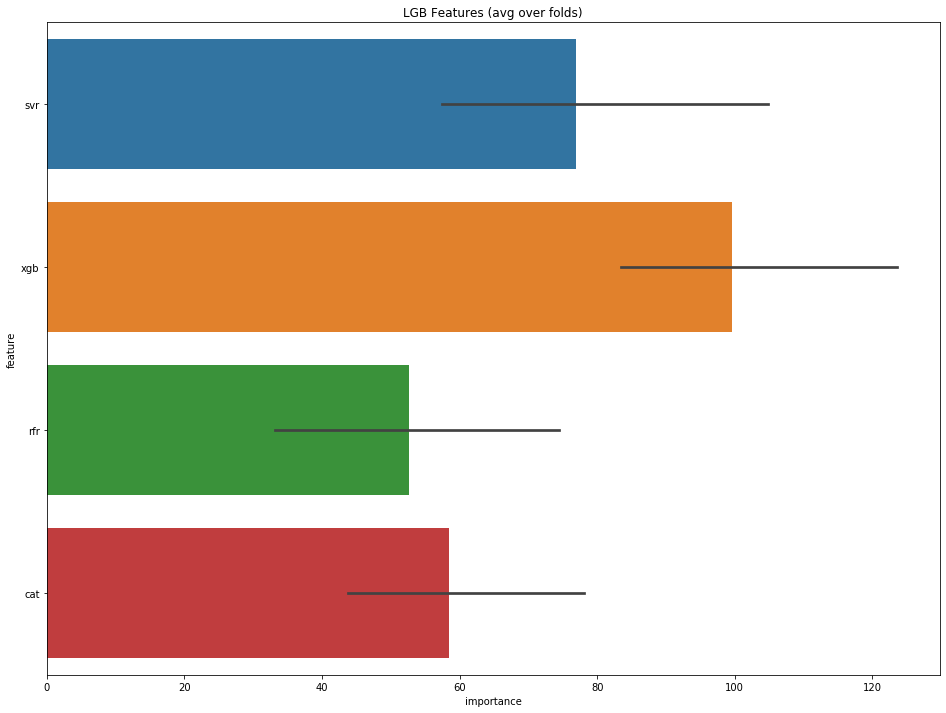

In [48]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:46:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 1.89412	valid_1's rmse: 2.21174
Fold 1 started at Sun Dec 15 13:46:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 1.90246	valid_1's rmse: 2.21074
Fold 2 started at Sun Dec 15 13:46:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[214]	training's rmse: 1.97932	valid_1's rmse: 2.01459
Fold 3 started at Sun Dec 15 13:46:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 1.93198	valid_1's rmse: 2.0925
Fold 4 started at Sun Dec 15 13:46:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[304]	training's rmse: 1.87942	valid_1's rmse: 2.39537
Fold 5 started at Sun

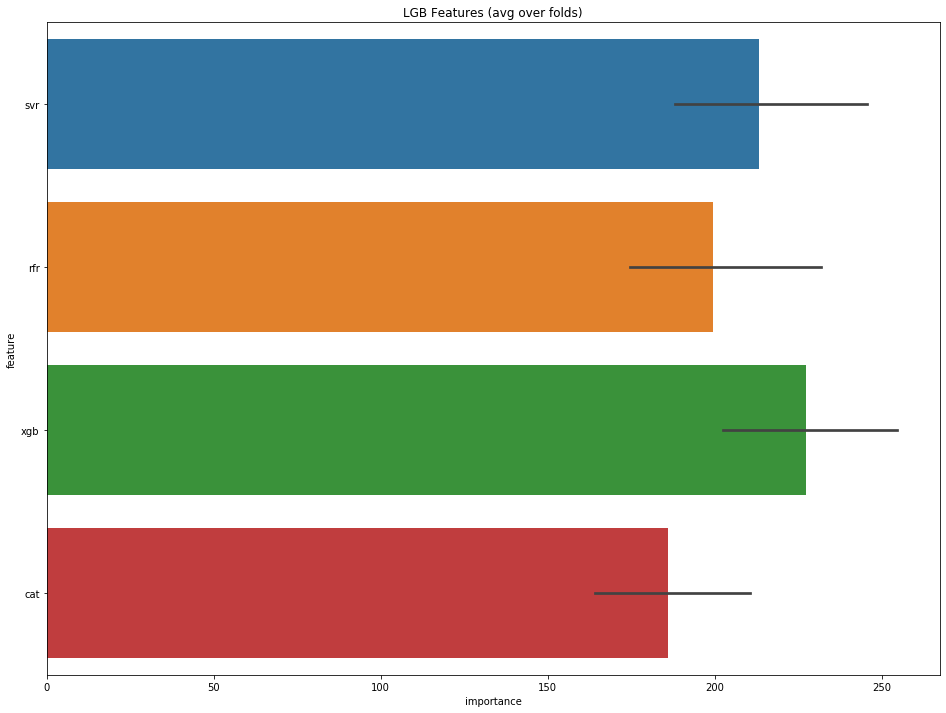

In [49]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [50]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:46:37 2019
Fold 1 started at Sun Dec 15 13:46:40 2019
Fold 2 started at Sun Dec 15 13:46:42 2019
Fold 3 started at Sun Dec 15 13:46:44 2019
Fold 4 started at Sun Dec 15 13:46:46 2019
Fold 5 started at Sun Dec 15 13:46:49 2019
Fold 6 started at Sun Dec 15 13:46:51 2019
Fold 7 started at Sun Dec 15 13:46:55 2019
Fold 8 started at Sun Dec 15 13:46:58 2019
Fold 9 started at Sun Dec 15 13:47:01 2019
CV mean score: 2.1155, std: 0.1484.


random forest做第二层融合模型

In [51]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:47:04 2019
Fold 1 started at Sun Dec 15 13:47:04 2019
Fold 2 started at Sun Dec 15 13:47:05 2019
Fold 3 started at Sun Dec 15 13:47:05 2019
Fold 4 started at Sun Dec 15 13:47:05 2019
Fold 5 started at Sun Dec 15 13:47:05 2019
Fold 6 started at Sun Dec 15 13:47:06 2019
Fold 7 started at Sun Dec 15 13:47:06 2019
Fold 8 started at Sun Dec 15 13:47:06 2019
Fold 9 started at Sun Dec 15 13:47:06 2019
CV mean score: 2.1535, std: 0.1518.


xgboost做第二层融合模型

In [52]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:47:07 2019
[0]	train-rmse:9.87517	valid_data-rmse:9.86726
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61026	valid_data-rmse:2.22267
Stopping. Best iteration:
[406]	train-rmse:1.68306	valid_data-rmse:2.21943

Fold 1 started at Sun Dec 15 13:47:08 2019
[0]	train-rmse:9.878	valid_data-rmse:9.84377
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.61105	valid_data-rmse:2.23021
Stopping. Best iteration:
[465]	train-rmse:1.63531	valid_data-rmse:2.22883

Fold 2 started at Sun Dec 15 13:47:09 2019
[0]	train-rmse:9.91034	valid_data-rmse:9.54294
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [53]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:47:21 2019
Fold 1 started at Sun Dec 15 13:47:21 2019
Fold 2 started at Sun Dec 15 13:47:21 2019
Fold 3 started at Sun Dec 15 13:47:22 2019
Fold 4 started at Sun Dec 15 13:47:22 2019
Fold 5 started at Sun Dec 15 13:47:22 2019
Fold 6 started at Sun Dec 15 13:47:23 2019
Fold 7 started at Sun Dec 15 13:47:23 2019
Fold 8 started at Sun Dec 15 13:47:23 2019
Fold 9 started at Sun Dec 15 13:47:24 2019
CV mean score: 2.1767, std: 0.1746.


用岭回归做第二层融合模型

In [54]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:47:24 2019
Fold 1 started at Sun Dec 15 13:47:24 2019
Fold 2 started at Sun Dec 15 13:47:24 2019
Fold 3 started at Sun Dec 15 13:47:24 2019
Fold 4 started at Sun Dec 15 13:47:25 2019
Fold 5 started at Sun Dec 15 13:47:25 2019
Fold 6 started at Sun Dec 15 13:47:25 2019
Fold 7 started at Sun Dec 15 13:47:25 2019
Fold 8 started at Sun Dec 15 13:47:25 2019
Fold 9 started at Sun Dec 15 13:47:25 2019
CV mean score: 2.1125, std: 0.1419.


## bodyfat 数据集实验

In [55]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('bodyfat')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[673]	training's rmse: 0.0061499	valid_1's rmse: 0.00361937


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [57]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 13:47:25 2019
Fold 1 started at Sun Dec 15 13:47:25 2019
Fold 2 started at Sun Dec 15 13:47:25 2019
Fold 3 started at Sun Dec 15 13:47:25 2019
Fold 4 started at Sun Dec 15 13:47:25 2019
Fold 5 started at Sun Dec 15 13:47:25 2019
Fold 6 started at Sun Dec 15 13:47:25 2019
Fold 7 started at Sun Dec 15 13:47:25 2019
Fold 8 started at Sun Dec 15 13:47:25 2019
Fold 9 started at Sun Dec 15 13:47:25 2019
CV mean score: 0.0197, std: 0.0037.


Fold 0 started at Sun Dec 15 13:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Sun Dec 15 13:47:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Sun Dec 15 13:47:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Sun Dec 15 13:47:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Sun Dec 15 13:47:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

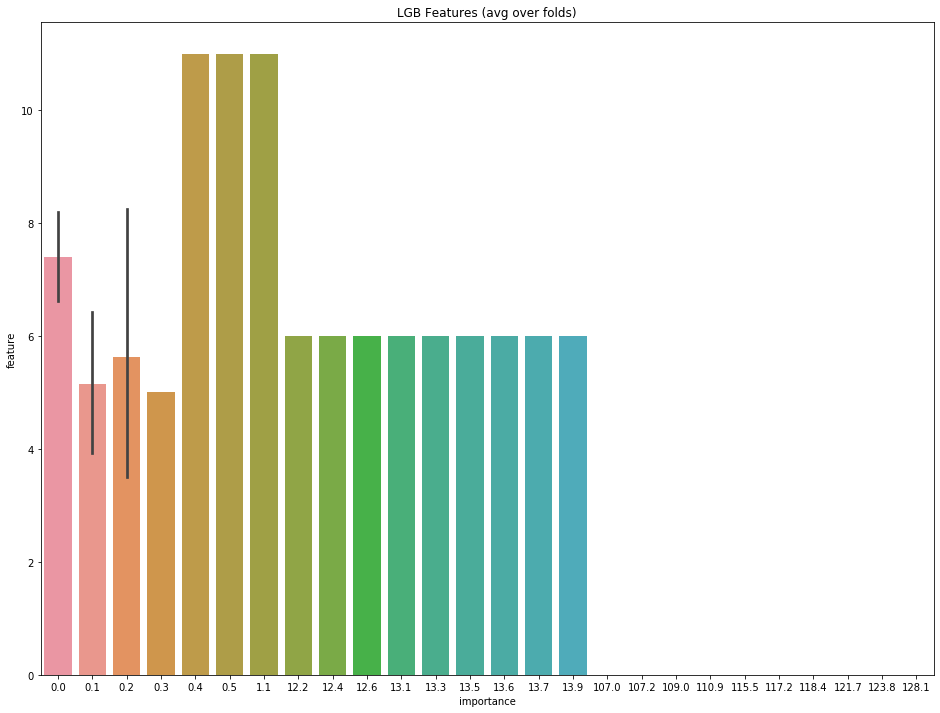

In [58]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Sun Dec 15 13:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Sun Dec 15 13:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Sun Dec 15 13:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Sun Dec 15 13:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

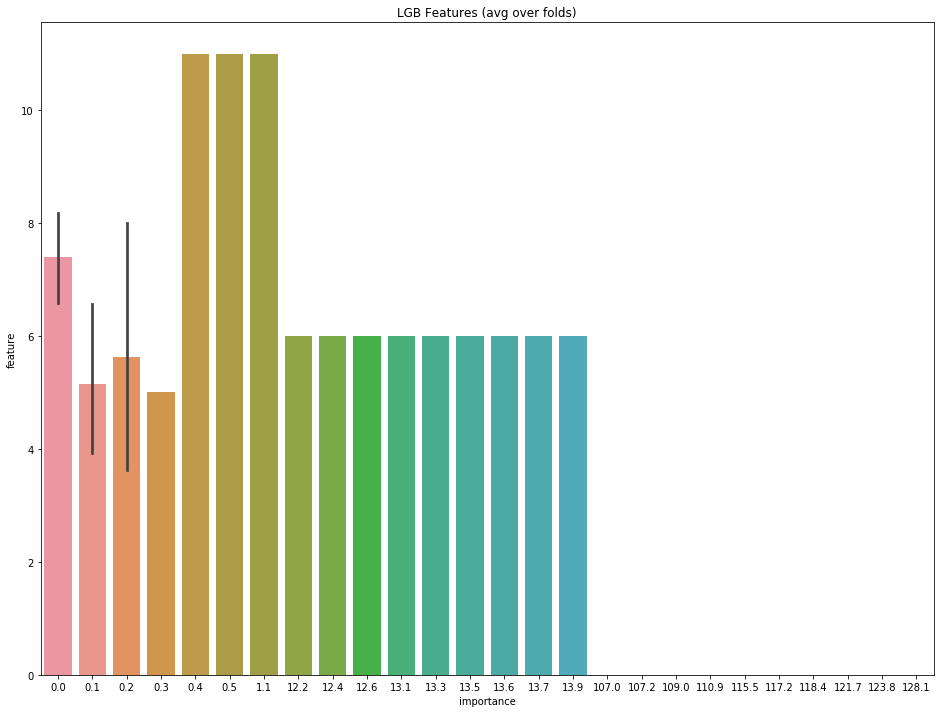

In [59]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:47:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00617057	valid_1's rmse: 0.00269838
Fold 1 started at Sun Dec 15 13:47:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[699]	training's rmse: 0.00606342	valid_1's rmse: 0.00398774
Fold 2 started at Sun Dec 15 13:47:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[666]	training's rmse: 0.00604245	valid_1's rmse: 0.00434099
Fold 3 started at Sun Dec 15 13:47:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.00566677	valid_1's rmse: 0.010692
Fold 4 started at Sun Dec 15 13:47:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[632]	training's rmse: 0.00532563	valid_1's rmse: 0.0

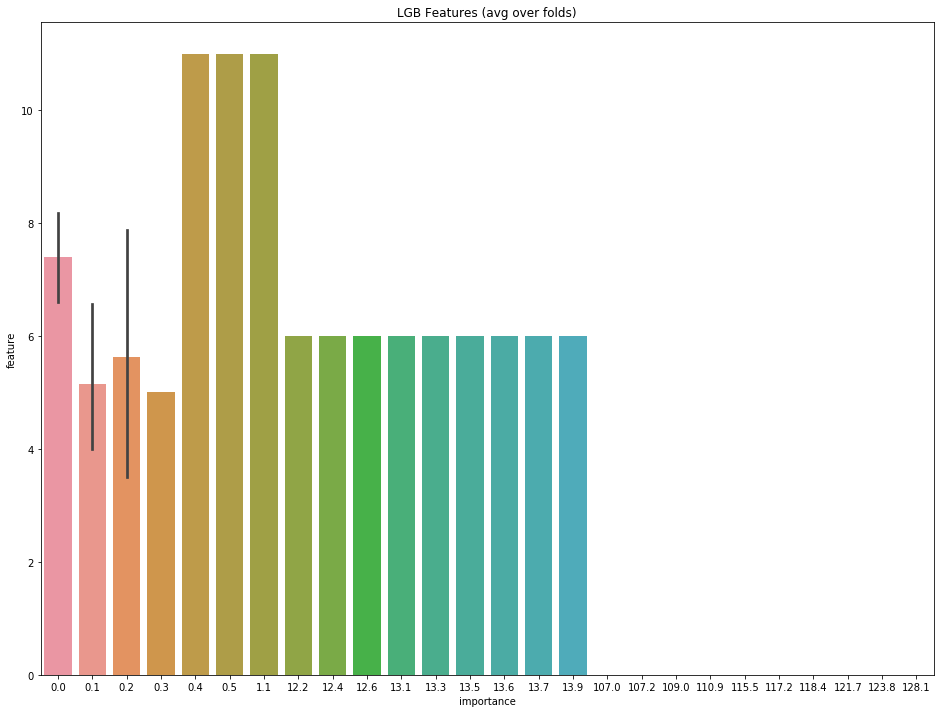

In [60]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [61]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 13:47:33 2019
Fold 1 started at Sun Dec 15 13:47:33 2019
Fold 2 started at Sun Dec 15 13:47:33 2019
Fold 3 started at Sun Dec 15 13:47:33 2019
Fold 4 started at Sun Dec 15 13:47:34 2019
Fold 5 started at Sun Dec 15 13:47:34 2019
Fold 6 started at Sun Dec 15 13:47:34 2019
Fold 7 started at Sun Dec 15 13:47:34 2019
Fold 8 started at Sun Dec 15 13:47:34 2019
Fold 9 started at Sun Dec 15 13:47:35 2019
CV mean score: 0.0059, std: 0.0026.


In [62]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:47:35 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004891	valid_data-rmse:0.004493
[1000]	train-rmse:0.000563	valid_data-rmse:0.000679
[1500]	train-rmse:0.000429	valid_data-rmse:0.000646
[2000]	train-rmse:0.000418	valid_data-rmse:0.00064
Stopping. Best iteration:
[2189]	train-rmse:0.000414	valid_data-rmse:0.000638

Fold 1 started at Sun Dec 15 13:47:36 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004881	valid_data-rmse:0.004498
[1000]	train-rmse:0.000552	valid_data-rmse:0.001287
[1500]	train-rmse:0.000413	valid_data-rmse:0.001249
Stopping. Best iteration:
[1572]	train-rmse:0.000412	valid_data-r

In [63]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 13:47:40 2019
Fold 1 started at Sun Dec 15 13:47:52 2019
Fold 2 started at Sun Dec 15 13:48:05 2019
Fold 3 started at Sun Dec 15 13:48:08 2019
Fold 4 started at Sun Dec 15 13:48:21 2019
Fold 5 started at Sun Dec 15 13:48:34 2019
Fold 6 started at Sun Dec 15 13:48:47 2019
Fold 7 started at Sun Dec 15 13:48:50 2019
Fold 8 started at Sun Dec 15 13:49:04 2019
Fold 9 started at Sun Dec 15 13:49:17 2019
CV mean score: 0.0032, std: 0.0023.


## stacking

Fold 0 started at Sun Dec 15 13:49:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Sun Dec 15 13:49:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Sun Dec 15 13:49:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

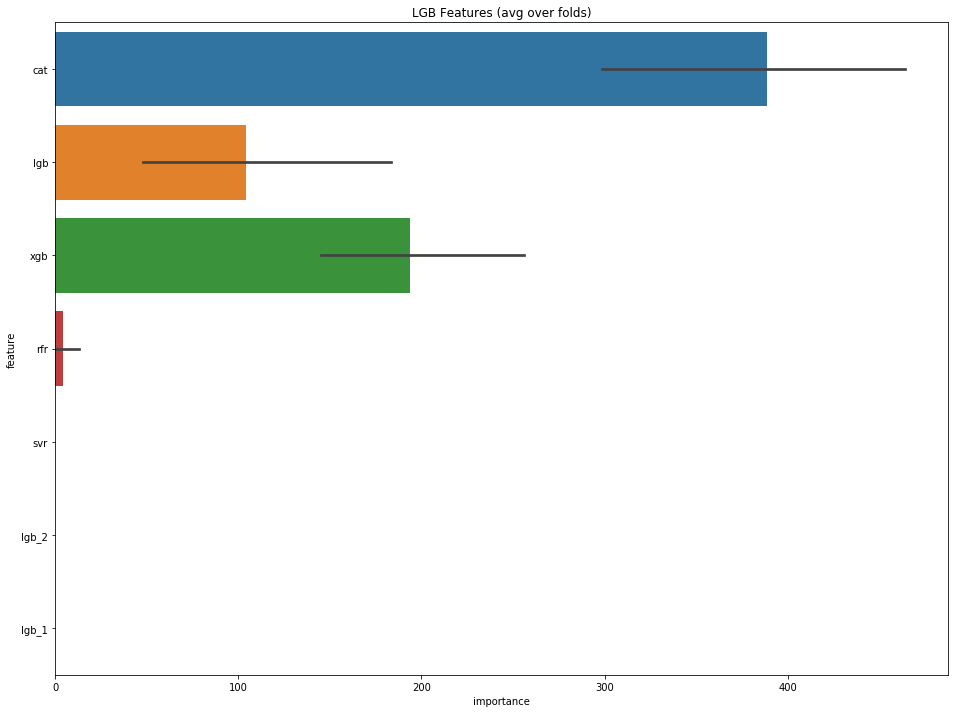

In [64]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:49:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00616613	valid_1's rmse: 0.00268403
Fold 1 started at Sun Dec 15 13:49:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615173	valid_1's rmse: 0.00414855
Fold 2 started at Sun Dec 15 13:49:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00616457	valid_1's rmse: 0.00458975
Fold 3 started at Sun Dec 15 13:49:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570422	valid_1's rmse: 0.0109499
Fold 4 started at Sun Dec 15 13:49:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00540616	valid_1's rmse: 0.

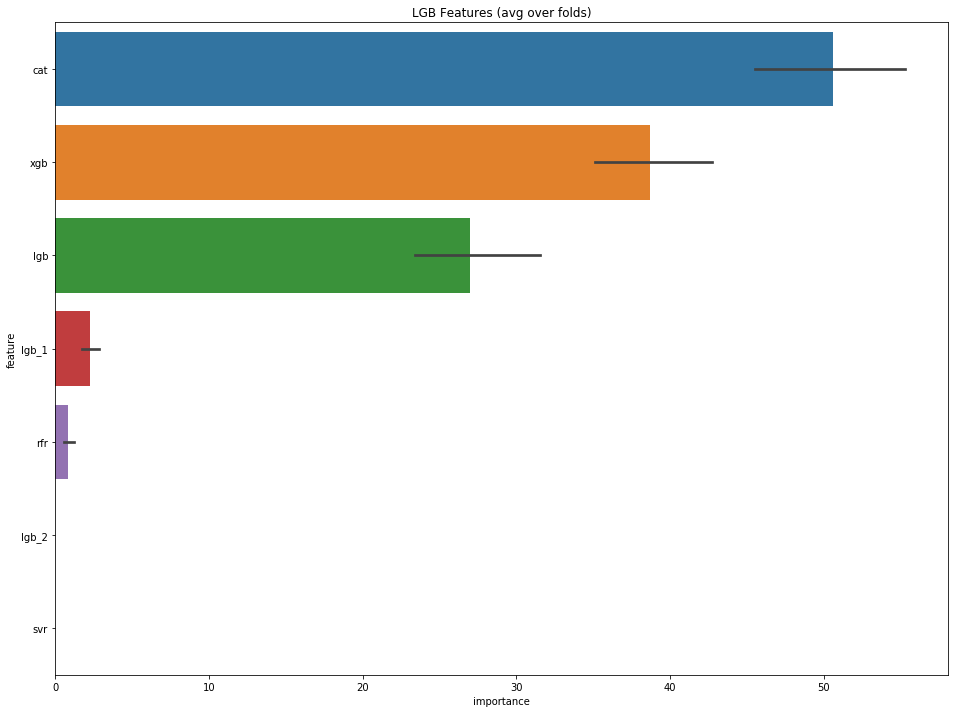

In [65]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [66]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:49:42 2019
Fold 1 started at Sun Dec 15 13:49:44 2019
Fold 2 started at Sun Dec 15 13:49:56 2019
Fold 3 started at Sun Dec 15 13:49:59 2019
Fold 4 started at Sun Dec 15 13:50:11 2019
Fold 5 started at Sun Dec 15 13:50:23 2019
Fold 6 started at Sun Dec 15 13:50:24 2019
Fold 7 started at Sun Dec 15 13:50:26 2019
Fold 8 started at Sun Dec 15 13:50:31 2019
Fold 9 started at Sun Dec 15 13:50:36 2019
CV mean score: 0.0033, std: 0.0023.


random forest做第二层融合模型

In [67]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:50:37 2019
Fold 1 started at Sun Dec 15 13:50:37 2019
Fold 2 started at Sun Dec 15 13:50:38 2019
Fold 3 started at Sun Dec 15 13:50:38 2019
Fold 4 started at Sun Dec 15 13:50:38 2019
Fold 5 started at Sun Dec 15 13:50:38 2019
Fold 6 started at Sun Dec 15 13:50:39 2019
Fold 7 started at Sun Dec 15 13:50:39 2019
Fold 8 started at Sun Dec 15 13:50:39 2019
Fold 9 started at Sun Dec 15 13:50:39 2019
CV mean score: 0.0038, std: 0.0025.


xgboost做第二层融合模型

In [68]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:50:40 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004959	valid_data-rmse:0.004315
Stopping. Best iteration:
[684]	train-rmse:0.001792	valid_data-rmse:0.00202

Fold 1 started at Sun Dec 15 13:50:40 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004969	valid_data-rmse:0.004217
[1000]	train-rmse:0.000779	valid_data-rmse:0.00136
[1500]	train-rmse:0.000647	valid_data-rmse:0.001347
Stopping. Best iteration:
[1435]	train-rmse:0.00065	valid_data-rmse:0.001345

Fold 2 started at Sun Dec 15 13:50:40 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-r

#### SVR作为meta

In [69]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:50:42 2019
Fold 1 started at Sun Dec 15 13:50:42 2019
Fold 2 started at Sun Dec 15 13:50:42 2019
Fold 3 started at Sun Dec 15 13:50:42 2019
Fold 4 started at Sun Dec 15 13:50:42 2019
Fold 5 started at Sun Dec 15 13:50:42 2019
Fold 6 started at Sun Dec 15 13:50:42 2019
Fold 7 started at Sun Dec 15 13:50:42 2019
Fold 8 started at Sun Dec 15 13:50:42 2019
Fold 9 started at Sun Dec 15 13:50:42 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 13:50:42 2019
Fold 1 started at Sun Dec 15 13:50:42 2019
Fold 2 started at Sun Dec 15 13:50:42 2019
Fold 3 started at Sun Dec 15 13:50:42 2019
Fold 4 started at Sun Dec 15 13:50:42 2019
Fold 5 started at Sun Dec 15 13:50:42 2019
Fold 6 started at Sun Dec 15 13:50:43 2019
Fold 7 started at Sun Dec 15 13:50:43 2019
Fold 8 started at Sun Dec 15 13:50:43 2019
Fold 9 started at Sun Dec 15 13:50:43 2019
CV mean score: 0.0036, std: 0.0026.
Fold 0 started at Sun Dec 15 13:50:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Sun Dec 15 13:50:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	vali

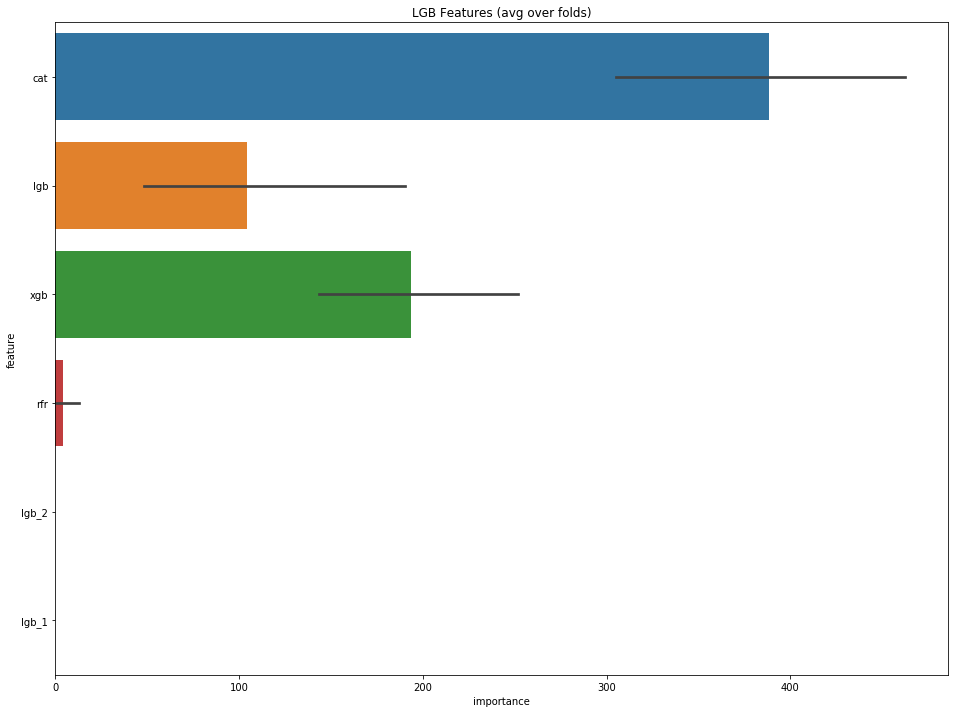

In [70]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:50:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00616605	valid_1's rmse: 0.00268907
Fold 1 started at Sun Dec 15 13:50:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615118	valid_1's rmse: 0.00414017
Fold 2 started at Sun Dec 15 13:50:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.0061639	valid_1's rmse: 0.00459709
Fold 3 started at Sun Dec 15 13:50:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570511	valid_1's rmse: 0.0109499
Fold 4 started at Sun Dec 15 13:50:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.0054081	valid_1's rmse: 0.01

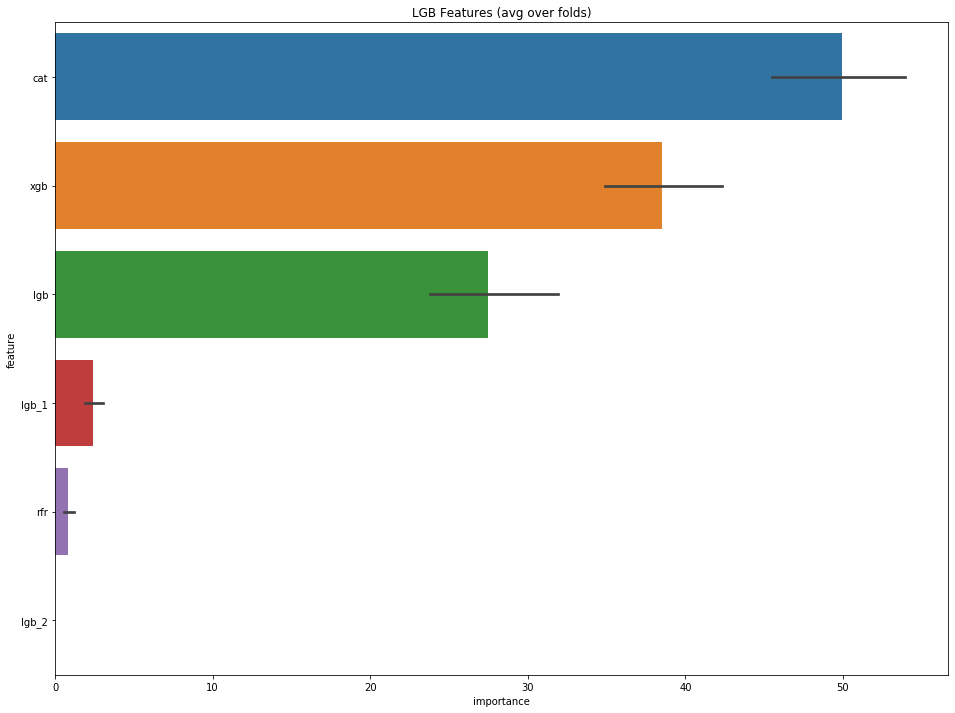

In [71]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [72]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:50:54 2019
Fold 1 started at Sun Dec 15 13:50:56 2019
Fold 2 started at Sun Dec 15 13:51:09 2019
Fold 3 started at Sun Dec 15 13:51:12 2019
Fold 4 started at Sun Dec 15 13:51:24 2019
Fold 5 started at Sun Dec 15 13:51:35 2019
Fold 6 started at Sun Dec 15 13:51:37 2019
Fold 7 started at Sun Dec 15 13:51:38 2019
Fold 8 started at Sun Dec 15 13:51:44 2019
Fold 9 started at Sun Dec 15 13:51:48 2019
CV mean score: 0.0033, std: 0.0023.


random forest做第二层融合模型

In [73]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:51:49 2019
Fold 1 started at Sun Dec 15 13:51:49 2019
Fold 2 started at Sun Dec 15 13:51:49 2019
Fold 3 started at Sun Dec 15 13:51:50 2019
Fold 4 started at Sun Dec 15 13:51:50 2019
Fold 5 started at Sun Dec 15 13:51:50 2019
Fold 6 started at Sun Dec 15 13:51:50 2019
Fold 7 started at Sun Dec 15 13:51:51 2019
Fold 8 started at Sun Dec 15 13:51:51 2019
Fold 9 started at Sun Dec 15 13:51:51 2019
CV mean score: 0.0040, std: 0.0025.


xgboost做第二层融合模型

In [74]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:51:51 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004977	valid_data-rmse:0.004267
Stopping. Best iteration:
[654]	train-rmse:0.002082	valid_data-rmse:0.002004

Fold 1 started at Sun Dec 15 13:51:52 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005012	valid_data-rmse:0.004212
[1000]	train-rmse:0.000821	valid_data-rmse:0.001356
[1500]	train-rmse:0.000676	valid_data-rmse:0.001355
Stopping. Best iteration:
[1302]	train-rmse:0.000701	valid_data-rmse:0.00135

Fold 2 started at Sun Dec 15 13:51:52 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data

#### SVR作为meta

In [75]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:51:54 2019
Fold 1 started at Sun Dec 15 13:51:54 2019
Fold 2 started at Sun Dec 15 13:51:54 2019
Fold 3 started at Sun Dec 15 13:51:54 2019
Fold 4 started at Sun Dec 15 13:51:54 2019
Fold 5 started at Sun Dec 15 13:51:54 2019
Fold 6 started at Sun Dec 15 13:51:54 2019
Fold 7 started at Sun Dec 15 13:51:54 2019
Fold 8 started at Sun Dec 15 13:51:54 2019
Fold 9 started at Sun Dec 15 13:51:54 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

In [76]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:51:54 2019
Fold 1 started at Sun Dec 15 13:51:54 2019
Fold 2 started at Sun Dec 15 13:51:54 2019
Fold 3 started at Sun Dec 15 13:51:54 2019
Fold 4 started at Sun Dec 15 13:51:54 2019
Fold 5 started at Sun Dec 15 13:51:54 2019
Fold 6 started at Sun Dec 15 13:51:54 2019
Fold 7 started at Sun Dec 15 13:51:54 2019
Fold 8 started at Sun Dec 15 13:51:54 2019
Fold 9 started at Sun Dec 15 13:51:54 2019
CV mean score: 0.0036, std: 0.0026.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 13:51:54 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589349	valid_1's rmse: 0.00245621
[2000]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Early stopping, best iteration is:
[2525]	training's rmse: 0.00589036	valid_1's rmse: 0.00245399
Fold 1 started at Sun Dec 15 13:51:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00589836	valid_1's rmse: 0.00389688
[2000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
[3000]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Early stopping, best iteration is:
[3730]	training's rmse: 0.00589506	valid_1's rmse: 0.00389355
Fold 2 started at Sun Dec 15 13:51:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00582524	valid_1's rmse: 0.00430938
[2000]	training's rmse: 0.00582164	valid_1's rmse: 0.00430667
[3000]	training's rmse: 0.00582164	valid_1's rmse: 0.0

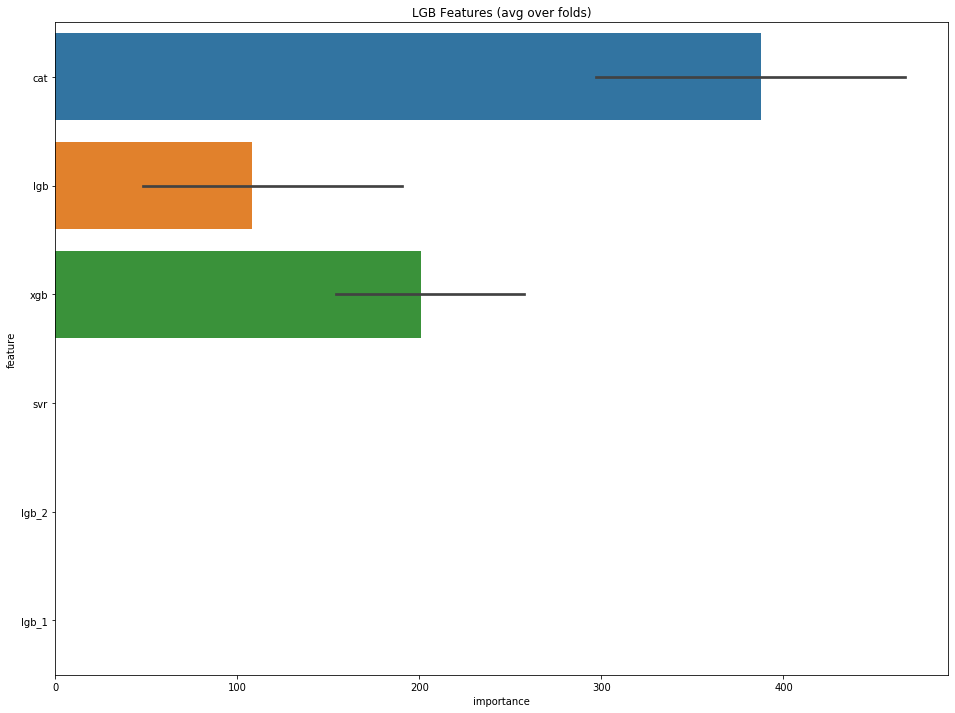

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:52:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0061662	valid_1's rmse: 0.00268902
Fold 1 started at Sun Dec 15 13:52:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00615112	valid_1's rmse: 0.00413807
Fold 2 started at Sun Dec 15 13:52:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00616452	valid_1's rmse: 0.00459749
Fold 3 started at Sun Dec 15 13:52:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[564]	training's rmse: 0.00570579	valid_1's rmse: 0.0109467
Fold 4 started at Sun Dec 15 13:52:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00540749	valid_1's rmse: 0.0

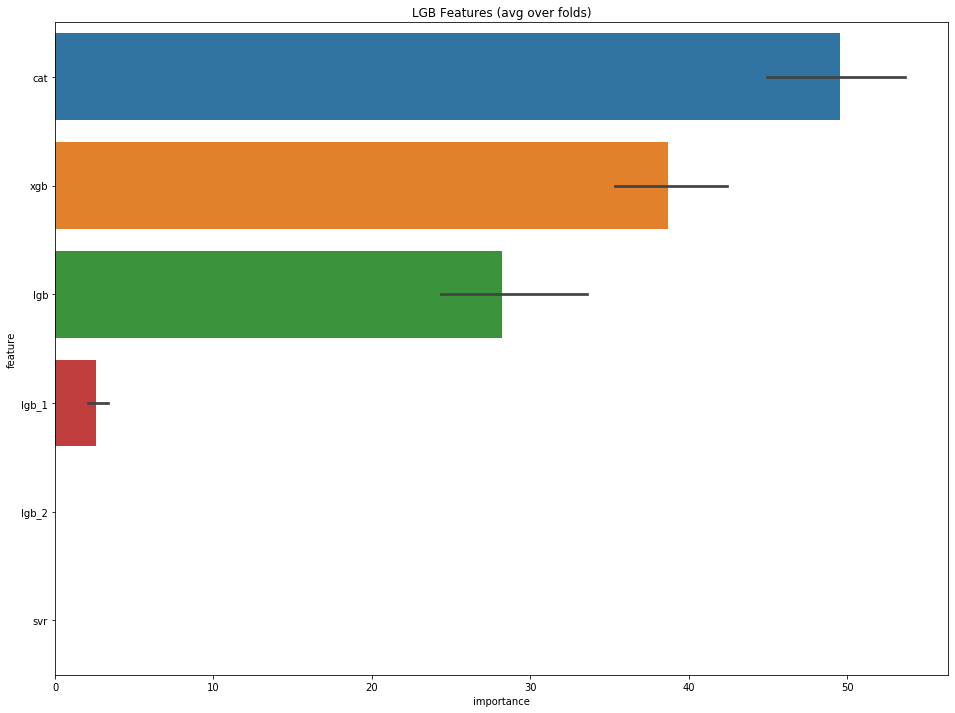

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [79]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:52:05 2019
Fold 1 started at Sun Dec 15 13:52:13 2019
Fold 2 started at Sun Dec 15 13:52:18 2019
Fold 3 started at Sun Dec 15 13:52:20 2019
Fold 4 started at Sun Dec 15 13:52:31 2019
Fold 5 started at Sun Dec 15 13:52:44 2019
Fold 6 started at Sun Dec 15 13:52:45 2019
Fold 7 started at Sun Dec 15 13:52:46 2019
Fold 8 started at Sun Dec 15 13:52:51 2019
Fold 9 started at Sun Dec 15 13:52:55 2019
CV mean score: 0.0032, std: 0.0023.


random forest做第二层融合模型

In [80]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:52:57 2019
Fold 1 started at Sun Dec 15 13:52:57 2019
Fold 2 started at Sun Dec 15 13:52:57 2019
Fold 3 started at Sun Dec 15 13:52:57 2019
Fold 4 started at Sun Dec 15 13:52:58 2019
Fold 5 started at Sun Dec 15 13:52:58 2019
Fold 6 started at Sun Dec 15 13:52:58 2019
Fold 7 started at Sun Dec 15 13:52:58 2019
Fold 8 started at Sun Dec 15 13:52:59 2019
Fold 9 started at Sun Dec 15 13:52:59 2019
CV mean score: 0.0039, std: 0.0026.


xgboost做第二层融合模型

In [81]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:52:59 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004973	valid_data-rmse:0.004276
[1000]	train-rmse:0.000894	valid_data-rmse:0.00116
Stopping. Best iteration:
[980]	train-rmse:0.00091	valid_data-rmse:0.001157

Fold 1 started at Sun Dec 15 13:52:59 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004997	valid_data-rmse:0.004189
[1000]	train-rmse:0.000864	valid_data-rmse:0.001396
Stopping. Best iteration:
[969]	train-rmse:0.000889	valid_data-rmse:0.001395

Fold 2 started at Sun Dec 15 13:53:00 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-r

#### SVR作为meta

In [82]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:53:01 2019
Fold 1 started at Sun Dec 15 13:53:01 2019
Fold 2 started at Sun Dec 15 13:53:01 2019
Fold 3 started at Sun Dec 15 13:53:01 2019
Fold 4 started at Sun Dec 15 13:53:01 2019
Fold 5 started at Sun Dec 15 13:53:01 2019
Fold 6 started at Sun Dec 15 13:53:01 2019
Fold 7 started at Sun Dec 15 13:53:01 2019
Fold 8 started at Sun Dec 15 13:53:01 2019
Fold 9 started at Sun Dec 15 13:53:01 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

In [83]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:53:01 2019
Fold 1 started at Sun Dec 15 13:53:01 2019
Fold 2 started at Sun Dec 15 13:53:01 2019
Fold 3 started at Sun Dec 15 13:53:01 2019
Fold 4 started at Sun Dec 15 13:53:01 2019
Fold 5 started at Sun Dec 15 13:53:01 2019
Fold 6 started at Sun Dec 15 13:53:02 2019
Fold 7 started at Sun Dec 15 13:53:02 2019
Fold 8 started at Sun Dec 15 13:53:02 2019
Fold 9 started at Sun Dec 15 13:53:02 2019
CV mean score: 0.0035, std: 0.0025.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 13:53:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0059948	valid_1's rmse: 0.0029194
[2000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[3000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
[4000]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Early stopping, best iteration is:
[4207]	training's rmse: 0.00599193	valid_1's rmse: 0.00291763
Fold 1 started at Sun Dec 15 13:53:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00599347	valid_1's rmse: 0.00410339
[2000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[3000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[4000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[5000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
[6000]	training's rmse: 0.0059901	valid_1's rmse: 0.00410005
Early stopping, best iteration is:
[5967]	training's rmse: 0.0059901	valid_1's

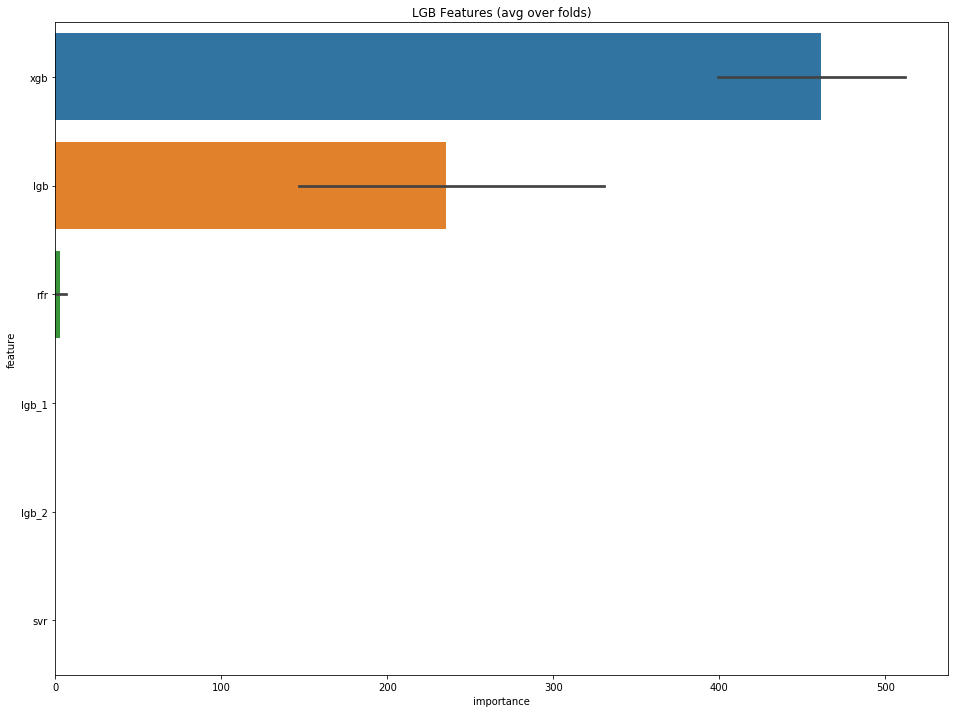

In [84]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00623674	valid_1's rmse: 0.00304834
Fold 1 started at Sun Dec 15 13:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00622818	valid_1's rmse: 0.00429777
Fold 2 started at Sun Dec 15 13:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 0.00622575	valid_1's rmse: 0.00489572
Fold 3 started at Sun Dec 15 13:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00581125	valid_1's rmse: 0.0109767
Fold 4 started at Sun Dec 15 13:53:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00541955	valid_1's rmse: 0.

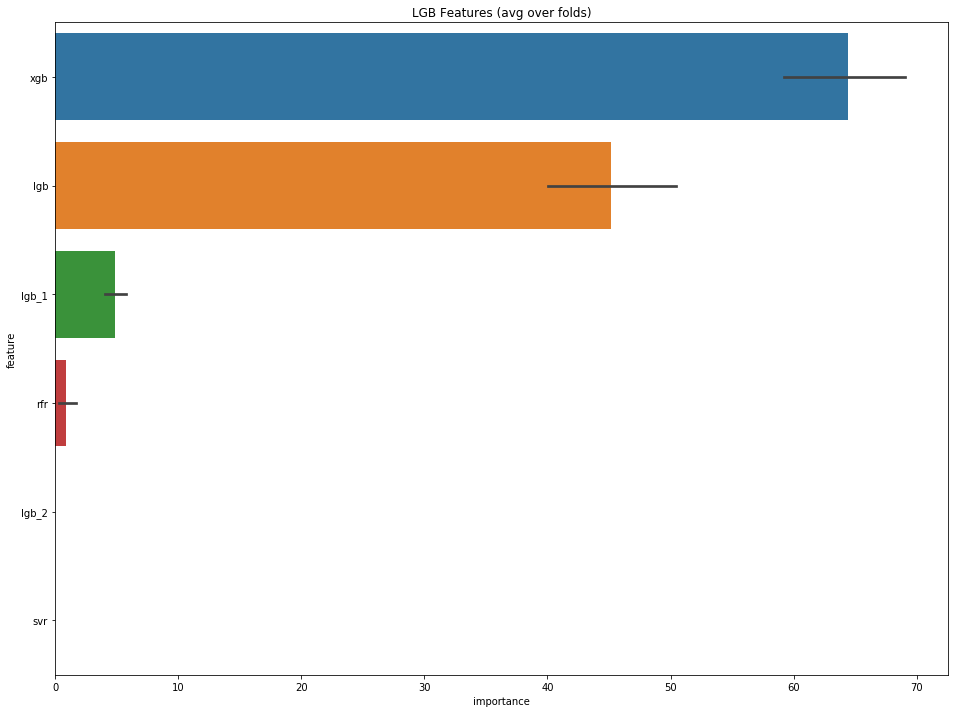

In [85]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [86]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:53:14 2019
Fold 1 started at Sun Dec 15 13:53:16 2019
Fold 2 started at Sun Dec 15 13:53:27 2019
Fold 3 started at Sun Dec 15 13:53:29 2019
Fold 4 started at Sun Dec 15 13:53:42 2019
Fold 5 started at Sun Dec 15 13:53:53 2019
Fold 6 started at Sun Dec 15 13:53:55 2019
Fold 7 started at Sun Dec 15 13:53:56 2019
Fold 8 started at Sun Dec 15 13:54:01 2019
Fold 9 started at Sun Dec 15 13:54:04 2019
CV mean score: 0.0035, std: 0.0023.


random forest做第二层融合模型

In [87]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:54:06 2019
Fold 1 started at Sun Dec 15 13:54:06 2019
Fold 2 started at Sun Dec 15 13:54:06 2019
Fold 3 started at Sun Dec 15 13:54:06 2019
Fold 4 started at Sun Dec 15 13:54:07 2019
Fold 5 started at Sun Dec 15 13:54:07 2019
Fold 6 started at Sun Dec 15 13:54:07 2019
Fold 7 started at Sun Dec 15 13:54:07 2019
Fold 8 started at Sun Dec 15 13:54:08 2019
Fold 9 started at Sun Dec 15 13:54:08 2019
CV mean score: 0.0044, std: 0.0025.


xgboost做第二层融合模型

In [88]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:54:08 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005068	valid_data-rmse:0.004246
Stopping. Best iteration:
[663]	train-rmse:0.002102	valid_data-rmse:0.002172

Fold 1 started at Sun Dec 15 13:54:08 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005081	valid_data-rmse:0.004063
[1000]	train-rmse:0.000849	valid_data-rmse:0.001532
[1500]	train-rmse:0.000699	valid_data-rmse:0.001513
Stopping. Best iteration:
[1652]	train-rmse:0.000687	valid_data-rmse:0.001511

Fold 2 started at Sun Dec 15 13:54:09 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_dat

#### SVR作为meta

In [89]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:54:11 2019
Fold 1 started at Sun Dec 15 13:54:11 2019
Fold 2 started at Sun Dec 15 13:54:11 2019
Fold 3 started at Sun Dec 15 13:54:11 2019
Fold 4 started at Sun Dec 15 13:54:11 2019
Fold 5 started at Sun Dec 15 13:54:11 2019
Fold 6 started at Sun Dec 15 13:54:11 2019
Fold 7 started at Sun Dec 15 13:54:11 2019
Fold 8 started at Sun Dec 15 13:54:11 2019
Fold 9 started at Sun Dec 15 13:54:11 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

In [90]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 13:54:11 2019
Fold 1 started at Sun Dec 15 13:54:11 2019
Fold 2 started at Sun Dec 15 13:54:11 2019
Fold 3 started at Sun Dec 15 13:54:11 2019
Fold 4 started at Sun Dec 15 13:54:11 2019
Fold 5 started at Sun Dec 15 13:54:11 2019
Fold 6 started at Sun Dec 15 13:54:11 2019
Fold 7 started at Sun Dec 15 13:54:11 2019
Fold 8 started at Sun Dec 15 13:54:11 2019
Fold 9 started at Sun Dec 15 13:54:11 2019
CV mean score: 0.0040, std: 0.0026.


### 去掉xgboost

Fold 0 started at Sun Dec 15 13:54:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592148	valid_1's rmse: 0.0025264
[2000]	training's rmse: 0.00591774	valid_1's rmse: 0.00252451
Early stopping, best iteration is:
[2511]	training's rmse: 0.00591774	valid_1's rmse: 0.0025245
Fold 1 started at Sun Dec 15 13:54:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00592944	valid_1's rmse: 0.00392323
[2000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[3000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
[4000]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Early stopping, best iteration is:
[4363]	training's rmse: 0.00592556	valid_1's rmse: 0.00391951
Fold 2 started at Sun Dec 15 13:54:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00587783	valid_1's rmse: 0.00431093
[2000]	training's rmse: 0.00587397	valid_1's rmse: 0.004

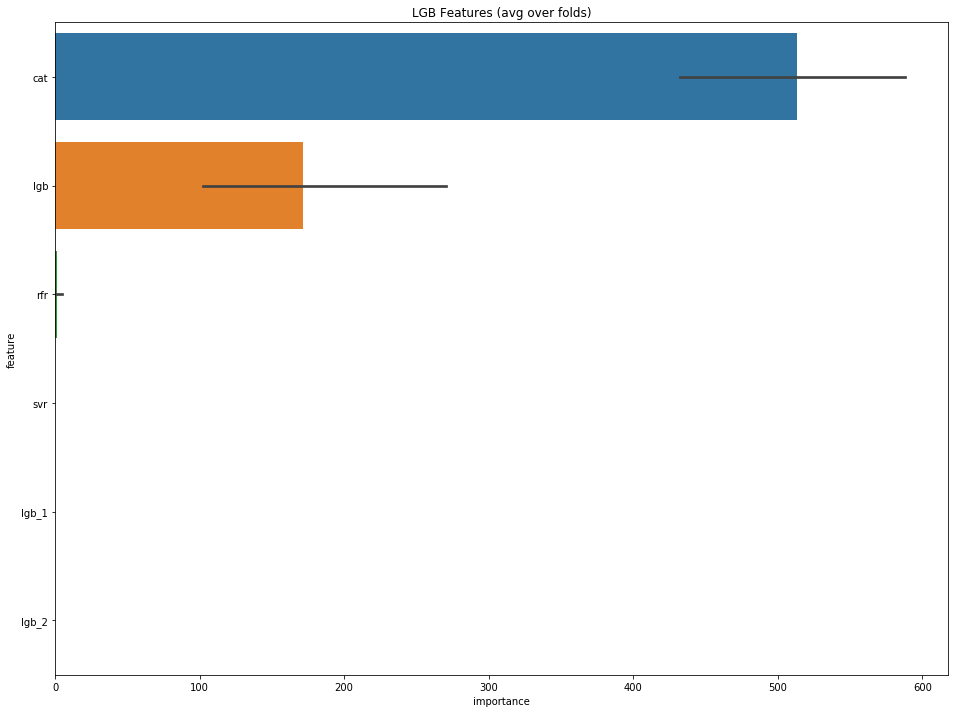

In [91]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.00621036	valid_1's rmse: 0.00274357
Fold 1 started at Sun Dec 15 13:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.00619679	valid_1's rmse: 0.00420467
Fold 2 started at Sun Dec 15 13:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00621738	valid_1's rmse: 0.00460822
Fold 3 started at Sun Dec 15 13:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00576528	valid_1's rmse: 0.0109121
Fold 4 started at Sun Dec 15 13:54:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.00545761	valid_1's rmse: 0.

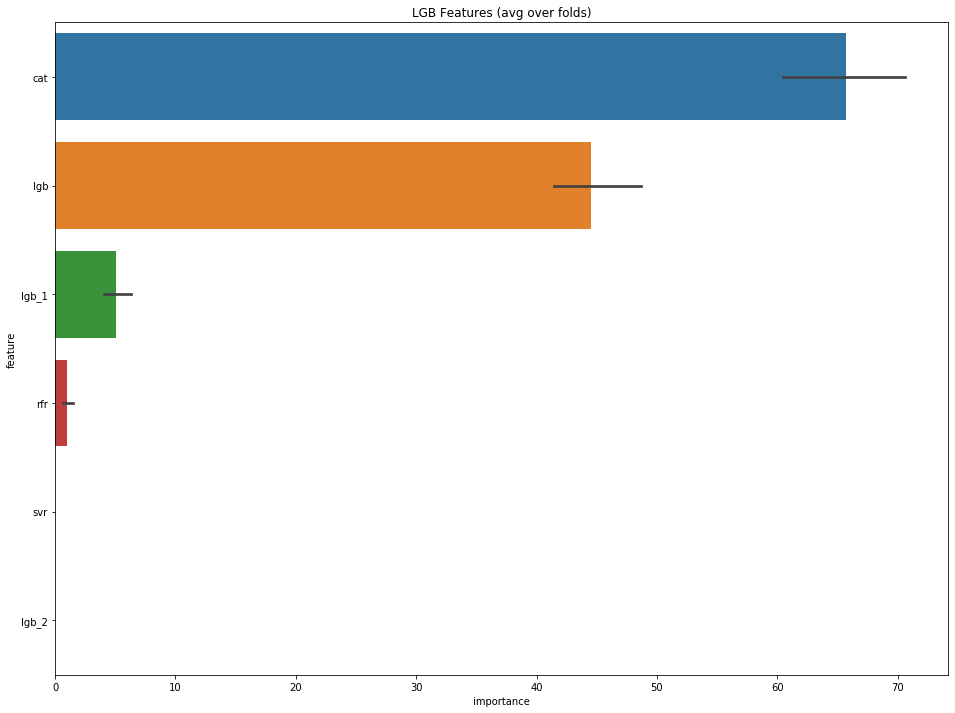

In [92]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [93]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:54:22 2019
Fold 1 started at Sun Dec 15 13:54:24 2019
Fold 2 started at Sun Dec 15 13:54:35 2019
Fold 3 started at Sun Dec 15 13:54:42 2019
Fold 4 started at Sun Dec 15 13:54:54 2019
Fold 5 started at Sun Dec 15 13:55:05 2019
Fold 6 started at Sun Dec 15 13:55:07 2019
Fold 7 started at Sun Dec 15 13:55:08 2019
Fold 8 started at Sun Dec 15 13:55:13 2019
Fold 9 started at Sun Dec 15 13:55:20 2019
CV mean score: 0.0035, std: 0.0023.


random forest做第二层融合模型

In [94]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:55:21 2019
Fold 1 started at Sun Dec 15 13:55:21 2019
Fold 2 started at Sun Dec 15 13:55:21 2019
Fold 3 started at Sun Dec 15 13:55:22 2019
Fold 4 started at Sun Dec 15 13:55:22 2019
Fold 5 started at Sun Dec 15 13:55:22 2019
Fold 6 started at Sun Dec 15 13:55:22 2019
Fold 7 started at Sun Dec 15 13:55:23 2019
Fold 8 started at Sun Dec 15 13:55:23 2019
Fold 9 started at Sun Dec 15 13:55:23 2019
CV mean score: 0.0045, std: 0.0025.


xgboost做第二层融合模型

In [95]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:55:23 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005068	valid_data-rmse:0.004592
Stopping. Best iteration:
[743]	train-rmse:0.001559	valid_data-rmse:0.002034

Fold 1 started at Sun Dec 15 13:55:24 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.005081	valid_data-rmse:0.004503
[1000]	train-rmse:0.000848	valid_data-rmse:0.001626
[1500]	train-rmse:0.000684	valid_data-rmse:0.001576
[2000]	train-rmse:0.000654	valid_data-rmse:0.001565
Stopping. Best iteration:
[2117]	train-rmse:0.000651	valid_data-rmse:0.001564

Fold 2 started at Sun Dec 15 13:55:24 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.55140

#### SVR作为meta

In [96]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:55:26 2019
Fold 1 started at Sun Dec 15 13:55:26 2019
Fold 2 started at Sun Dec 15 13:55:26 2019
Fold 3 started at Sun Dec 15 13:55:26 2019
Fold 4 started at Sun Dec 15 13:55:26 2019
Fold 5 started at Sun Dec 15 13:55:26 2019
Fold 6 started at Sun Dec 15 13:55:26 2019
Fold 7 started at Sun Dec 15 13:55:26 2019
Fold 8 started at Sun Dec 15 13:55:26 2019
Fold 9 started at Sun Dec 15 13:55:26 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

In [97]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:55:26 2019
Fold 1 started at Sun Dec 15 13:55:26 2019
Fold 2 started at Sun Dec 15 13:55:26 2019
Fold 3 started at Sun Dec 15 13:55:26 2019
Fold 4 started at Sun Dec 15 13:55:26 2019
Fold 5 started at Sun Dec 15 13:55:26 2019
Fold 6 started at Sun Dec 15 13:55:26 2019
Fold 7 started at Sun Dec 15 13:55:26 2019
Fold 8 started at Sun Dec 15 13:55:26 2019
Fold 9 started at Sun Dec 15 13:55:26 2019
CV mean score: 0.0041, std: 0.0026.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 13:55:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590565	valid_1's rmse: 0.00248225
[2000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
[3000]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Early stopping, best iteration is:
[3141]	training's rmse: 0.00590252	valid_1's rmse: 0.00247993
Fold 1 started at Sun Dec 15 13:55:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00590099	valid_1's rmse: 0.00393527
[2000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
[3000]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Early stopping, best iteration is:
[3712]	training's rmse: 0.0058977	valid_1's rmse: 0.00393208
Fold 2 started at Sun Dec 15 13:55:28 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.00583174	valid_1's rmse: 0.00433727
[2000]	training's rmse: 0.00582815	valid_1's rmse: 0.0043

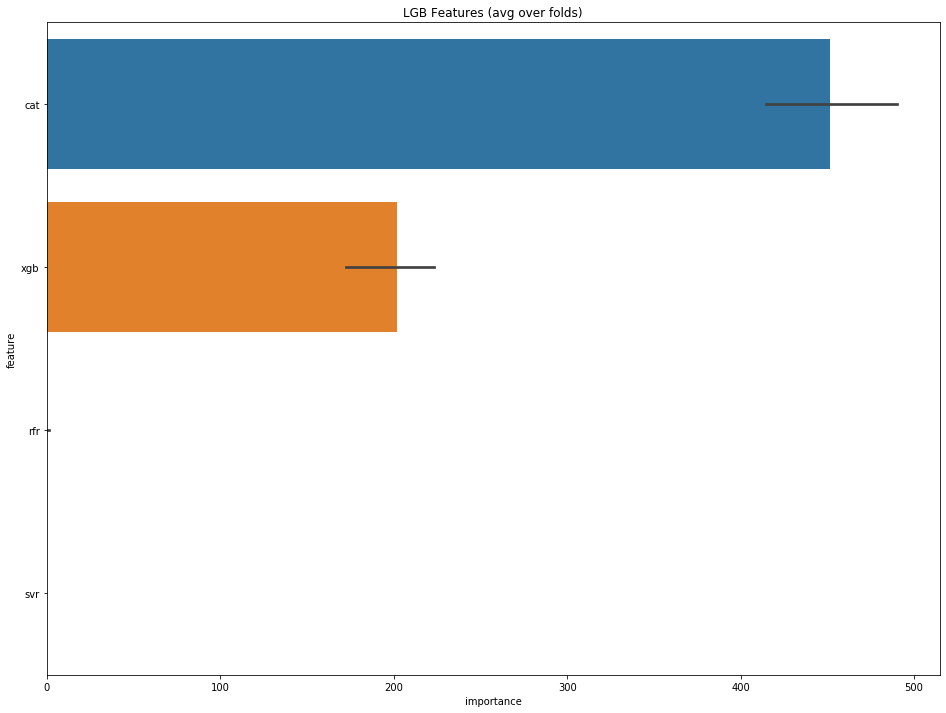

In [98]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 13:55:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.00618594	valid_1's rmse: 0.00271037
Fold 1 started at Sun Dec 15 13:55:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[575]	training's rmse: 0.0061657	valid_1's rmse: 0.00419221
Fold 2 started at Sun Dec 15 13:55:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 0.00617902	valid_1's rmse: 0.00461429
Fold 3 started at Sun Dec 15 13:55:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 0.00574535	valid_1's rmse: 0.0110166
Fold 4 started at Sun Dec 15 13:55:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.0054496	valid_1's rmse: 0.01

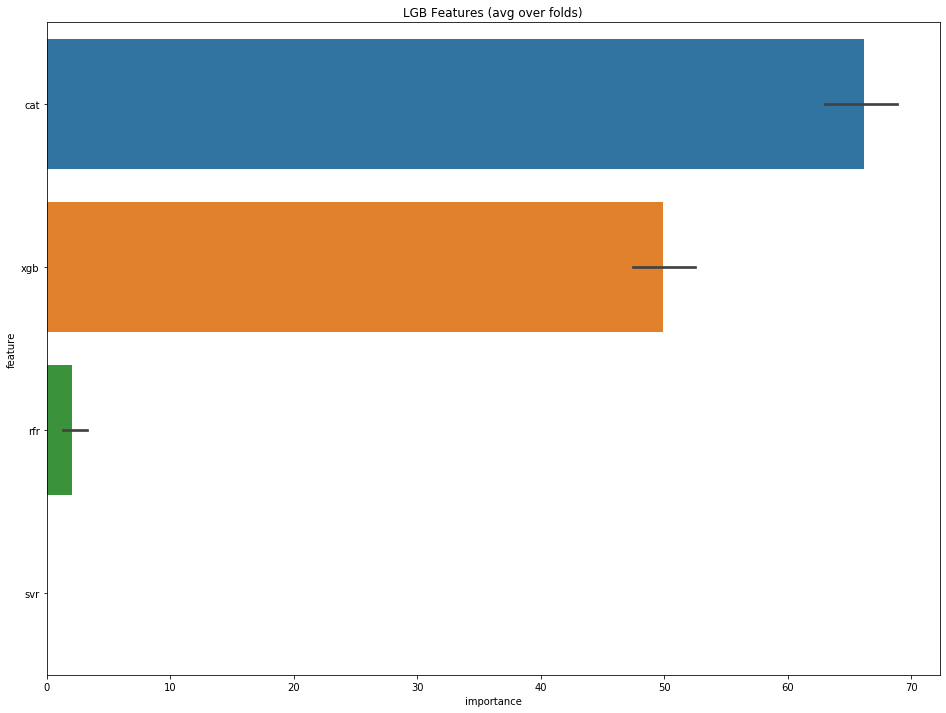

In [99]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [100]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 13:55:37 2019
Fold 1 started at Sun Dec 15 13:55:38 2019
Fold 2 started at Sun Dec 15 13:55:50 2019
Fold 3 started at Sun Dec 15 13:55:52 2019
Fold 4 started at Sun Dec 15 13:56:03 2019
Fold 5 started at Sun Dec 15 13:56:14 2019
Fold 6 started at Sun Dec 15 13:56:16 2019
Fold 7 started at Sun Dec 15 13:56:17 2019
Fold 8 started at Sun Dec 15 13:56:21 2019
Fold 9 started at Sun Dec 15 13:56:27 2019
CV mean score: 0.0034, std: 0.0023.


random forest做第二层融合模型

In [101]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 13:56:28 2019
Fold 1 started at Sun Dec 15 13:56:28 2019
Fold 2 started at Sun Dec 15 13:56:29 2019
Fold 3 started at Sun Dec 15 13:56:29 2019
Fold 4 started at Sun Dec 15 13:56:29 2019
Fold 5 started at Sun Dec 15 13:56:29 2019
Fold 6 started at Sun Dec 15 13:56:29 2019
Fold 7 started at Sun Dec 15 13:56:30 2019
Fold 8 started at Sun Dec 15 13:56:30 2019
Fold 9 started at Sun Dec 15 13:56:30 2019
CV mean score: 0.0040, std: 0.0026.


xgboost做第二层融合模型

In [102]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:56:30 2019
[0]	train-rmse:0.550137	valid_data-rmse:0.552468
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004953	valid_data-rmse:0.004551
[1000]	train-rmse:0.000805	valid_data-rmse:0.001847
Stopping. Best iteration:
[841]	train-rmse:0.001048	valid_data-rmse:0.00182

Fold 1 started at Sun Dec 15 13:56:31 2019
[0]	train-rmse:0.550162	valid_data-rmse:0.55234
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.004975	valid_data-rmse:0.004082
Stopping. Best iteration:
[795]	train-rmse:0.001185	valid_data-rmse:0.001358

Fold 2 started at Sun Dec 15 13:56:31 2019
[0]	train-rmse:0.550262	valid_data-rmse:0.551404
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

#### SVR作为meta

In [103]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 13:56:32 2019
Fold 1 started at Sun Dec 15 13:56:32 2019
Fold 2 started at Sun Dec 15 13:56:32 2019
Fold 3 started at Sun Dec 15 13:56:32 2019
Fold 4 started at Sun Dec 15 13:56:32 2019
Fold 5 started at Sun Dec 15 13:56:32 2019
Fold 6 started at Sun Dec 15 13:56:32 2019
Fold 7 started at Sun Dec 15 13:56:32 2019
Fold 8 started at Sun Dec 15 13:56:32 2019
Fold 9 started at Sun Dec 15 13:56:32 2019
CV mean score: 0.0197, std: 0.0037.


用岭回归做第二层融合模型

In [104]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 13:56:32 2019
Fold 1 started at Sun Dec 15 13:56:32 2019
Fold 2 started at Sun Dec 15 13:56:33 2019
Fold 3 started at Sun Dec 15 13:56:33 2019
Fold 4 started at Sun Dec 15 13:56:33 2019
Fold 5 started at Sun Dec 15 13:56:33 2019
Fold 6 started at Sun Dec 15 13:56:33 2019
Fold 7 started at Sun Dec 15 13:56:33 2019
Fold 8 started at Sun Dec 15 13:56:33 2019
Fold 9 started at Sun Dec 15 13:56:33 2019
CV mean score: 0.0034, std: 0.0025.


## cpusmall 数据集实验

In [105]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('cpusmall')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.06033	valid_1's rmse: 2.47297
[2000]	training's rmse: 1.73507	valid_1's rmse: 2.40194
[3000]	training's rmse: 1.49445	valid_1's rmse: 2.37301
[4000]	training's rmse: 1.31151	valid_1's rmse: 2.36162
Early stopping, best iteration is:
[4601]	training's rmse: 1.22124	valid_1's rmse: 2.35815


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [107]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 13:56:37 2019
Fold 1 started at Sun Dec 15 13:56:38 2019
Fold 2 started at Sun Dec 15 13:56:40 2019
Fold 3 started at Sun Dec 15 13:56:41 2019
Fold 4 started at Sun Dec 15 13:56:42 2019
Fold 5 started at Sun Dec 15 13:56:44 2019
Fold 6 started at Sun Dec 15 13:56:45 2019
Fold 7 started at Sun Dec 15 13:56:46 2019
Fold 8 started at Sun Dec 15 13:56:48 2019
Fold 9 started at Sun Dec 15 13:56:49 2019
CV mean score: 18.9234, std: 1.9493.


Fold 0 started at Sun Dec 15 13:56:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.89017	valid_1's rmse: 2.71173
[2000]	training's rmse: 1.53675	valid_1's rmse: 2.6731
[3000]	training's rmse: 1.29343	valid_1's rmse: 2.65922
[4000]	training's rmse: 1.10586	valid_1's rmse: 2.65443
Early stopping, best iteration is:
[3875]	training's rmse: 1.12725	valid_1's rmse: 2.65374
Fold 1 started at Sun Dec 15 13:56:54 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.88471	valid_1's rmse: 2.63362
[2000]	training's rmse: 1.53792	valid_1's rmse: 2.58991
Early stopping, best iteration is:
[2587]	training's rmse: 1.38681	valid_1's rmse: 2.58029
Fold 2 started at Sun Dec 15 13:56:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.89636	valid_1's rmse: 2.55048
[2000]	training's rmse: 1.54178	valid_1's rmse: 2.50103
[3000]	training's rmse: 1.29631	valid_1's rmse: 2.480

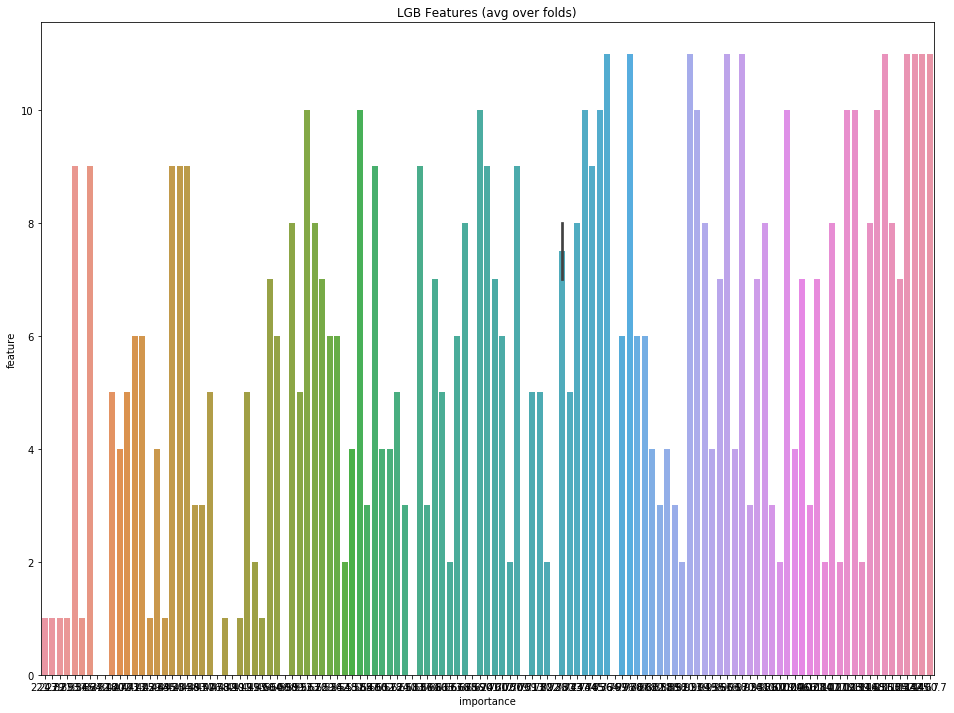

In [108]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:57:26 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.22794	valid_1's rmse: 2.8142
[2000]	training's rmse: 1.92409	valid_1's rmse: 2.73061
[3000]	training's rmse: 1.71744	valid_1's rmse: 2.7113
[4000]	training's rmse: 1.55084	valid_1's rmse: 2.69994
Early stopping, best iteration is:
[4372]	training's rmse: 1.49774	valid_1's rmse: 2.69512
Fold 1 started at Sun Dec 15 13:57:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.21531	valid_1's rmse: 2.72863
[2000]	training's rmse: 1.9049	valid_1's rmse: 2.64
[3000]	training's rmse: 1.70332	valid_1's rmse: 2.61274
Early stopping, best iteration is:
[2986]	training's rmse: 1.70533	valid_1's rmse: 2.61251
Fold 2 started at Sun Dec 15 13:57:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.23223	valid_1's rmse: 2.6554
[2000]	training's rmse: 1.91533	valid_1's rmse: 2.56116
[30

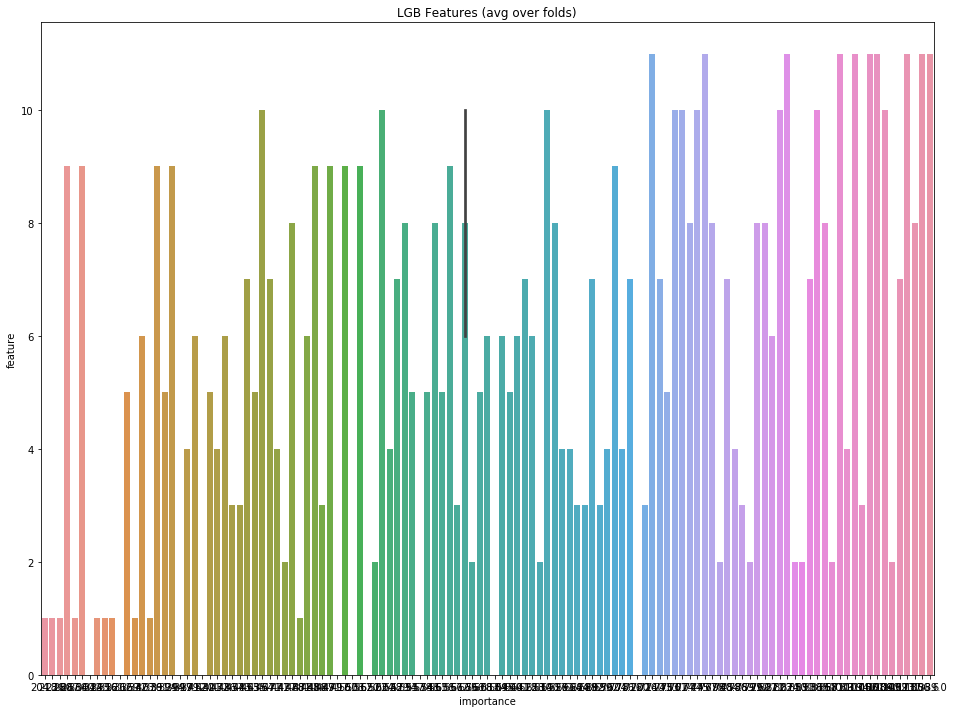

In [109]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 13:58:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.22794	valid_1's rmse: 2.8142
[2000]	training's rmse: 1.92409	valid_1's rmse: 2.73061
[3000]	training's rmse: 1.71744	valid_1's rmse: 2.7113
[4000]	training's rmse: 1.55084	valid_1's rmse: 2.69994
Early stopping, best iteration is:
[4372]	training's rmse: 1.49774	valid_1's rmse: 2.69512
Fold 1 started at Sun Dec 15 13:58:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.21531	valid_1's rmse: 2.72863
[2000]	training's rmse: 1.9049	valid_1's rmse: 2.64
[3000]	training's rmse: 1.70332	valid_1's rmse: 2.61274
Early stopping, best iteration is:
[2986]	training's rmse: 1.70533	valid_1's rmse: 2.61251
Fold 2 started at Sun Dec 15 13:58:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.23223	valid_1's rmse: 2.6554
[2000]	training's rmse: 1.91533	valid_1's rmse: 2.56116
[30

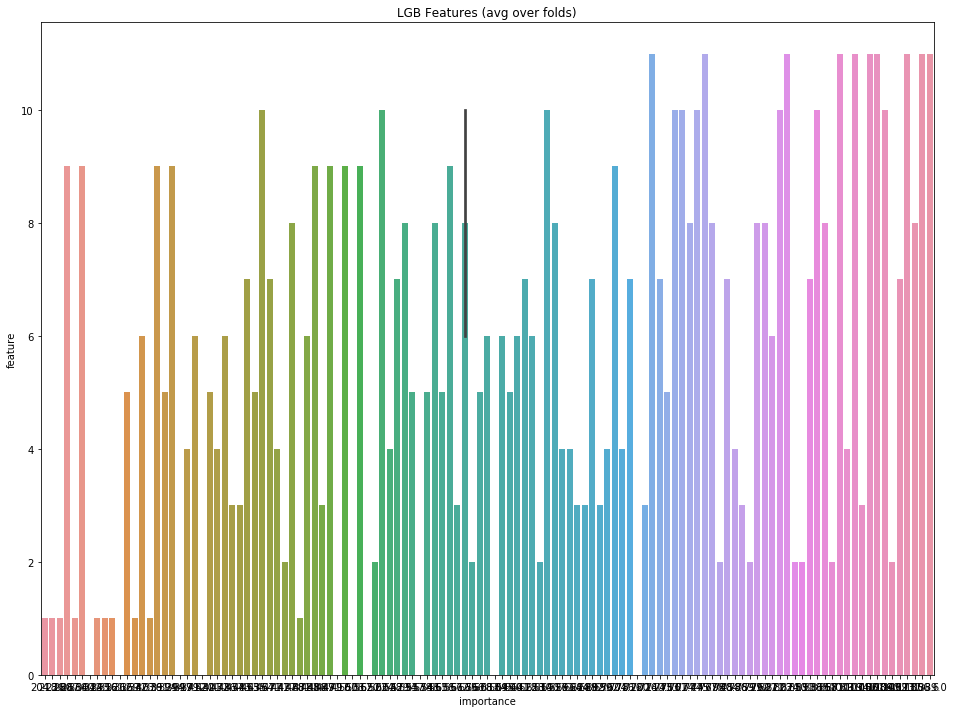

In [110]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [111]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 13:58:35 2019
Fold 1 started at Sun Dec 15 13:58:36 2019
Fold 2 started at Sun Dec 15 13:58:36 2019
Fold 3 started at Sun Dec 15 13:58:36 2019
Fold 4 started at Sun Dec 15 13:58:36 2019
Fold 5 started at Sun Dec 15 13:58:37 2019
Fold 6 started at Sun Dec 15 13:58:37 2019
Fold 7 started at Sun Dec 15 13:58:37 2019
Fold 8 started at Sun Dec 15 13:58:37 2019
Fold 9 started at Sun Dec 15 13:58:38 2019
CV mean score: 2.9276, std: 0.1419.


In [112]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 13:58:38 2019
[0]	train-rmse:84.5858	valid_data-rmse:84.944
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.16287	valid_data-rmse:2.90078
[1000]	train-rmse:1.59573	valid_data-rmse:2.68249
[1500]	train-rmse:1.29927	valid_data-rmse:2.64924
[2000]	train-rmse:1.08007	valid_data-rmse:2.63816
[2500]	train-rmse:0.911232	valid_data-rmse:2.63295
[3000]	train-rmse:0.776576	valid_data-rmse:2.63041
Stopping. Best iteration:
[3163]	train-rmse:0.73852	valid_data-rmse:2.62888

Fold 1 started at Sun Dec 15 13:59:07 2019
[0]	train-rmse:84.5452	valid_data-rmse:85.3074
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.16006	valid_data-rmse:2.80551
[1000]	train-rmse:1.5827	valid_data-rmse:2.61041
[1500]	train-rmse:1.29139	valid_d

In [113]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:03:09 2019
Fold 1 started at Sun Dec 15 14:03:44 2019
Fold 2 started at Sun Dec 15 14:04:20 2019
Fold 3 started at Sun Dec 15 14:04:55 2019
Fold 4 started at Sun Dec 15 14:05:30 2019
Fold 5 started at Sun Dec 15 14:06:05 2019
Fold 6 started at Sun Dec 15 14:06:39 2019
Fold 7 started at Sun Dec 15 14:07:14 2019
Fold 8 started at Sun Dec 15 14:07:49 2019
Fold 9 started at Sun Dec 15 14:08:25 2019
CV mean score: 2.6259, std: 0.1009.


## stacking

Fold 0 started at Sun Dec 15 14:08:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[569]	training's rmse: 2.53196	valid_1's rmse: 2.66621
Fold 1 started at Sun Dec 15 14:08:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[756]	training's rmse: 2.53944	valid_1's rmse: 2.61173
Fold 2 started at Sun Dec 15 14:09:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[664]	training's rmse: 2.51914	valid_1's rmse: 2.49515
Fold 3 started at Sun Dec 15 14:09:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[503]	training's rmse: 2.43595	valid_1's rmse: 2.42853
Fold 4 started at Sun Dec 15 14:09:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[649]	training's rmse: 2.53766	valid_1's rmse: 2.56451
Fold 5 started at Su

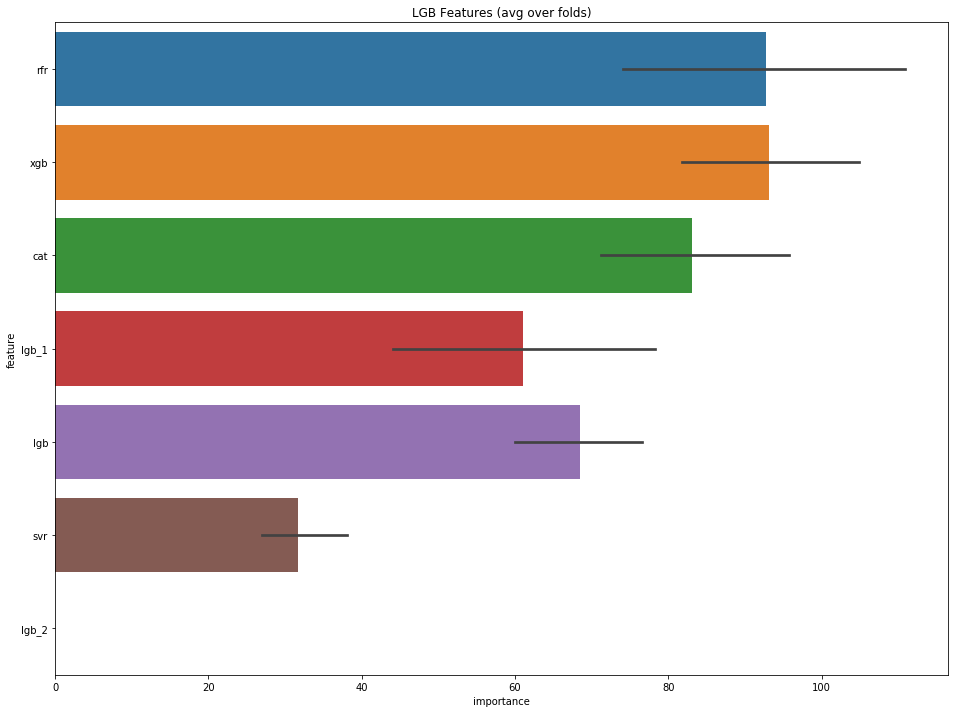

In [114]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:09:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[515]	training's rmse: 2.41587	valid_1's rmse: 2.66269
Fold 1 started at Sun Dec 15 14:09:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[581]	training's rmse: 2.41538	valid_1's rmse: 2.60888
Fold 2 started at Sun Dec 15 14:09:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 2.40878	valid_1's rmse: 2.51862
Fold 3 started at Sun Dec 15 14:09:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[507]	training's rmse: 2.29129	valid_1's rmse: 2.4676
Fold 4 started at Sun Dec 15 14:09:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[592]	training's rmse: 2.39166	valid_1's rmse: 2.57863
Fold 5 started at Sun

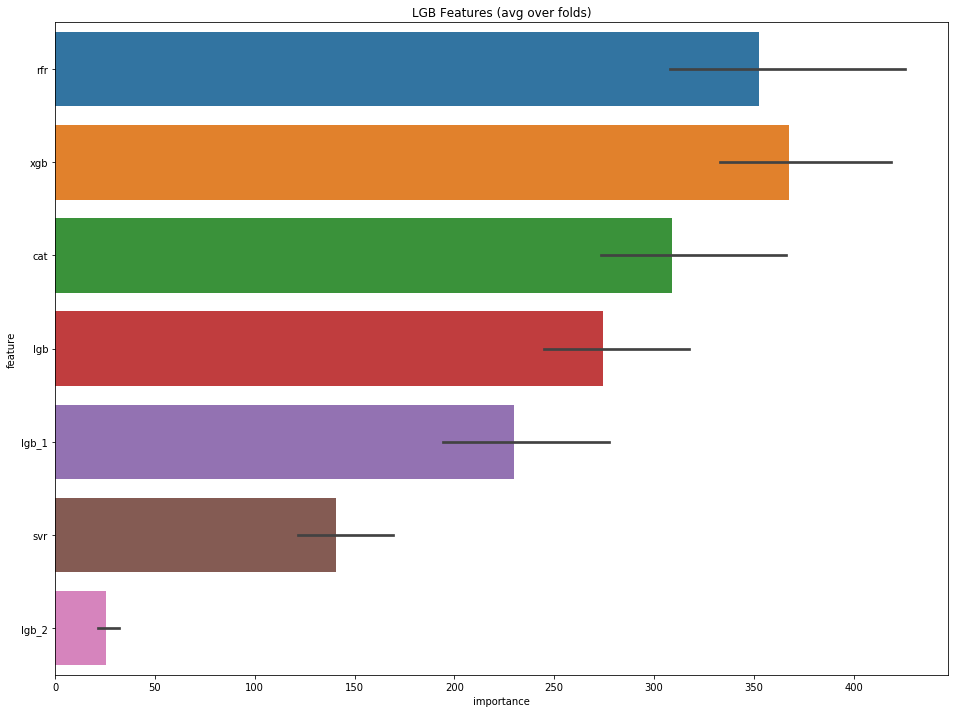

In [115]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [116]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:09:11 2019
Fold 1 started at Sun Dec 15 14:09:39 2019
Fold 2 started at Sun Dec 15 14:09:53 2019
Fold 3 started at Sun Dec 15 14:10:14 2019
Fold 4 started at Sun Dec 15 14:10:24 2019
Fold 5 started at Sun Dec 15 14:10:33 2019
Fold 6 started at Sun Dec 15 14:11:03 2019
Fold 7 started at Sun Dec 15 14:11:10 2019
Fold 8 started at Sun Dec 15 14:11:27 2019
Fold 9 started at Sun Dec 15 14:11:36 2019
CV mean score: 2.5869, std: 0.2132.


random forest做第二层融合模型

In [117]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:11:57 2019
Fold 1 started at Sun Dec 15 14:11:57 2019
Fold 2 started at Sun Dec 15 14:11:57 2019
Fold 3 started at Sun Dec 15 14:11:58 2019
Fold 4 started at Sun Dec 15 14:11:58 2019
Fold 5 started at Sun Dec 15 14:11:58 2019
Fold 6 started at Sun Dec 15 14:11:58 2019
Fold 7 started at Sun Dec 15 14:11:59 2019
Fold 8 started at Sun Dec 15 14:11:59 2019
Fold 9 started at Sun Dec 15 14:11:59 2019
CV mean score: 2.5906, std: 0.1263.


xgboost做第二层融合模型

In [118]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:11:59 2019
[0]	train-rmse:84.5847	valid_data-rmse:84.9418
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.2927	valid_data-rmse:2.69973
Stopping. Best iteration:
[716]	train-rmse:2.1059	valid_data-rmse:2.6231

Fold 1 started at Sun Dec 15 14:12:04 2019
[0]	train-rmse:84.5436	valid_data-rmse:85.3075
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.2932	valid_data-rmse:2.64931
Stopping. Best iteration:
[740]	train-rmse:2.09248	valid_data-rmse:2.58086

Fold 2 started at Sun Dec 15 14:12:09 2019
[0]	train-rmse:84.5267	valid_data-rmse:85.4586
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse

#### SVR作为meta

In [119]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:12:45 2019
Fold 1 started at Sun Dec 15 14:12:47 2019
Fold 2 started at Sun Dec 15 14:12:49 2019
Fold 3 started at Sun Dec 15 14:12:51 2019
Fold 4 started at Sun Dec 15 14:12:53 2019
Fold 5 started at Sun Dec 15 14:12:54 2019
Fold 6 started at Sun Dec 15 14:12:56 2019
Fold 7 started at Sun Dec 15 14:12:58 2019
Fold 8 started at Sun Dec 15 14:13:00 2019
Fold 9 started at Sun Dec 15 14:13:02 2019
CV mean score: 6.3624, std: 0.8172.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 14:13:04 2019
Fold 1 started at Sun Dec 15 14:13:04 2019
Fold 2 started at Sun Dec 15 14:13:04 2019
Fold 3 started at Sun Dec 15 14:13:04 2019
Fold 4 started at Sun Dec 15 14:13:04 2019
Fold 5 started at Sun Dec 15 14:13:04 2019
Fold 6 started at Sun Dec 15 14:13:05 2019
Fold 7 started at Sun Dec 15 14:13:05 2019
Fold 8 started at Sun Dec 15 14:13:05 2019
Fold 9 started at Sun Dec 15 14:13:05 2019
CV mean score: 2.5521, std: 0.1749.
Fold 0 started at Sun Dec 15 14:13:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[526]	training's rmse: 2.54036	valid_1's rmse: 2.66626
Fold 1 started at Sun Dec 15 14:13:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[767]	training's rmse: 2.54151	valid_1's rmse: 2.60904
Fold 2 started at Sun Dec 15 14:13:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

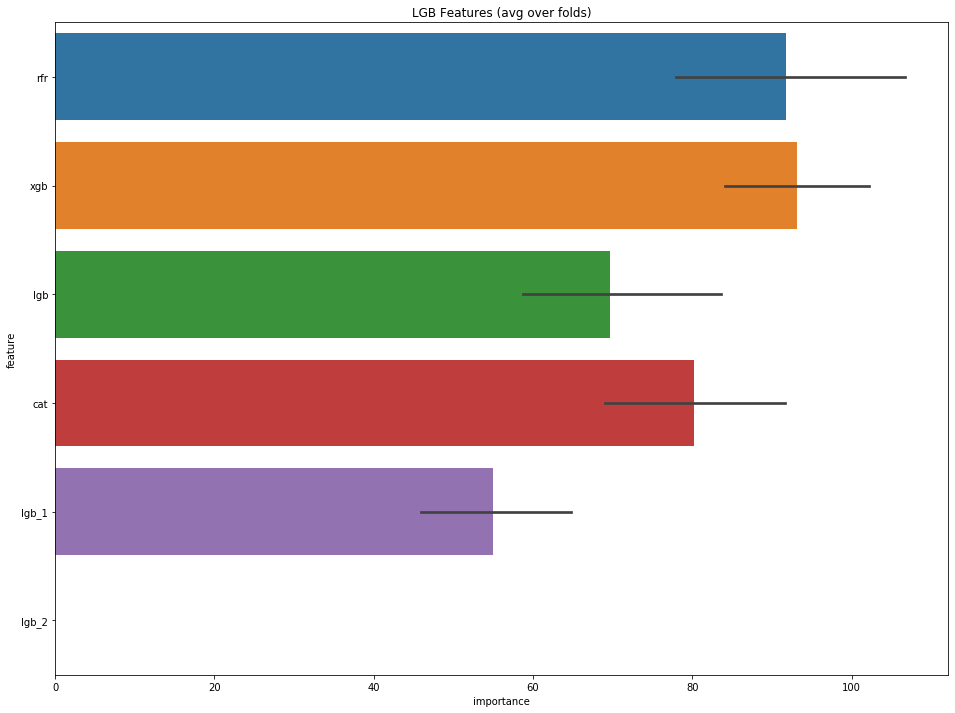

In [120]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:13:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[560]	training's rmse: 2.42728	valid_1's rmse: 2.64822
Fold 1 started at Sun Dec 15 14:13:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[571]	training's rmse: 2.4388	valid_1's rmse: 2.60476
Fold 2 started at Sun Dec 15 14:13:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[755]	training's rmse: 2.36539	valid_1's rmse: 2.501
Fold 3 started at Sun Dec 15 14:13:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[513]	training's rmse: 2.306	valid_1's rmse: 2.47258
Fold 4 started at Sun Dec 15 14:13:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's rmse: 2.431	valid_1's rmse: 2.58871
Fold 5 started at Sun Dec 1

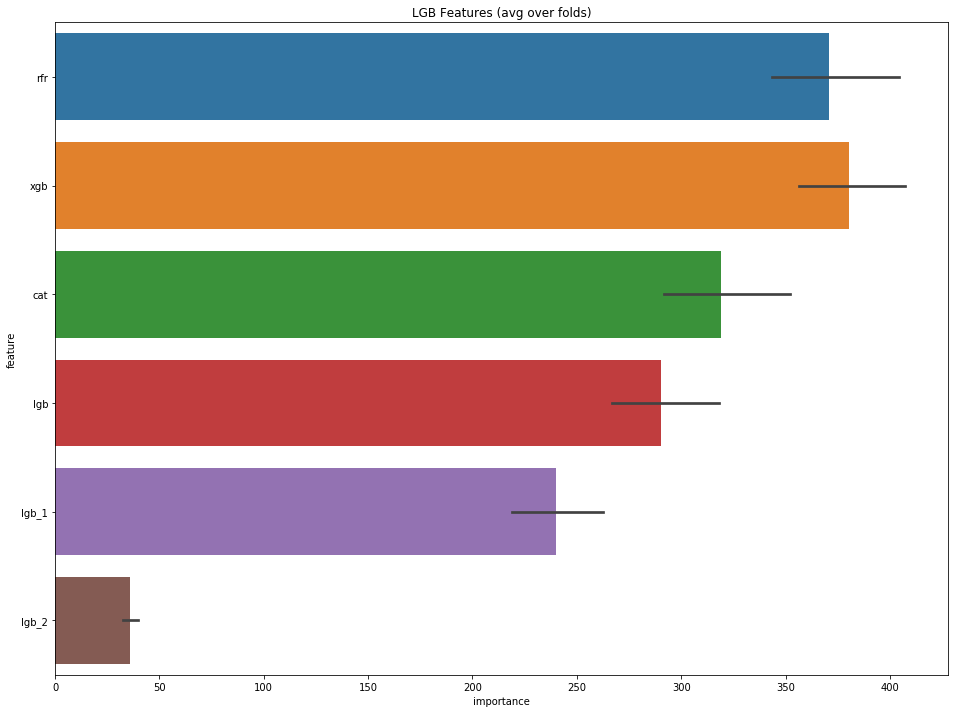

In [121]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [122]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:13:16 2019
Fold 1 started at Sun Dec 15 14:13:41 2019
Fold 2 started at Sun Dec 15 14:13:57 2019
Fold 3 started at Sun Dec 15 14:14:17 2019
Fold 4 started at Sun Dec 15 14:14:26 2019
Fold 5 started at Sun Dec 15 14:14:36 2019
Fold 6 started at Sun Dec 15 14:15:02 2019
Fold 7 started at Sun Dec 15 14:15:17 2019
Fold 8 started at Sun Dec 15 14:15:26 2019
Fold 9 started at Sun Dec 15 14:15:35 2019
CV mean score: 2.5849, std: 0.2098.


random forest做第二层融合模型

In [123]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:15:58 2019
Fold 1 started at Sun Dec 15 14:15:59 2019
Fold 2 started at Sun Dec 15 14:15:59 2019
Fold 3 started at Sun Dec 15 14:15:59 2019
Fold 4 started at Sun Dec 15 14:15:59 2019
Fold 5 started at Sun Dec 15 14:16:00 2019
Fold 6 started at Sun Dec 15 14:16:00 2019
Fold 7 started at Sun Dec 15 14:16:00 2019
Fold 8 started at Sun Dec 15 14:16:00 2019
Fold 9 started at Sun Dec 15 14:16:01 2019
CV mean score: 2.5755, std: 0.1082.


xgboost做第二层融合模型

In [124]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:16:01 2019
[0]	train-rmse:84.5847	valid_data-rmse:84.9418
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.30568	valid_data-rmse:2.71312
[1000]	train-rmse:1.99233	valid_data-rmse:2.63498
Stopping. Best iteration:
[833]	train-rmse:2.07491	valid_data-rmse:2.63049

Fold 1 started at Sun Dec 15 14:16:06 2019
[0]	train-rmse:84.5436	valid_data-rmse:85.3075
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.30651	valid_data-rmse:2.66259
Stopping. Best iteration:
[679]	train-rmse:2.14946	valid_data-rmse:2.58678

Fold 2 started at Sun Dec 15 14:16:10 2019
[0]	train-rmse:84.5267	valid_data-rmse:85.4586
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_dat

#### SVR作为meta

In [125]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:16:42 2019
Fold 1 started at Sun Dec 15 14:16:44 2019
Fold 2 started at Sun Dec 15 14:16:46 2019
Fold 3 started at Sun Dec 15 14:16:48 2019
Fold 4 started at Sun Dec 15 14:16:50 2019
Fold 5 started at Sun Dec 15 14:16:51 2019
Fold 6 started at Sun Dec 15 14:16:53 2019
Fold 7 started at Sun Dec 15 14:16:55 2019
Fold 8 started at Sun Dec 15 14:16:57 2019
Fold 9 started at Sun Dec 15 14:16:59 2019
CV mean score: 6.7078, std: 0.8717.


用岭回归做第二层融合模型

In [126]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:17:01 2019
Fold 1 started at Sun Dec 15 14:17:01 2019
Fold 2 started at Sun Dec 15 14:17:01 2019
Fold 3 started at Sun Dec 15 14:17:01 2019
Fold 4 started at Sun Dec 15 14:17:01 2019
Fold 5 started at Sun Dec 15 14:17:01 2019
Fold 6 started at Sun Dec 15 14:17:01 2019
Fold 7 started at Sun Dec 15 14:17:01 2019
Fold 8 started at Sun Dec 15 14:17:01 2019
Fold 9 started at Sun Dec 15 14:17:02 2019
CV mean score: 2.5505, std: 0.1760.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 14:17:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.52804	valid_1's rmse: 2.66729
Early stopping, best iteration is:
[889]	training's rmse: 2.53502	valid_1's rmse: 2.66357
Fold 1 started at Sun Dec 15 14:17:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.54897	valid_1's rmse: 2.64892
Early stopping, best iteration is:
[838]	training's rmse: 2.55755	valid_1's rmse: 2.64352
Fold 2 started at Sun Dec 15 14:17:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 2.53122	valid_1's rmse: 2.48478
Fold 3 started at Sun Dec 15 14:17:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.51197	valid_1's rmse: 2.42315
Early stopping, best iteration is:
[944]	training's rmse: 2.51436	valid_1's rmse: 2.42253
Fold 4 started at Sun Dec 15 14:17:03 2019
Train

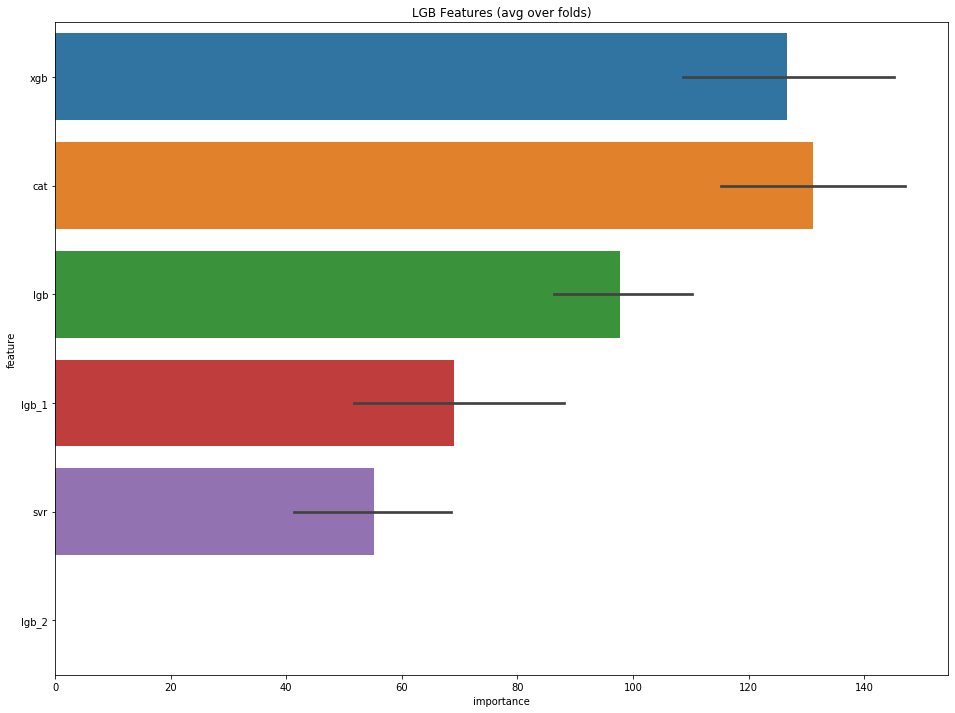

In [127]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:17:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[520]	training's rmse: 2.45416	valid_1's rmse: 2.67822
Fold 1 started at Sun Dec 15 14:17:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[509]	training's rmse: 2.47938	valid_1's rmse: 2.6318
Fold 2 started at Sun Dec 15 14:17:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[502]	training's rmse: 2.43169	valid_1's rmse: 2.48975
Fold 3 started at Sun Dec 15 14:17:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[512]	training's rmse: 2.4282	valid_1's rmse: 2.44578
Fold 4 started at Sun Dec 15 14:17:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[562]	training's rmse: 2.43585	valid_1's rmse: 2.56877
Fold 5 started at Sun 

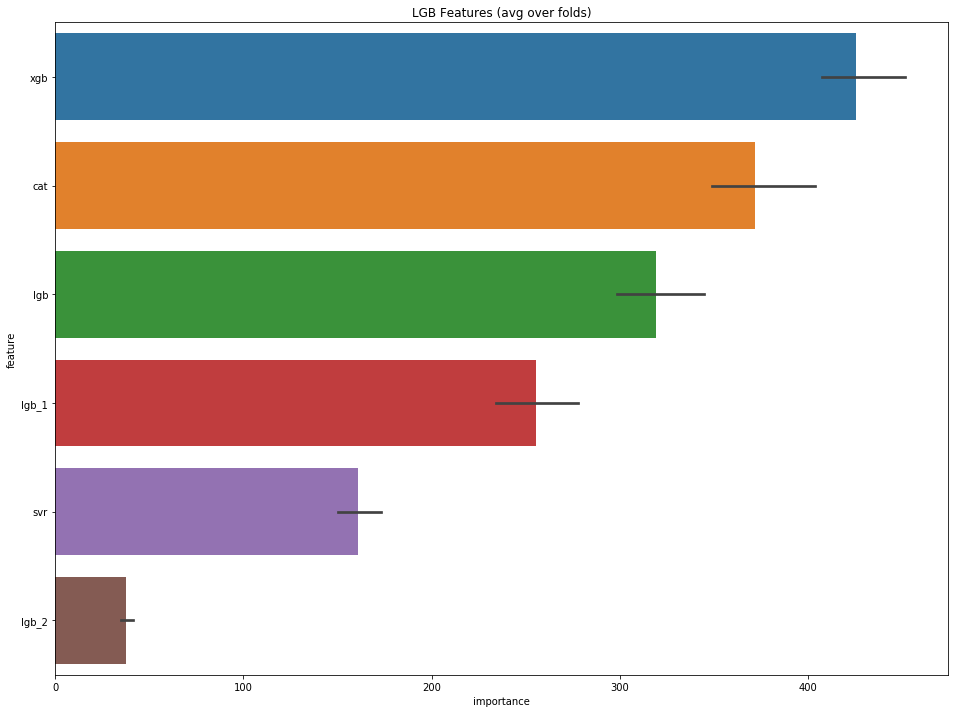

In [128]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [129]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:17:13 2019
Fold 1 started at Sun Dec 15 14:17:30 2019
Fold 2 started at Sun Dec 15 14:17:59 2019
Fold 3 started at Sun Dec 15 14:18:16 2019
Fold 4 started at Sun Dec 15 14:18:22 2019
Fold 5 started at Sun Dec 15 14:18:34 2019
Fold 6 started at Sun Dec 15 14:19:04 2019
Fold 7 started at Sun Dec 15 14:19:10 2019
Fold 8 started at Sun Dec 15 14:19:21 2019
Fold 9 started at Sun Dec 15 14:19:27 2019
CV mean score: 2.6032, std: 0.2173.


random forest做第二层融合模型

In [130]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:19:53 2019
Fold 1 started at Sun Dec 15 14:19:53 2019
Fold 2 started at Sun Dec 15 14:19:53 2019
Fold 3 started at Sun Dec 15 14:19:54 2019
Fold 4 started at Sun Dec 15 14:19:54 2019
Fold 5 started at Sun Dec 15 14:19:54 2019
Fold 6 started at Sun Dec 15 14:19:54 2019
Fold 7 started at Sun Dec 15 14:19:55 2019
Fold 8 started at Sun Dec 15 14:19:55 2019
Fold 9 started at Sun Dec 15 14:19:55 2019
CV mean score: 2.5858, std: 0.1266.


xgboost做第二层融合模型

In [131]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:19:55 2019
[0]	train-rmse:84.5847	valid_data-rmse:84.9418
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.31903	valid_data-rmse:2.7049
Stopping. Best iteration:
[781]	train-rmse:2.1079	valid_data-rmse:2.63764

Fold 1 started at Sun Dec 15 14:20:00 2019
[0]	train-rmse:84.5436	valid_data-rmse:85.3075
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.32031	valid_data-rmse:2.64453
Stopping. Best iteration:
[708]	train-rmse:2.15158	valid_data-rmse:2.57459

Fold 2 started at Sun Dec 15 14:20:04 2019
[0]	train-rmse:84.5267	valid_data-rmse:85.4586
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [132]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:20:35 2019
Fold 1 started at Sun Dec 15 14:20:37 2019
Fold 2 started at Sun Dec 15 14:20:39 2019
Fold 3 started at Sun Dec 15 14:20:41 2019
Fold 4 started at Sun Dec 15 14:20:43 2019
Fold 5 started at Sun Dec 15 14:20:45 2019
Fold 6 started at Sun Dec 15 14:20:47 2019
Fold 7 started at Sun Dec 15 14:20:48 2019
Fold 8 started at Sun Dec 15 14:20:50 2019
Fold 9 started at Sun Dec 15 14:20:52 2019
CV mean score: 5.5316, std: 1.0252.


用岭回归做第二层融合模型

In [133]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:20:54 2019
Fold 1 started at Sun Dec 15 14:20:54 2019
Fold 2 started at Sun Dec 15 14:20:54 2019
Fold 3 started at Sun Dec 15 14:20:54 2019
Fold 4 started at Sun Dec 15 14:20:55 2019
Fold 5 started at Sun Dec 15 14:20:55 2019
Fold 6 started at Sun Dec 15 14:20:55 2019
Fold 7 started at Sun Dec 15 14:20:55 2019
Fold 8 started at Sun Dec 15 14:20:55 2019
Fold 9 started at Sun Dec 15 14:20:55 2019
CV mean score: 2.5515, std: 0.1704.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 14:20:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[757]	training's rmse: 2.5466	valid_1's rmse: 2.67654
Fold 1 started at Sun Dec 15 14:20:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[749]	training's rmse: 2.56614	valid_1's rmse: 2.63215
Fold 2 started at Sun Dec 15 14:20:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[664]	training's rmse: 2.53837	valid_1's rmse: 2.49976
Fold 3 started at Sun Dec 15 14:20:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[505]	training's rmse: 2.44702	valid_1's rmse: 2.42288
Fold 4 started at Sun Dec 15 14:20:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.57512	valid_1's rmse: 2.65015
Early stopping, best iteration is:
[992]	training's rms

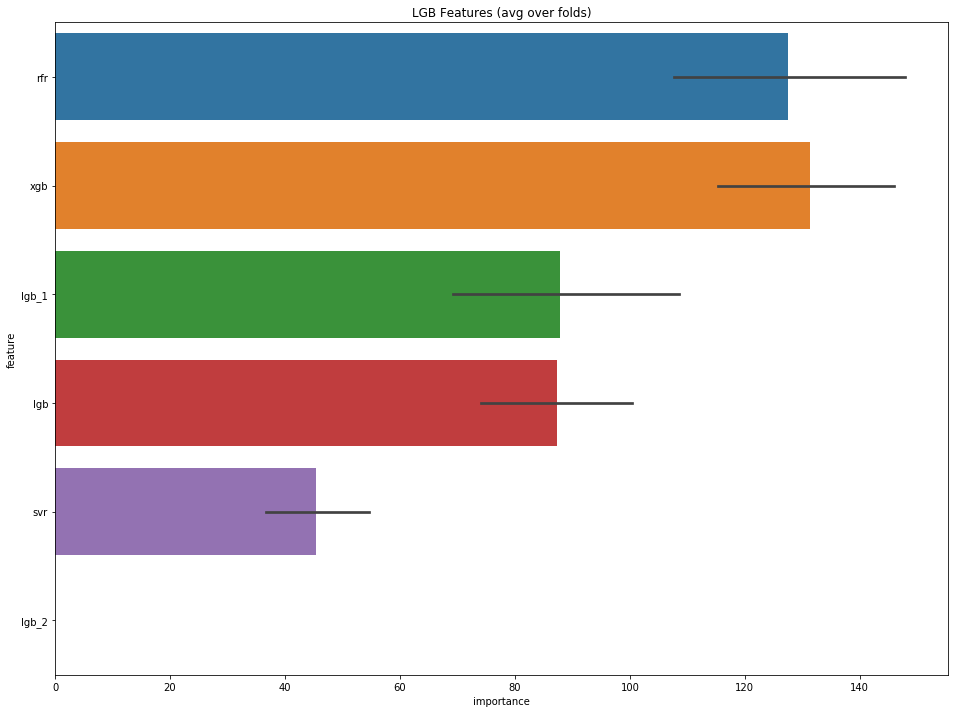

In [134]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:21:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[526]	training's rmse: 2.44678	valid_1's rmse: 2.68288
Fold 1 started at Sun Dec 15 14:21:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[534]	training's rmse: 2.45854	valid_1's rmse: 2.63228
Fold 2 started at Sun Dec 15 14:21:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 2.43579	valid_1's rmse: 2.5244
Fold 3 started at Sun Dec 15 14:21:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[521]	training's rmse: 2.31417	valid_1's rmse: 2.46284
Fold 4 started at Sun Dec 15 14:21:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.37554	valid_1's rmse: 2.66234
Early stopping, best iteration is:
[1492]	training's rm

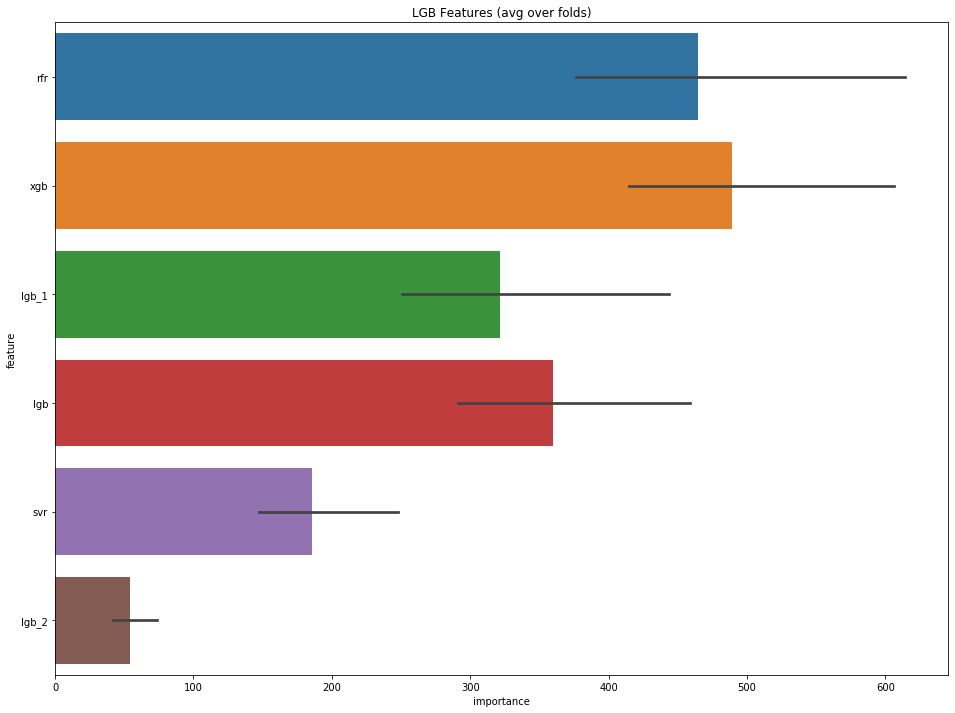

In [135]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:21:09 2019
Fold 1 started at Sun Dec 15 14:21:39 2019
Fold 2 started at Sun Dec 15 14:21:51 2019
Fold 3 started at Sun Dec 15 14:22:16 2019
Fold 4 started at Sun Dec 15 14:22:22 2019
Fold 5 started at Sun Dec 15 14:22:39 2019
Fold 6 started at Sun Dec 15 14:23:02 2019
Fold 7 started at Sun Dec 15 14:23:10 2019
Fold 8 started at Sun Dec 15 14:23:23 2019
Fold 9 started at Sun Dec 15 14:23:33 2019
CV mean score: 2.5986, std: 0.2166.


random forest做第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:23:58 2019
Fold 1 started at Sun Dec 15 14:23:58 2019
Fold 2 started at Sun Dec 15 14:23:58 2019
Fold 3 started at Sun Dec 15 14:23:58 2019
Fold 4 started at Sun Dec 15 14:23:59 2019
Fold 5 started at Sun Dec 15 14:23:59 2019
Fold 6 started at Sun Dec 15 14:23:59 2019
Fold 7 started at Sun Dec 15 14:23:59 2019
Fold 8 started at Sun Dec 15 14:24:00 2019
Fold 9 started at Sun Dec 15 14:24:00 2019
CV mean score: 2.5956, std: 0.1454.


xgboost做第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:24:00 2019
[0]	train-rmse:84.5848	valid_data-rmse:84.9416
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.31402	valid_data-rmse:2.71912
Stopping. Best iteration:
[708]	train-rmse:2.14005	valid_data-rmse:2.65074

Fold 1 started at Sun Dec 15 14:24:04 2019
[0]	train-rmse:84.5437	valid_data-rmse:85.3079
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.3165	valid_data-rmse:2.64527
Stopping. Best iteration:
[723]	train-rmse:2.13002	valid_data-rmse:2.57732

Fold 2 started at Sun Dec 15 14:24:09 2019
[0]	train-rmse:84.5269	valid_data-rmse:85.4584
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:24:40 2019
Fold 1 started at Sun Dec 15 14:24:42 2019
Fold 2 started at Sun Dec 15 14:24:43 2019
Fold 3 started at Sun Dec 15 14:24:45 2019
Fold 4 started at Sun Dec 15 14:24:47 2019
Fold 5 started at Sun Dec 15 14:24:49 2019
Fold 6 started at Sun Dec 15 14:24:51 2019
Fold 7 started at Sun Dec 15 14:24:53 2019
Fold 8 started at Sun Dec 15 14:24:55 2019
Fold 9 started at Sun Dec 15 14:24:57 2019
CV mean score: 4.9577, std: 0.7671.


用岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 14:24:59 2019
Fold 1 started at Sun Dec 15 14:24:59 2019
Fold 2 started at Sun Dec 15 14:24:59 2019
Fold 3 started at Sun Dec 15 14:24:59 2019
Fold 4 started at Sun Dec 15 14:24:59 2019
Fold 5 started at Sun Dec 15 14:24:59 2019
Fold 6 started at Sun Dec 15 14:24:59 2019
Fold 7 started at Sun Dec 15 14:24:59 2019
Fold 8 started at Sun Dec 15 14:24:59 2019
Fold 9 started at Sun Dec 15 14:24:59 2019
CV mean score: 2.5650, std: 0.2105.


### 去掉xgboost

Fold 0 started at Sun Dec 15 14:25:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.53811	valid_1's rmse: 2.70219
Early stopping, best iteration is:
[1015]	training's rmse: 2.5372	valid_1's rmse: 2.70196
Fold 1 started at Sun Dec 15 14:25:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[741]	training's rmse: 2.58079	valid_1's rmse: 2.62325
Fold 2 started at Sun Dec 15 14:25:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[619]	training's rmse: 2.55515	valid_1's rmse: 2.50963
Fold 3 started at Sun Dec 15 14:25:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[491]	training's rmse: 2.46026	valid_1's rmse: 2.45749
Fold 4 started at Sun Dec 15 14:25:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[583]	training's rm

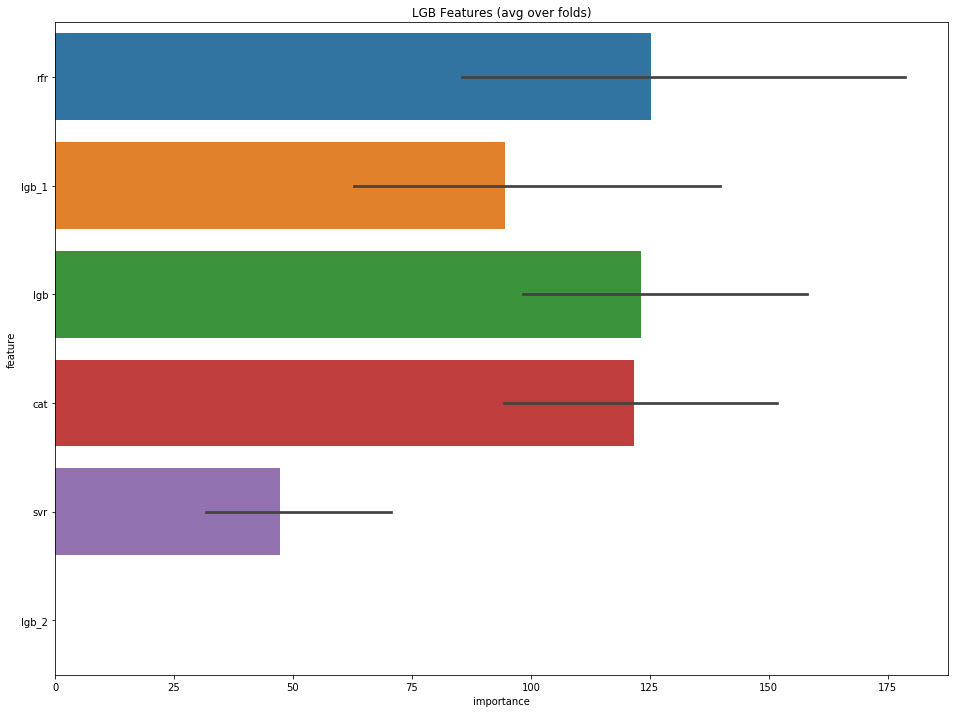

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:25:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[547]	training's rmse: 2.4472	valid_1's rmse: 2.68678
Fold 1 started at Sun Dec 15 14:25:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[524]	training's rmse: 2.48424	valid_1's rmse: 2.6212
Fold 2 started at Sun Dec 15 14:25:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[470]	training's rmse: 2.45352	valid_1's rmse: 2.52288
Fold 3 started at Sun Dec 15 14:25:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[513]	training's rmse: 2.32522	valid_1's rmse: 2.49605
Fold 4 started at Sun Dec 15 14:25:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[754]	training's rmse: 2.39336	valid_1's rmse: 2.60063
Fold 5 started at Sun 

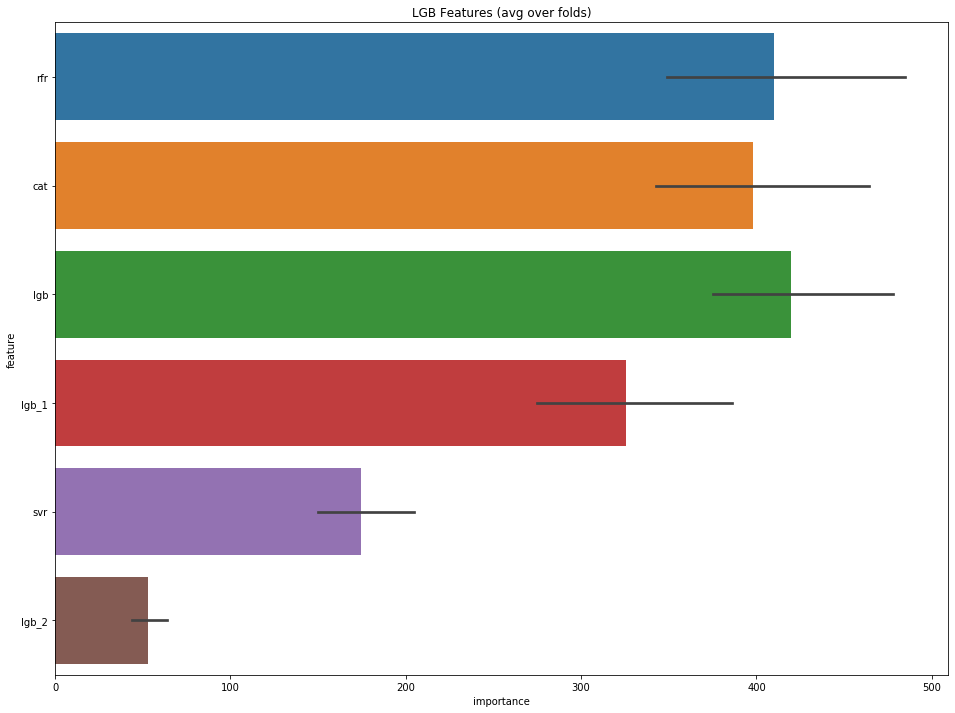

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [143]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:25:18 2019
Fold 1 started at Sun Dec 15 14:25:49 2019
Fold 2 started at Sun Dec 15 14:25:59 2019
Fold 3 started at Sun Dec 15 14:26:12 2019
Fold 4 started at Sun Dec 15 14:26:21 2019
Fold 5 started at Sun Dec 15 14:26:29 2019
Fold 6 started at Sun Dec 15 14:26:50 2019
Fold 7 started at Sun Dec 15 14:27:00 2019
Fold 8 started at Sun Dec 15 14:27:15 2019
Fold 9 started at Sun Dec 15 14:27:25 2019
CV mean score: 2.6108, std: 0.2207.


random forest做第二层融合模型

In [144]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:27:49 2019
Fold 1 started at Sun Dec 15 14:27:50 2019
Fold 2 started at Sun Dec 15 14:27:50 2019
Fold 3 started at Sun Dec 15 14:27:50 2019
Fold 4 started at Sun Dec 15 14:27:50 2019
Fold 5 started at Sun Dec 15 14:27:51 2019
Fold 6 started at Sun Dec 15 14:27:51 2019
Fold 7 started at Sun Dec 15 14:27:51 2019
Fold 8 started at Sun Dec 15 14:27:51 2019
Fold 9 started at Sun Dec 15 14:27:52 2019
CV mean score: 2.6052, std: 0.1046.


xgboost做第二层融合模型

In [145]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:27:52 2019
[0]	train-rmse:84.585	valid_data-rmse:84.9429
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.32958	valid_data-rmse:2.72396
[1000]	train-rmse:2.00441	valid_data-rmse:2.64203
Stopping. Best iteration:
[1009]	train-rmse:2	valid_data-rmse:2.64084

Fold 1 started at Sun Dec 15 14:27:57 2019
[0]	train-rmse:84.5434	valid_data-rmse:85.3068
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.33111	valid_data-rmse:2.6629
Stopping. Best iteration:
[652]	train-rmse:2.18833	valid_data-rmse:2.59877

Fold 2 started at Sun Dec 15 14:28:01 2019
[0]	train-rmse:84.5271	valid_data-rmse:85.4601
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse 

#### SVR作为meta

In [146]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:28:33 2019
Fold 1 started at Sun Dec 15 14:28:35 2019
Fold 2 started at Sun Dec 15 14:28:37 2019
Fold 3 started at Sun Dec 15 14:28:39 2019
Fold 4 started at Sun Dec 15 14:28:41 2019
Fold 5 started at Sun Dec 15 14:28:43 2019
Fold 6 started at Sun Dec 15 14:28:44 2019
Fold 7 started at Sun Dec 15 14:28:46 2019
Fold 8 started at Sun Dec 15 14:28:48 2019
Fold 9 started at Sun Dec 15 14:28:50 2019
CV mean score: 6.5117, std: 0.8575.


用岭回归做第二层融合模型

In [147]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:28:52 2019
Fold 1 started at Sun Dec 15 14:28:52 2019
Fold 2 started at Sun Dec 15 14:28:52 2019
Fold 3 started at Sun Dec 15 14:28:52 2019
Fold 4 started at Sun Dec 15 14:28:52 2019
Fold 5 started at Sun Dec 15 14:28:53 2019
Fold 6 started at Sun Dec 15 14:28:53 2019
Fold 7 started at Sun Dec 15 14:28:53 2019
Fold 8 started at Sun Dec 15 14:28:53 2019
Fold 9 started at Sun Dec 15 14:28:53 2019
CV mean score: 2.5757, std: 0.1819.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 14:28:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.58448	valid_1's rmse: 2.7426
Early stopping, best iteration is:
[1281]	training's rmse: 2.57075	valid_1's rmse: 2.7386
Fold 1 started at Sun Dec 15 14:28:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.58233	valid_1's rmse: 2.69369
Early stopping, best iteration is:
[979]	training's rmse: 2.58343	valid_1's rmse: 2.69338
Fold 2 started at Sun Dec 15 14:28:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[648]	training's rmse: 2.61321	valid_1's rmse: 2.6057
Fold 3 started at Sun Dec 15 14:28:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[539]	training's rmse: 2.44874	valid_1's rmse: 2.42332
Fold 4 started at Sun Dec 15 14:28:54 2019
Training until validation scores don't improve for 200 rounds.


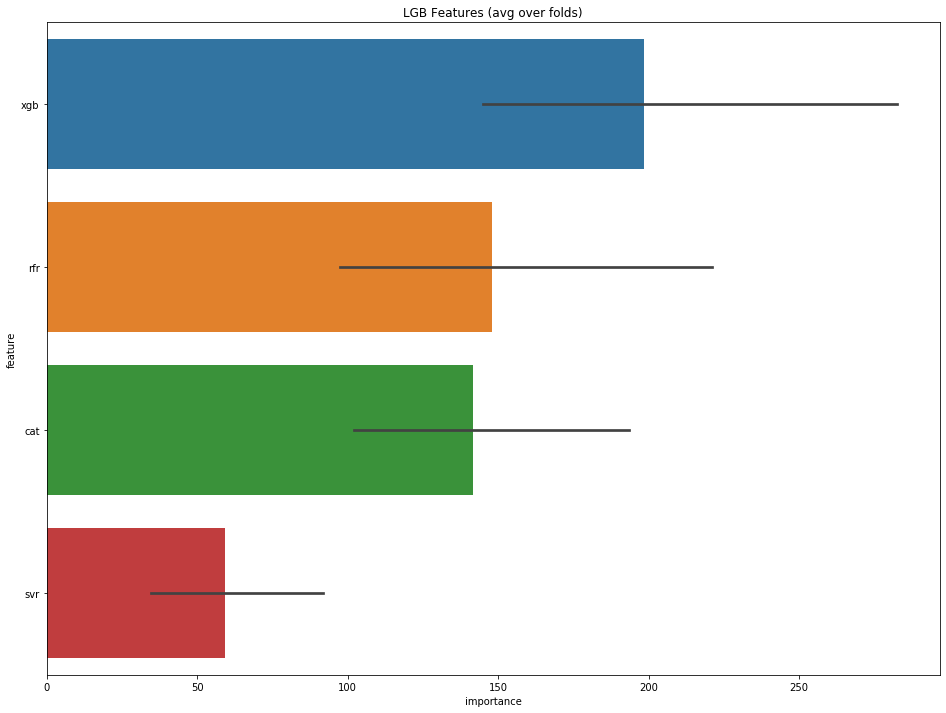

In [148]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:28:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[574]	training's rmse: 2.48077	valid_1's rmse: 2.75381
Fold 1 started at Sun Dec 15 14:28:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[621]	training's rmse: 2.47133	valid_1's rmse: 2.71636
Fold 2 started at Sun Dec 15 14:28:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[757]	training's rmse: 2.44964	valid_1's rmse: 2.60785
Fold 3 started at Sun Dec 15 14:28:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[497]	training's rmse: 2.34537	valid_1's rmse: 2.44154
Fold 4 started at Sun Dec 15 14:29:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[525]	training's rmse: 2.4666	valid_1's rmse: 2.55977
Fold 5 started at Sun

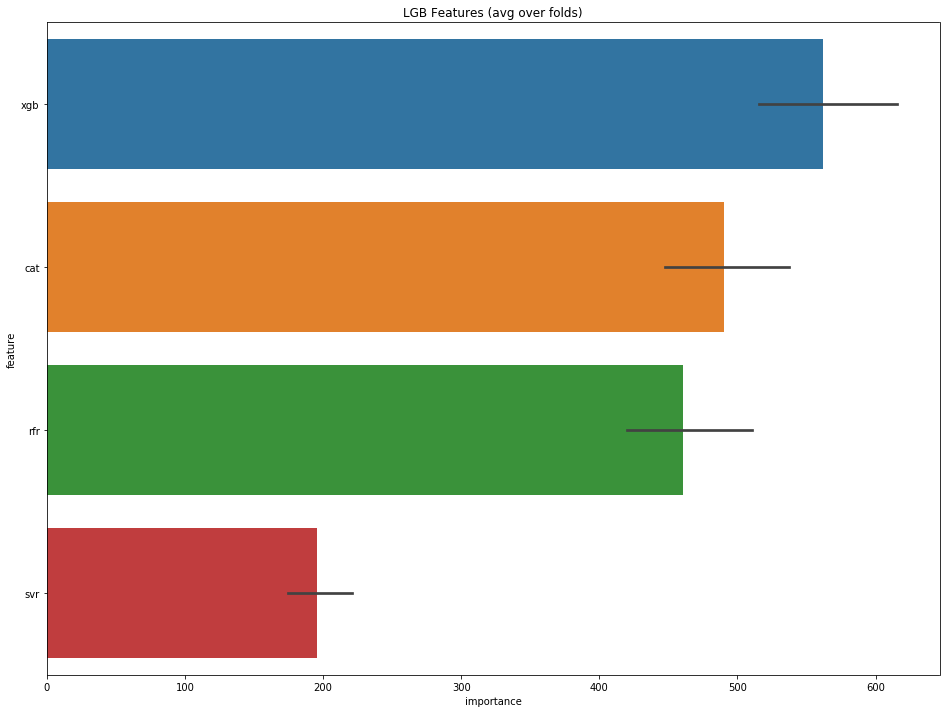

In [149]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [150]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:29:04 2019
Fold 1 started at Sun Dec 15 14:29:25 2019
Fold 2 started at Sun Dec 15 14:29:39 2019
Fold 3 started at Sun Dec 15 14:29:52 2019
Fold 4 started at Sun Dec 15 14:30:05 2019
Fold 5 started at Sun Dec 15 14:30:18 2019
Fold 6 started at Sun Dec 15 14:30:34 2019
Fold 7 started at Sun Dec 15 14:30:43 2019
Fold 8 started at Sun Dec 15 14:31:01 2019
Fold 9 started at Sun Dec 15 14:31:15 2019
CV mean score: 2.6080, std: 0.1882.


random forest做第二层融合模型

In [151]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:31:42 2019
Fold 1 started at Sun Dec 15 14:31:42 2019
Fold 2 started at Sun Dec 15 14:31:42 2019
Fold 3 started at Sun Dec 15 14:31:43 2019
Fold 4 started at Sun Dec 15 14:31:43 2019
Fold 5 started at Sun Dec 15 14:31:43 2019
Fold 6 started at Sun Dec 15 14:31:43 2019
Fold 7 started at Sun Dec 15 14:31:44 2019
Fold 8 started at Sun Dec 15 14:31:44 2019
Fold 9 started at Sun Dec 15 14:31:44 2019
CV mean score: 2.5574, std: 0.0869.


xgboost做第二层融合模型

In [152]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:31:44 2019
[0]	train-rmse:84.5845	valid_data-rmse:84.9425
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.32424	valid_data-rmse:2.67906
Stopping. Best iteration:
[709]	train-rmse:2.15507	valid_data-rmse:2.61248

Fold 1 started at Sun Dec 15 14:31:48 2019
[0]	train-rmse:84.5437	valid_data-rmse:85.3065
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:2.32162	valid_data-rmse:2.6465
Stopping. Best iteration:
[715]	train-rmse:2.14521	valid_data-rmse:2.57597

Fold 2 started at Sun Dec 15 14:31:51 2019
[0]	train-rmse:84.5267	valid_data-rmse:85.4584
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [153]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:32:16 2019
Fold 1 started at Sun Dec 15 14:32:18 2019
Fold 2 started at Sun Dec 15 14:32:20 2019
Fold 3 started at Sun Dec 15 14:32:22 2019
Fold 4 started at Sun Dec 15 14:32:24 2019
Fold 5 started at Sun Dec 15 14:32:25 2019
Fold 6 started at Sun Dec 15 14:32:27 2019
Fold 7 started at Sun Dec 15 14:32:29 2019
Fold 8 started at Sun Dec 15 14:32:31 2019
Fold 9 started at Sun Dec 15 14:32:33 2019
CV mean score: 6.1173, std: 0.7148.


用岭回归做第二层融合模型

In [154]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:32:34 2019
Fold 1 started at Sun Dec 15 14:32:34 2019
Fold 2 started at Sun Dec 15 14:32:35 2019
Fold 3 started at Sun Dec 15 14:32:35 2019
Fold 4 started at Sun Dec 15 14:32:35 2019
Fold 5 started at Sun Dec 15 14:32:35 2019
Fold 6 started at Sun Dec 15 14:32:35 2019
Fold 7 started at Sun Dec 15 14:32:35 2019
Fold 8 started at Sun Dec 15 14:32:35 2019
Fold 9 started at Sun Dec 15 14:32:35 2019
CV mean score: 2.5465, std: 0.1581.


## housing 数据集实验

In [155]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('housing')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [156]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.67244	valid_1's rmse: 3.04928
Early stopping, best iteration is:
[1541]	training's rmse: 1.30694	valid_1's rmse: 2.99591


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [157]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 14:32:36 2019
Fold 1 started at Sun Dec 15 14:32:36 2019
Fold 2 started at Sun Dec 15 14:32:36 2019
Fold 3 started at Sun Dec 15 14:32:36 2019
Fold 4 started at Sun Dec 15 14:32:36 2019
Fold 5 started at Sun Dec 15 14:32:36 2019
Fold 6 started at Sun Dec 15 14:32:36 2019
Fold 7 started at Sun Dec 15 14:32:36 2019
Fold 8 started at Sun Dec 15 14:32:36 2019
Fold 9 started at Sun Dec 15 14:32:36 2019
CV mean score: 9.1245, std: 0.7779.


Fold 0 started at Sun Dec 15 14:32:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.51672	valid_1's rmse: 2.55576
[2000]	training's rmse: 0.933789	valid_1's rmse: 2.39941
[3000]	training's rmse: 0.639714	valid_1's rmse: 2.34406
[4000]	training's rmse: 0.458678	valid_1's rmse: 2.31747
[5000]	training's rmse: 0.341527	valid_1's rmse: 2.3058
[6000]	training's rmse: 0.259717	valid_1's rmse: 2.29588
[7000]	training's rmse: 0.204482	valid_1's rmse: 2.28974
[8000]	training's rmse: 0.164038	valid_1's rmse: 2.28359
[9000]	training's rmse: 0.134403	valid_1's rmse: 2.2781
[10000]	training's rmse: 0.111843	valid_1's rmse: 2.27518
Early stopping, best iteration is:
[10651]	training's rmse: 0.100816	valid_1's rmse: 2.27376
Fold 1 started at Sun Dec 15 14:32:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.5662	valid_1's rmse: 3.30173
[2000]	training's rmse: 0.978967	valid_1's rmse: 3.08003
Early stopping,

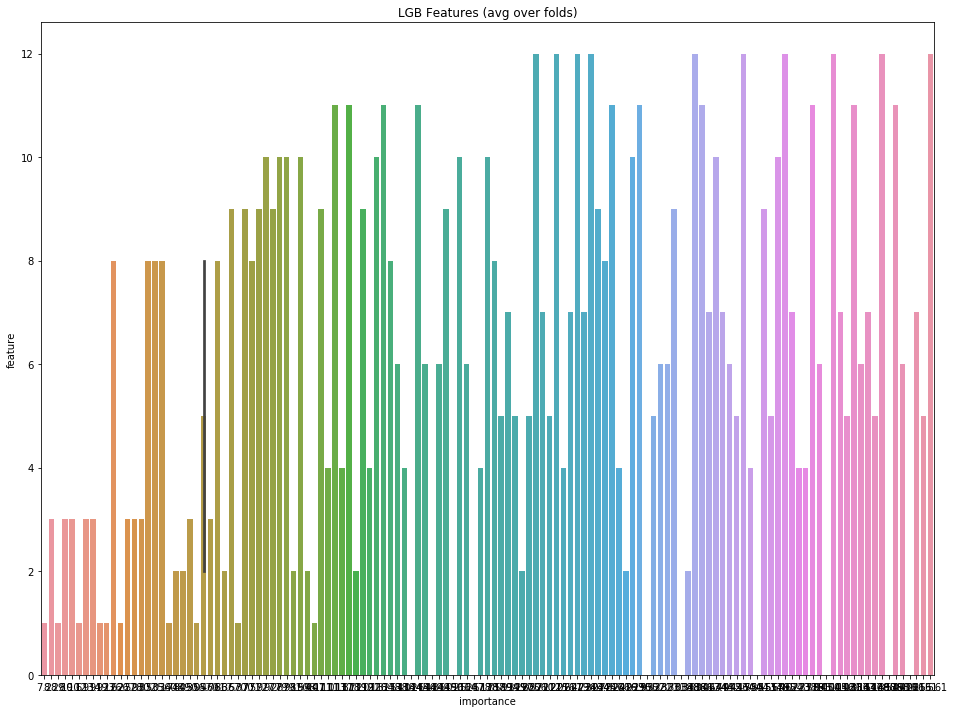

In [158]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:32:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73635	valid_1's rmse: 2.5763
[2000]	training's rmse: 1.1854	valid_1's rmse: 2.39912
[3000]	training's rmse: 0.895723	valid_1's rmse: 2.33818
Early stopping, best iteration is:
[3608]	training's rmse: 0.770595	valid_1's rmse: 2.32185
Fold 1 started at Sun Dec 15 14:32:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.80087	valid_1's rmse: 3.30131
[2000]	training's rmse: 1.23775	valid_1's rmse: 3.0459
Early stopping, best iteration is:
[2368]	training's rmse: 1.10299	valid_1's rmse: 3.0237
Fold 2 started at Sun Dec 15 14:32:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.74808	valid_1's rmse: 2.6974
Early stopping, best iteration is:
[1749]	training's rmse: 1.31311	valid_1's rmse: 2.63436
Fold 3 started at Sun Dec 15 14:32:58 2019
Training until validation scores 

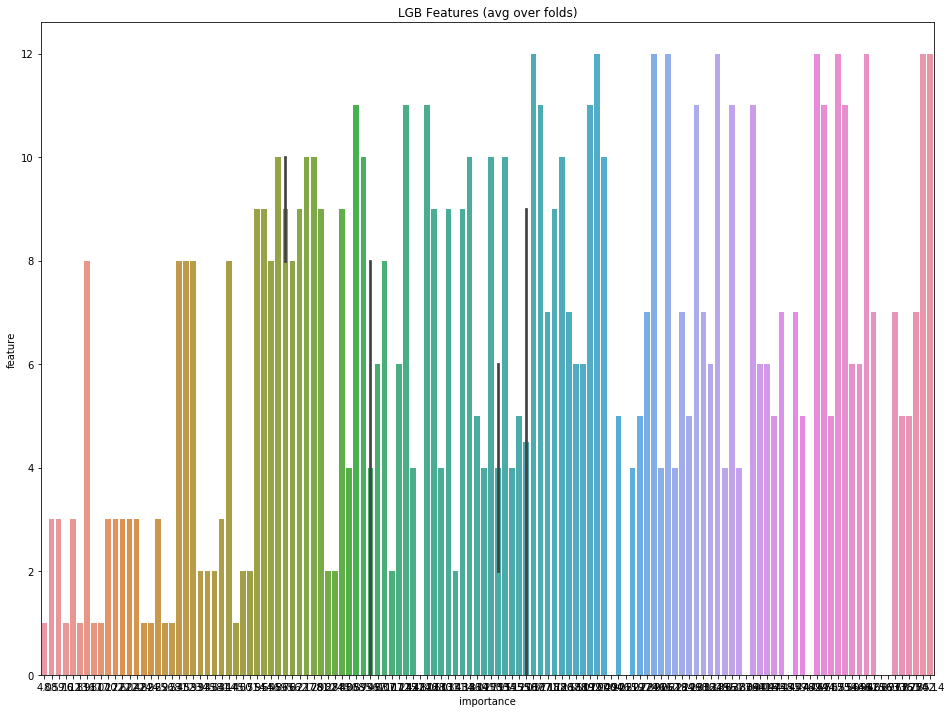

In [159]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:33:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.73635	valid_1's rmse: 2.5763
[2000]	training's rmse: 1.1854	valid_1's rmse: 2.39912
[3000]	training's rmse: 0.895723	valid_1's rmse: 2.33818
Early stopping, best iteration is:
[3608]	training's rmse: 0.770595	valid_1's rmse: 2.32185
Fold 1 started at Sun Dec 15 14:33:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.80087	valid_1's rmse: 3.30131
[2000]	training's rmse: 1.23775	valid_1's rmse: 3.0459
Early stopping, best iteration is:
[2368]	training's rmse: 1.10299	valid_1's rmse: 3.0237
Fold 2 started at Sun Dec 15 14:33:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.74808	valid_1's rmse: 2.6974
Early stopping, best iteration is:
[1749]	training's rmse: 1.31311	valid_1's rmse: 2.63436
Fold 3 started at Sun Dec 15 14:33:13 2019
Training until validation scores 

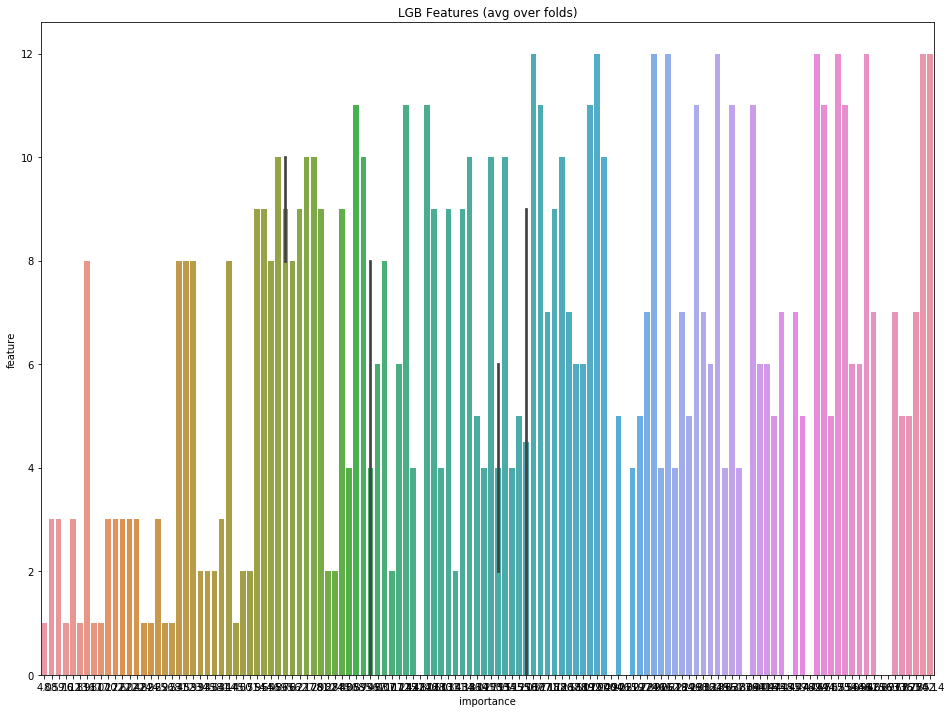

In [160]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [161]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 14:33:25 2019
Fold 1 started at Sun Dec 15 14:33:26 2019
Fold 2 started at Sun Dec 15 14:33:26 2019
Fold 3 started at Sun Dec 15 14:33:26 2019
Fold 4 started at Sun Dec 15 14:33:26 2019
Fold 5 started at Sun Dec 15 14:33:27 2019
Fold 6 started at Sun Dec 15 14:33:27 2019
Fold 7 started at Sun Dec 15 14:33:27 2019
Fold 8 started at Sun Dec 15 14:33:27 2019
Fold 9 started at Sun Dec 15 14:33:28 2019
CV mean score: 3.7120, std: 0.6633.


In [162]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:33:28 2019
[0]	train-rmse:23.8409	valid_data-rmse:21.8451
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.88808	valid_data-rmse:2.17502
[1000]	train-rmse:0.301024	valid_data-rmse:2.13631
[1500]	train-rmse:0.114484	valid_data-rmse:2.1289
[2000]	train-rmse:0.047412	valid_data-rmse:2.12458
Stopping. Best iteration:
[2270]	train-rmse:0.02959	valid_data-rmse:2.12388

Fold 1 started at Sun Dec 15 14:33:30 2019
[0]	train-rmse:23.7119	valid_data-rmse:23.053
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.920316	valid_data-rmse:2.90207
[1000]	train-rmse:0.31605	valid_data-rmse:2.74335
[1500]	train-rmse:0.119593	valid_data-rmse:2.72775
Stopping. Best iteration:
[1509]	train-rmse:0.117768	valid_data-rmse:2.72755

Fo

In [163]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:33:44 2019
Fold 1 started at Sun Dec 15 14:33:55 2019
Fold 2 started at Sun Dec 15 14:34:13 2019
Fold 3 started at Sun Dec 15 14:34:26 2019
Fold 4 started at Sun Dec 15 14:34:40 2019
Fold 5 started at Sun Dec 15 14:34:50 2019
Fold 6 started at Sun Dec 15 14:35:00 2019
Fold 7 started at Sun Dec 15 14:35:05 2019
Fold 8 started at Sun Dec 15 14:35:20 2019
Fold 9 started at Sun Dec 15 14:35:39 2019
CV mean score: 2.8985, std: 0.4331.


## stacking

Fold 0 started at Sun Dec 15 14:35:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.17474	valid_1's rmse: 2.18066
Early stopping, best iteration is:
[842]	training's rmse: 2.22018	valid_1's rmse: 2.16714
Fold 1 started at Sun Dec 15 14:35:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.10845	valid_1's rmse: 2.81852
Early stopping, best iteration is:
[1319]	training's rmse: 2.02906	valid_1's rmse: 2.79049
Fold 2 started at Sun Dec 15 14:35:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.4102	valid_1's rmse: 2.61577
Fold 3 started at Sun Dec 15 14:35:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[422]	training's rmse: 2.34708	valid_1's rmse: 2.79466
Fold 4 started at Sun Dec 15 14:35:57 2019
Training until validation scores don't improve for 200 rounds

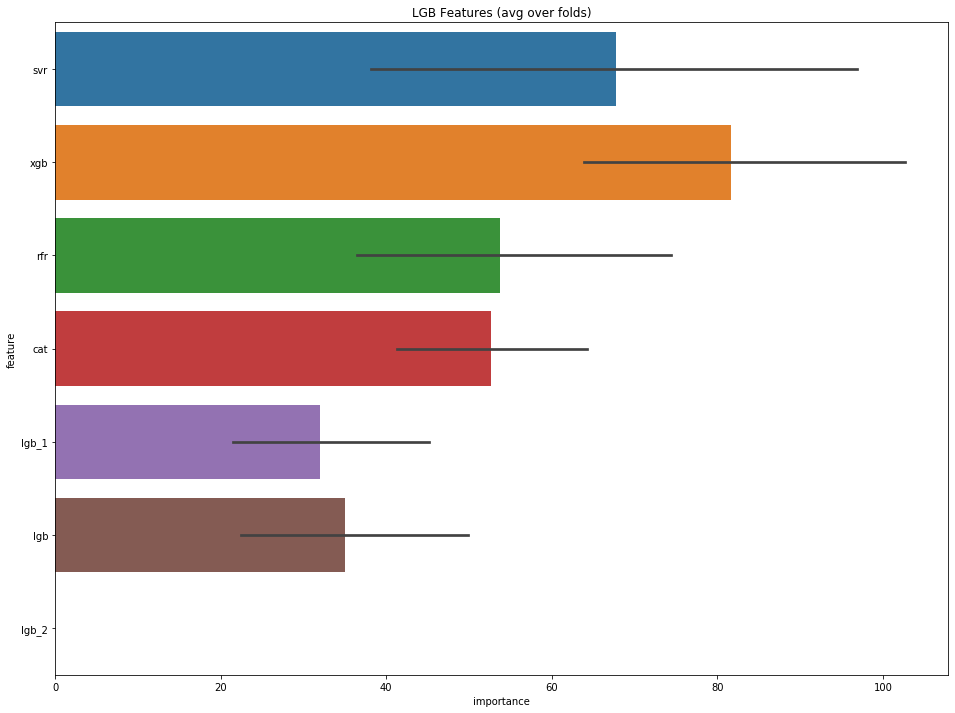

In [164]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:35:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.19363	valid_1's rmse: 2.20301
Fold 1 started at Sun Dec 15 14:35:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[757]	training's rmse: 1.85394	valid_1's rmse: 2.98387
Fold 2 started at Sun Dec 15 14:36:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 2.32906	valid_1's rmse: 2.65366
Fold 3 started at Sun Dec 15 14:36:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[408]	training's rmse: 2.13525	valid_1's rmse: 2.90624
Fold 4 started at Sun Dec 15 14:36:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's rmse: 2.56748	valid_1's rmse: 4.16189
Fold 5 started at Su

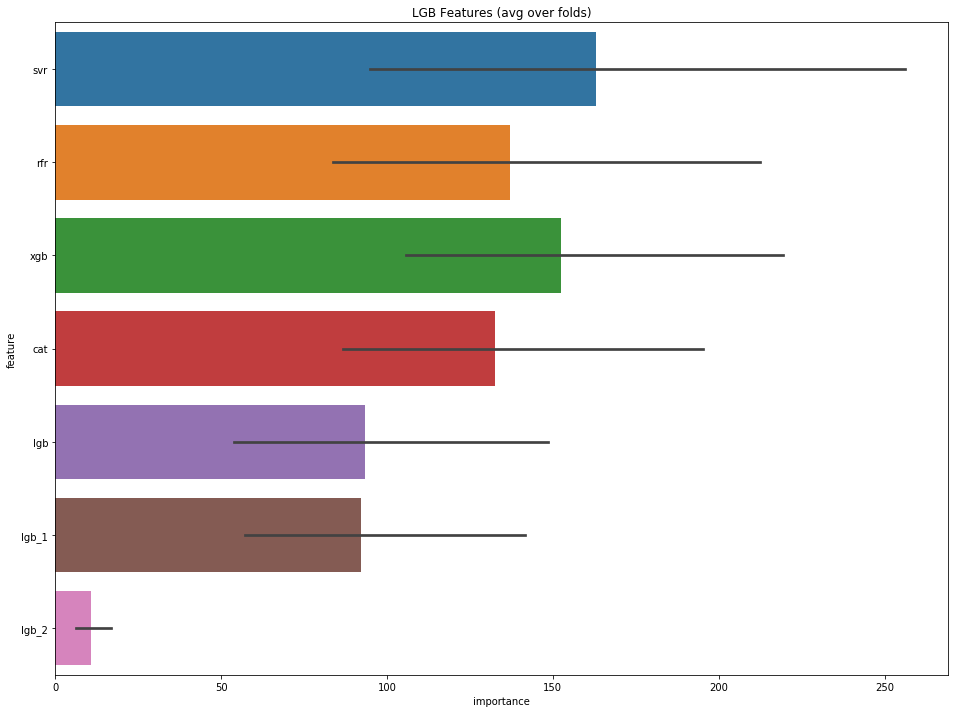

In [165]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [166]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:36:03 2019
Fold 1 started at Sun Dec 15 14:36:06 2019
Fold 2 started at Sun Dec 15 14:36:08 2019
Fold 3 started at Sun Dec 15 14:36:10 2019
Fold 4 started at Sun Dec 15 14:36:13 2019
Fold 5 started at Sun Dec 15 14:36:15 2019
Fold 6 started at Sun Dec 15 14:36:16 2019
Fold 7 started at Sun Dec 15 14:36:19 2019
Fold 8 started at Sun Dec 15 14:36:21 2019
Fold 9 started at Sun Dec 15 14:36:25 2019
CV mean score: 2.8970, std: 0.5130.


random forest做第二层融合模型

In [167]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:36:28 2019
Fold 1 started at Sun Dec 15 14:36:28 2019
Fold 2 started at Sun Dec 15 14:36:28 2019
Fold 3 started at Sun Dec 15 14:36:28 2019
Fold 4 started at Sun Dec 15 14:36:29 2019
Fold 5 started at Sun Dec 15 14:36:29 2019
Fold 6 started at Sun Dec 15 14:36:29 2019
Fold 7 started at Sun Dec 15 14:36:29 2019
Fold 8 started at Sun Dec 15 14:36:29 2019
Fold 9 started at Sun Dec 15 14:36:30 2019
CV mean score: 2.9187, std: 0.5120.


xgboost做第二层融合模型

In [168]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:36:30 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8402
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.14648	valid_data-rmse:2.27851
Stopping. Best iteration:
[691]	train-rmse:0.852884	valid_data-rmse:2.23778

Fold 1 started at Sun Dec 15 14:36:30 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0493
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.13642	valid_data-rmse:2.87006
Stopping. Best iteration:
[720]	train-rmse:0.779105	valid_data-rmse:2.85382

Fold 2 started at Sun Dec 15 14:36:31 2019
[0]	train-rmse:23.7738	valid_data-rmse:22.4244
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	trai

#### SVR作为meta

In [169]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:36:33 2019
Fold 1 started at Sun Dec 15 14:36:33 2019
Fold 2 started at Sun Dec 15 14:36:33 2019
Fold 3 started at Sun Dec 15 14:36:34 2019
Fold 4 started at Sun Dec 15 14:36:34 2019
Fold 5 started at Sun Dec 15 14:36:34 2019
Fold 6 started at Sun Dec 15 14:36:34 2019
Fold 7 started at Sun Dec 15 14:36:34 2019
Fold 8 started at Sun Dec 15 14:36:34 2019
Fold 9 started at Sun Dec 15 14:36:34 2019
CV mean score: 7.2888, std: 0.7907.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 14:36:34 2019
Fold 1 started at Sun Dec 15 14:36:34 2019
Fold 2 started at Sun Dec 15 14:36:34 2019
Fold 3 started at Sun Dec 15 14:36:34 2019
Fold 4 started at Sun Dec 15 14:36:34 2019
Fold 5 started at Sun Dec 15 14:36:34 2019
Fold 6 started at Sun Dec 15 14:36:34 2019
Fold 7 started at Sun Dec 15 14:36:34 2019
Fold 8 started at Sun Dec 15 14:36:34 2019
Fold 9 started at Sun Dec 15 14:36:34 2019
CV mean score: 2.8664, std: 0.5468.
Fold 0 started at Sun Dec 15 14:36:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[668]	training's rmse: 2.38682	valid_1's rmse: 2.19808
Fold 1 started at Sun Dec 15 14:36:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[500]	training's rmse: 2.38218	valid_1's rmse: 2.91164
Fold 2 started at Sun Dec 15 14:36:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

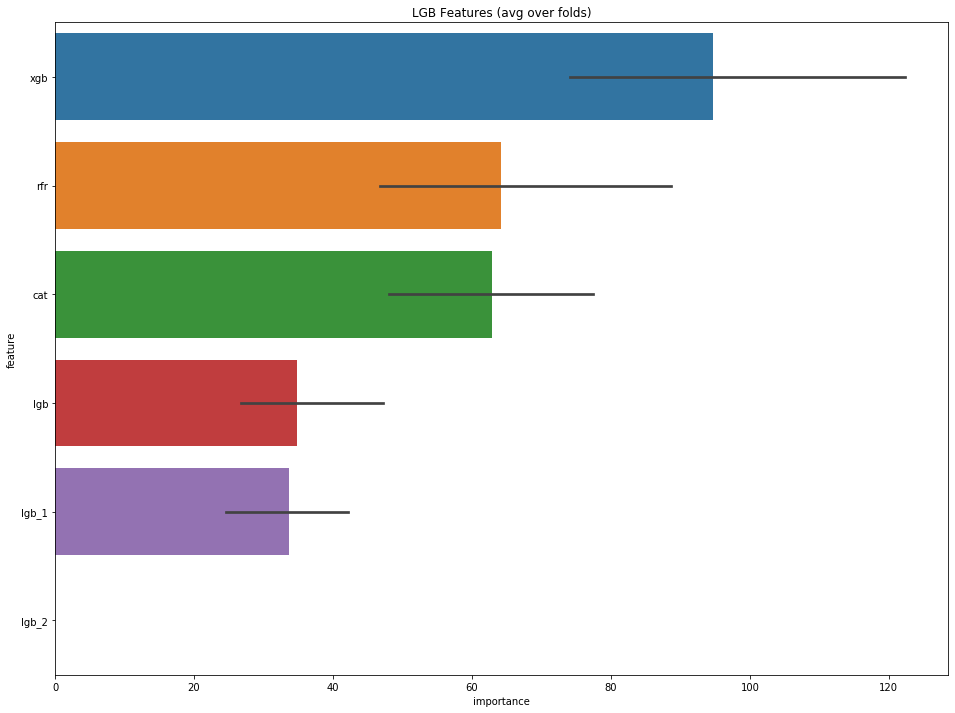

In [170]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:36:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[419]	training's rmse: 2.31255	valid_1's rmse: 2.26786
Fold 1 started at Sun Dec 15 14:36:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[714]	training's rmse: 2.06566	valid_1's rmse: 2.90572
Fold 2 started at Sun Dec 15 14:36:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[325]	training's rmse: 2.34162	valid_1's rmse: 2.65007
Fold 3 started at Sun Dec 15 14:36:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[485]	training's rmse: 2.19823	valid_1's rmse: 2.91676
Fold 4 started at Sun Dec 15 14:36:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[196]	training's rmse: 2.57573	valid_1's rmse: 4.14636
Fold 5 started at Su

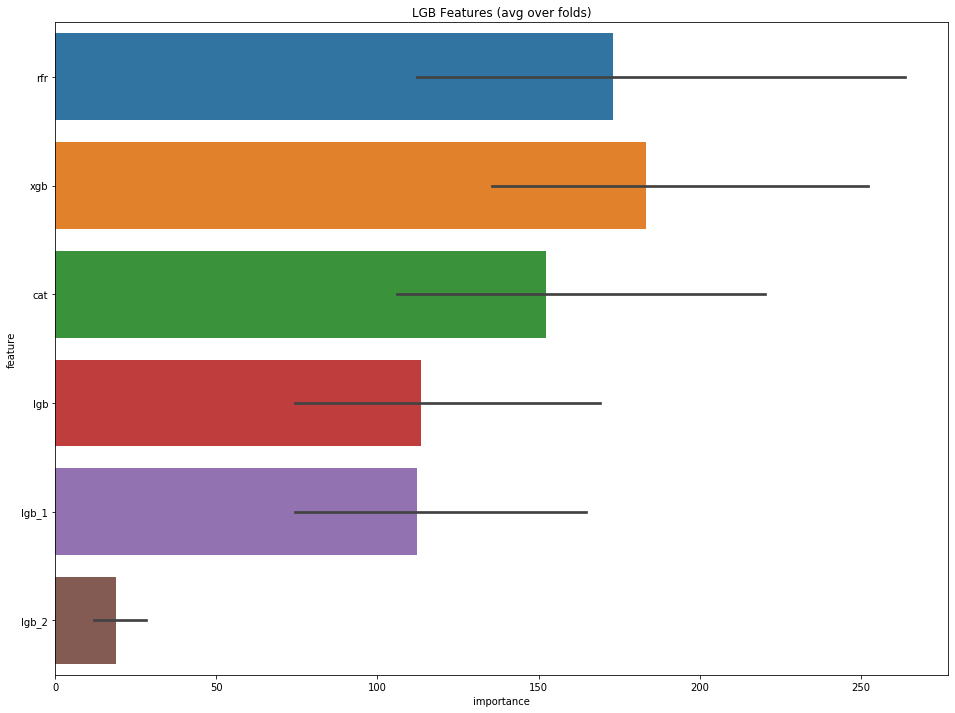

In [171]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [172]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:36:42 2019
Fold 1 started at Sun Dec 15 14:36:45 2019
Fold 2 started at Sun Dec 15 14:36:49 2019
Fold 3 started at Sun Dec 15 14:36:51 2019
Fold 4 started at Sun Dec 15 14:36:54 2019
Fold 5 started at Sun Dec 15 14:36:55 2019
Fold 6 started at Sun Dec 15 14:36:56 2019
Fold 7 started at Sun Dec 15 14:36:59 2019
Fold 8 started at Sun Dec 15 14:37:00 2019
Fold 9 started at Sun Dec 15 14:37:04 2019
CV mean score: 2.8926, std: 0.5440.


random forest做第二层融合模型

In [173]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:37:06 2019
Fold 1 started at Sun Dec 15 14:37:06 2019
Fold 2 started at Sun Dec 15 14:37:07 2019
Fold 3 started at Sun Dec 15 14:37:07 2019
Fold 4 started at Sun Dec 15 14:37:07 2019
Fold 5 started at Sun Dec 15 14:37:07 2019
Fold 6 started at Sun Dec 15 14:37:08 2019
Fold 7 started at Sun Dec 15 14:37:08 2019
Fold 8 started at Sun Dec 15 14:37:08 2019
Fold 9 started at Sun Dec 15 14:37:08 2019
CV mean score: 2.9128, std: 0.5345.


xgboost做第二层融合模型

In [174]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:37:09 2019
[0]	train-rmse:23.8348	valid_data-rmse:21.8402
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25502	valid_data-rmse:2.32141
Stopping. Best iteration:
[562]	train-rmse:1.14997	valid_data-rmse:2.31132

Fold 1 started at Sun Dec 15 14:37:09 2019
[0]	train-rmse:23.7077	valid_data-rmse:23.0493
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24412	valid_data-rmse:2.85644
Stopping. Best iteration:
[680]	train-rmse:0.967581	valid_data-rmse:2.80917

Fold 2 started at Sun Dec 15 14:37:09 2019
[0]	train-rmse:23.7743	valid_data-rmse:22.4255
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train

#### SVR作为meta

In [175]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:37:12 2019
Fold 1 started at Sun Dec 15 14:37:12 2019
Fold 2 started at Sun Dec 15 14:37:12 2019
Fold 3 started at Sun Dec 15 14:37:12 2019
Fold 4 started at Sun Dec 15 14:37:12 2019
Fold 5 started at Sun Dec 15 14:37:12 2019
Fold 6 started at Sun Dec 15 14:37:12 2019
Fold 7 started at Sun Dec 15 14:37:12 2019
Fold 8 started at Sun Dec 15 14:37:12 2019
Fold 9 started at Sun Dec 15 14:37:12 2019
CV mean score: 7.3697, std: 0.7889.


用岭回归做第二层融合模型

In [176]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:37:12 2019
Fold 1 started at Sun Dec 15 14:37:12 2019
Fold 2 started at Sun Dec 15 14:37:12 2019
Fold 3 started at Sun Dec 15 14:37:13 2019
Fold 4 started at Sun Dec 15 14:37:13 2019
Fold 5 started at Sun Dec 15 14:37:13 2019
Fold 6 started at Sun Dec 15 14:37:13 2019
Fold 7 started at Sun Dec 15 14:37:13 2019
Fold 8 started at Sun Dec 15 14:37:13 2019
Fold 9 started at Sun Dec 15 14:37:14 2019
CV mean score: 2.8666, std: 0.5468.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 14:37:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.4238	valid_1's rmse: 2.24586
Fold 1 started at Sun Dec 15 14:37:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 2.43952	valid_1's rmse: 3.01339
Fold 2 started at Sun Dec 15 14:37:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[308]	training's rmse: 2.46649	valid_1's rmse: 2.83451
Fold 3 started at Sun Dec 15 14:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 2.40972	valid_1's rmse: 2.92075
Fold 4 started at Sun Dec 15 14:37:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[197]	training's rmse: 2.68442	valid_1's rmse: 4.227
Fold 5 started at Sun D

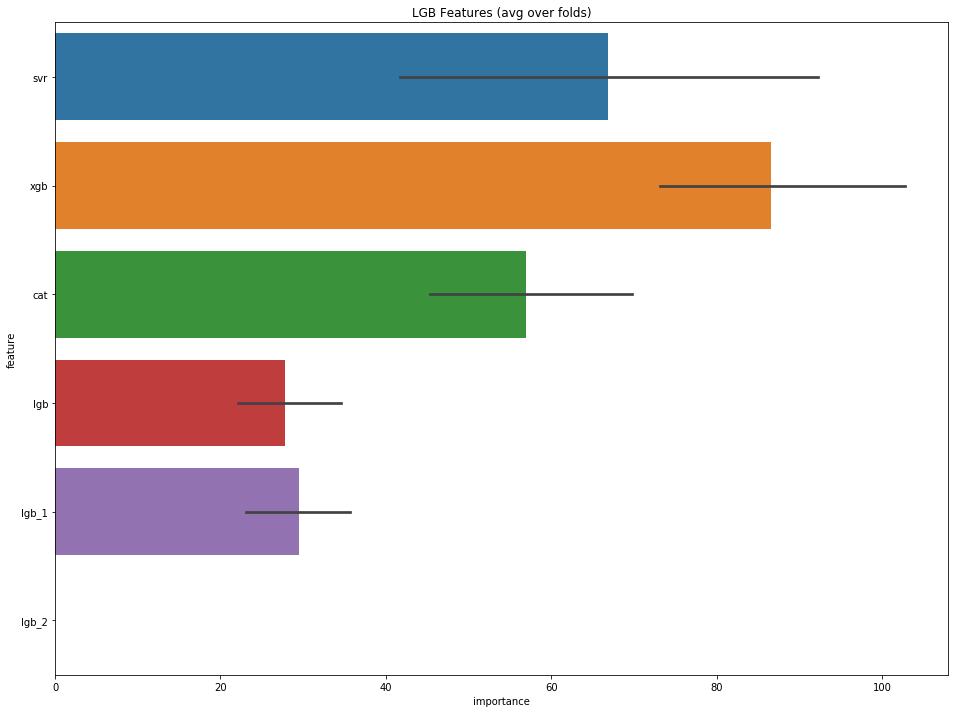

In [177]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:37:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[433]	training's rmse: 2.23262	valid_1's rmse: 2.25578
Fold 1 started at Sun Dec 15 14:37:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[349]	training's rmse: 2.26337	valid_1's rmse: 3.01966
Fold 2 started at Sun Dec 15 14:37:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[296]	training's rmse: 2.35432	valid_1's rmse: 2.83974
Fold 3 started at Sun Dec 15 14:37:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[591]	training's rmse: 2.06979	valid_1's rmse: 2.98598
Fold 4 started at Sun Dec 15 14:37:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[193]	training's rmse: 2.61262	valid_1's rmse: 4.17392
Fold 5 started at Su

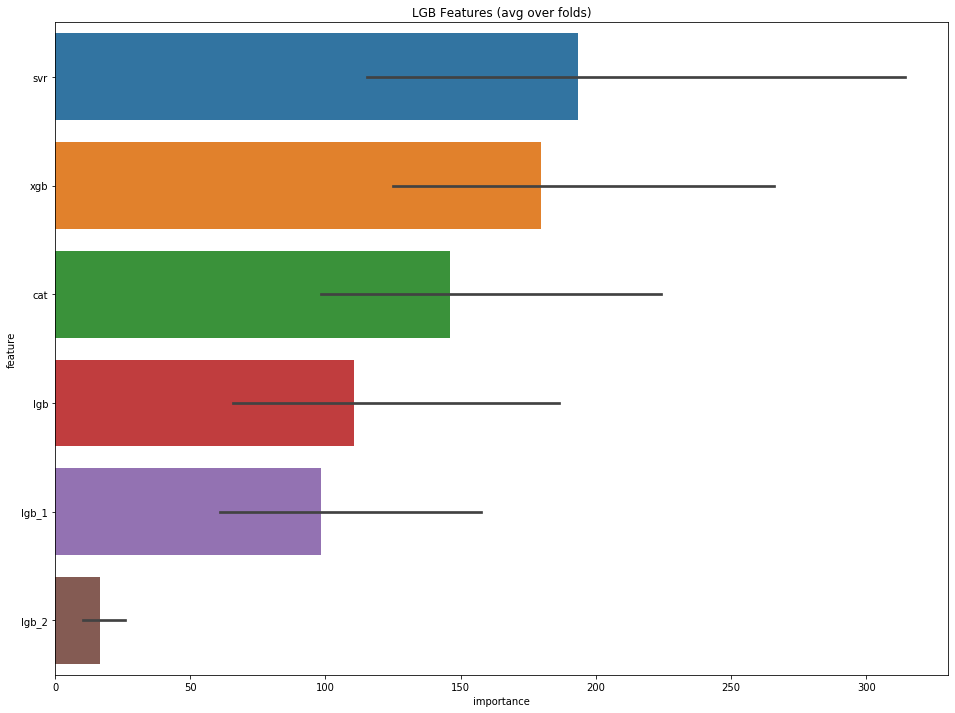

In [178]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [179]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:37:21 2019
Fold 1 started at Sun Dec 15 14:37:24 2019
Fold 2 started at Sun Dec 15 14:37:28 2019
Fold 3 started at Sun Dec 15 14:37:30 2019
Fold 4 started at Sun Dec 15 14:37:32 2019
Fold 5 started at Sun Dec 15 14:37:34 2019
Fold 6 started at Sun Dec 15 14:37:36 2019
Fold 7 started at Sun Dec 15 14:37:38 2019
Fold 8 started at Sun Dec 15 14:37:40 2019
Fold 9 started at Sun Dec 15 14:37:42 2019
CV mean score: 2.8866, std: 0.4837.


random forest做第二层融合模型

In [180]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:37:44 2019
Fold 1 started at Sun Dec 15 14:37:44 2019
Fold 2 started at Sun Dec 15 14:37:44 2019
Fold 3 started at Sun Dec 15 14:37:44 2019
Fold 4 started at Sun Dec 15 14:37:45 2019
Fold 5 started at Sun Dec 15 14:37:45 2019
Fold 6 started at Sun Dec 15 14:37:45 2019
Fold 7 started at Sun Dec 15 14:37:45 2019
Fold 8 started at Sun Dec 15 14:37:46 2019
Fold 9 started at Sun Dec 15 14:37:46 2019
CV mean score: 2.9147, std: 0.5280.


xgboost做第二层融合模型

In [181]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:37:46 2019
[0]	train-rmse:23.835	valid_data-rmse:21.8392
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25545	valid_data-rmse:2.30763
Stopping. Best iteration:
[695]	train-rmse:0.94294	valid_data-rmse:2.27974

Fold 1 started at Sun Dec 15 14:37:47 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0488
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23263	valid_data-rmse:2.91826
Stopping. Best iteration:
[626]	train-rmse:0.995686	valid_data-rmse:2.9132

Fold 2 started at Sun Dec 15 14:37:47 2019
[0]	train-rmse:23.7737	valid_data-rmse:22.425
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [182]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:37:50 2019
Fold 1 started at Sun Dec 15 14:37:50 2019
Fold 2 started at Sun Dec 15 14:37:50 2019
Fold 3 started at Sun Dec 15 14:37:50 2019
Fold 4 started at Sun Dec 15 14:37:50 2019
Fold 5 started at Sun Dec 15 14:37:50 2019
Fold 6 started at Sun Dec 15 14:37:50 2019
Fold 7 started at Sun Dec 15 14:37:50 2019
Fold 8 started at Sun Dec 15 14:37:50 2019
Fold 9 started at Sun Dec 15 14:37:50 2019
CV mean score: 7.0577, std: 0.7153.


用岭回归做第二层融合模型

In [183]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:37:50 2019
Fold 1 started at Sun Dec 15 14:37:50 2019
Fold 2 started at Sun Dec 15 14:37:50 2019
Fold 3 started at Sun Dec 15 14:37:50 2019
Fold 4 started at Sun Dec 15 14:37:50 2019
Fold 5 started at Sun Dec 15 14:37:50 2019
Fold 6 started at Sun Dec 15 14:37:50 2019
Fold 7 started at Sun Dec 15 14:37:50 2019
Fold 8 started at Sun Dec 15 14:37:50 2019
Fold 9 started at Sun Dec 15 14:37:50 2019
CV mean score: 2.8418, std: 0.5073.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 14:37:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[636]	training's rmse: 2.37629	valid_1's rmse: 2.12836
Fold 1 started at Sun Dec 15 14:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[741]	training's rmse: 2.28162	valid_1's rmse: 2.56395
Fold 2 started at Sun Dec 15 14:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[369]	training's rmse: 2.43775	valid_1's rmse: 2.76888
Fold 3 started at Sun Dec 15 14:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[407]	training's rmse: 2.41083	valid_1's rmse: 2.69967
Fold 4 started at Sun Dec 15 14:37:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[191]	training's rmse: 2.69794	valid_1's rmse: 4.20677
Fold 5 started at Su

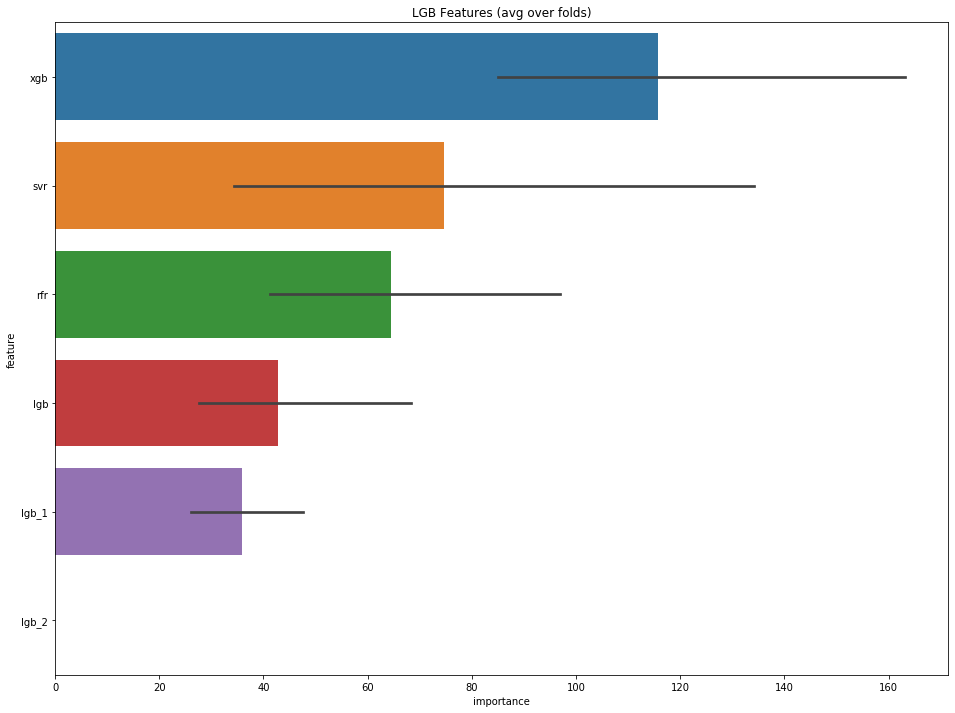

In [184]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:37:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[418]	training's rmse: 2.29195	valid_1's rmse: 2.19018
Fold 1 started at Sun Dec 15 14:37:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[739]	training's rmse: 1.98154	valid_1's rmse: 2.62161
Fold 2 started at Sun Dec 15 14:37:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[323]	training's rmse: 2.33983	valid_1's rmse: 2.74445
Fold 3 started at Sun Dec 15 14:37:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[418]	training's rmse: 2.20976	valid_1's rmse: 2.85586
Fold 4 started at Sun Dec 15 14:37:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[192]	training's rmse: 2.60211	valid_1's rmse: 4.18236
Fold 5 started at Su

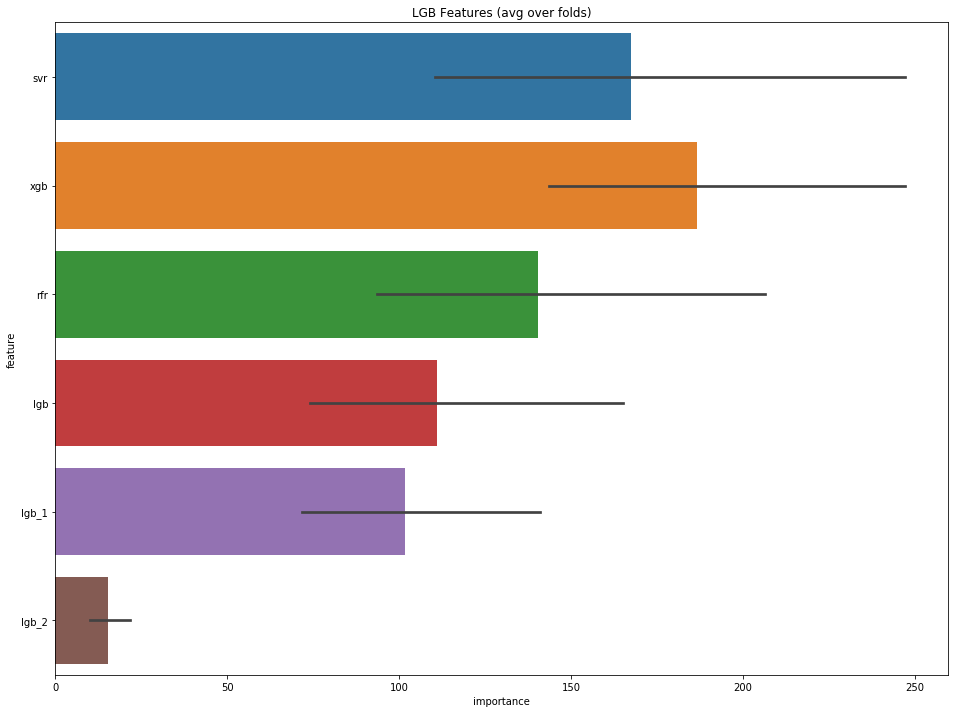

In [185]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [186]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:37:56 2019
Fold 1 started at Sun Dec 15 14:38:00 2019
Fold 2 started at Sun Dec 15 14:38:03 2019
Fold 3 started at Sun Dec 15 14:38:04 2019
Fold 4 started at Sun Dec 15 14:38:08 2019
Fold 5 started at Sun Dec 15 14:38:09 2019
Fold 6 started at Sun Dec 15 14:38:11 2019
Fold 7 started at Sun Dec 15 14:38:13 2019
Fold 8 started at Sun Dec 15 14:38:15 2019
Fold 9 started at Sun Dec 15 14:38:19 2019
CV mean score: 2.9156, std: 0.5599.


random forest做第二层融合模型

In [187]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:38:21 2019
Fold 1 started at Sun Dec 15 14:38:22 2019
Fold 2 started at Sun Dec 15 14:38:22 2019
Fold 3 started at Sun Dec 15 14:38:22 2019
Fold 4 started at Sun Dec 15 14:38:22 2019
Fold 5 started at Sun Dec 15 14:38:23 2019
Fold 6 started at Sun Dec 15 14:38:23 2019
Fold 7 started at Sun Dec 15 14:38:23 2019
Fold 8 started at Sun Dec 15 14:38:23 2019
Fold 9 started at Sun Dec 15 14:38:24 2019
CV mean score: 3.0240, std: 0.5989.


xgboost做第二层融合模型

In [188]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:38:24 2019
[0]	train-rmse:23.8346	valid_data-rmse:21.8408
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20042	valid_data-rmse:2.26908
Stopping. Best iteration:
[657]	train-rmse:0.952555	valid_data-rmse:2.23657

Fold 1 started at Sun Dec 15 14:38:24 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.19445	valid_data-rmse:2.85687
Stopping. Best iteration:
[560]	train-rmse:1.07533	valid_data-rmse:2.85264

Fold 2 started at Sun Dec 15 14:38:24 2019
[0]	train-rmse:23.7737	valid_data-rmse:22.4241
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-

#### SVR作为meta

In [189]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:38:27 2019
Fold 1 started at Sun Dec 15 14:38:27 2019
Fold 2 started at Sun Dec 15 14:38:27 2019
Fold 3 started at Sun Dec 15 14:38:27 2019
Fold 4 started at Sun Dec 15 14:38:27 2019
Fold 5 started at Sun Dec 15 14:38:27 2019
Fold 6 started at Sun Dec 15 14:38:27 2019
Fold 7 started at Sun Dec 15 14:38:27 2019
Fold 8 started at Sun Dec 15 14:38:27 2019
Fold 9 started at Sun Dec 15 14:38:27 2019
CV mean score: 7.0688, std: 0.7555.


用岭回归做第二层融合模型

In [190]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 14:38:27 2019
Fold 1 started at Sun Dec 15 14:38:27 2019
Fold 2 started at Sun Dec 15 14:38:27 2019
Fold 3 started at Sun Dec 15 14:38:27 2019
Fold 4 started at Sun Dec 15 14:38:27 2019
Fold 5 started at Sun Dec 15 14:38:27 2019
Fold 6 started at Sun Dec 15 14:38:27 2019
Fold 7 started at Sun Dec 15 14:38:27 2019
Fold 8 started at Sun Dec 15 14:38:27 2019
Fold 9 started at Sun Dec 15 14:38:27 2019
CV mean score: 2.8548, std: 0.5869.


### 去掉xgboost

Fold 0 started at Sun Dec 15 14:38:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[435]	training's rmse: 2.4634	valid_1's rmse: 2.20274
Fold 1 started at Sun Dec 15 14:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[588]	training's rmse: 2.28892	valid_1's rmse: 3.23167
Fold 2 started at Sun Dec 15 14:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 2.49017	valid_1's rmse: 2.68908
Fold 3 started at Sun Dec 15 14:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[496]	training's rmse: 2.389	valid_1's rmse: 2.8724
Fold 4 started at Sun Dec 15 14:38:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.60802	valid_1's rmse: 4.15287
Fold 5 started at Sun De

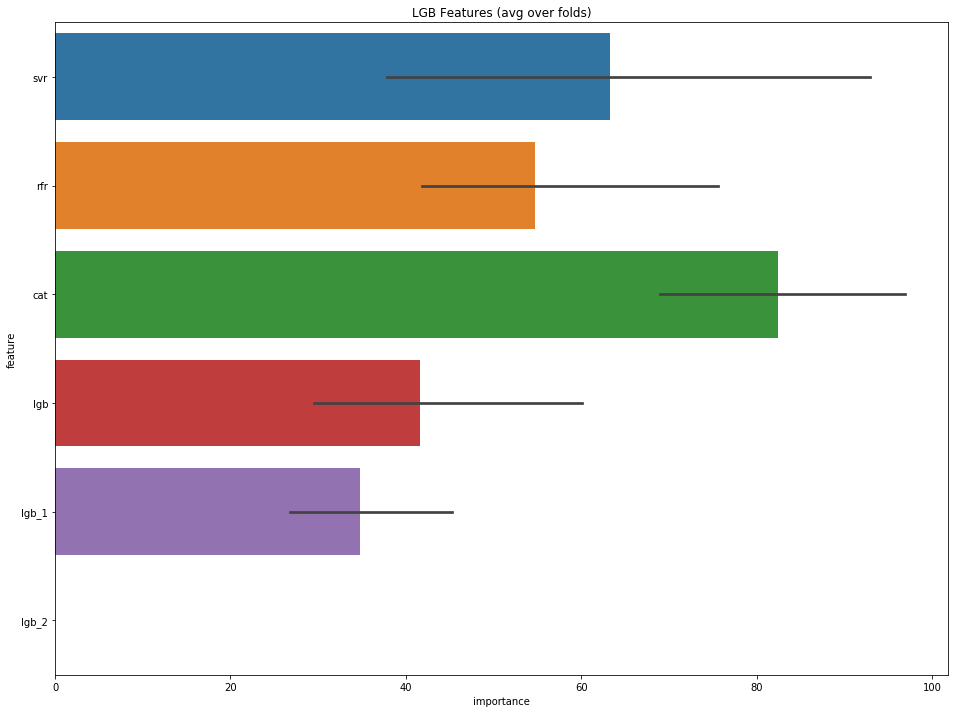

In [191]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:38:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 2.24053	valid_1's rmse: 2.18843
Fold 1 started at Sun Dec 15 14:38:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 2.27926	valid_1's rmse: 3.27445
Fold 2 started at Sun Dec 15 14:38:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[281]	training's rmse: 2.44873	valid_1's rmse: 2.73059
Fold 3 started at Sun Dec 15 14:38:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rmse: 2.33567	valid_1's rmse: 3.00484
Fold 4 started at Sun Dec 15 14:38:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 2.50413	valid_1's rmse: 4.14464
Fold 5 started at Su

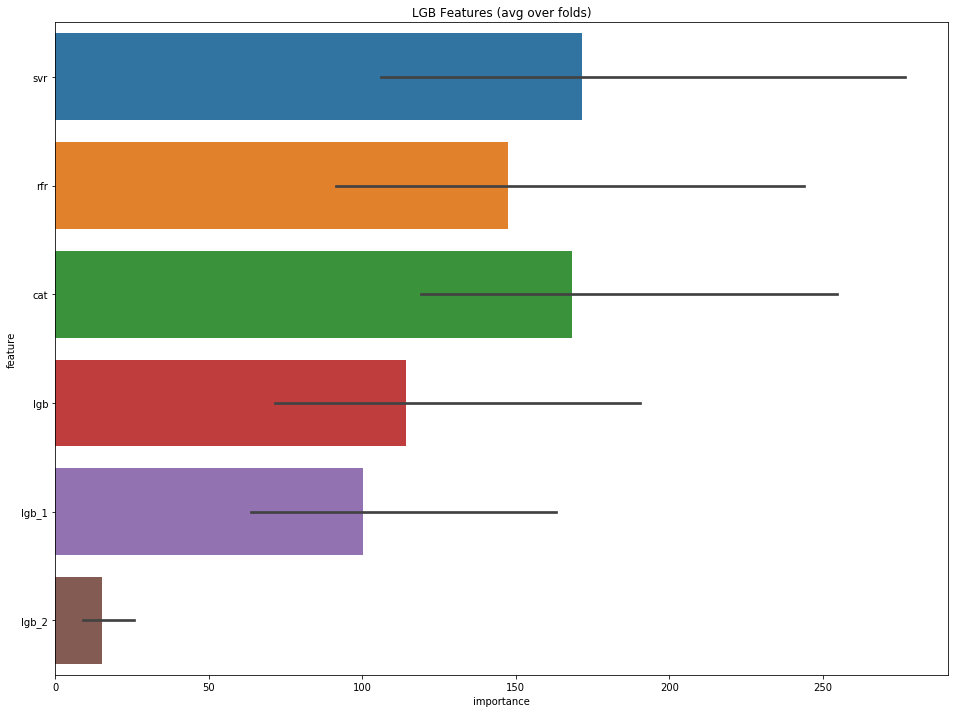

In [192]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [193]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:38:33 2019
Fold 1 started at Sun Dec 15 14:38:36 2019
Fold 2 started at Sun Dec 15 14:38:38 2019
Fold 3 started at Sun Dec 15 14:38:40 2019
Fold 4 started at Sun Dec 15 14:38:42 2019
Fold 5 started at Sun Dec 15 14:38:43 2019
Fold 6 started at Sun Dec 15 14:38:45 2019
Fold 7 started at Sun Dec 15 14:38:47 2019
Fold 8 started at Sun Dec 15 14:38:49 2019
Fold 9 started at Sun Dec 15 14:38:51 2019
CV mean score: 2.9822, std: 0.5542.


random forest做第二层融合模型

In [194]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:38:54 2019
Fold 1 started at Sun Dec 15 14:38:54 2019
Fold 2 started at Sun Dec 15 14:38:54 2019
Fold 3 started at Sun Dec 15 14:38:55 2019
Fold 4 started at Sun Dec 15 14:38:55 2019
Fold 5 started at Sun Dec 15 14:38:55 2019
Fold 6 started at Sun Dec 15 14:38:55 2019
Fold 7 started at Sun Dec 15 14:38:55 2019
Fold 8 started at Sun Dec 15 14:38:56 2019
Fold 9 started at Sun Dec 15 14:38:56 2019
CV mean score: 3.0278, std: 0.5915.


xgboost做第二层融合模型

In [195]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:38:56 2019
[0]	train-rmse:23.8347	valid_data-rmse:21.8406
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.22076	valid_data-rmse:2.33407
Stopping. Best iteration:
[745]	train-rmse:0.836808	valid_data-rmse:2.31529

Fold 1 started at Sun Dec 15 14:38:57 2019
[0]	train-rmse:23.708	valid_data-rmse:23.0485
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.20034	valid_data-rmse:3.43763
Stopping. Best iteration:
[634]	train-rmse:0.958817	valid_data-rmse:3.41657

Fold 2 started at Sun Dec 15 14:38:57 2019
[0]	train-rmse:23.7749	valid_data-rmse:22.4277
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train

#### SVR作为meta

In [196]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:39:00 2019
Fold 1 started at Sun Dec 15 14:39:00 2019
Fold 2 started at Sun Dec 15 14:39:00 2019
Fold 3 started at Sun Dec 15 14:39:00 2019
Fold 4 started at Sun Dec 15 14:39:00 2019
Fold 5 started at Sun Dec 15 14:39:00 2019
Fold 6 started at Sun Dec 15 14:39:00 2019
Fold 7 started at Sun Dec 15 14:39:00 2019
Fold 8 started at Sun Dec 15 14:39:00 2019
Fold 9 started at Sun Dec 15 14:39:00 2019
CV mean score: 7.1762, std: 0.7896.


用岭回归做第二层融合模型

In [197]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:39:00 2019
Fold 1 started at Sun Dec 15 14:39:00 2019
Fold 2 started at Sun Dec 15 14:39:00 2019
Fold 3 started at Sun Dec 15 14:39:00 2019
Fold 4 started at Sun Dec 15 14:39:00 2019
Fold 5 started at Sun Dec 15 14:39:00 2019
Fold 6 started at Sun Dec 15 14:39:00 2019
Fold 7 started at Sun Dec 15 14:39:00 2019
Fold 8 started at Sun Dec 15 14:39:00 2019
Fold 9 started at Sun Dec 15 14:39:00 2019
CV mean score: 2.9247, std: 0.5444.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 14:39:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[559]	training's rmse: 2.36801	valid_1's rmse: 2.08492
Fold 1 started at Sun Dec 15 14:39:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[660]	training's rmse: 2.28199	valid_1's rmse: 2.84964
Fold 2 started at Sun Dec 15 14:39:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 2.44443	valid_1's rmse: 2.59596
Fold 3 started at Sun Dec 15 14:39:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[409]	training's rmse: 2.40138	valid_1's rmse: 2.74116
Fold 4 started at Sun Dec 15 14:39:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[212]	training's rmse: 2.62009	valid_1's rmse: 3.95745
Fold 5 started at Su

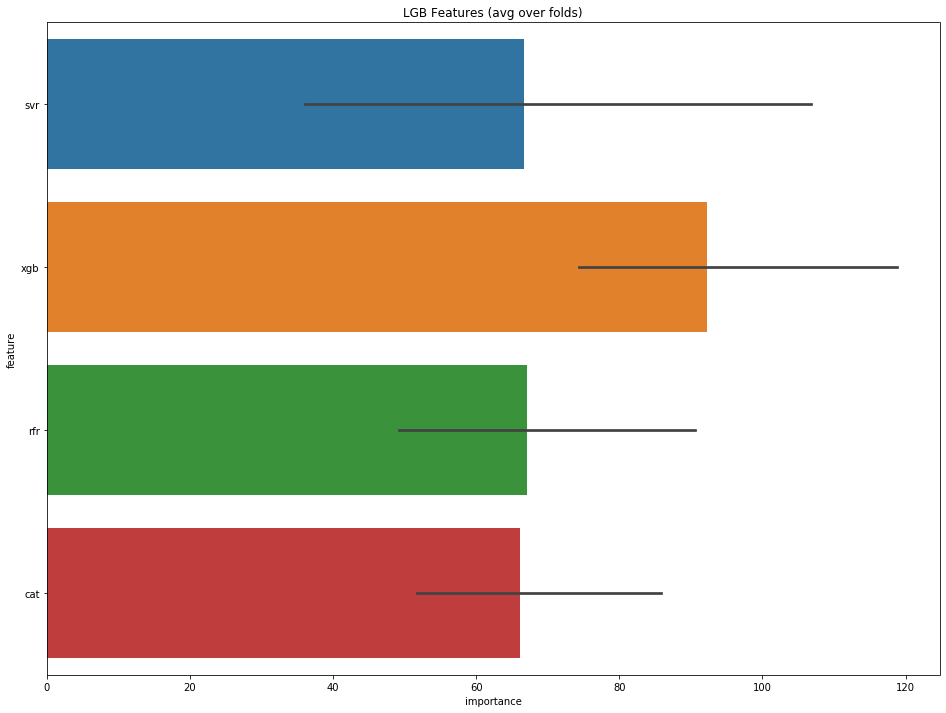

In [198]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:39:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[465]	training's rmse: 2.24318	valid_1's rmse: 2.0868
Fold 1 started at Sun Dec 15 14:39:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.82845	valid_1's rmse: 2.82173
Early stopping, best iteration is:
[1195]	training's rmse: 1.74788	valid_1's rmse: 2.81096
Fold 2 started at Sun Dec 15 14:39:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 2.39915	valid_1's rmse: 2.61282
Fold 3 started at Sun Dec 15 14:39:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 2.23619	valid_1's rmse: 2.80727
Fold 4 started at Sun Dec 15 14:39:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[210]	training's rm

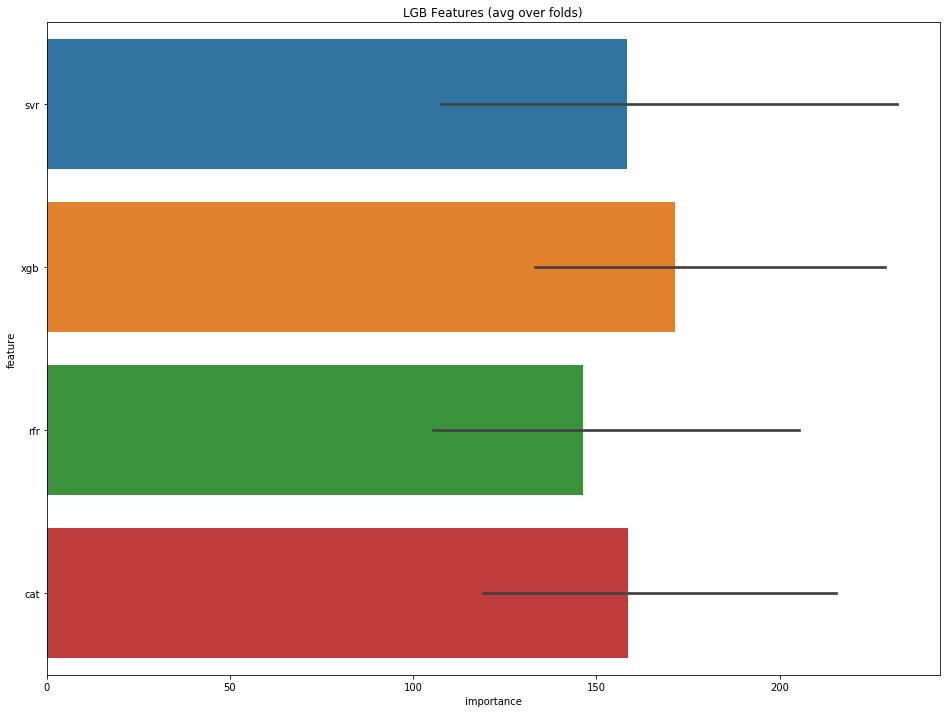

In [199]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:39:06 2019
Fold 1 started at Sun Dec 15 14:39:08 2019
Fold 2 started at Sun Dec 15 14:39:11 2019
Fold 3 started at Sun Dec 15 14:39:13 2019
Fold 4 started at Sun Dec 15 14:39:17 2019
Fold 5 started at Sun Dec 15 14:39:18 2019
Fold 6 started at Sun Dec 15 14:39:20 2019
Fold 7 started at Sun Dec 15 14:39:22 2019
Fold 8 started at Sun Dec 15 14:39:24 2019
Fold 9 started at Sun Dec 15 14:39:26 2019
CV mean score: 2.8564, std: 0.4228.


random forest做第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:39:28 2019
Fold 1 started at Sun Dec 15 14:39:28 2019
Fold 2 started at Sun Dec 15 14:39:28 2019
Fold 3 started at Sun Dec 15 14:39:29 2019
Fold 4 started at Sun Dec 15 14:39:29 2019
Fold 5 started at Sun Dec 15 14:39:29 2019
Fold 6 started at Sun Dec 15 14:39:29 2019
Fold 7 started at Sun Dec 15 14:39:30 2019
Fold 8 started at Sun Dec 15 14:39:30 2019
Fold 9 started at Sun Dec 15 14:39:30 2019
CV mean score: 2.9073, std: 0.4299.


xgboost做第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:39:30 2019
[0]	train-rmse:23.8351	valid_data-rmse:21.84
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24363	valid_data-rmse:2.23671
Stopping. Best iteration:
[692]	train-rmse:0.942286	valid_data-rmse:2.21048

Fold 1 started at Sun Dec 15 14:39:31 2019
[0]	train-rmse:23.7079	valid_data-rmse:23.0494
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.21206	valid_data-rmse:2.76295
[1000]	train-rmse:0.607786	valid_data-rmse:2.70836
Stopping. Best iteration:
[810]	train-rmse:0.772306	valid_data-rmse:2.70519

Fold 2 started at Sun Dec 15 14:39:31 2019
[0]	train-rmse:23.7747	valid_data-rmse:22.4236
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_da

#### SVR作为meta

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:39:34 2019
Fold 1 started at Sun Dec 15 14:39:34 2019
Fold 2 started at Sun Dec 15 14:39:34 2019
Fold 3 started at Sun Dec 15 14:39:34 2019
Fold 4 started at Sun Dec 15 14:39:34 2019
Fold 5 started at Sun Dec 15 14:39:34 2019
Fold 6 started at Sun Dec 15 14:39:34 2019
Fold 7 started at Sun Dec 15 14:39:34 2019
Fold 8 started at Sun Dec 15 14:39:34 2019
Fold 9 started at Sun Dec 15 14:39:34 2019
CV mean score: 6.9787, std: 0.7407.


用岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:39:34 2019
Fold 1 started at Sun Dec 15 14:39:34 2019
Fold 2 started at Sun Dec 15 14:39:34 2019
Fold 3 started at Sun Dec 15 14:39:34 2019
Fold 4 started at Sun Dec 15 14:39:34 2019
Fold 5 started at Sun Dec 15 14:39:35 2019
Fold 6 started at Sun Dec 15 14:39:35 2019
Fold 7 started at Sun Dec 15 14:39:35 2019
Fold 8 started at Sun Dec 15 14:39:35 2019
Fold 9 started at Sun Dec 15 14:39:35 2019
CV mean score: 2.8330, std: 0.5077.


## mg 数据集实验

In [205]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('mg')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [206]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 0.0963903	valid_1's rmse: 0.11385


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [207]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 14:39:35 2019
Fold 1 started at Sun Dec 15 14:39:35 2019
Fold 2 started at Sun Dec 15 14:39:35 2019
Fold 3 started at Sun Dec 15 14:39:35 2019
Fold 4 started at Sun Dec 15 14:39:35 2019
Fold 5 started at Sun Dec 15 14:39:36 2019
Fold 6 started at Sun Dec 15 14:39:36 2019
Fold 7 started at Sun Dec 15 14:39:36 2019
Fold 8 started at Sun Dec 15 14:39:36 2019
Fold 9 started at Sun Dec 15 14:39:36 2019
CV mean score: 0.1367, std: 0.0074.


Fold 0 started at Sun Dec 15 14:39:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 0.0846455	valid_1's rmse: 0.118287
Fold 1 started at Sun Dec 15 14:39:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[367]	training's rmse: 0.0916833	valid_1's rmse: 0.121149
Fold 2 started at Sun Dec 15 14:39:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's rmse: 0.094031	valid_1's rmse: 0.120335
Fold 3 started at Sun Dec 15 14:39:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 0.0945667	valid_1's rmse: 0.1221
Fold 4 started at Sun Dec 15 14:39:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[308]	training's rmse: 0.0943736	valid_1's rmse: 0.126733
Fold 5 s

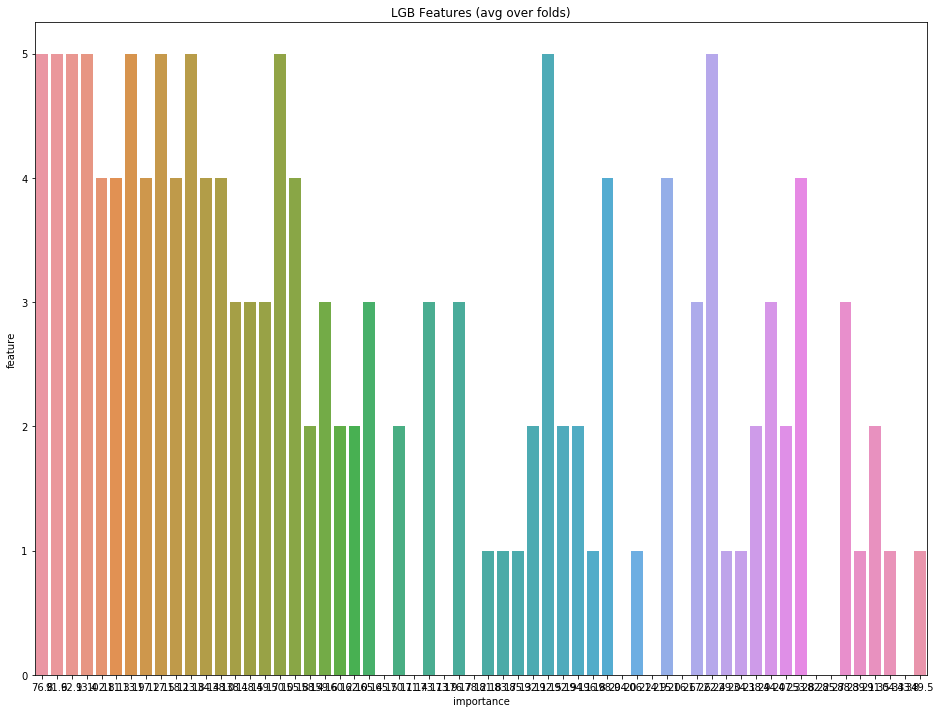

In [208]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:39:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.08549	valid_1's rmse: 0.118597
Early stopping, best iteration is:
[1141]	training's rmse: 0.0836203	valid_1's rmse: 0.118415
Fold 1 started at Sun Dec 15 14:39:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's rmse: 0.0936502	valid_1's rmse: 0.121003
Fold 2 started at Sun Dec 15 14:39:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 0.0992678	valid_1's rmse: 0.119436
Fold 3 started at Sun Dec 15 14:39:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.0990269	valid_1's rmse: 0.12017
Fold 4 started at Sun Dec 15 14:39:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	

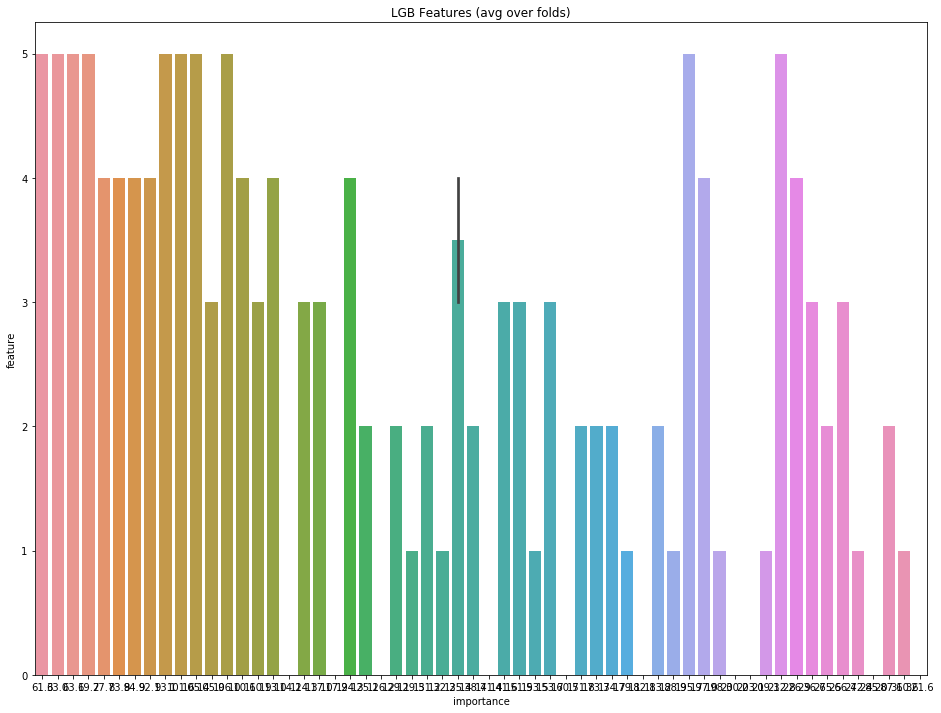

In [209]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:39:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.08549	valid_1's rmse: 0.118597
Early stopping, best iteration is:
[1141]	training's rmse: 0.0836203	valid_1's rmse: 0.118415
Fold 1 started at Sun Dec 15 14:39:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[531]	training's rmse: 0.0936502	valid_1's rmse: 0.121003
Fold 2 started at Sun Dec 15 14:39:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[331]	training's rmse: 0.0992678	valid_1's rmse: 0.119436
Fold 3 started at Sun Dec 15 14:39:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.0990269	valid_1's rmse: 0.12017
Fold 4 started at Sun Dec 15 14:39:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	

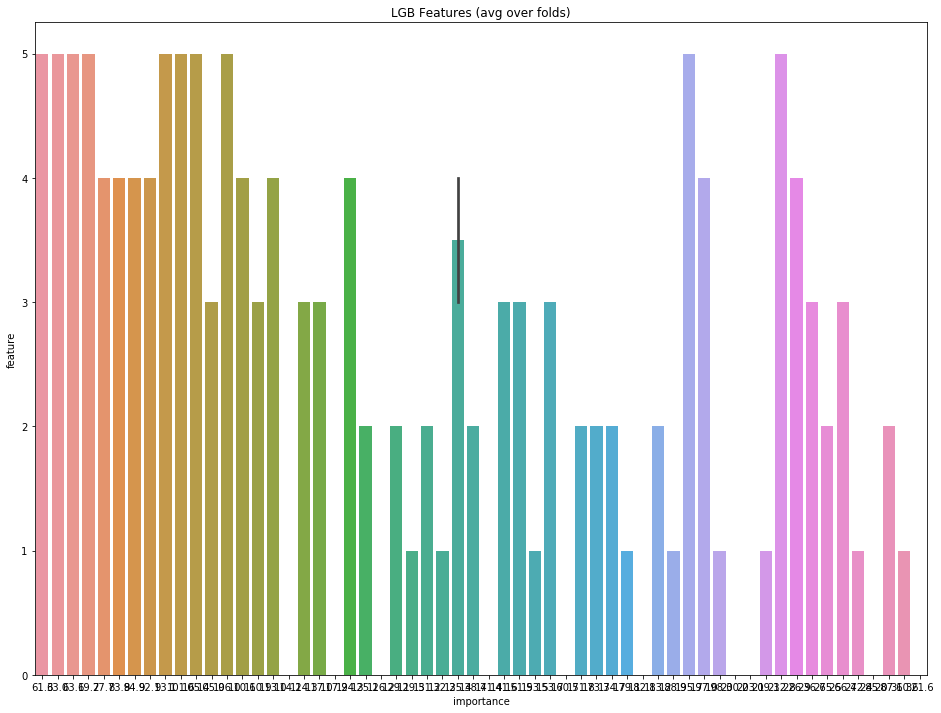

In [210]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [211]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 14:39:51 2019
Fold 1 started at Sun Dec 15 14:39:51 2019
Fold 2 started at Sun Dec 15 14:39:51 2019
Fold 3 started at Sun Dec 15 14:39:51 2019
Fold 4 started at Sun Dec 15 14:39:52 2019
Fold 5 started at Sun Dec 15 14:39:52 2019
Fold 6 started at Sun Dec 15 14:39:52 2019
Fold 7 started at Sun Dec 15 14:39:52 2019
Fold 8 started at Sun Dec 15 14:39:53 2019
Fold 9 started at Sun Dec 15 14:39:53 2019
CV mean score: 0.1191, std: 0.0070.


In [212]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:39:53 2019
[0]	train-rmse:0.48241	valid_data-rmse:0.473695
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.056062	valid_data-rmse:0.1157
Stopping. Best iteration:
[477]	train-rmse:0.057266	valid_data-rmse:0.115596

Fold 1 started at Sun Dec 15 14:39:54 2019
[0]	train-rmse:0.481885	valid_data-rmse:0.478521
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.056603	valid_data-rmse:0.120467
Stopping. Best iteration:
[449]	train-rmse:0.058834	valid_data-rmse:0.120359

Fold 2 started at Sun Dec 15 14:39:55 2019
[0]	train-rmse:0.480885	valid_data-rmse:0.487403
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

In [213]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:40:03 2019
Fold 1 started at Sun Dec 15 14:40:14 2019
Fold 2 started at Sun Dec 15 14:40:18 2019
Fold 3 started at Sun Dec 15 14:40:26 2019
Fold 4 started at Sun Dec 15 14:40:29 2019
Fold 5 started at Sun Dec 15 14:40:33 2019
Fold 6 started at Sun Dec 15 14:40:40 2019
Fold 7 started at Sun Dec 15 14:40:48 2019
Fold 8 started at Sun Dec 15 14:40:58 2019
Fold 9 started at Sun Dec 15 14:41:10 2019
CV mean score: 0.1175, std: 0.0077.


## stacking

Fold 0 started at Sun Dec 15 14:41:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.110727	valid_1's rmse: 0.122716
Fold 1 started at Sun Dec 15 14:41:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[394]	training's rmse: 0.108253	valid_1's rmse: 0.122131
Fold 2 started at Sun Dec 15 14:41:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[286]	training's rmse: 0.110412	valid_1's rmse: 0.117403
Fold 3 started at Sun Dec 15 14:41:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[316]	training's rmse: 0.110004	valid_1's rmse: 0.117375
Fold 4 started at Sun Dec 15 14:41:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 0.110558	valid_1's rmse: 0.123935
Fold 5 sta

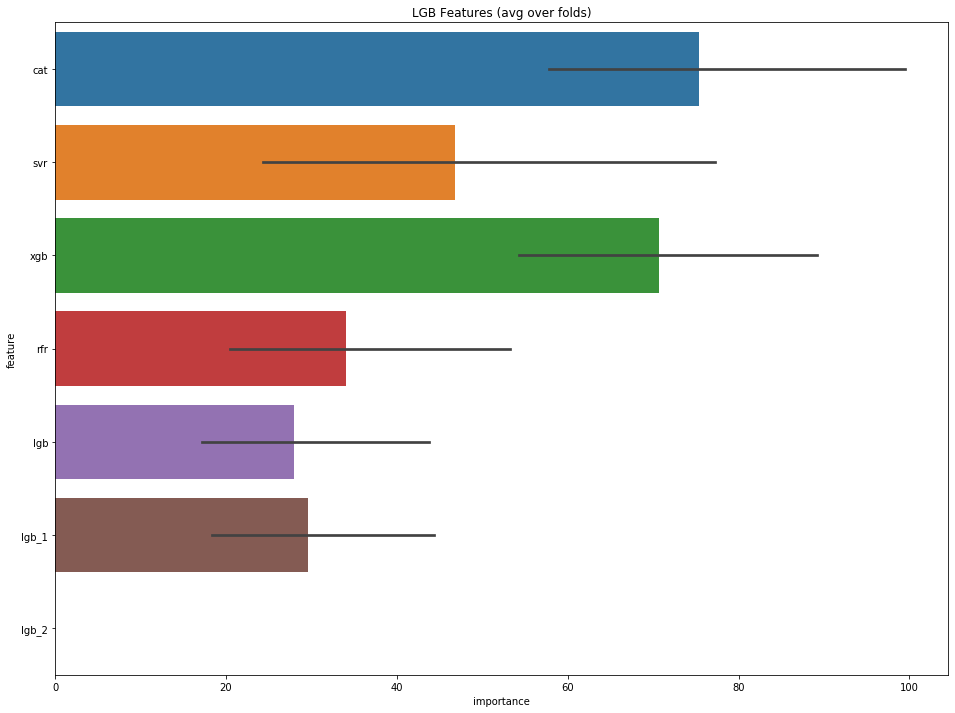

In [214]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:41:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's rmse: 0.101161	valid_1's rmse: 0.128737
Fold 1 started at Sun Dec 15 14:41:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[390]	training's rmse: 0.0936873	valid_1's rmse: 0.123136
Fold 2 started at Sun Dec 15 14:41:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 0.10111	valid_1's rmse: 0.119576
Fold 3 started at Sun Dec 15 14:41:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.0985686	valid_1's rmse: 0.119905
Fold 4 started at Sun Dec 15 14:41:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.0985478	valid_1's rmse: 0.124256
Fold 5 s

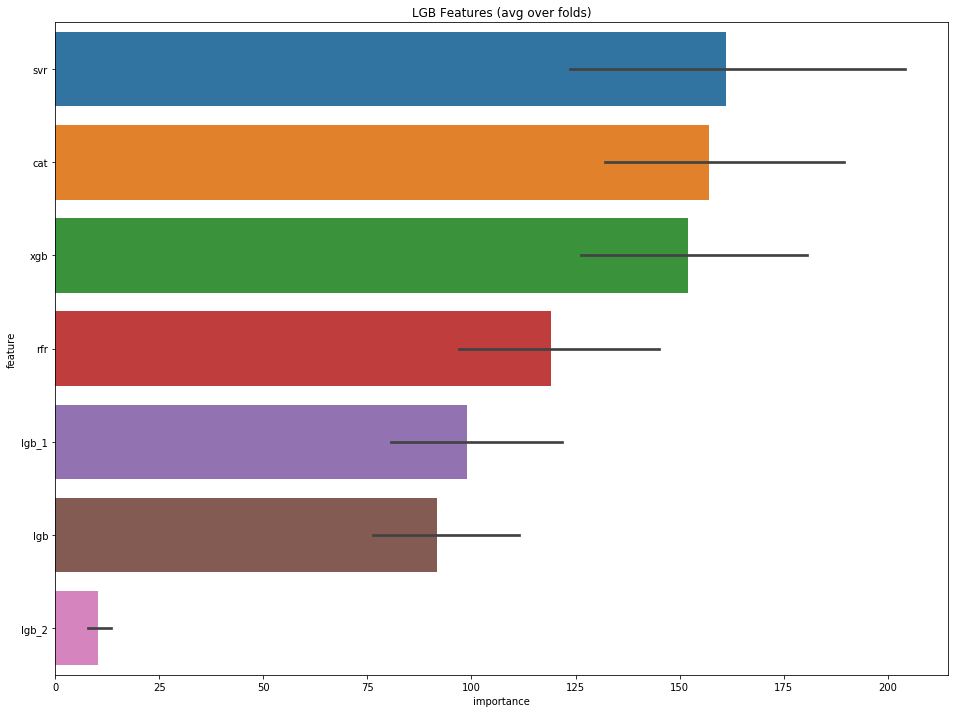

In [215]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:41:19 2019
Fold 1 started at Sun Dec 15 14:41:21 2019
Fold 2 started at Sun Dec 15 14:41:23 2019
Fold 3 started at Sun Dec 15 14:41:27 2019
Fold 4 started at Sun Dec 15 14:41:29 2019
Fold 5 started at Sun Dec 15 14:41:31 2019
Fold 6 started at Sun Dec 15 14:41:33 2019
Fold 7 started at Sun Dec 15 14:41:38 2019
Fold 8 started at Sun Dec 15 14:41:44 2019
Fold 9 started at Sun Dec 15 14:41:46 2019
CV mean score: 0.1171, std: 0.0072.


random forest做第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:41:48 2019
Fold 1 started at Sun Dec 15 14:41:48 2019
Fold 2 started at Sun Dec 15 14:41:48 2019
Fold 3 started at Sun Dec 15 14:41:48 2019
Fold 4 started at Sun Dec 15 14:41:49 2019
Fold 5 started at Sun Dec 15 14:41:49 2019
Fold 6 started at Sun Dec 15 14:41:49 2019
Fold 7 started at Sun Dec 15 14:41:49 2019
Fold 8 started at Sun Dec 15 14:41:50 2019
Fold 9 started at Sun Dec 15 14:41:50 2019
CV mean score: 0.1202, std: 0.0053.


xgboost做第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:41:50 2019
[0]	train-rmse:0.482357	valid_data-rmse:0.473631
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.062564	valid_data-rmse:0.133108
Stopping. Best iteration:
[380]	train-rmse:0.069443	valid_data-rmse:0.132159

Fold 1 started at Sun Dec 15 14:41:51 2019
[0]	train-rmse:0.481829	valid_data-rmse:0.478487
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.063421	valid_data-rmse:0.125461
Stopping. Best iteration:
[551]	train-rmse:0.06108	valid_data-rmse:0.125378

Fold 2 started at Sun Dec 15 14:41:51 2019
[0]	train-rmse:0.48083	valid_data-rmse:0.487347
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


#### SVR作为meta

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:41:57 2019
Fold 1 started at Sun Dec 15 14:41:57 2019
Fold 2 started at Sun Dec 15 14:41:57 2019
Fold 3 started at Sun Dec 15 14:41:57 2019
Fold 4 started at Sun Dec 15 14:41:57 2019
Fold 5 started at Sun Dec 15 14:41:57 2019
Fold 6 started at Sun Dec 15 14:41:57 2019
Fold 7 started at Sun Dec 15 14:41:57 2019
Fold 8 started at Sun Dec 15 14:41:57 2019
Fold 9 started at Sun Dec 15 14:41:57 2019
CV mean score: 0.1168, std: 0.0078.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 14:41:57 2019
Fold 1 started at Sun Dec 15 14:41:57 2019
Fold 2 started at Sun Dec 15 14:41:58 2019
Fold 3 started at Sun Dec 15 14:41:58 2019
Fold 4 started at Sun Dec 15 14:41:58 2019
Fold 5 started at Sun Dec 15 14:41:58 2019
Fold 6 started at Sun Dec 15 14:41:58 2019
Fold 7 started at Sun Dec 15 14:41:58 2019
Fold 8 started at Sun Dec 15 14:41:58 2019
Fold 9 started at Sun Dec 15 14:41:58 2019
CV mean score: 0.1167, std: 0.0077.
Fold 0 started at Sun Dec 15 14:41:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[299]	training's rmse: 0.109748	valid_1's rmse: 0.12325
Fold 1 started at Sun Dec 15 14:41:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 0.108063	valid_1's rmse: 0.121352
Fold 2 started at Sun Dec 15 14:41:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is

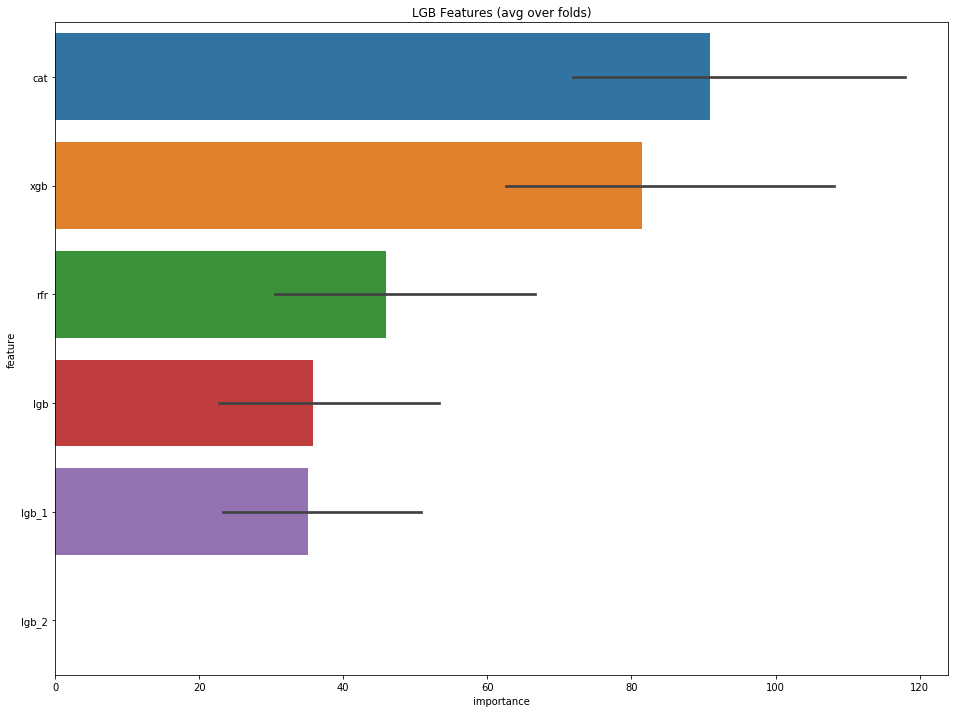

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:42:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	training's rmse: 0.103996	valid_1's rmse: 0.129162
Fold 1 started at Sun Dec 15 14:42:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 0.0997539	valid_1's rmse: 0.123761
Fold 2 started at Sun Dec 15 14:42:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 0.102675	valid_1's rmse: 0.120888
Fold 3 started at Sun Dec 15 14:42:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 0.104973	valid_1's rmse: 0.121484
Fold 4 started at Sun Dec 15 14:42:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 0.102439	valid_1's rmse: 0.123885
Fold 5 st

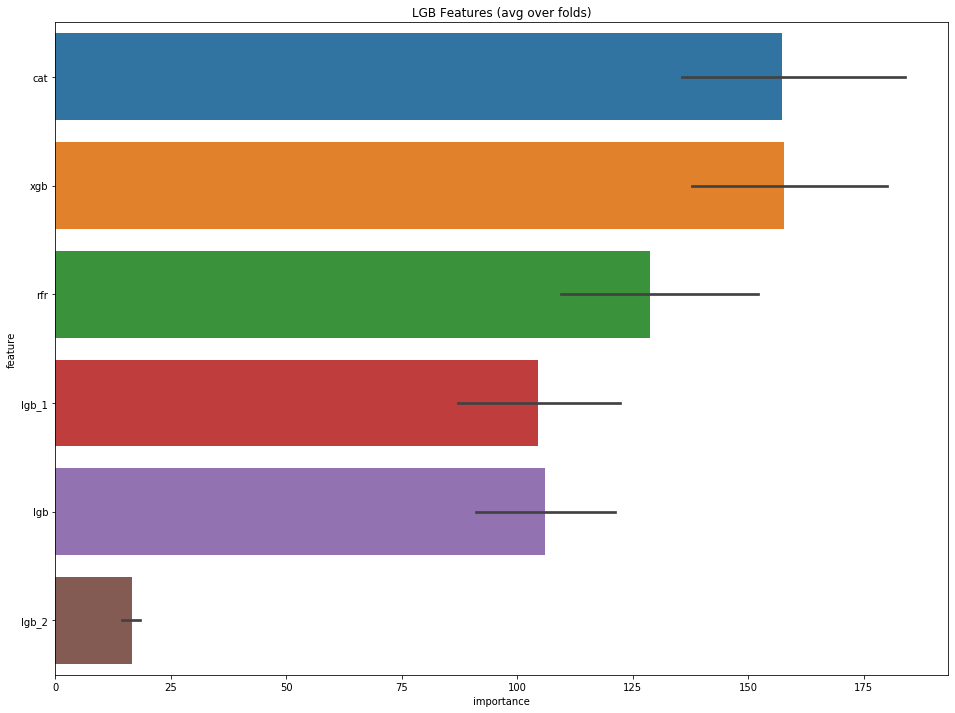

In [221]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [222]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:42:04 2019
Fold 1 started at Sun Dec 15 14:42:06 2019
Fold 2 started at Sun Dec 15 14:42:08 2019
Fold 3 started at Sun Dec 15 14:42:11 2019
Fold 4 started at Sun Dec 15 14:42:12 2019
Fold 5 started at Sun Dec 15 14:42:14 2019
Fold 6 started at Sun Dec 15 14:42:17 2019
Fold 7 started at Sun Dec 15 14:42:21 2019
Fold 8 started at Sun Dec 15 14:42:26 2019
Fold 9 started at Sun Dec 15 14:42:28 2019
CV mean score: 0.1167, std: 0.0075.


random forest做第二层融合模型

In [223]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:42:29 2019
Fold 1 started at Sun Dec 15 14:42:29 2019
Fold 2 started at Sun Dec 15 14:42:30 2019
Fold 3 started at Sun Dec 15 14:42:30 2019
Fold 4 started at Sun Dec 15 14:42:30 2019
Fold 5 started at Sun Dec 15 14:42:30 2019
Fold 6 started at Sun Dec 15 14:42:31 2019
Fold 7 started at Sun Dec 15 14:42:31 2019
Fold 8 started at Sun Dec 15 14:42:31 2019
Fold 9 started at Sun Dec 15 14:42:31 2019
CV mean score: 0.1188, std: 0.0073.


xgboost做第二层融合模型

In [224]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:42:32 2019
[0]	train-rmse:0.482364	valid_data-rmse:0.473619
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066325	valid_data-rmse:0.132396
Stopping. Best iteration:
[366]	train-rmse:0.074133	valid_data-rmse:0.130955

Fold 1 started at Sun Dec 15 14:42:32 2019
[0]	train-rmse:0.481837	valid_data-rmse:0.478487
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067666	valid_data-rmse:0.126276
Stopping. Best iteration:
[476]	train-rmse:0.068672	valid_data-rmse:0.126175

Fold 2 started at Sun Dec 15 14:42:33 2019
[0]	train-rmse:0.48083	valid_data-rmse:0.487355
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

#### SVR作为meta

In [225]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:42:38 2019
Fold 1 started at Sun Dec 15 14:42:38 2019
Fold 2 started at Sun Dec 15 14:42:38 2019
Fold 3 started at Sun Dec 15 14:42:38 2019
Fold 4 started at Sun Dec 15 14:42:38 2019
Fold 5 started at Sun Dec 15 14:42:38 2019
Fold 6 started at Sun Dec 15 14:42:38 2019
Fold 7 started at Sun Dec 15 14:42:38 2019
Fold 8 started at Sun Dec 15 14:42:38 2019
Fold 9 started at Sun Dec 15 14:42:38 2019
CV mean score: 0.1167, std: 0.0077.


用岭回归做第二层融合模型

In [226]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:42:38 2019
Fold 1 started at Sun Dec 15 14:42:38 2019
Fold 2 started at Sun Dec 15 14:42:38 2019
Fold 3 started at Sun Dec 15 14:42:38 2019
Fold 4 started at Sun Dec 15 14:42:38 2019
Fold 5 started at Sun Dec 15 14:42:38 2019
Fold 6 started at Sun Dec 15 14:42:38 2019
Fold 7 started at Sun Dec 15 14:42:38 2019
Fold 8 started at Sun Dec 15 14:42:39 2019
Fold 9 started at Sun Dec 15 14:42:39 2019
CV mean score: 0.1166, std: 0.0078.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 14:42:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 0.11046	valid_1's rmse: 0.123614
Fold 1 started at Sun Dec 15 14:42:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[424]	training's rmse: 0.108057	valid_1's rmse: 0.122203
Fold 2 started at Sun Dec 15 14:42:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[406]	training's rmse: 0.108662	valid_1's rmse: 0.11714
Fold 3 started at Sun Dec 15 14:42:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 0.109835	valid_1's rmse: 0.117978
Fold 4 started at Sun Dec 15 14:42:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[292]	training's rmse: 0.110283	valid_1's rmse: 0.123061
Fold 5 start

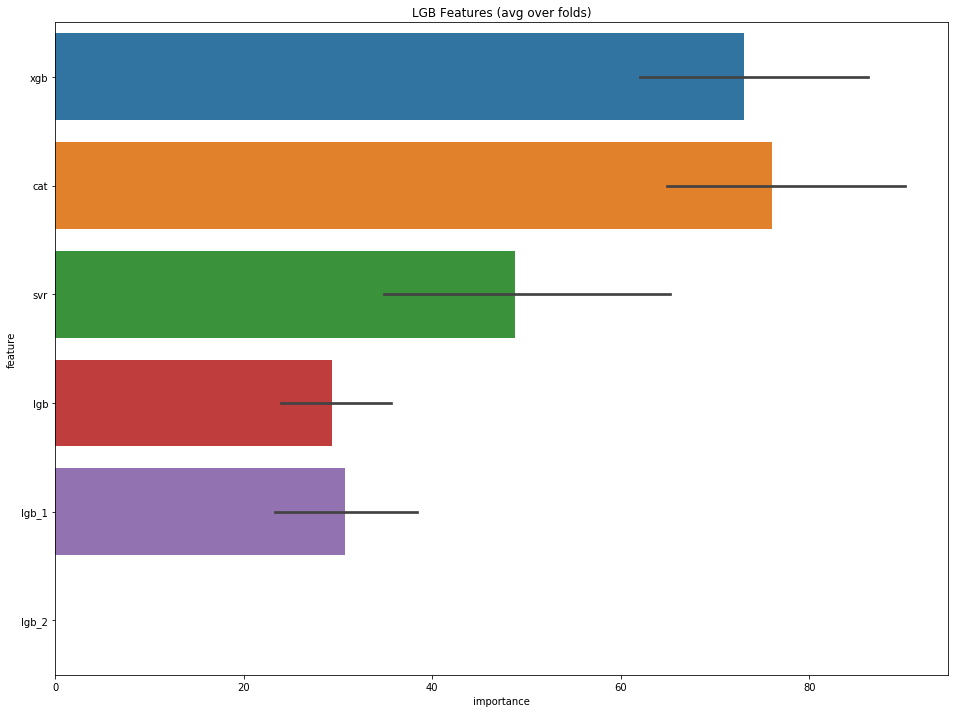

In [227]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:42:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.101395	valid_1's rmse: 0.127799
Fold 1 started at Sun Dec 15 14:42:42 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0818485	valid_1's rmse: 0.120788
Early stopping, best iteration is:
[1226]	training's rmse: 0.0782271	valid_1's rmse: 0.120326
Fold 2 started at Sun Dec 15 14:42:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[246]	training's rmse: 0.102594	valid_1's rmse: 0.119234
Fold 3 started at Sun Dec 15 14:42:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.101968	valid_1's rmse: 0.12107
Fold 4 started at Sun Dec 15 14:42:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	t

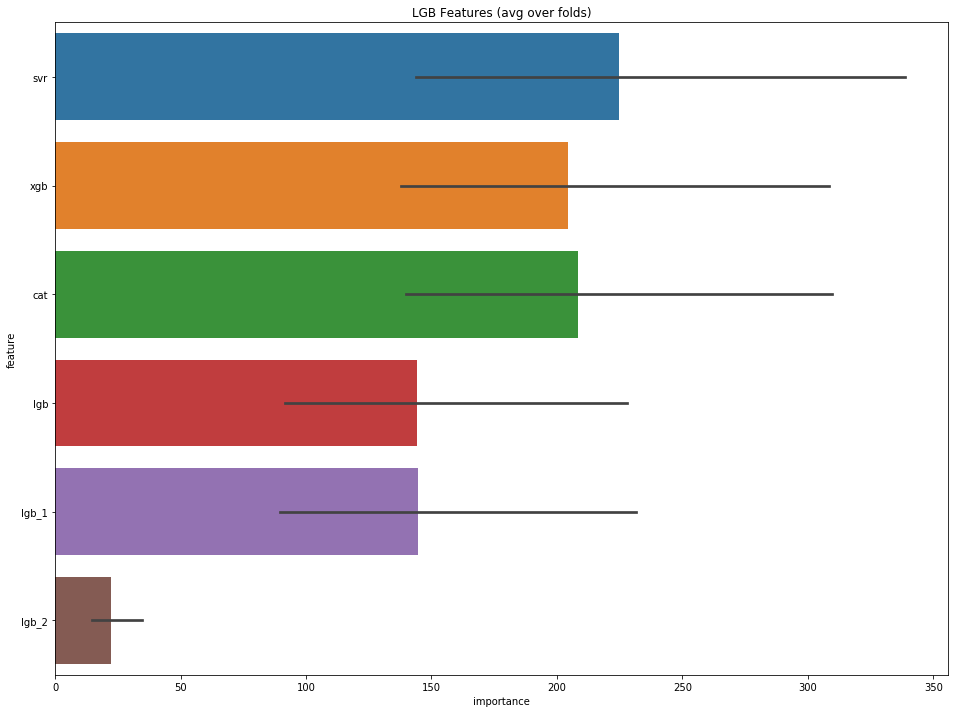

In [228]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [229]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:42:45 2019
Fold 1 started at Sun Dec 15 14:42:48 2019
Fold 2 started at Sun Dec 15 14:42:50 2019
Fold 3 started at Sun Dec 15 14:42:53 2019
Fold 4 started at Sun Dec 15 14:42:55 2019
Fold 5 started at Sun Dec 15 14:42:56 2019
Fold 6 started at Sun Dec 15 14:42:59 2019
Fold 7 started at Sun Dec 15 14:43:02 2019
Fold 8 started at Sun Dec 15 14:43:06 2019
Fold 9 started at Sun Dec 15 14:43:08 2019
CV mean score: 0.1170, std: 0.0073.


random forest做第二层融合模型

In [230]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:43:09 2019
Fold 1 started at Sun Dec 15 14:43:10 2019
Fold 2 started at Sun Dec 15 14:43:10 2019
Fold 3 started at Sun Dec 15 14:43:10 2019
Fold 4 started at Sun Dec 15 14:43:10 2019
Fold 5 started at Sun Dec 15 14:43:11 2019
Fold 6 started at Sun Dec 15 14:43:11 2019
Fold 7 started at Sun Dec 15 14:43:11 2019
Fold 8 started at Sun Dec 15 14:43:11 2019
Fold 9 started at Sun Dec 15 14:43:12 2019
CV mean score: 0.1191, std: 0.0056.


xgboost做第二层融合模型

In [231]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:43:12 2019
[0]	train-rmse:0.482361	valid_data-rmse:0.473679
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.065291	valid_data-rmse:0.131292
Stopping. Best iteration:
[382]	train-rmse:0.07193	valid_data-rmse:0.130708

Fold 1 started at Sun Dec 15 14:43:12 2019
[0]	train-rmse:0.481835	valid_data-rmse:0.478473
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066364	valid_data-rmse:0.120469
Stopping. Best iteration:
[477]	train-rmse:0.067292	valid_data-rmse:0.120382

Fold 2 started at Sun Dec 15 14:43:13 2019
[0]	train-rmse:0.480834	valid_data-rmse:0.487318
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.

#### SVR作为meta

In [232]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:43:18 2019
Fold 1 started at Sun Dec 15 14:43:18 2019
Fold 2 started at Sun Dec 15 14:43:18 2019
Fold 3 started at Sun Dec 15 14:43:18 2019
Fold 4 started at Sun Dec 15 14:43:18 2019
Fold 5 started at Sun Dec 15 14:43:18 2019
Fold 6 started at Sun Dec 15 14:43:18 2019
Fold 7 started at Sun Dec 15 14:43:18 2019
Fold 8 started at Sun Dec 15 14:43:18 2019
Fold 9 started at Sun Dec 15 14:43:18 2019
CV mean score: 0.1168, std: 0.0079.


用岭回归做第二层融合模型

In [233]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:43:18 2019
Fold 1 started at Sun Dec 15 14:43:18 2019
Fold 2 started at Sun Dec 15 14:43:18 2019
Fold 3 started at Sun Dec 15 14:43:18 2019
Fold 4 started at Sun Dec 15 14:43:18 2019
Fold 5 started at Sun Dec 15 14:43:19 2019
Fold 6 started at Sun Dec 15 14:43:19 2019
Fold 7 started at Sun Dec 15 14:43:19 2019
Fold 8 started at Sun Dec 15 14:43:19 2019
Fold 9 started at Sun Dec 15 14:43:19 2019
CV mean score: 0.1167, std: 0.0079.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 14:43:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[317]	training's rmse: 0.111234	valid_1's rmse: 0.12176
Fold 1 started at Sun Dec 15 14:43:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.110048	valid_1's rmse: 0.125181
Fold 2 started at Sun Dec 15 14:43:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[361]	training's rmse: 0.110615	valid_1's rmse: 0.119648
Fold 3 started at Sun Dec 15 14:43:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 0.113015	valid_1's rmse: 0.121078
Fold 4 started at Sun Dec 15 14:43:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.111377	valid_1's rmse: 0.125972
Fold 5 star

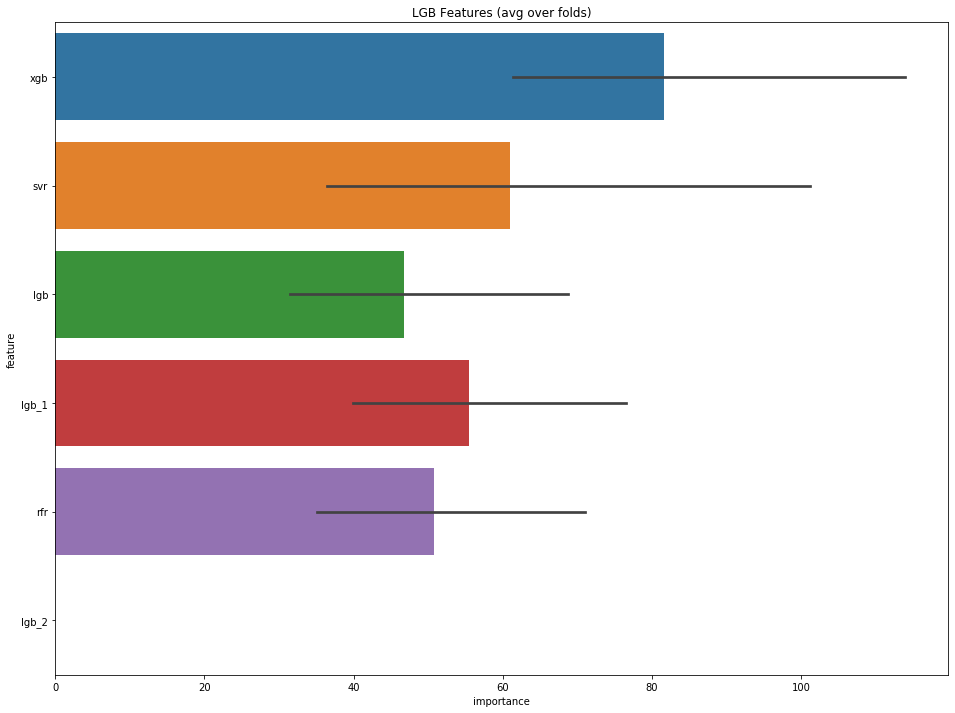

In [234]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.103128	valid_1's rmse: 0.125654
Fold 1 started at Sun Dec 15 14:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 0.0995576	valid_1's rmse: 0.125795
Fold 2 started at Sun Dec 15 14:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[315]	training's rmse: 0.100082	valid_1's rmse: 0.119697
Fold 3 started at Sun Dec 15 14:43:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[273]	training's rmse: 0.101949	valid_1's rmse: 0.124253
Fold 4 started at Sun Dec 15 14:43:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 0.101147	valid_1's rmse: 0.126943
Fold 5 st

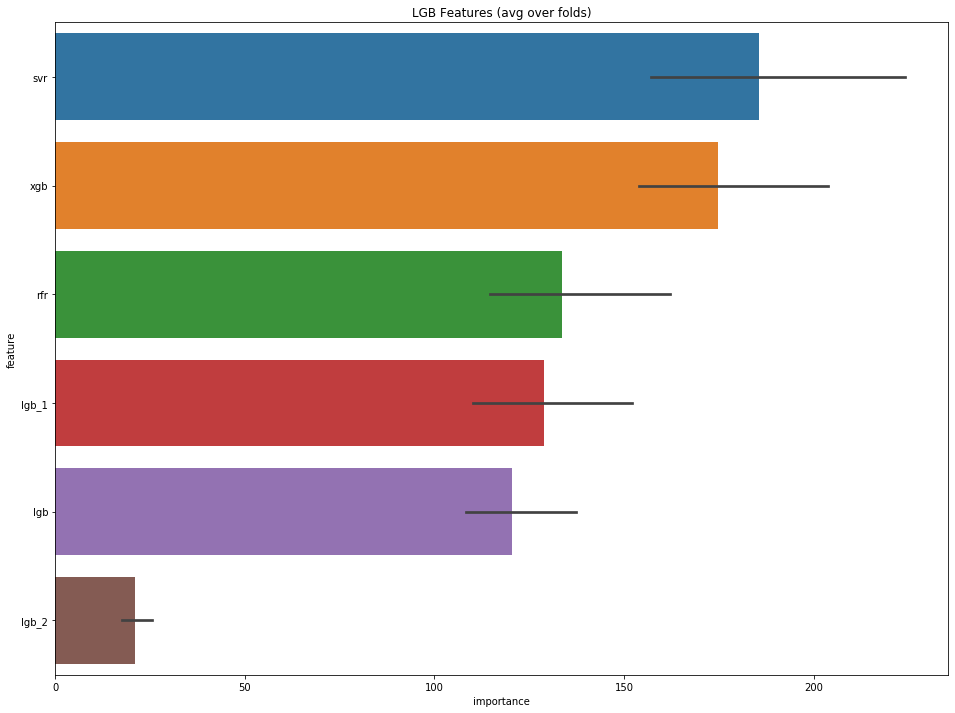

In [235]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [236]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:43:25 2019
Fold 1 started at Sun Dec 15 14:43:27 2019
Fold 2 started at Sun Dec 15 14:43:29 2019
Fold 3 started at Sun Dec 15 14:43:32 2019
Fold 4 started at Sun Dec 15 14:43:33 2019
Fold 5 started at Sun Dec 15 14:43:36 2019
Fold 6 started at Sun Dec 15 14:43:38 2019
Fold 7 started at Sun Dec 15 14:43:40 2019
Fold 8 started at Sun Dec 15 14:43:44 2019
Fold 9 started at Sun Dec 15 14:43:46 2019
CV mean score: 0.1177, std: 0.0070.


random forest做第二层融合模型

In [237]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:43:47 2019
Fold 1 started at Sun Dec 15 14:43:47 2019
Fold 2 started at Sun Dec 15 14:43:47 2019
Fold 3 started at Sun Dec 15 14:43:48 2019
Fold 4 started at Sun Dec 15 14:43:48 2019
Fold 5 started at Sun Dec 15 14:43:48 2019
Fold 6 started at Sun Dec 15 14:43:48 2019
Fold 7 started at Sun Dec 15 14:43:49 2019
Fold 8 started at Sun Dec 15 14:43:49 2019
Fold 9 started at Sun Dec 15 14:43:49 2019
CV mean score: 0.1203, std: 0.0070.


xgboost做第二层融合模型

In [238]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:43:49 2019
[0]	train-rmse:0.482363	valid_data-rmse:0.47363
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066877	valid_data-rmse:0.130469
Stopping. Best iteration:
[379]	train-rmse:0.073653	valid_data-rmse:0.129501

Fold 1 started at Sun Dec 15 14:43:50 2019
[0]	train-rmse:0.481842	valid_data-rmse:0.478461
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067445	valid_data-rmse:0.129887
Stopping. Best iteration:
[389]	train-rmse:0.07364	valid_data-rmse:0.12946

Fold 2 started at Sun Dec 15 14:43:51 2019
[0]	train-rmse:0.480839	valid_data-rmse:0.487295
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

#### SVR作为meta

In [239]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:43:55 2019
Fold 1 started at Sun Dec 15 14:43:55 2019
Fold 2 started at Sun Dec 15 14:43:55 2019
Fold 3 started at Sun Dec 15 14:43:55 2019
Fold 4 started at Sun Dec 15 14:43:55 2019
Fold 5 started at Sun Dec 15 14:43:56 2019
Fold 6 started at Sun Dec 15 14:43:56 2019
Fold 7 started at Sun Dec 15 14:43:56 2019
Fold 8 started at Sun Dec 15 14:43:56 2019
Fold 9 started at Sun Dec 15 14:43:56 2019
CV mean score: 0.1172, std: 0.0077.


用岭回归做第二层融合模型

In [240]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 14:43:56 2019
Fold 1 started at Sun Dec 15 14:43:56 2019
Fold 2 started at Sun Dec 15 14:43:56 2019
Fold 3 started at Sun Dec 15 14:43:56 2019
Fold 4 started at Sun Dec 15 14:43:56 2019
Fold 5 started at Sun Dec 15 14:43:56 2019
Fold 6 started at Sun Dec 15 14:43:56 2019
Fold 7 started at Sun Dec 15 14:43:56 2019
Fold 8 started at Sun Dec 15 14:43:56 2019
Fold 9 started at Sun Dec 15 14:43:56 2019
CV mean score: 0.1171, std: 0.0076.


### 去掉xgboost

Fold 0 started at Sun Dec 15 14:43:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.112027	valid_1's rmse: 0.124408
Fold 1 started at Sun Dec 15 14:43:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[344]	training's rmse: 0.110217	valid_1's rmse: 0.123587
Fold 2 started at Sun Dec 15 14:43:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[362]	training's rmse: 0.110127	valid_1's rmse: 0.119374
Fold 3 started at Sun Dec 15 14:43:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[301]	training's rmse: 0.111475	valid_1's rmse: 0.118252
Fold 4 started at Sun Dec 15 14:43:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 0.110204	valid_1's rmse: 0.125299
Fold 5 sta

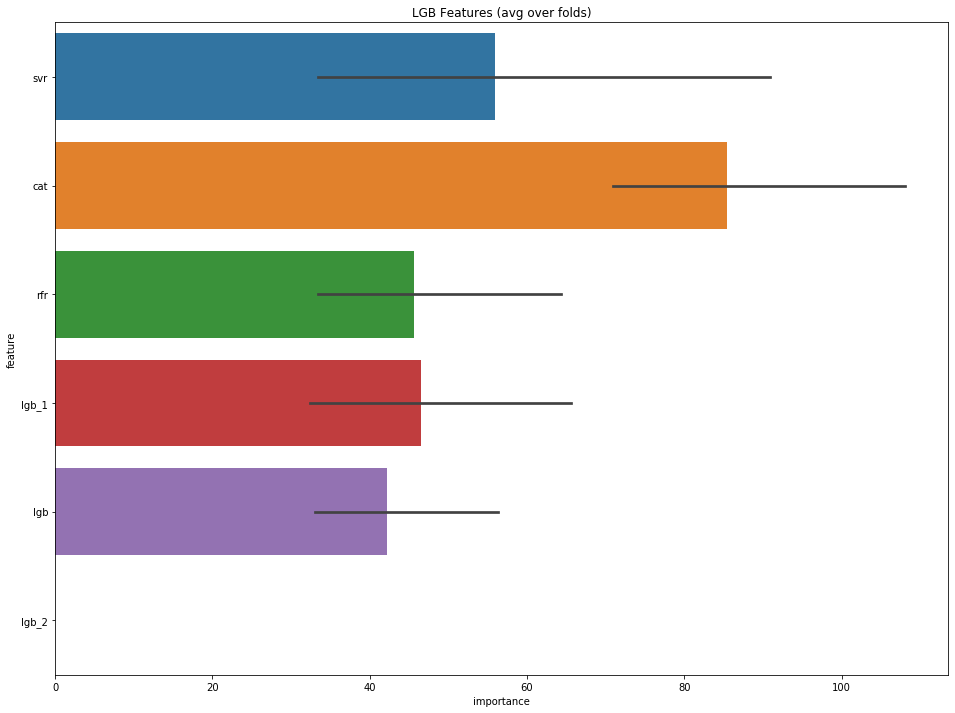

In [241]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:43:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[236]	training's rmse: 0.103153	valid_1's rmse: 0.129436
Fold 1 started at Sun Dec 15 14:43:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[363]	training's rmse: 0.0971982	valid_1's rmse: 0.125623
Fold 2 started at Sun Dec 15 14:43:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 0.101654	valid_1's rmse: 0.121582
Fold 3 started at Sun Dec 15 14:44:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[249]	training's rmse: 0.103379	valid_1's rmse: 0.119843
Fold 4 started at Sun Dec 15 14:44:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[265]	training's rmse: 0.10198	valid_1's rmse: 0.124652
Fold 5 sta

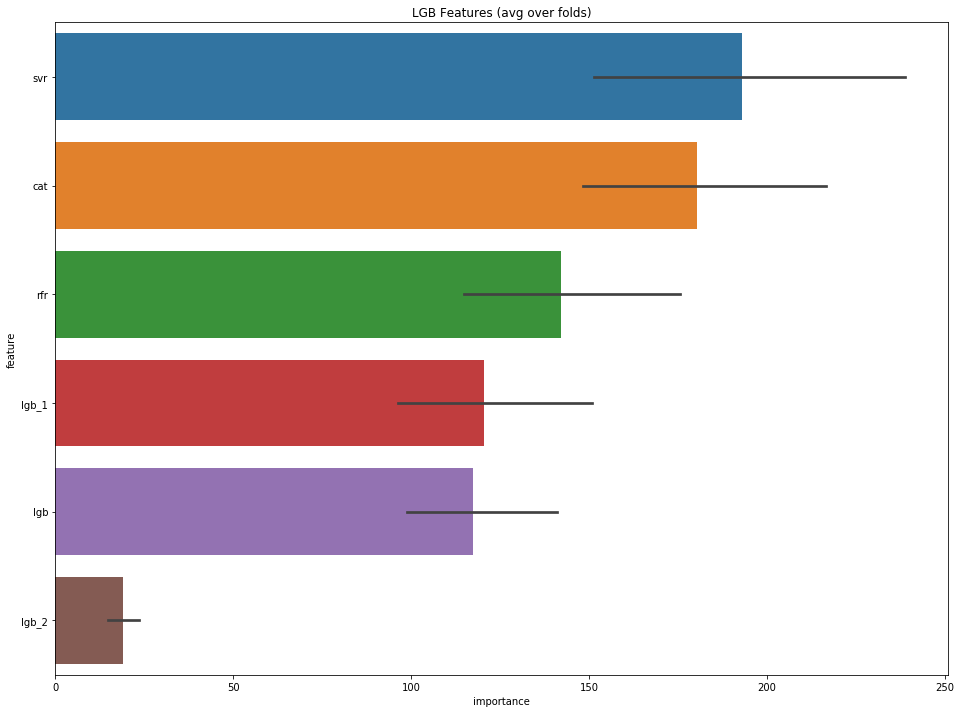

In [242]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [243]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:44:03 2019
Fold 1 started at Sun Dec 15 14:44:05 2019
Fold 2 started at Sun Dec 15 14:44:06 2019
Fold 3 started at Sun Dec 15 14:44:09 2019
Fold 4 started at Sun Dec 15 14:44:11 2019
Fold 5 started at Sun Dec 15 14:44:12 2019
Fold 6 started at Sun Dec 15 14:44:14 2019
Fold 7 started at Sun Dec 15 14:44:17 2019
Fold 8 started at Sun Dec 15 14:44:20 2019
Fold 9 started at Sun Dec 15 14:44:22 2019
CV mean score: 0.1176, std: 0.0073.


random forest做第二层融合模型

In [244]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:44:23 2019
Fold 1 started at Sun Dec 15 14:44:24 2019
Fold 2 started at Sun Dec 15 14:44:24 2019
Fold 3 started at Sun Dec 15 14:44:24 2019
Fold 4 started at Sun Dec 15 14:44:24 2019
Fold 5 started at Sun Dec 15 14:44:25 2019
Fold 6 started at Sun Dec 15 14:44:25 2019
Fold 7 started at Sun Dec 15 14:44:25 2019
Fold 8 started at Sun Dec 15 14:44:25 2019
Fold 9 started at Sun Dec 15 14:44:26 2019
CV mean score: 0.1203, std: 0.0072.


xgboost做第二层融合模型

In [245]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:44:26 2019
[0]	train-rmse:0.48236	valid_data-rmse:0.473674
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066055	valid_data-rmse:0.136298
Stopping. Best iteration:
[327]	train-rmse:0.077373	valid_data-rmse:0.135444

Fold 1 started at Sun Dec 15 14:44:26 2019
[0]	train-rmse:0.481836	valid_data-rmse:0.47847
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.067103	valid_data-rmse:0.126561
Stopping. Best iteration:
[552]	train-rmse:0.064851	valid_data-rmse:0.126399

Fold 2 started at Sun Dec 15 14:44:27 2019
[0]	train-rmse:0.480839	valid_data-rmse:0.487375
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.


#### SVR作为meta

In [246]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:44:32 2019
Fold 1 started at Sun Dec 15 14:44:32 2019
Fold 2 started at Sun Dec 15 14:44:32 2019
Fold 3 started at Sun Dec 15 14:44:32 2019
Fold 4 started at Sun Dec 15 14:44:32 2019
Fold 5 started at Sun Dec 15 14:44:32 2019
Fold 6 started at Sun Dec 15 14:44:32 2019
Fold 7 started at Sun Dec 15 14:44:32 2019
Fold 8 started at Sun Dec 15 14:44:32 2019
Fold 9 started at Sun Dec 15 14:44:32 2019
CV mean score: 0.1169, std: 0.0078.


用岭回归做第二层融合模型

In [247]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:44:32 2019
Fold 1 started at Sun Dec 15 14:44:32 2019
Fold 2 started at Sun Dec 15 14:44:32 2019
Fold 3 started at Sun Dec 15 14:44:32 2019
Fold 4 started at Sun Dec 15 14:44:32 2019
Fold 5 started at Sun Dec 15 14:44:32 2019
Fold 6 started at Sun Dec 15 14:44:32 2019
Fold 7 started at Sun Dec 15 14:44:32 2019
Fold 8 started at Sun Dec 15 14:44:33 2019
Fold 9 started at Sun Dec 15 14:44:33 2019
CV mean score: 0.1169, std: 0.0077.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 14:44:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.111831	valid_1's rmse: 0.12211
Fold 1 started at Sun Dec 15 14:44:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[481]	training's rmse: 0.107865	valid_1's rmse: 0.121108
Fold 2 started at Sun Dec 15 14:44:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.110959	valid_1's rmse: 0.116764
Fold 3 started at Sun Dec 15 14:44:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[449]	training's rmse: 0.108502	valid_1's rmse: 0.115524
Fold 4 started at Sun Dec 15 14:44:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[251]	training's rmse: 0.111467	valid_1's rmse: 0.123704
Fold 5 star

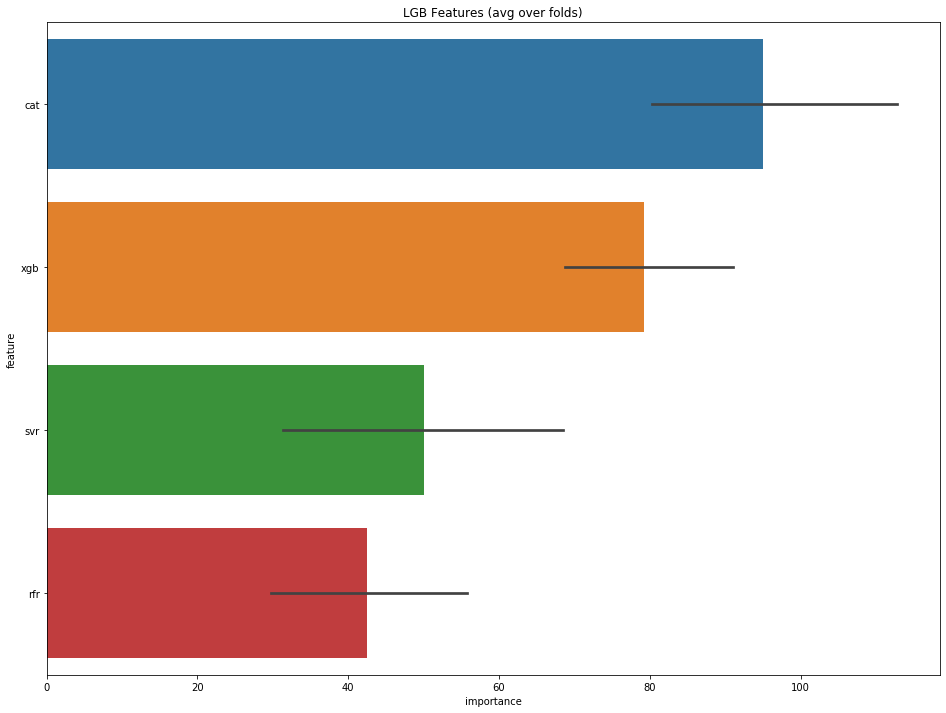

In [248]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:44:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.10242	valid_1's rmse: 0.12787
Fold 1 started at Sun Dec 15 14:44:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[385]	training's rmse: 0.097065	valid_1's rmse: 0.123079
Fold 2 started at Sun Dec 15 14:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.102944	valid_1's rmse: 0.118928
Fold 3 started at Sun Dec 15 14:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 0.101908	valid_1's rmse: 0.115919
Fold 4 started at Sun Dec 15 14:44:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[276]	training's rmse: 0.101695	valid_1's rmse: 0.123007
Fold 5 start

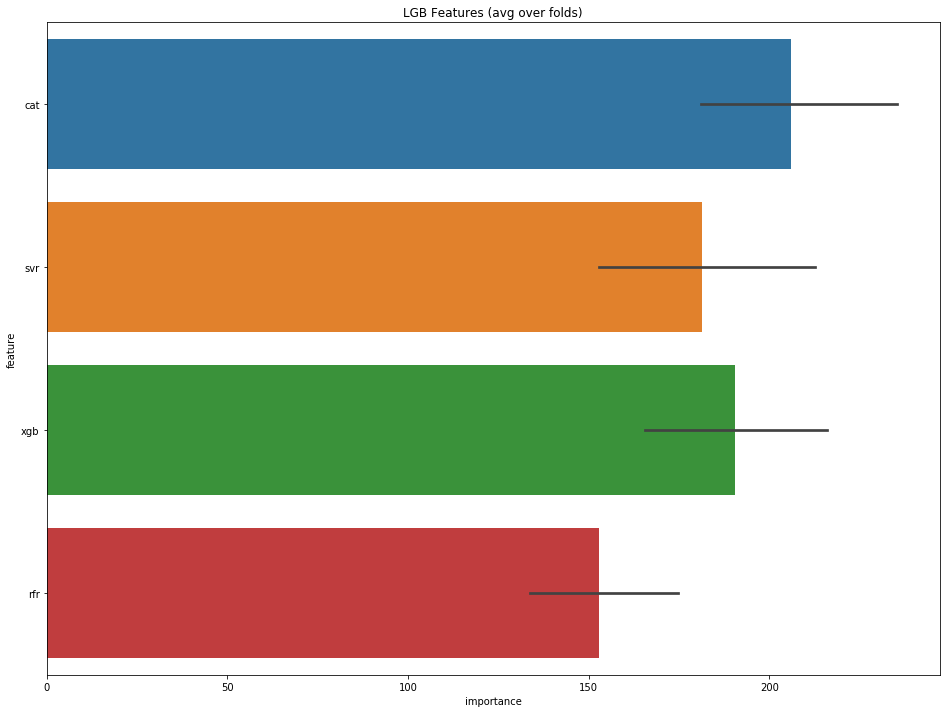

In [249]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [250]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:44:38 2019
Fold 1 started at Sun Dec 15 14:44:40 2019
Fold 2 started at Sun Dec 15 14:44:42 2019
Fold 3 started at Sun Dec 15 14:44:45 2019
Fold 4 started at Sun Dec 15 14:44:46 2019
Fold 5 started at Sun Dec 15 14:44:48 2019
Fold 6 started at Sun Dec 15 14:44:50 2019
Fold 7 started at Sun Dec 15 14:44:54 2019
Fold 8 started at Sun Dec 15 14:44:57 2019
Fold 9 started at Sun Dec 15 14:44:59 2019
CV mean score: 0.1169, std: 0.0070.


random forest做第二层融合模型

In [251]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:45:00 2019
Fold 1 started at Sun Dec 15 14:45:00 2019
Fold 2 started at Sun Dec 15 14:45:00 2019
Fold 3 started at Sun Dec 15 14:45:01 2019
Fold 4 started at Sun Dec 15 14:45:01 2019
Fold 5 started at Sun Dec 15 14:45:01 2019
Fold 6 started at Sun Dec 15 14:45:01 2019
Fold 7 started at Sun Dec 15 14:45:02 2019
Fold 8 started at Sun Dec 15 14:45:02 2019
Fold 9 started at Sun Dec 15 14:45:02 2019
CV mean score: 0.1181, std: 0.0068.


xgboost做第二层融合模型

In [252]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:45:02 2019
[0]	train-rmse:0.482355	valid_data-rmse:0.473601
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.06492	valid_data-rmse:0.131464
Stopping. Best iteration:
[359]	train-rmse:0.073285	valid_data-rmse:0.130889

Fold 1 started at Sun Dec 15 14:45:03 2019
[0]	train-rmse:0.481836	valid_data-rmse:0.478482
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.066875	valid_data-rmse:0.125737
Stopping. Best iteration:
[441]	train-rmse:0.069713	valid_data-rmse:0.12568

Fold 2 started at Sun Dec 15 14:45:03 2019
[0]	train-rmse:0.48085	valid_data-rmse:0.487332
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[

#### SVR作为meta

In [253]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:45:08 2019
Fold 1 started at Sun Dec 15 14:45:08 2019
Fold 2 started at Sun Dec 15 14:45:08 2019
Fold 3 started at Sun Dec 15 14:45:08 2019
Fold 4 started at Sun Dec 15 14:45:08 2019
Fold 5 started at Sun Dec 15 14:45:08 2019
Fold 6 started at Sun Dec 15 14:45:08 2019
Fold 7 started at Sun Dec 15 14:45:08 2019
Fold 8 started at Sun Dec 15 14:45:08 2019
Fold 9 started at Sun Dec 15 14:45:08 2019
CV mean score: 0.1169, std: 0.0077.


用岭回归做第二层融合模型

In [254]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:45:08 2019
Fold 1 started at Sun Dec 15 14:45:08 2019
Fold 2 started at Sun Dec 15 14:45:08 2019
Fold 3 started at Sun Dec 15 14:45:08 2019
Fold 4 started at Sun Dec 15 14:45:08 2019
Fold 5 started at Sun Dec 15 14:45:08 2019
Fold 6 started at Sun Dec 15 14:45:08 2019
Fold 7 started at Sun Dec 15 14:45:08 2019
Fold 8 started at Sun Dec 15 14:45:08 2019
Fold 9 started at Sun Dec 15 14:45:08 2019
CV mean score: 0.1169, std: 0.0075.


## mpg 数据集实验

In [255]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('mpg')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [256]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[720]	training's rmse: 1.72272	valid_1's rmse: 3.54768


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [257]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 14:45:09 2019
Fold 1 started at Sun Dec 15 14:45:09 2019
Fold 2 started at Sun Dec 15 14:45:09 2019
Fold 3 started at Sun Dec 15 14:45:09 2019
Fold 4 started at Sun Dec 15 14:45:09 2019
Fold 5 started at Sun Dec 15 14:45:09 2019
Fold 6 started at Sun Dec 15 14:45:09 2019
Fold 7 started at Sun Dec 15 14:45:09 2019
Fold 8 started at Sun Dec 15 14:45:09 2019
Fold 9 started at Sun Dec 15 14:45:09 2019
CV mean score: 7.8100, std: 0.6673.


Fold 0 started at Sun Dec 15 14:45:09 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.57388	valid_1's rmse: 2.08215
Early stopping, best iteration is:
[1044]	training's rmse: 1.54872	valid_1's rmse: 2.07603
Fold 1 started at Sun Dec 15 14:45:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[750]	training's rmse: 1.72413	valid_1's rmse: 2.60837
Fold 2 started at Sun Dec 15 14:45:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34621	valid_1's rmse: 2.73216
Fold 3 started at Sun Dec 15 14:45:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.51796	valid_1's rmse: 2.73624
Early stopping, best iteration is:
[934]	training's rmse: 1.55771	valid_1's rmse: 2.72658
Fold 4 started at Sun Dec 15 14:45:10 2019
Training until validation scores don't improve for 200 round

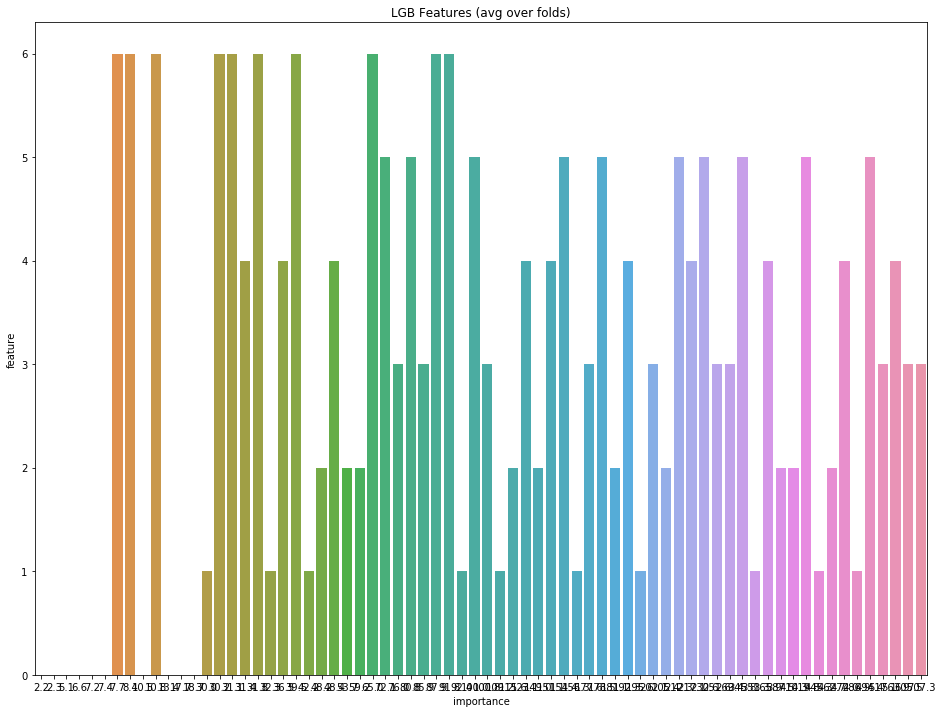

In [258]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:45:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.67748	valid_1's rmse: 2.06332
Early stopping, best iteration is:
[1005]	training's rmse: 1.67462	valid_1's rmse: 2.06129
Fold 1 started at Sun Dec 15 14:45:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.65909	valid_1's rmse: 2.61406
Early stopping, best iteration is:
[1497]	training's rmse: 1.44379	valid_1's rmse: 2.59095
Fold 2 started at Sun Dec 15 14:45:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34906	valid_1's rmse: 2.7348
Fold 3 started at Sun Dec 15 14:45:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.62375	valid_1's rmse: 2.7582
Early stopping, best iteration is:
[821]	training's rmse: 1.72261	valid_1's rmse: 2.74796
Fold 4 started at Sun Dec 15 14:45:16 2019
Train

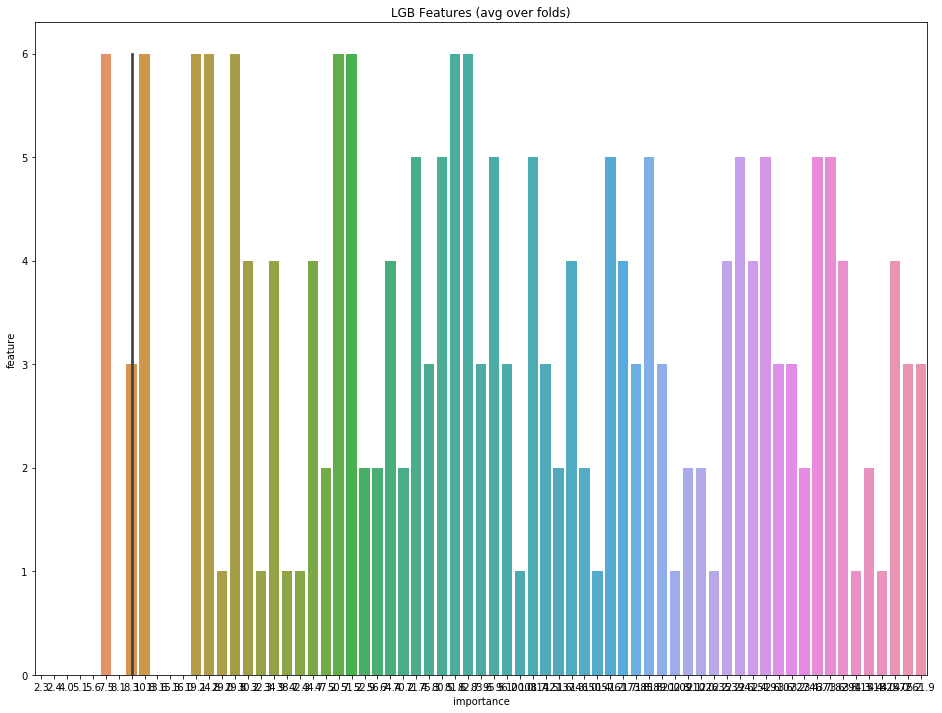

In [259]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:45:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.67748	valid_1's rmse: 2.06332
Early stopping, best iteration is:
[1005]	training's rmse: 1.67462	valid_1's rmse: 2.06129
Fold 1 started at Sun Dec 15 14:45:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.65909	valid_1's rmse: 2.61406
Early stopping, best iteration is:
[1497]	training's rmse: 1.44379	valid_1's rmse: 2.59095
Fold 2 started at Sun Dec 15 14:45:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 2.34906	valid_1's rmse: 2.7348
Fold 3 started at Sun Dec 15 14:45:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.62375	valid_1's rmse: 2.7582
Early stopping, best iteration is:
[821]	training's rmse: 1.72261	valid_1's rmse: 2.74796
Fold 4 started at Sun Dec 15 14:45:21 2019
Train

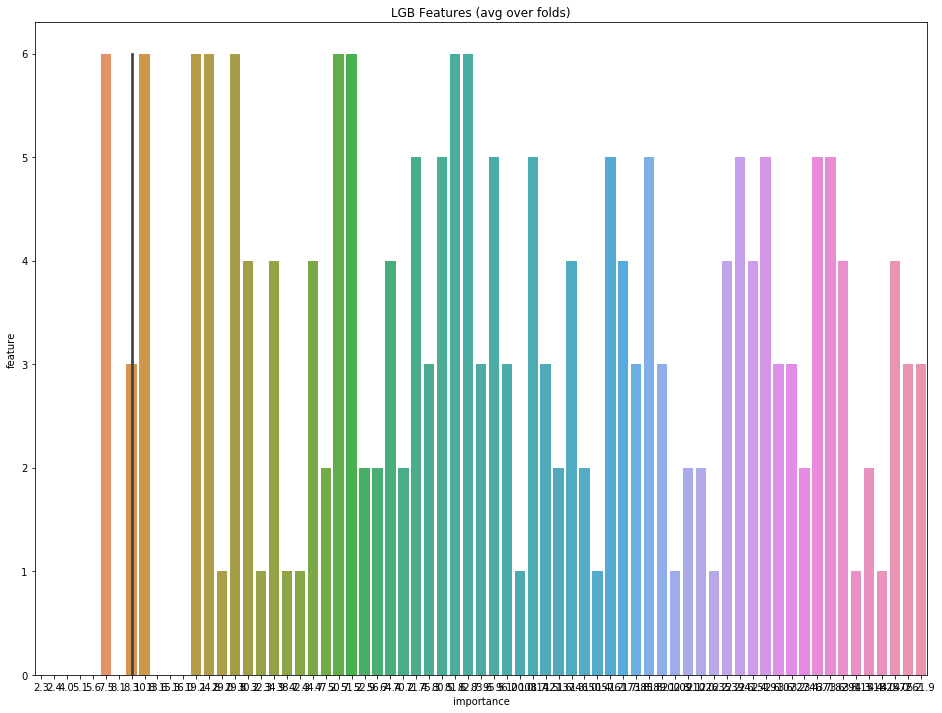

In [260]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [261]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 14:45:25 2019
Fold 1 started at Sun Dec 15 14:45:25 2019
Fold 2 started at Sun Dec 15 14:45:25 2019
Fold 3 started at Sun Dec 15 14:45:26 2019
Fold 4 started at Sun Dec 15 14:45:26 2019
Fold 5 started at Sun Dec 15 14:45:26 2019
Fold 6 started at Sun Dec 15 14:45:26 2019
Fold 7 started at Sun Dec 15 14:45:27 2019
Fold 8 started at Sun Dec 15 14:45:27 2019
Fold 9 started at Sun Dec 15 14:45:27 2019
CV mean score: 2.9381, std: 0.5400.


In [262]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:45:27 2019
[0]	train-rmse:23.9882	valid_data-rmse:24.1119
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.9723	valid_data-rmse:2.2089
Stopping. Best iteration:
[701]	train-rmse:0.607195	valid_data-rmse:2.18604

Fold 1 started at Sun Dec 15 14:45:28 2019
[0]	train-rmse:24.1986	valid_data-rmse:22.168
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.970502	valid_data-rmse:2.25273
Stopping. Best iteration:
[584]	train-rmse:0.77059	valid_data-rmse:2.23718

Fold 2 started at Sun Dec 15 14:45:28 2019
[0]	train-rmse:24.0152	valid_data-rmse:23.8663
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

In [263]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:45:33 2019
Fold 1 started at Sun Dec 15 14:45:36 2019
Fold 2 started at Sun Dec 15 14:45:46 2019
Fold 3 started at Sun Dec 15 14:45:47 2019
Fold 4 started at Sun Dec 15 14:45:49 2019
Fold 5 started at Sun Dec 15 14:45:53 2019
Fold 6 started at Sun Dec 15 14:45:59 2019
Fold 7 started at Sun Dec 15 14:46:10 2019
Fold 8 started at Sun Dec 15 14:46:13 2019
Fold 9 started at Sun Dec 15 14:46:17 2019
CV mean score: 2.6264, std: 0.3991.


## stacking

Fold 0 started at Sun Dec 15 14:46:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[506]	training's rmse: 2.30297	valid_1's rmse: 2.25818
Fold 1 started at Sun Dec 15 14:46:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 2.46845	valid_1's rmse: 2.35737
Fold 2 started at Sun Dec 15 14:46:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[212]	training's rmse: 2.53804	valid_1's rmse: 2.76511
Fold 3 started at Sun Dec 15 14:46:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[492]	training's rmse: 2.25639	valid_1's rmse: 2.6044
Fold 4 started at Sun Dec 15 14:46:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[310]	training's rmse: 2.19963	valid_1's rmse: 3.93138
Fold 5 started at Sun

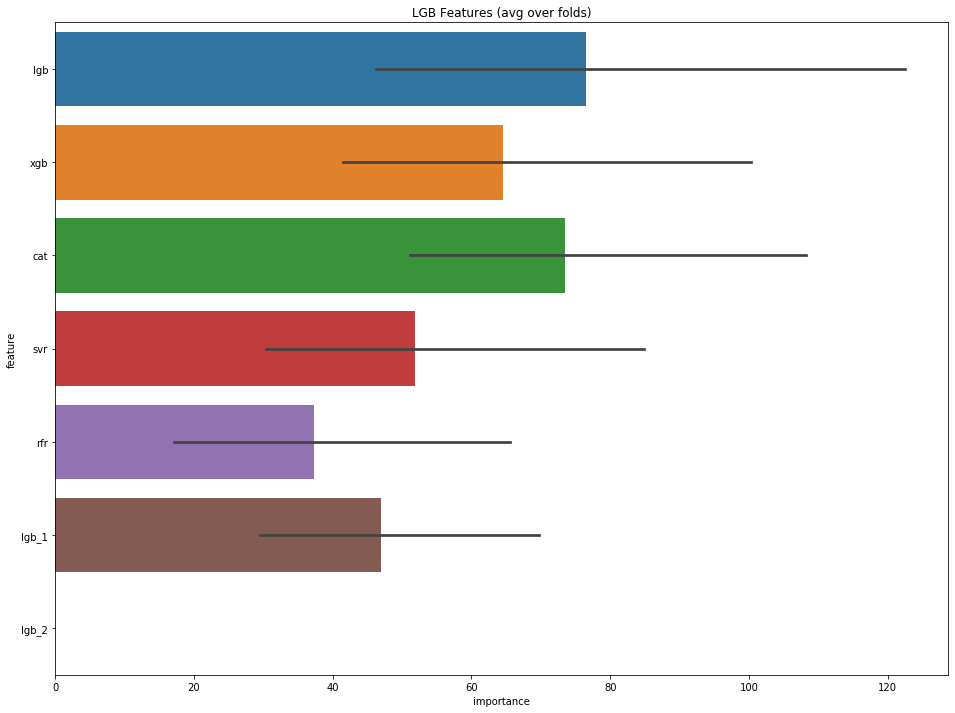

In [264]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:46:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[547]	training's rmse: 2.1086	valid_1's rmse: 2.26951
Fold 1 started at Sun Dec 15 14:46:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 2.44543	valid_1's rmse: 2.35456
Fold 2 started at Sun Dec 15 14:46:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.42733	valid_1's rmse: 2.76241
Fold 3 started at Sun Dec 15 14:46:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[383]	training's rmse: 2.18927	valid_1's rmse: 2.63642
Fold 4 started at Sun Dec 15 14:46:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[337]	training's rmse: 2.09617	valid_1's rmse: 3.88072
Fold 5 started at Sun

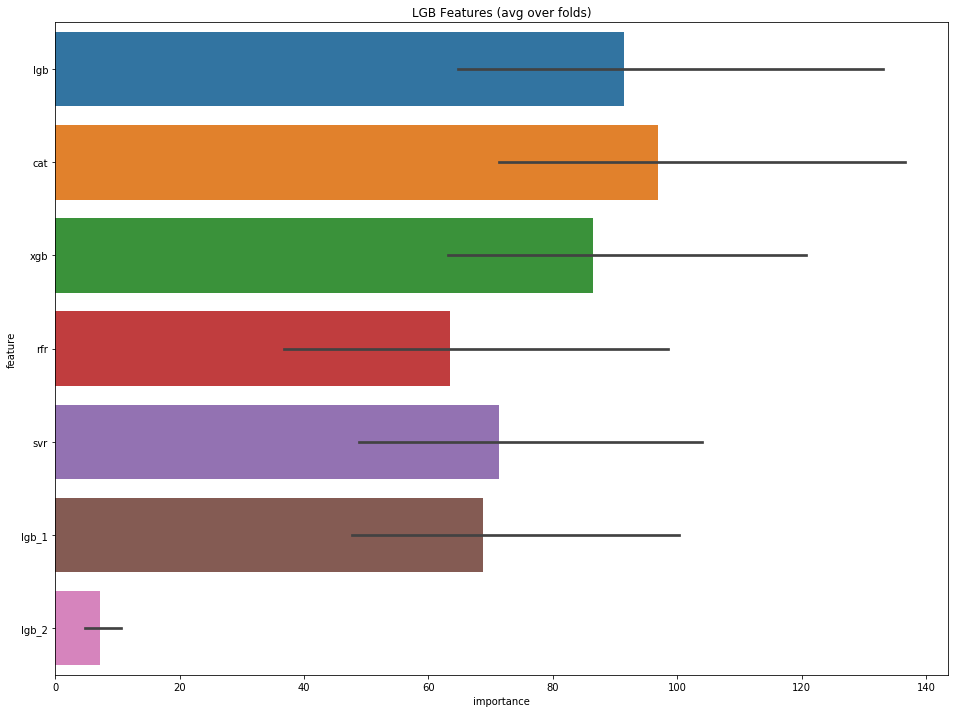

In [265]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [266]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:46:25 2019
Fold 1 started at Sun Dec 15 14:46:27 2019
Fold 2 started at Sun Dec 15 14:46:29 2019
Fold 3 started at Sun Dec 15 14:46:30 2019
Fold 4 started at Sun Dec 15 14:46:32 2019
Fold 5 started at Sun Dec 15 14:46:34 2019
Fold 6 started at Sun Dec 15 14:46:36 2019
Fold 7 started at Sun Dec 15 14:46:41 2019
Fold 8 started at Sun Dec 15 14:46:43 2019
Fold 9 started at Sun Dec 15 14:46:44 2019
CV mean score: 2.6877, std: 0.4916.


random forest做第二层融合模型

In [267]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:46:47 2019
Fold 1 started at Sun Dec 15 14:46:47 2019
Fold 2 started at Sun Dec 15 14:46:47 2019
Fold 3 started at Sun Dec 15 14:46:47 2019
Fold 4 started at Sun Dec 15 14:46:48 2019
Fold 5 started at Sun Dec 15 14:46:48 2019
Fold 6 started at Sun Dec 15 14:46:48 2019
Fold 7 started at Sun Dec 15 14:46:48 2019
Fold 8 started at Sun Dec 15 14:46:49 2019
Fold 9 started at Sun Dec 15 14:46:49 2019
CV mean score: 2.7608, std: 0.4681.


xgboost做第二层融合模型

In [268]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:46:49 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.18322	valid_data-rmse:2.33411
Stopping. Best iteration:
[460]	train-rmse:1.29494	valid_data-rmse:2.3223

Fold 1 started at Sun Dec 15 14:46:49 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.16437	valid_data-rmse:2.60922
Stopping. Best iteration:
[392]	train-rmse:1.54359	valid_data-rmse:2.57498

Fold 2 started at Sun Dec 15 14:46:50 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.867
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [269]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:46:52 2019
Fold 1 started at Sun Dec 15 14:46:52 2019
Fold 2 started at Sun Dec 15 14:46:52 2019
Fold 3 started at Sun Dec 15 14:46:52 2019
Fold 4 started at Sun Dec 15 14:46:52 2019
Fold 5 started at Sun Dec 15 14:46:52 2019
Fold 6 started at Sun Dec 15 14:46:52 2019
Fold 7 started at Sun Dec 15 14:46:52 2019
Fold 8 started at Sun Dec 15 14:46:52 2019
Fold 9 started at Sun Dec 15 14:46:52 2019
CV mean score: 3.7810, std: 0.8912.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 14:46:52 2019
Fold 1 started at Sun Dec 15 14:46:52 2019
Fold 2 started at Sun Dec 15 14:46:52 2019
Fold 3 started at Sun Dec 15 14:46:52 2019
Fold 4 started at Sun Dec 15 14:46:52 2019
Fold 5 started at Sun Dec 15 14:46:52 2019
Fold 6 started at Sun Dec 15 14:46:52 2019
Fold 7 started at Sun Dec 15 14:46:52 2019
Fold 8 started at Sun Dec 15 14:46:52 2019
Fold 9 started at Sun Dec 15 14:46:52 2019
CV mean score: 2.5999, std: 0.4378.
Fold 0 started at Sun Dec 15 14:46:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[494]	training's rmse: 2.34469	valid_1's rmse: 2.20511
Fold 1 started at Sun Dec 15 14:46:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 2.50544	valid_1's rmse: 2.36486
Fold 2 started at Sun Dec 15 14:46:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

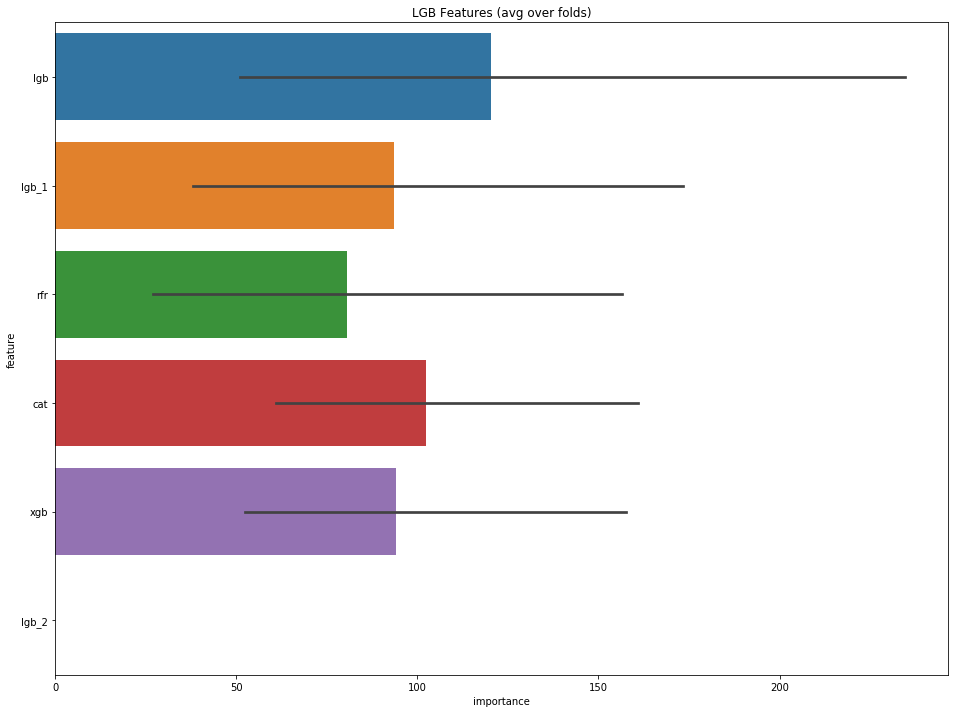

In [270]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:46:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[533]	training's rmse: 2.20383	valid_1's rmse: 2.21923
Fold 1 started at Sun Dec 15 14:46:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's rmse: 2.48957	valid_1's rmse: 2.39161
Fold 2 started at Sun Dec 15 14:46:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 2.43738	valid_1's rmse: 2.72185
Fold 3 started at Sun Dec 15 14:46:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 2.24101	valid_1's rmse: 2.537
Fold 4 started at Sun Dec 15 14:46:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[345]	training's rmse: 2.13061	valid_1's rmse: 3.87352
Fold 5 started at Sun 

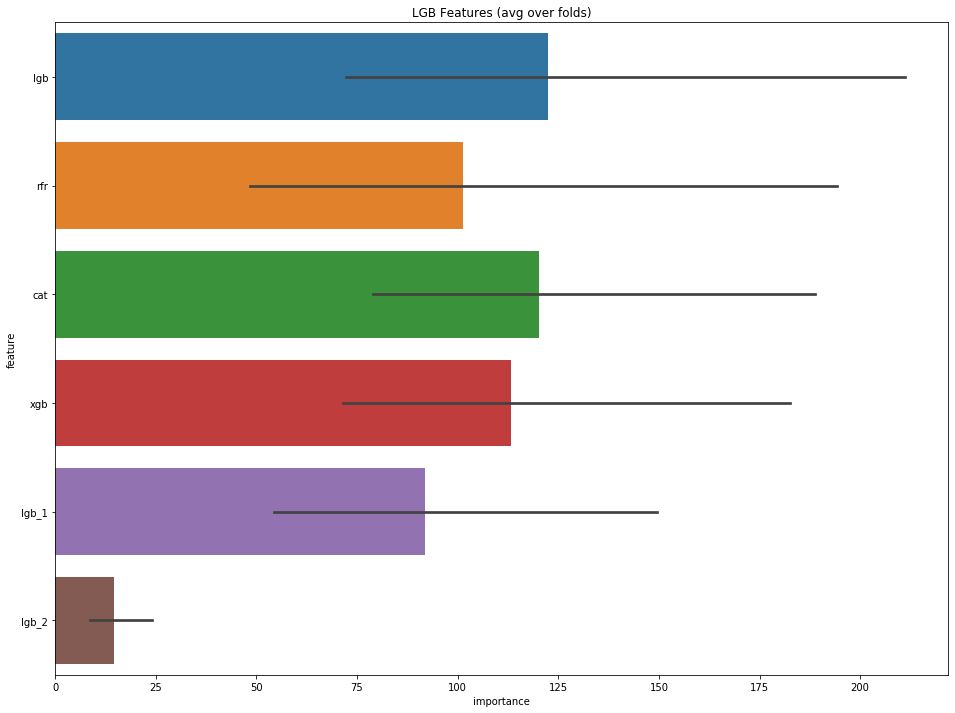

In [271]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [272]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:46:59 2019
Fold 1 started at Sun Dec 15 14:47:01 2019
Fold 2 started at Sun Dec 15 14:47:03 2019
Fold 3 started at Sun Dec 15 14:47:04 2019
Fold 4 started at Sun Dec 15 14:47:05 2019
Fold 5 started at Sun Dec 15 14:47:07 2019
Fold 6 started at Sun Dec 15 14:47:10 2019
Fold 7 started at Sun Dec 15 14:47:14 2019
Fold 8 started at Sun Dec 15 14:47:15 2019
Fold 9 started at Sun Dec 15 14:47:17 2019
CV mean score: 2.6701, std: 0.4895.


random forest做第二层融合模型

In [273]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:47:18 2019
Fold 1 started at Sun Dec 15 14:47:19 2019
Fold 2 started at Sun Dec 15 14:47:19 2019
Fold 3 started at Sun Dec 15 14:47:19 2019
Fold 4 started at Sun Dec 15 14:47:19 2019
Fold 5 started at Sun Dec 15 14:47:20 2019
Fold 6 started at Sun Dec 15 14:47:20 2019
Fold 7 started at Sun Dec 15 14:47:20 2019
Fold 8 started at Sun Dec 15 14:47:20 2019
Fold 9 started at Sun Dec 15 14:47:21 2019
CV mean score: 2.7460, std: 0.4842.


xgboost做第二层融合模型

In [274]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:47:21 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.25532	valid_data-rmse:2.26023
Stopping. Best iteration:
[475]	train-rmse:1.32723	valid_data-rmse:2.24933

Fold 1 started at Sun Dec 15 14:47:21 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24169	valid_data-rmse:2.63318
Stopping. Best iteration:
[382]	train-rmse:1.66923	valid_data-rmse:2.57591

Fold 2 started at Sun Dec 15 14:47:21 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.867
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [275]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:47:24 2019
Fold 1 started at Sun Dec 15 14:47:24 2019
Fold 2 started at Sun Dec 15 14:47:24 2019
Fold 3 started at Sun Dec 15 14:47:24 2019
Fold 4 started at Sun Dec 15 14:47:24 2019
Fold 5 started at Sun Dec 15 14:47:24 2019
Fold 6 started at Sun Dec 15 14:47:24 2019
Fold 7 started at Sun Dec 15 14:47:24 2019
Fold 8 started at Sun Dec 15 14:47:24 2019
Fold 9 started at Sun Dec 15 14:47:24 2019
CV mean score: 3.8783, std: 0.8822.


用岭回归做第二层融合模型

In [276]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:47:24 2019
Fold 1 started at Sun Dec 15 14:47:24 2019
Fold 2 started at Sun Dec 15 14:47:24 2019
Fold 3 started at Sun Dec 15 14:47:24 2019
Fold 4 started at Sun Dec 15 14:47:24 2019
Fold 5 started at Sun Dec 15 14:47:24 2019
Fold 6 started at Sun Dec 15 14:47:24 2019
Fold 7 started at Sun Dec 15 14:47:24 2019
Fold 8 started at Sun Dec 15 14:47:24 2019
Fold 9 started at Sun Dec 15 14:47:24 2019
CV mean score: 2.6032, std: 0.4265.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 14:47:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[599]	training's rmse: 2.29601	valid_1's rmse: 2.29754
Fold 1 started at Sun Dec 15 14:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 2.52253	valid_1's rmse: 2.35158
Fold 2 started at Sun Dec 15 14:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's rmse: 2.52472	valid_1's rmse: 2.76261
Fold 3 started at Sun Dec 15 14:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 2.35106	valid_1's rmse: 2.61214
Fold 4 started at Sun Dec 15 14:47:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[312]	training's rmse: 2.21038	valid_1's rmse: 3.9204
Fold 5 started at Sun

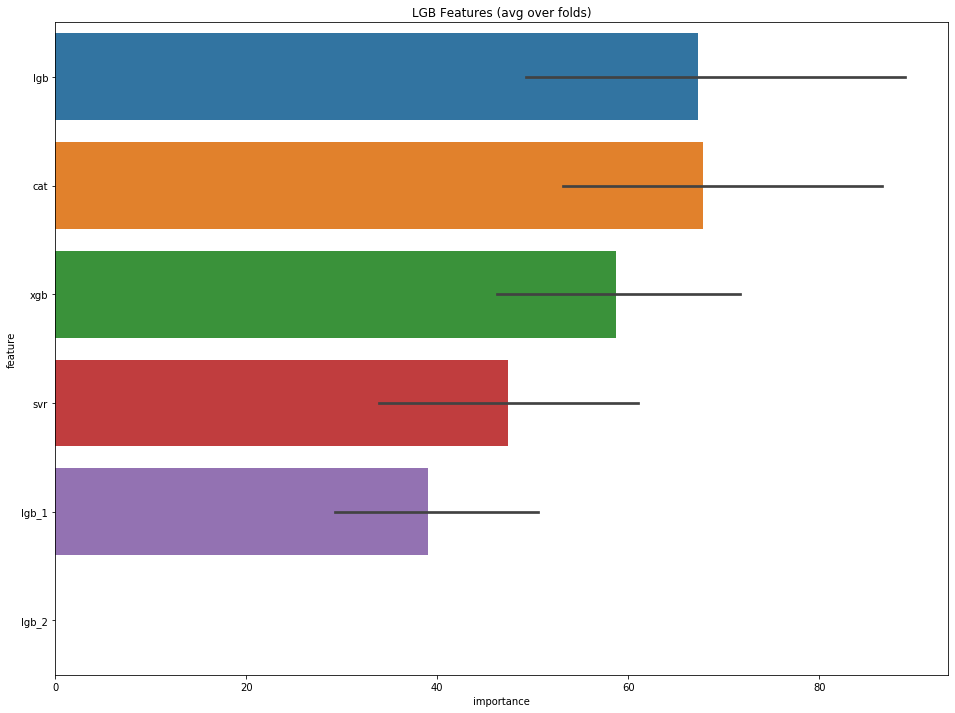

In [277]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:47:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[364]	training's rmse: 2.27618	valid_1's rmse: 2.33917
Fold 1 started at Sun Dec 15 14:47:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 2.42484	valid_1's rmse: 2.35831
Fold 2 started at Sun Dec 15 14:47:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.43648	valid_1's rmse: 2.76727
Fold 3 started at Sun Dec 15 14:47:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 2.27839	valid_1's rmse: 2.65877
Fold 4 started at Sun Dec 15 14:47:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 2.15364	valid_1's rmse: 3.89048
Fold 5 started at Su

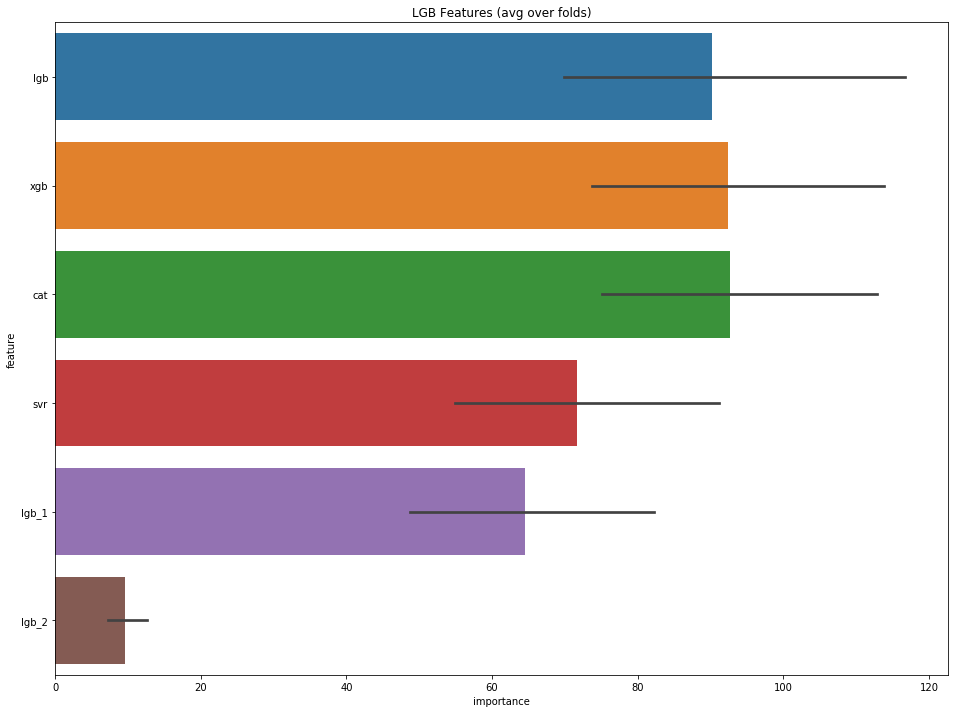

In [278]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [279]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:47:30 2019
Fold 1 started at Sun Dec 15 14:47:31 2019
Fold 2 started at Sun Dec 15 14:47:33 2019
Fold 3 started at Sun Dec 15 14:47:34 2019
Fold 4 started at Sun Dec 15 14:47:36 2019
Fold 5 started at Sun Dec 15 14:47:39 2019
Fold 6 started at Sun Dec 15 14:47:42 2019
Fold 7 started at Sun Dec 15 14:47:45 2019
Fold 8 started at Sun Dec 15 14:47:46 2019
Fold 9 started at Sun Dec 15 14:47:48 2019
CV mean score: 2.6687, std: 0.4635.


random forest做第二层融合模型

In [280]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:47:50 2019
Fold 1 started at Sun Dec 15 14:47:50 2019
Fold 2 started at Sun Dec 15 14:47:50 2019
Fold 3 started at Sun Dec 15 14:47:50 2019
Fold 4 started at Sun Dec 15 14:47:51 2019
Fold 5 started at Sun Dec 15 14:47:51 2019
Fold 6 started at Sun Dec 15 14:47:51 2019
Fold 7 started at Sun Dec 15 14:47:51 2019
Fold 8 started at Sun Dec 15 14:47:52 2019
Fold 9 started at Sun Dec 15 14:47:52 2019
CV mean score: 2.7695, std: 0.4330.


xgboost做第二层融合模型

In [281]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:47:52 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.2779	valid_data-rmse:2.27751
Stopping. Best iteration:
[457]	train-rmse:1.39647	valid_data-rmse:2.27333

Fold 1 started at Sun Dec 15 14:47:52 2019
[0]	train-rmse:24.1965	valid_data-rmse:22.1736
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24097	valid_data-rmse:2.5934
Stopping. Best iteration:
[420]	train-rmse:1.48775	valid_data-rmse:2.55755

Fold 2 started at Sun Dec 15 14:47:53 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8629
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rms

#### SVR作为meta

In [282]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:47:54 2019
Fold 1 started at Sun Dec 15 14:47:54 2019
Fold 2 started at Sun Dec 15 14:47:54 2019
Fold 3 started at Sun Dec 15 14:47:54 2019
Fold 4 started at Sun Dec 15 14:47:55 2019
Fold 5 started at Sun Dec 15 14:47:55 2019
Fold 6 started at Sun Dec 15 14:47:55 2019
Fold 7 started at Sun Dec 15 14:47:55 2019
Fold 8 started at Sun Dec 15 14:47:55 2019
Fold 9 started at Sun Dec 15 14:47:55 2019
CV mean score: 3.6285, std: 0.8807.


用岭回归做第二层融合模型

In [283]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:47:55 2019
Fold 1 started at Sun Dec 15 14:47:55 2019
Fold 2 started at Sun Dec 15 14:47:55 2019
Fold 3 started at Sun Dec 15 14:47:55 2019
Fold 4 started at Sun Dec 15 14:47:55 2019
Fold 5 started at Sun Dec 15 14:47:55 2019
Fold 6 started at Sun Dec 15 14:47:55 2019
Fold 7 started at Sun Dec 15 14:47:55 2019
Fold 8 started at Sun Dec 15 14:47:55 2019
Fold 9 started at Sun Dec 15 14:47:55 2019
CV mean score: 2.5953, std: 0.4482.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 14:47:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[773]	training's rmse: 2.30127	valid_1's rmse: 2.30511
Fold 1 started at Sun Dec 15 14:47:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[235]	training's rmse: 2.57792	valid_1's rmse: 2.47596
Fold 2 started at Sun Dec 15 14:47:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[198]	training's rmse: 2.63119	valid_1's rmse: 2.89858
Fold 3 started at Sun Dec 15 14:47:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[327]	training's rmse: 2.39493	valid_1's rmse: 2.7421
Fold 4 started at Sun Dec 15 14:47:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 2.27314	valid_1's rmse: 4.02602
Fold 5 started at Sun

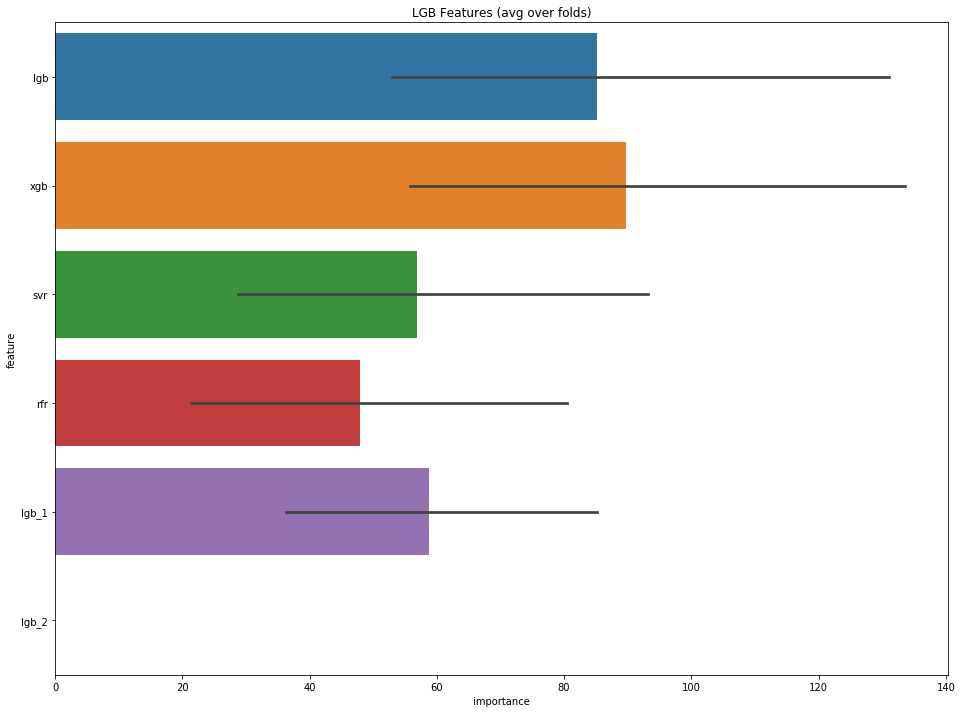

In [284]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:47:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.27001	valid_1's rmse: 2.32238
Fold 1 started at Sun Dec 15 14:47:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[234]	training's rmse: 2.51426	valid_1's rmse: 2.49615
Fold 2 started at Sun Dec 15 14:47:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's rmse: 2.56452	valid_1's rmse: 2.88411
Fold 3 started at Sun Dec 15 14:47:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[305]	training's rmse: 2.3333	valid_1's rmse: 2.72422
Fold 4 started at Sun Dec 15 14:47:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's rmse: 2.20797	valid_1's rmse: 3.9615
Fold 5 started at Sun 

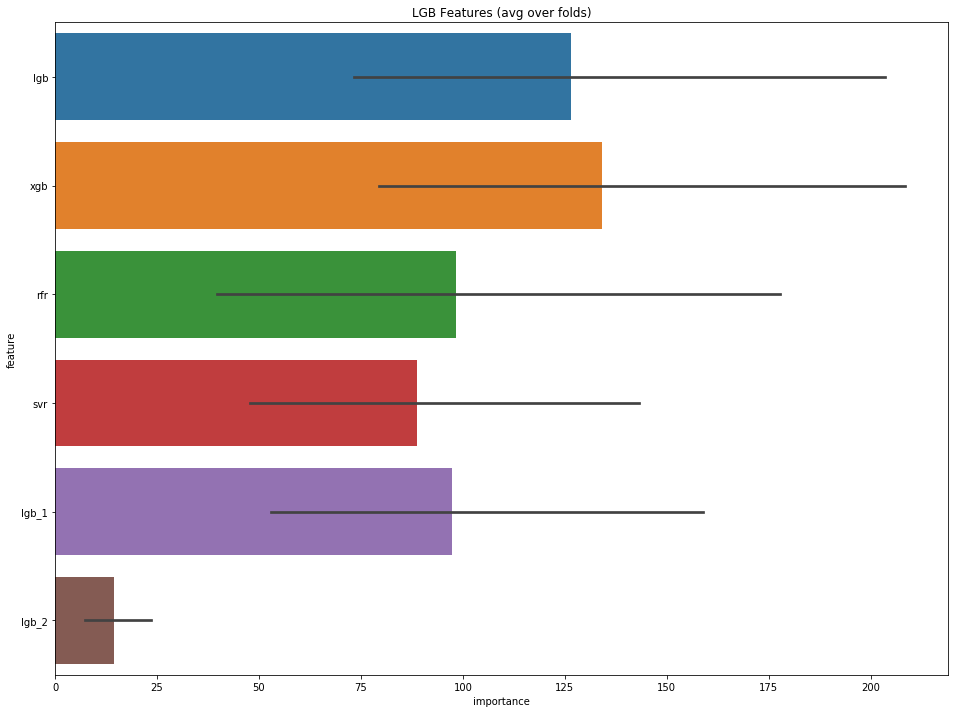

In [285]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [286]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:48:01 2019
Fold 1 started at Sun Dec 15 14:48:04 2019
Fold 2 started at Sun Dec 15 14:48:05 2019
Fold 3 started at Sun Dec 15 14:48:06 2019
Fold 4 started at Sun Dec 15 14:48:07 2019
Fold 5 started at Sun Dec 15 14:48:09 2019
Fold 6 started at Sun Dec 15 14:48:15 2019
Fold 7 started at Sun Dec 15 14:48:23 2019
Fold 8 started at Sun Dec 15 14:48:25 2019
Fold 9 started at Sun Dec 15 14:48:26 2019
CV mean score: 2.6801, std: 0.4796.


random forest做第二层融合模型

In [287]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:48:28 2019
Fold 1 started at Sun Dec 15 14:48:28 2019
Fold 2 started at Sun Dec 15 14:48:28 2019
Fold 3 started at Sun Dec 15 14:48:29 2019
Fold 4 started at Sun Dec 15 14:48:29 2019
Fold 5 started at Sun Dec 15 14:48:29 2019
Fold 6 started at Sun Dec 15 14:48:29 2019
Fold 7 started at Sun Dec 15 14:48:30 2019
Fold 8 started at Sun Dec 15 14:48:30 2019
Fold 9 started at Sun Dec 15 14:48:30 2019
CV mean score: 2.8535, std: 0.4405.


xgboost做第二层融合模型

In [288]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:48:30 2019
[0]	train-rmse:23.9857	valid_data-rmse:24.1082
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.27319	valid_data-rmse:2.37463
Stopping. Best iteration:
[442]	train-rmse:1.44231	valid_data-rmse:2.35732

Fold 1 started at Sun Dec 15 14:48:30 2019
[0]	train-rmse:24.1971	valid_data-rmse:22.1722
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.24868	valid_data-rmse:2.72403
Stopping. Best iteration:
[388]	train-rmse:1.63733	valid_data-rmse:2.67213

Fold 2 started at Sun Dec 15 14:48:31 2019
[0]	train-rmse:24.012	valid_data-rmse:23.8713
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [289]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:48:33 2019
Fold 1 started at Sun Dec 15 14:48:33 2019
Fold 2 started at Sun Dec 15 14:48:33 2019
Fold 3 started at Sun Dec 15 14:48:33 2019
Fold 4 started at Sun Dec 15 14:48:33 2019
Fold 5 started at Sun Dec 15 14:48:33 2019
Fold 6 started at Sun Dec 15 14:48:33 2019
Fold 7 started at Sun Dec 15 14:48:33 2019
Fold 8 started at Sun Dec 15 14:48:33 2019
Fold 9 started at Sun Dec 15 14:48:33 2019
CV mean score: 3.7697, std: 0.8700.


用岭回归做第二层融合模型

In [290]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 14:48:33 2019
Fold 1 started at Sun Dec 15 14:48:33 2019
Fold 2 started at Sun Dec 15 14:48:33 2019
Fold 3 started at Sun Dec 15 14:48:33 2019
Fold 4 started at Sun Dec 15 14:48:33 2019
Fold 5 started at Sun Dec 15 14:48:33 2019
Fold 6 started at Sun Dec 15 14:48:33 2019
Fold 7 started at Sun Dec 15 14:48:33 2019
Fold 8 started at Sun Dec 15 14:48:33 2019
Fold 9 started at Sun Dec 15 14:48:34 2019
CV mean score: 2.6291, std: 0.4679.


### 去掉xgboost

Fold 0 started at Sun Dec 15 14:48:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[672]	training's rmse: 2.29224	valid_1's rmse: 2.25589
Fold 1 started at Sun Dec 15 14:48:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 2.50364	valid_1's rmse: 2.36047
Fold 2 started at Sun Dec 15 14:48:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[206]	training's rmse: 2.57107	valid_1's rmse: 2.8162
Fold 3 started at Sun Dec 15 14:48:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[381]	training's rmse: 2.32001	valid_1's rmse: 2.62135
Fold 4 started at Sun Dec 15 14:48:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 2.03801	valid_1's rmse: 3.791
Early stopping, best iteration is:
[1185]	training's rmse

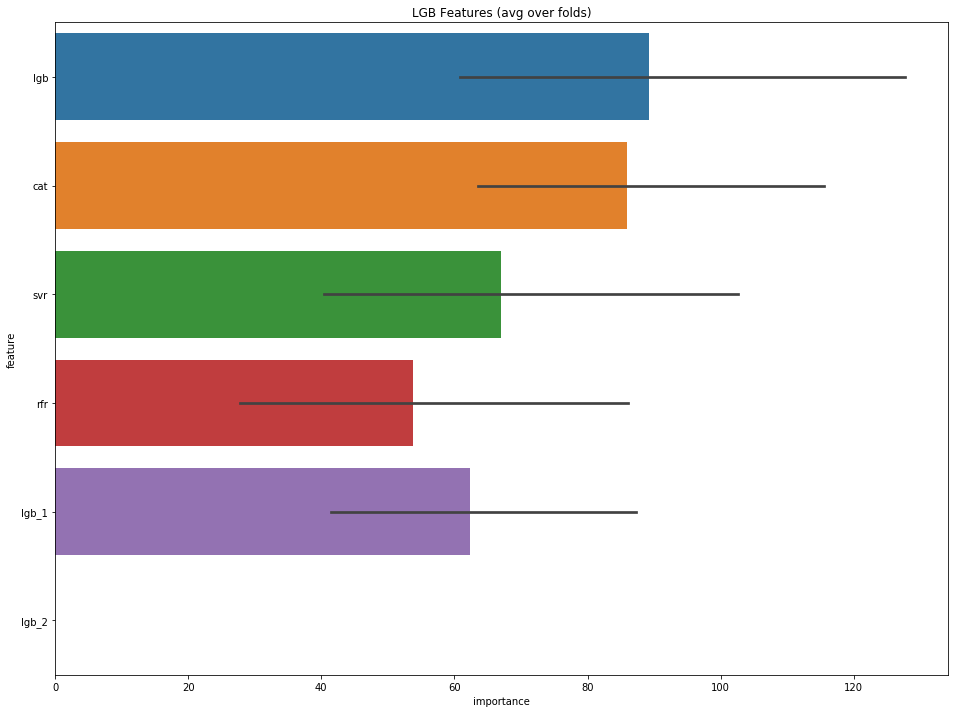

In [291]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:48:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 2.2992	valid_1's rmse: 2.29599
Fold 1 started at Sun Dec 15 14:48:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 2.46135	valid_1's rmse: 2.37382
Fold 2 started at Sun Dec 15 14:48:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 2.44873	valid_1's rmse: 2.80368
Fold 3 started at Sun Dec 15 14:48:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[423]	training's rmse: 2.18679	valid_1's rmse: 2.63187
Fold 4 started at Sun Dec 15 14:48:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[486]	training's rmse: 2.00809	valid_1's rmse: 3.76404
Fold 5 started at Sun

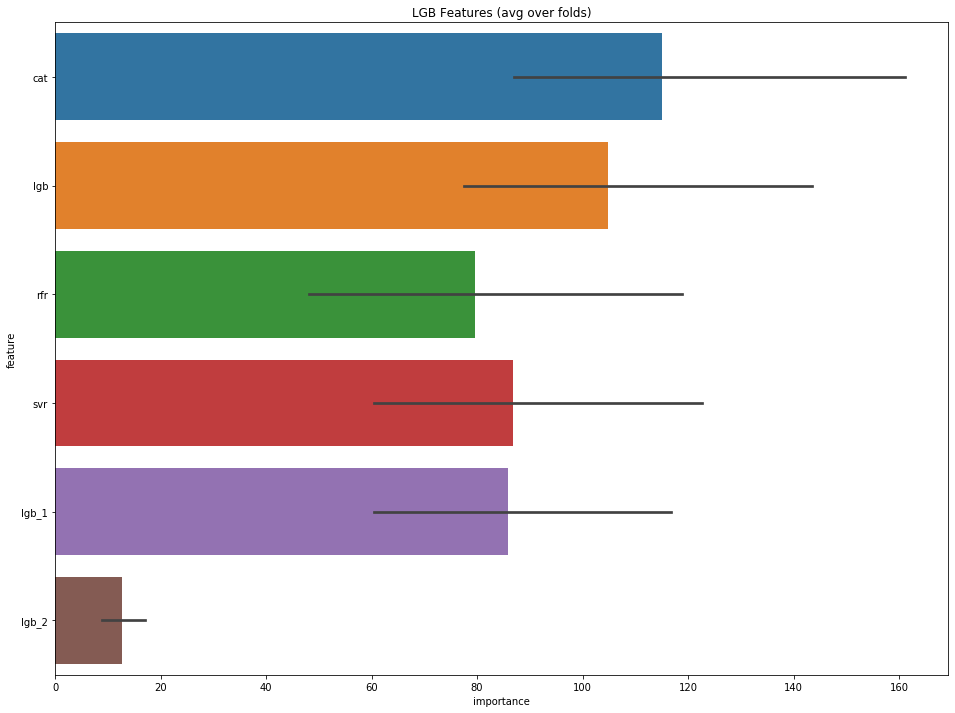

In [292]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [293]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:48:39 2019
Fold 1 started at Sun Dec 15 14:48:43 2019
Fold 2 started at Sun Dec 15 14:48:44 2019
Fold 3 started at Sun Dec 15 14:48:45 2019
Fold 4 started at Sun Dec 15 14:48:46 2019
Fold 5 started at Sun Dec 15 14:48:48 2019
Fold 6 started at Sun Dec 15 14:48:50 2019
Fold 7 started at Sun Dec 15 14:48:54 2019
Fold 8 started at Sun Dec 15 14:48:55 2019
Fold 9 started at Sun Dec 15 14:48:57 2019
CV mean score: 2.6892, std: 0.4891.


random forest做第二层融合模型

In [294]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:48:59 2019
Fold 1 started at Sun Dec 15 14:49:00 2019
Fold 2 started at Sun Dec 15 14:49:00 2019
Fold 3 started at Sun Dec 15 14:49:00 2019
Fold 4 started at Sun Dec 15 14:49:00 2019
Fold 5 started at Sun Dec 15 14:49:01 2019
Fold 6 started at Sun Dec 15 14:49:01 2019
Fold 7 started at Sun Dec 15 14:49:01 2019
Fold 8 started at Sun Dec 15 14:49:01 2019
Fold 9 started at Sun Dec 15 14:49:02 2019
CV mean score: 2.8292, std: 0.4321.


xgboost做第二层融合模型

In [295]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:49:02 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.23255	valid_data-rmse:2.06668
Stopping. Best iteration:
[493]	train-rmse:1.25048	valid_data-rmse:2.0611

Fold 1 started at Sun Dec 15 14:49:02 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.21665	valid_data-rmse:2.61492
Stopping. Best iteration:
[392]	train-rmse:1.5918	valid_data-rmse:2.58962

Fold 2 started at Sun Dec 15 14:49:02 2019
[0]	train-rmse:24.0121	valid_data-rmse:23.8622
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rm

#### SVR作为meta

In [296]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:49:04 2019
Fold 1 started at Sun Dec 15 14:49:04 2019
Fold 2 started at Sun Dec 15 14:49:04 2019
Fold 3 started at Sun Dec 15 14:49:04 2019
Fold 4 started at Sun Dec 15 14:49:04 2019
Fold 5 started at Sun Dec 15 14:49:04 2019
Fold 6 started at Sun Dec 15 14:49:04 2019
Fold 7 started at Sun Dec 15 14:49:04 2019
Fold 8 started at Sun Dec 15 14:49:04 2019
Fold 9 started at Sun Dec 15 14:49:04 2019
CV mean score: 3.7002, std: 0.8521.


用岭回归做第二层融合模型

In [297]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:49:04 2019
Fold 1 started at Sun Dec 15 14:49:04 2019
Fold 2 started at Sun Dec 15 14:49:05 2019
Fold 3 started at Sun Dec 15 14:49:05 2019
Fold 4 started at Sun Dec 15 14:49:05 2019
Fold 5 started at Sun Dec 15 14:49:05 2019
Fold 6 started at Sun Dec 15 14:49:05 2019
Fold 7 started at Sun Dec 15 14:49:05 2019
Fold 8 started at Sun Dec 15 14:49:05 2019
Fold 9 started at Sun Dec 15 14:49:05 2019
CV mean score: 2.6209, std: 0.4176.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 14:49:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[726]	training's rmse: 2.32804	valid_1's rmse: 2.36726
Fold 1 started at Sun Dec 15 14:49:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[271]	training's rmse: 2.5242	valid_1's rmse: 2.25037
Fold 2 started at Sun Dec 15 14:49:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[209]	training's rmse: 2.61501	valid_1's rmse: 2.72222
Fold 3 started at Sun Dec 15 14:49:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 2.39246	valid_1's rmse: 2.64539
Fold 4 started at Sun Dec 15 14:49:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[279]	training's rmse: 2.3068	valid_1's rmse: 3.90867
Fold 5 started at Sun 

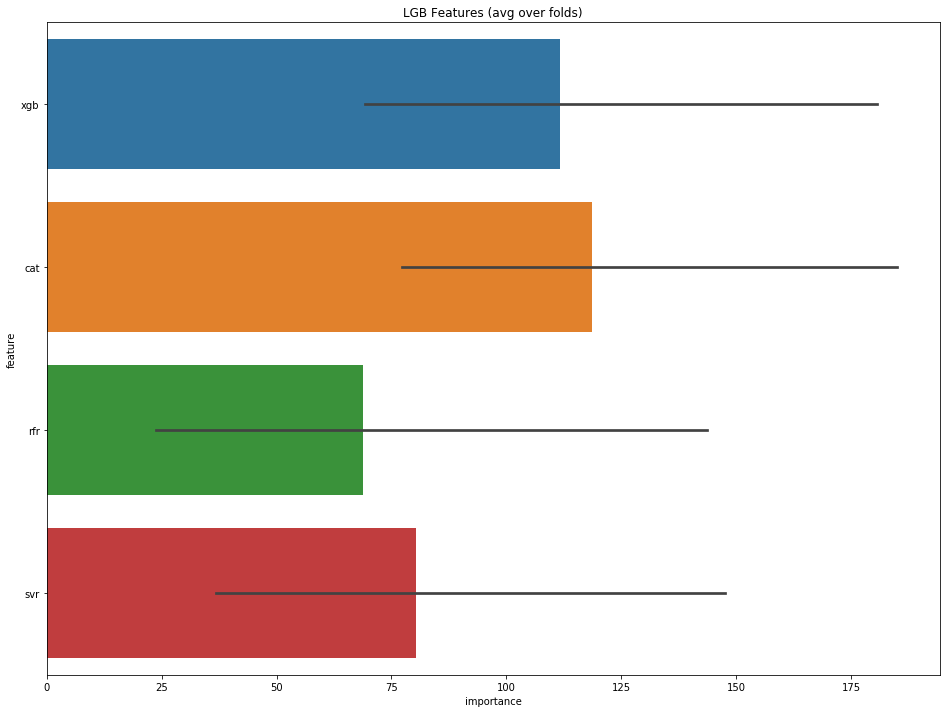

In [298]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's rmse: 2.3046	valid_1's rmse: 2.44561
Fold 1 started at Sun Dec 15 14:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 2.47148	valid_1's rmse: 2.26069
Fold 2 started at Sun Dec 15 14:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[208]	training's rmse: 2.58575	valid_1's rmse: 2.7443
Fold 3 started at Sun Dec 15 14:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[382]	training's rmse: 2.32605	valid_1's rmse: 2.65295
Fold 4 started at Sun Dec 15 14:49:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 2.28622	valid_1's rmse: 3.86147
Fold 5 started at Sun 

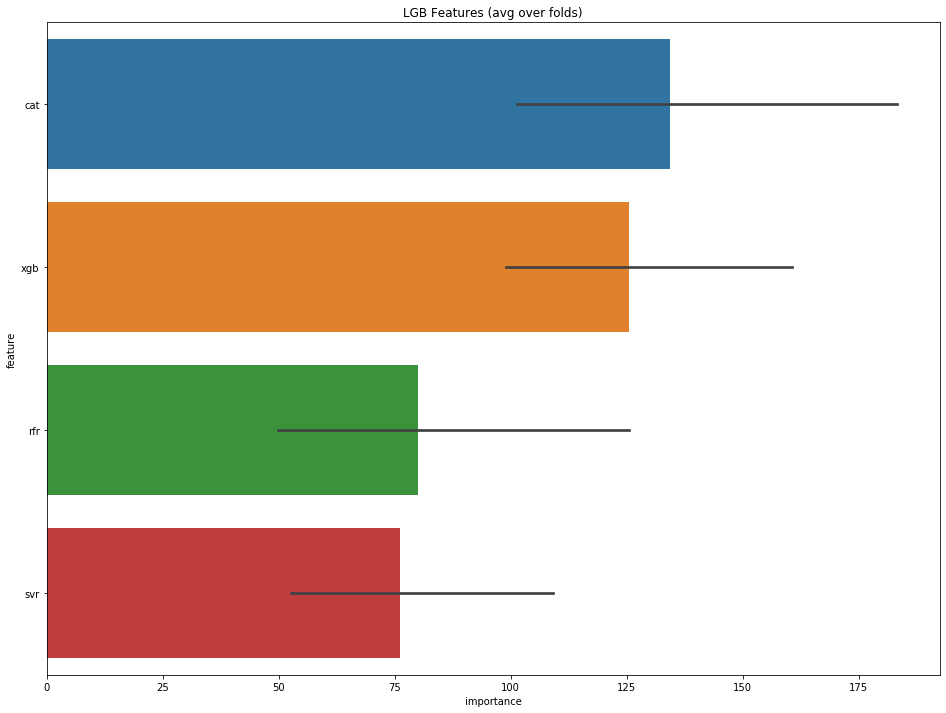

In [299]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [300]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:49:10 2019
Fold 1 started at Sun Dec 15 14:49:12 2019
Fold 2 started at Sun Dec 15 14:49:14 2019
Fold 3 started at Sun Dec 15 14:49:15 2019
Fold 4 started at Sun Dec 15 14:49:18 2019
Fold 5 started at Sun Dec 15 14:49:20 2019
Fold 6 started at Sun Dec 15 14:49:22 2019
Fold 7 started at Sun Dec 15 14:49:26 2019
Fold 8 started at Sun Dec 15 14:49:28 2019
Fold 9 started at Sun Dec 15 14:49:29 2019
CV mean score: 2.7102, std: 0.5118.


random forest做第二层融合模型

In [301]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:49:32 2019
Fold 1 started at Sun Dec 15 14:49:33 2019
Fold 2 started at Sun Dec 15 14:49:33 2019
Fold 3 started at Sun Dec 15 14:49:33 2019
Fold 4 started at Sun Dec 15 14:49:33 2019
Fold 5 started at Sun Dec 15 14:49:34 2019
Fold 6 started at Sun Dec 15 14:49:34 2019
Fold 7 started at Sun Dec 15 14:49:34 2019
Fold 8 started at Sun Dec 15 14:49:34 2019
Fold 9 started at Sun Dec 15 14:49:35 2019
CV mean score: 2.9097, std: 0.4452.


xgboost做第二层融合模型

In [302]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:49:35 2019
[0]	train-rmse:23.9859	valid_data-rmse:24.1033
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.31324	valid_data-rmse:2.70267
Stopping. Best iteration:
[380]	train-rmse:1.73554	valid_data-rmse:2.63131

Fold 1 started at Sun Dec 15 14:49:35 2019
[0]	train-rmse:24.1972	valid_data-rmse:22.1785
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:1.27291	valid_data-rmse:2.6023
Stopping. Best iteration:
[450]	train-rmse:1.42207	valid_data-rmse:2.58291

Fold 2 started at Sun Dec 15 14:49:35 2019
[0]	train-rmse:24.0122	valid_data-rmse:23.8665
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-r

#### SVR作为meta

In [303]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:49:37 2019
Fold 1 started at Sun Dec 15 14:49:37 2019
Fold 2 started at Sun Dec 15 14:49:37 2019
Fold 3 started at Sun Dec 15 14:49:37 2019
Fold 4 started at Sun Dec 15 14:49:37 2019
Fold 5 started at Sun Dec 15 14:49:37 2019
Fold 6 started at Sun Dec 15 14:49:37 2019
Fold 7 started at Sun Dec 15 14:49:37 2019
Fold 8 started at Sun Dec 15 14:49:37 2019
Fold 9 started at Sun Dec 15 14:49:37 2019
CV mean score: 3.6494, std: 0.8675.


用岭回归做第二层融合模型

In [304]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:49:37 2019
Fold 1 started at Sun Dec 15 14:49:37 2019
Fold 2 started at Sun Dec 15 14:49:37 2019
Fold 3 started at Sun Dec 15 14:49:37 2019
Fold 4 started at Sun Dec 15 14:49:37 2019
Fold 5 started at Sun Dec 15 14:49:37 2019
Fold 6 started at Sun Dec 15 14:49:37 2019
Fold 7 started at Sun Dec 15 14:49:37 2019
Fold 8 started at Sun Dec 15 14:49:37 2019
Fold 9 started at Sun Dec 15 14:49:37 2019
CV mean score: 2.6019, std: 0.4391.


## pyrim 数据集实验

In [305]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('pyrim')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [306]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0907586	valid_1's rmse: 0.146272
[2000]	training's rmse: 0.0875222	valid_1's rmse: 0.135604
Early stopping, best iteration is:
[2105]	training's rmse: 0.0873301	valid_1's rmse: 0.134624


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [307]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 14:49:38 2019
Fold 1 started at Sun Dec 15 14:49:38 2019
Fold 2 started at Sun Dec 15 14:49:38 2019
Fold 3 started at Sun Dec 15 14:49:38 2019
Fold 4 started at Sun Dec 15 14:49:38 2019
Fold 5 started at Sun Dec 15 14:49:38 2019
Fold 6 started at Sun Dec 15 14:49:38 2019
Fold 7 started at Sun Dec 15 14:49:38 2019
Fold 8 started at Sun Dec 15 14:49:38 2019
Fold 9 started at Sun Dec 15 14:49:38 2019
CV mean score: 0.0872, std: 0.0574.


Fold 0 started at Sun Dec 15 14:49:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Sun Dec 15 14:49:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Sun Dec 15 14:49:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Sun Dec 15 14:49:39 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

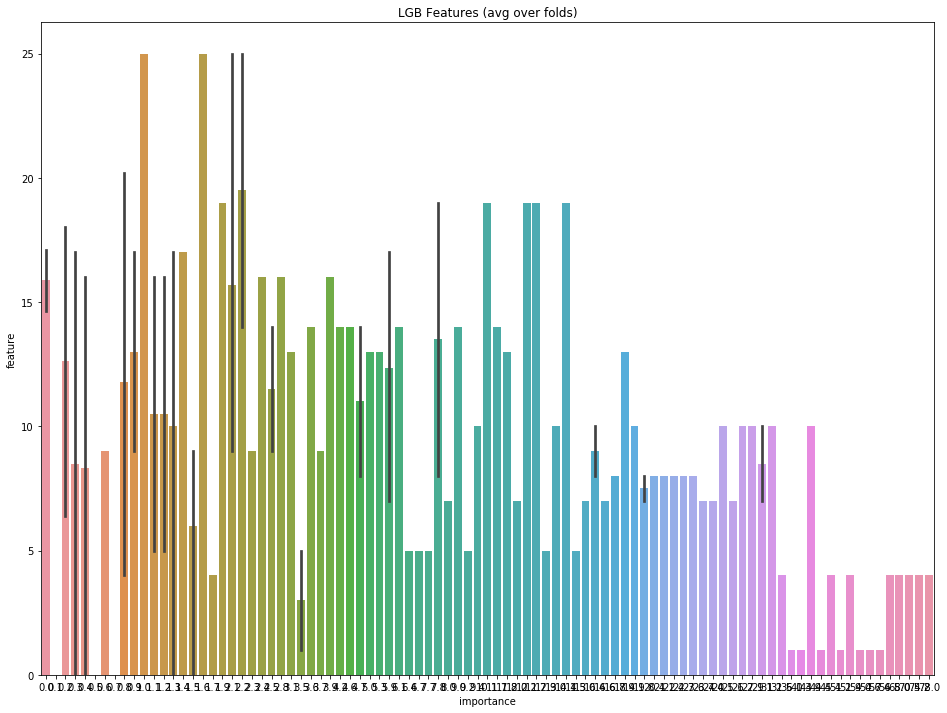

In [308]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:49:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Sun Dec 15 14:49:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Sun Dec 15 14:49:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Sun Dec 15 14:49:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

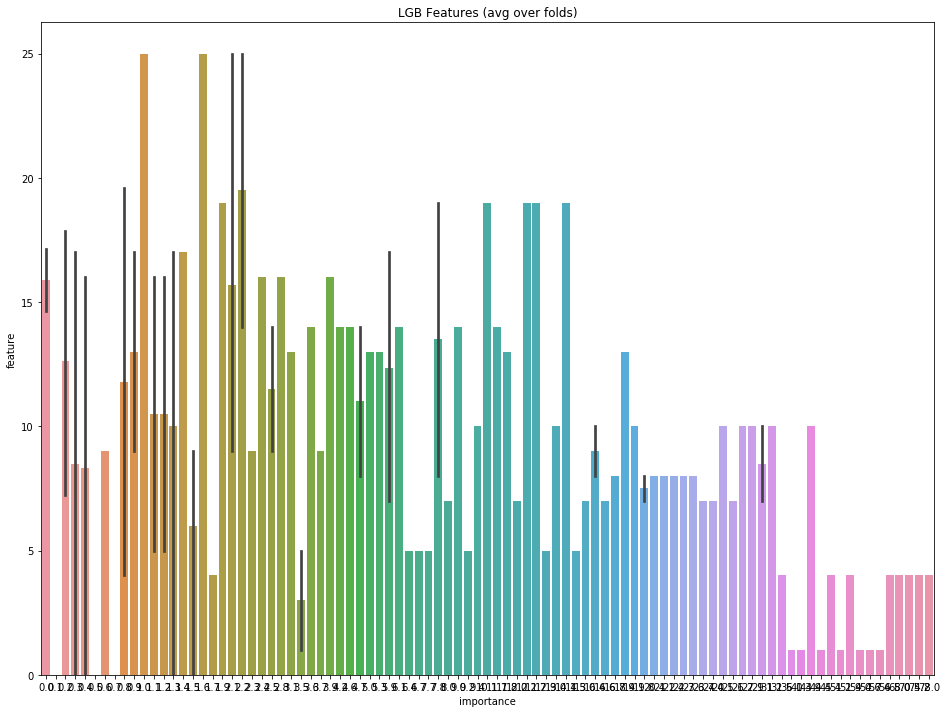

In [309]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:49:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Sun Dec 15 14:49:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Sun Dec 15 14:49:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Sun Dec 15 14:49:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

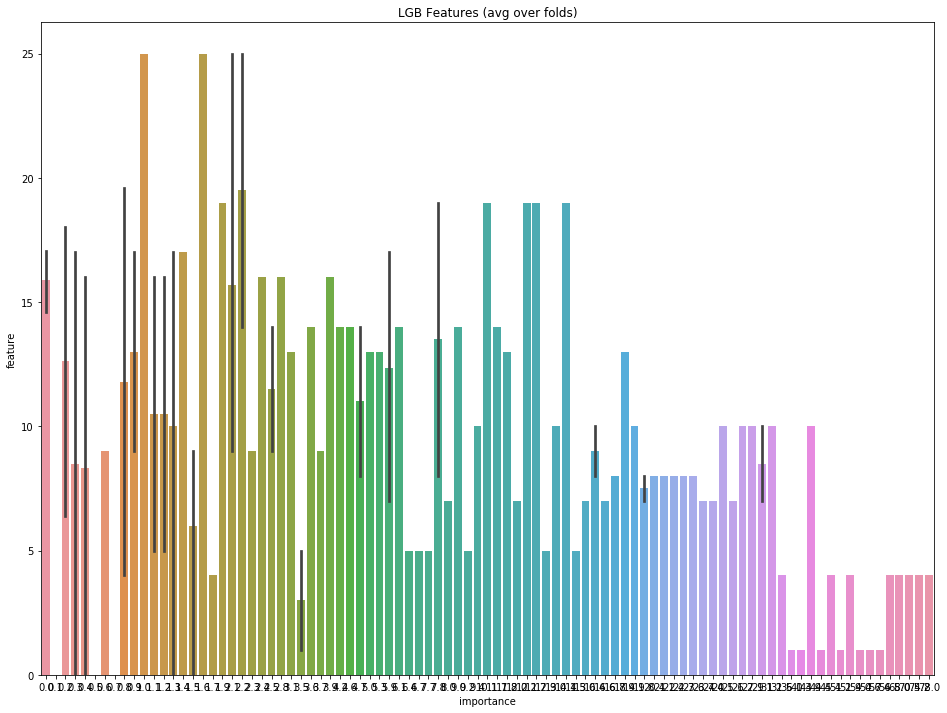

In [310]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [311]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 14:49:55 2019
Fold 1 started at Sun Dec 15 14:49:55 2019
Fold 2 started at Sun Dec 15 14:49:55 2019
Fold 3 started at Sun Dec 15 14:49:55 2019
Fold 4 started at Sun Dec 15 14:49:56 2019
Fold 5 started at Sun Dec 15 14:49:56 2019
Fold 6 started at Sun Dec 15 14:49:56 2019
Fold 7 started at Sun Dec 15 14:49:56 2019
Fold 8 started at Sun Dec 15 14:49:57 2019
Fold 9 started at Sun Dec 15 14:49:57 2019
CV mean score: 0.0809, std: 0.0616.


In [312]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:49:57 2019
[0]	train-rmse:0.207439	valid_data-rmse:0.15408
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[218]	train-rmse:0.045464	valid_data-rmse:0.036555

Fold 1 started at Sun Dec 15 14:49:57 2019
[0]	train-rmse:0.197715	valid_data-rmse:0.237744
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.016851	valid_data-rmse:0.060933
[1000]	train-rmse:0.009504	valid_data-rmse:0.055788
Stopping. Best iteration:
[1112]	train-rmse:0.00908	valid_data-rmse:0.055676

Fold 2 started at Sun Dec 15 14:49:58 2019
[0]	train-rmse:0.200658	valid_data-rmse:0.216155
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

In [313]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:50:00 2019
Fold 1 started at Sun Dec 15 14:50:01 2019
Fold 2 started at Sun Dec 15 14:50:07 2019
Fold 3 started at Sun Dec 15 14:50:07 2019
Fold 4 started at Sun Dec 15 14:50:18 2019
Fold 5 started at Sun Dec 15 14:50:23 2019
Fold 6 started at Sun Dec 15 14:50:32 2019
Fold 7 started at Sun Dec 15 14:50:36 2019
Fold 8 started at Sun Dec 15 14:50:37 2019
Fold 9 started at Sun Dec 15 14:50:44 2019
CV mean score: 0.0678, std: 0.0553.


## stacking

Fold 0 started at Sun Dec 15 14:50:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.0850328	valid_1's rmse: 0.0297886
Fold 1 started at Sun Dec 15 14:50:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Sun Dec 15 14:50:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Sun Dec 15 14:50:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Sun Dec 15 14:50:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 0.0847517	valid_1's rmse: 0.0621025
Fo

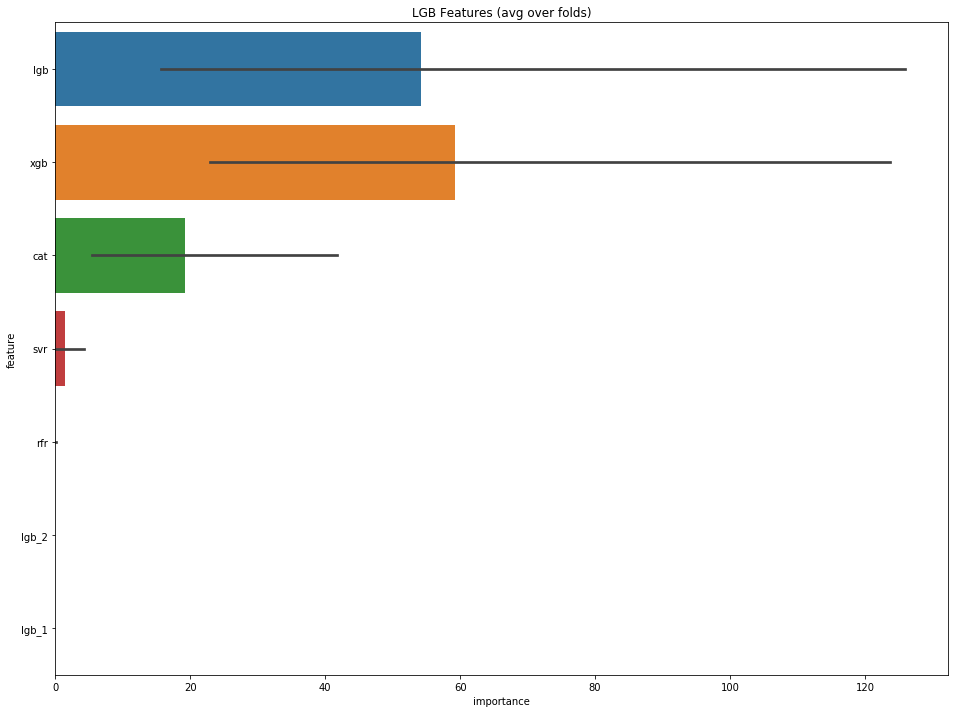

In [314]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:50:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[463]	training's rmse: 0.0882685	valid_1's rmse: 0.0306598
Fold 1 started at Sun Dec 15 14:50:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[417]	training's rmse: 0.0867123	valid_1's rmse: 0.072654
Fold 2 started at Sun Dec 15 14:50:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.0549043	valid_1's rmse: 0.224868
Fold 3 started at Sun Dec 15 14:50:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 0.0884928	valid_1's rmse: 0.0261018
Fold 4 started at Sun Dec 15 14:50:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.086665	valid_1's rmse: 0.0641989
Fol

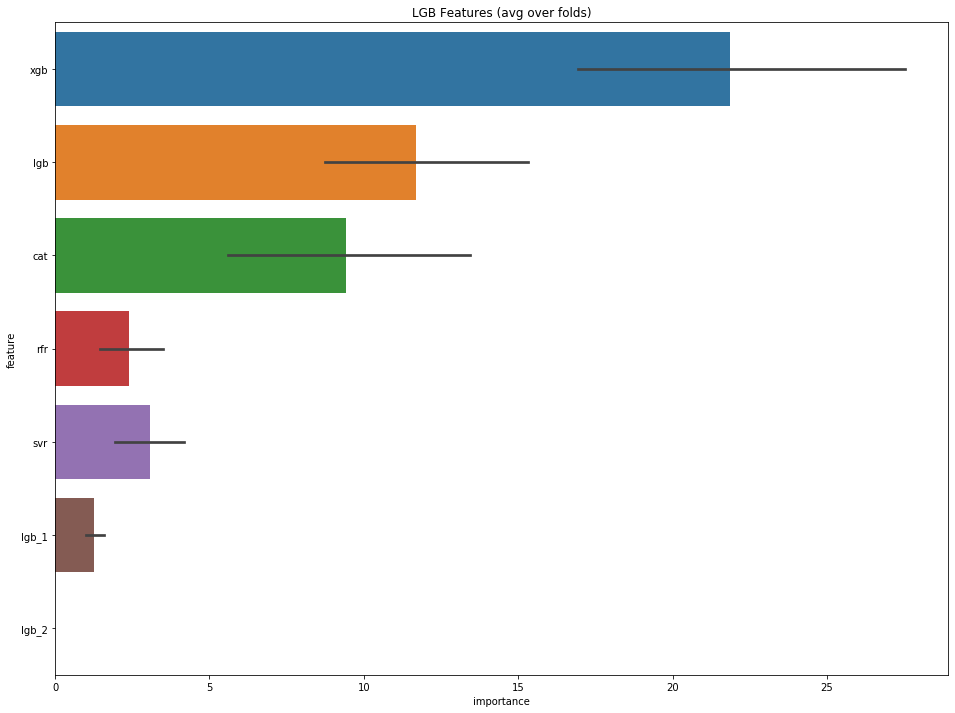

In [315]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [316]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:50:51 2019
Fold 1 started at Sun Dec 15 14:50:53 2019
Fold 2 started at Sun Dec 15 14:50:57 2019
Fold 3 started at Sun Dec 15 14:50:58 2019
Fold 4 started at Sun Dec 15 14:51:02 2019
Fold 5 started at Sun Dec 15 14:51:03 2019
Fold 6 started at Sun Dec 15 14:51:05 2019
Fold 7 started at Sun Dec 15 14:51:06 2019
Fold 8 started at Sun Dec 15 14:51:06 2019
Fold 9 started at Sun Dec 15 14:51:10 2019
CV mean score: 0.0677, std: 0.0569.


random forest做第二层融合模型

In [317]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:51:12 2019
Fold 1 started at Sun Dec 15 14:51:12 2019
Fold 2 started at Sun Dec 15 14:51:12 2019
Fold 3 started at Sun Dec 15 14:51:13 2019
Fold 4 started at Sun Dec 15 14:51:13 2019
Fold 5 started at Sun Dec 15 14:51:13 2019
Fold 6 started at Sun Dec 15 14:51:13 2019
Fold 7 started at Sun Dec 15 14:51:14 2019
Fold 8 started at Sun Dec 15 14:51:14 2019
Fold 9 started at Sun Dec 15 14:51:14 2019
CV mean score: 0.0731, std: 0.0556.


xgboost做第二层融合模型

In [318]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:51:14 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[247]	train-rmse:0.041474	valid_data-rmse:0.038487

Fold 1 started at Sun Dec 15 14:51:14 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.01381	valid_data-rmse:0.046068
Stopping. Best iteration:
[611]	train-rmse:0.009028	valid_data-rmse:0.045885

Fold 2 started at Sun Dec 15 14:51:15 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216465
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[65]	train-rmse:0.115407	va

#### SVR作为meta

In [319]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:51:16 2019
Fold 1 started at Sun Dec 15 14:51:16 2019
Fold 2 started at Sun Dec 15 14:51:16 2019
Fold 3 started at Sun Dec 15 14:51:16 2019
Fold 4 started at Sun Dec 15 14:51:16 2019
Fold 5 started at Sun Dec 15 14:51:16 2019
Fold 6 started at Sun Dec 15 14:51:16 2019
Fold 7 started at Sun Dec 15 14:51:16 2019
Fold 8 started at Sun Dec 15 14:51:16 2019
Fold 9 started at Sun Dec 15 14:51:16 2019
CV mean score: 0.0794, std: 0.0521.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 14:51:16 2019
Fold 1 started at Sun Dec 15 14:51:16 2019
Fold 2 started at Sun Dec 15 14:51:16 2019
Fold 3 started at Sun Dec 15 14:51:16 2019
Fold 4 started at Sun Dec 15 14:51:16 2019
Fold 5 started at Sun Dec 15 14:51:16 2019
Fold 6 started at Sun Dec 15 14:51:16 2019
Fold 7 started at Sun Dec 15 14:51:16 2019
Fold 8 started at Sun Dec 15 14:51:16 2019
Fold 9 started at Sun Dec 15 14:51:16 2019
CV mean score: 0.0661, std: 0.0532.
Fold 0 started at Sun Dec 15 14:51:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.0850328	valid_1's rmse: 0.0297886
Fold 1 started at Sun Dec 15 14:51:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Sun Dec 15 14:51:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iterati

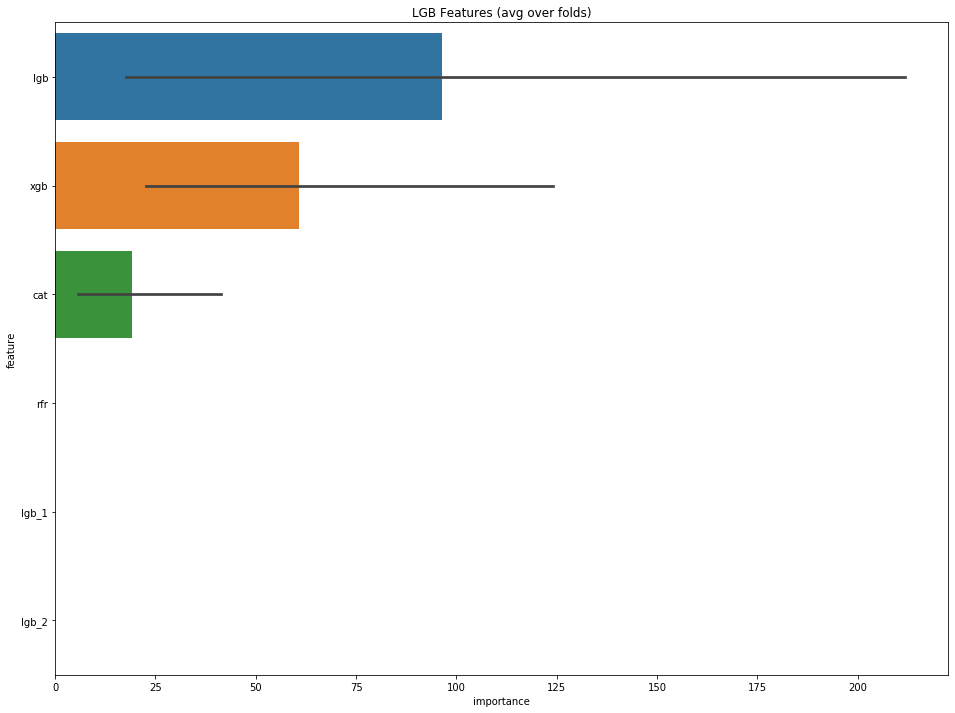

In [320]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:51:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0888229	valid_1's rmse: 0.030848
Fold 1 started at Sun Dec 15 14:51:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 0.0868037	valid_1's rmse: 0.072856
Fold 2 started at Sun Dec 15 14:51:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 0.0543979	valid_1's rmse: 0.223459
Fold 3 started at Sun Dec 15 14:51:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 0.0885521	valid_1's rmse: 0.0265223
Fold 4 started at Sun Dec 15 14:51:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[376]	training's rmse: 0.0872006	valid_1's rmse: 0.0631834
Fol

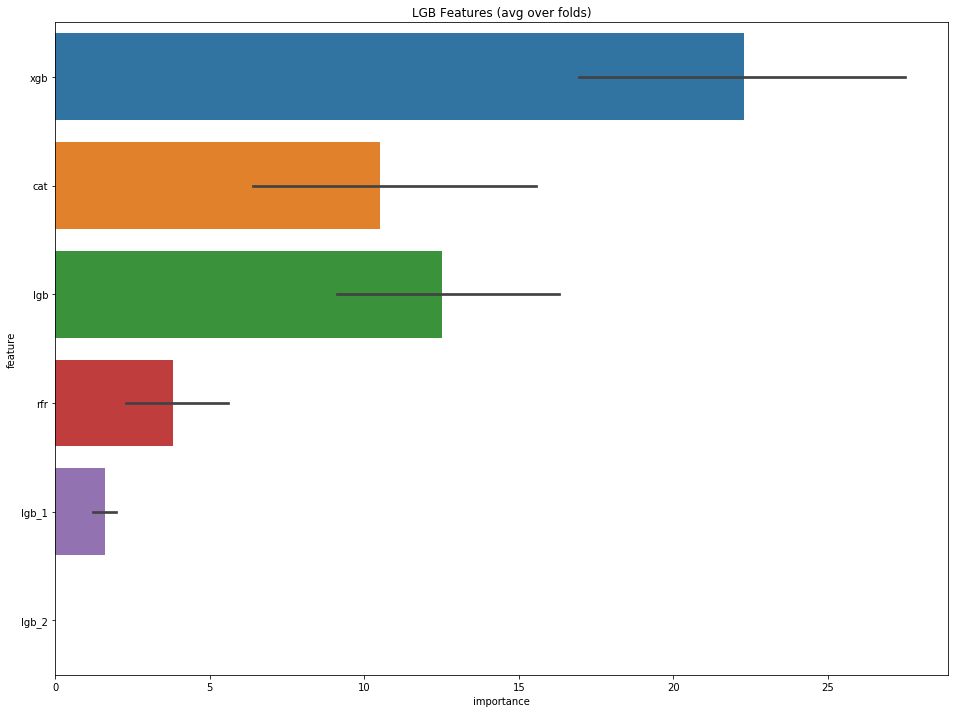

In [321]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [322]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:51:22 2019
Fold 1 started at Sun Dec 15 14:51:24 2019
Fold 2 started at Sun Dec 15 14:51:26 2019
Fold 3 started at Sun Dec 15 14:51:29 2019
Fold 4 started at Sun Dec 15 14:51:32 2019
Fold 5 started at Sun Dec 15 14:51:34 2019
Fold 6 started at Sun Dec 15 14:51:39 2019
Fold 7 started at Sun Dec 15 14:51:39 2019
Fold 8 started at Sun Dec 15 14:51:40 2019
Fold 9 started at Sun Dec 15 14:51:44 2019
CV mean score: 0.0669, std: 0.0540.


random forest做第二层融合模型

In [323]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:51:46 2019
Fold 1 started at Sun Dec 15 14:51:46 2019
Fold 2 started at Sun Dec 15 14:51:46 2019
Fold 3 started at Sun Dec 15 14:51:46 2019
Fold 4 started at Sun Dec 15 14:51:47 2019
Fold 5 started at Sun Dec 15 14:51:47 2019
Fold 6 started at Sun Dec 15 14:51:47 2019
Fold 7 started at Sun Dec 15 14:51:47 2019
Fold 8 started at Sun Dec 15 14:51:47 2019
Fold 9 started at Sun Dec 15 14:51:48 2019
CV mean score: 0.0718, std: 0.0523.


xgboost做第二层融合模型

In [324]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:51:48 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014382	valid_data-rmse:0.04185
Stopping. Best iteration:
[310]	train-rmse:0.03126	valid_data-rmse:0.041488

Fold 1 started at Sun Dec 15 14:51:48 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014212	valid_data-rmse:0.060686
Stopping. Best iteration:
[315]	train-rmse:0.031065	valid_data-rmse:0.057714

Fold 2 started at Sun Dec 15 14:51:48 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Sto

#### SVR作为meta

In [325]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:51:49 2019
Fold 1 started at Sun Dec 15 14:51:49 2019
Fold 2 started at Sun Dec 15 14:51:49 2019
Fold 3 started at Sun Dec 15 14:51:49 2019
Fold 4 started at Sun Dec 15 14:51:49 2019
Fold 5 started at Sun Dec 15 14:51:49 2019
Fold 6 started at Sun Dec 15 14:51:49 2019
Fold 7 started at Sun Dec 15 14:51:49 2019
Fold 8 started at Sun Dec 15 14:51:49 2019
Fold 9 started at Sun Dec 15 14:51:49 2019
CV mean score: 0.0791, std: 0.0514.


用岭回归做第二层融合模型

In [326]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:51:49 2019
Fold 1 started at Sun Dec 15 14:51:49 2019
Fold 2 started at Sun Dec 15 14:51:49 2019
Fold 3 started at Sun Dec 15 14:51:49 2019
Fold 4 started at Sun Dec 15 14:51:49 2019
Fold 5 started at Sun Dec 15 14:51:50 2019
Fold 6 started at Sun Dec 15 14:51:50 2019
Fold 7 started at Sun Dec 15 14:51:50 2019
Fold 8 started at Sun Dec 15 14:51:50 2019
Fold 9 started at Sun Dec 15 14:51:50 2019
CV mean score: 0.0630, std: 0.0508.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 14:51:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0849884	valid_1's rmse: 0.029803
Fold 1 started at Sun Dec 15 14:51:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Sun Dec 15 14:51:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.052939	valid_1's rmse: 0.221776
Early stopping, best iteration is:
[1288]	training's rmse: 0.0529165	valid_1's rmse: 0.221755
Fold 3 started at Sun Dec 15 14:51:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Sun Dec 15 14:51:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[6

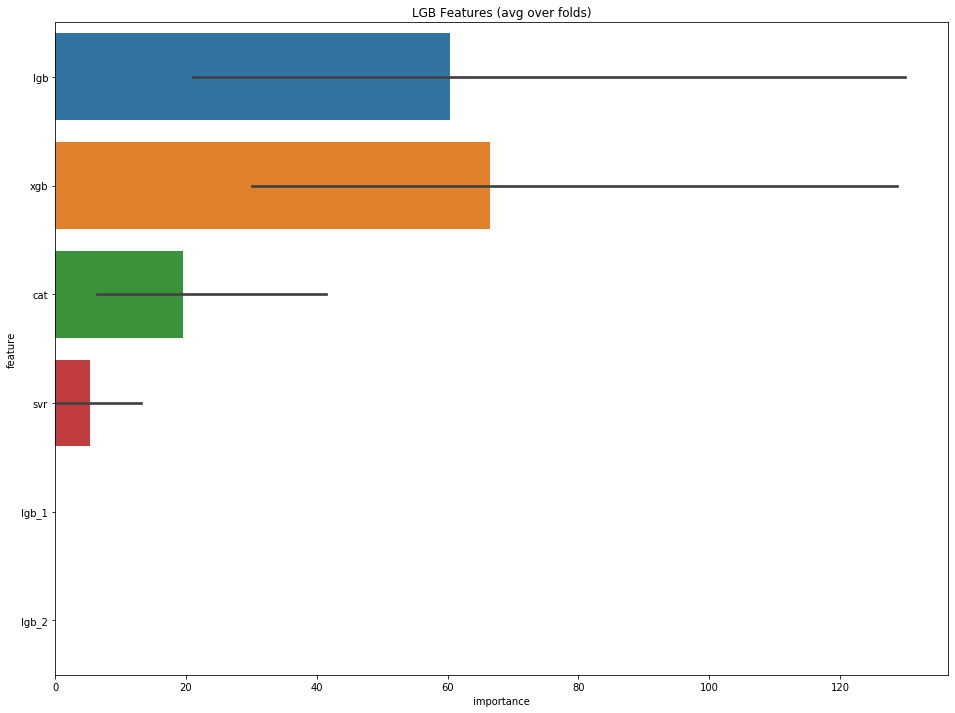

In [327]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:51:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 0.0883426	valid_1's rmse: 0.0304297
Fold 1 started at Sun Dec 15 14:51:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0863763	valid_1's rmse: 0.0722934
Fold 2 started at Sun Dec 15 14:51:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's rmse: 0.0556326	valid_1's rmse: 0.220873
Fold 3 started at Sun Dec 15 14:51:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[519]	training's rmse: 0.0887075	valid_1's rmse: 0.0264959
Fold 4 started at Sun Dec 15 14:51:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.0869099	valid_1's rmse: 0.0646512
F

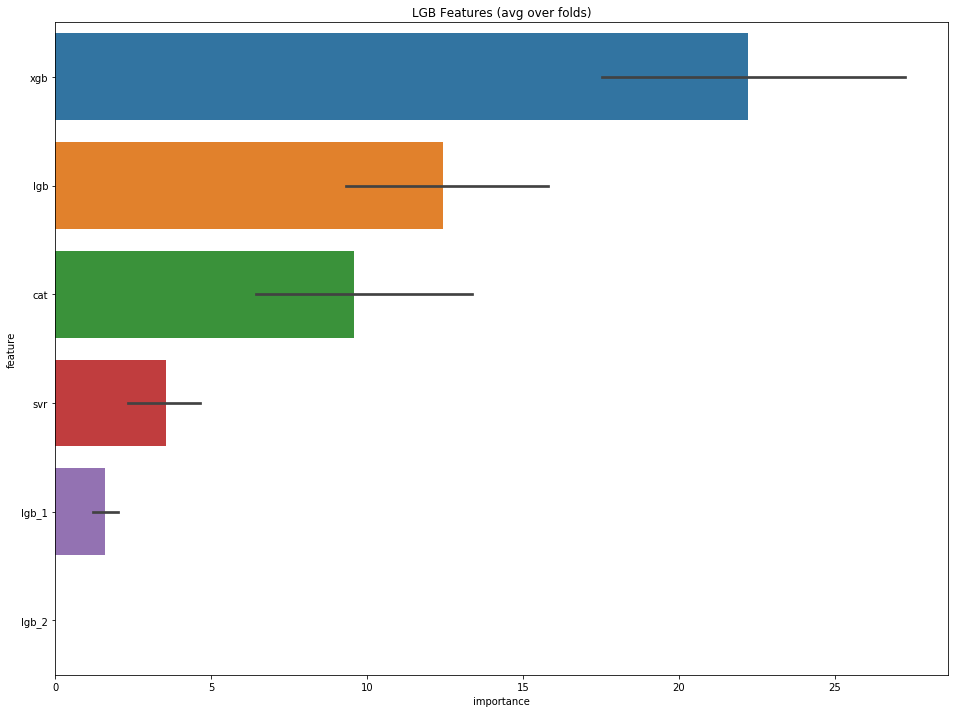

In [328]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [329]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:51:56 2019
Fold 1 started at Sun Dec 15 14:51:57 2019
Fold 2 started at Sun Dec 15 14:52:00 2019
Fold 3 started at Sun Dec 15 14:52:02 2019
Fold 4 started at Sun Dec 15 14:52:06 2019
Fold 5 started at Sun Dec 15 14:52:07 2019
Fold 6 started at Sun Dec 15 14:52:09 2019
Fold 7 started at Sun Dec 15 14:52:10 2019
Fold 8 started at Sun Dec 15 14:52:10 2019
Fold 9 started at Sun Dec 15 14:52:12 2019
CV mean score: 0.0674, std: 0.0558.


random forest做第二层融合模型

In [330]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:52:14 2019
Fold 1 started at Sun Dec 15 14:52:15 2019
Fold 2 started at Sun Dec 15 14:52:15 2019
Fold 3 started at Sun Dec 15 14:52:15 2019
Fold 4 started at Sun Dec 15 14:52:15 2019
Fold 5 started at Sun Dec 15 14:52:16 2019
Fold 6 started at Sun Dec 15 14:52:16 2019
Fold 7 started at Sun Dec 15 14:52:16 2019
Fold 8 started at Sun Dec 15 14:52:16 2019
Fold 9 started at Sun Dec 15 14:52:17 2019
CV mean score: 0.0700, std: 0.0529.


xgboost做第二层融合模型

In [331]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:52:17 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[225]	train-rmse:0.047174	valid_data-rmse:0.039777

Fold 1 started at Sun Dec 15 14:52:17 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015067	valid_data-rmse:0.049698
Stopping. Best iteration:
[473]	train-rmse:0.016587	valid_data-rmse:0.049648

Fold 2 started at Sun Dec 15 14:52:17 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216465
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[67]	train-rmse:0.113287	v

#### SVR作为meta

In [332]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:52:18 2019
Fold 1 started at Sun Dec 15 14:52:18 2019
Fold 2 started at Sun Dec 15 14:52:18 2019
Fold 3 started at Sun Dec 15 14:52:18 2019
Fold 4 started at Sun Dec 15 14:52:18 2019
Fold 5 started at Sun Dec 15 14:52:18 2019
Fold 6 started at Sun Dec 15 14:52:18 2019
Fold 7 started at Sun Dec 15 14:52:18 2019
Fold 8 started at Sun Dec 15 14:52:18 2019
Fold 9 started at Sun Dec 15 14:52:18 2019
CV mean score: 0.0800, std: 0.0503.


用岭回归做第二层融合模型

In [333]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:52:18 2019
Fold 1 started at Sun Dec 15 14:52:18 2019
Fold 2 started at Sun Dec 15 14:52:18 2019
Fold 3 started at Sun Dec 15 14:52:18 2019
Fold 4 started at Sun Dec 15 14:52:18 2019
Fold 5 started at Sun Dec 15 14:52:18 2019
Fold 6 started at Sun Dec 15 14:52:18 2019
Fold 7 started at Sun Dec 15 14:52:18 2019
Fold 8 started at Sun Dec 15 14:52:18 2019
Fold 9 started at Sun Dec 15 14:52:18 2019
CV mean score: 0.0649, std: 0.0536.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 14:52:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.0893284	valid_1's rmse: 0.0337722
Fold 1 started at Sun Dec 15 14:52:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Sun Dec 15 14:52:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 0.0925396	valid_1's rmse: 0.223902
Fold 3 started at Sun Dec 15 14:52:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0890077	valid_1's rmse: 0.0274757
Early stopping, best iteration is:
[809]	training's rmse: 0.0890486	valid_1's rmse: 0.0274571
Fold 4 started at Sun Dec 15 14:52:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

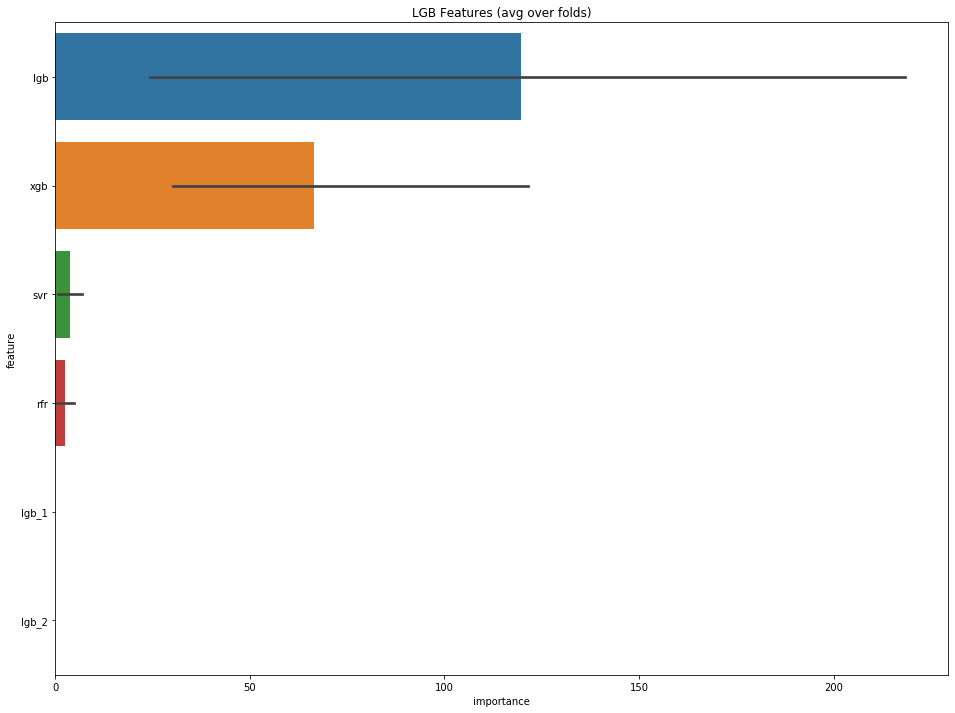

In [334]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:52:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 0.0907479	valid_1's rmse: 0.0364433
Fold 1 started at Sun Dec 15 14:52:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0860314	valid_1's rmse: 0.0714451
Fold 2 started at Sun Dec 15 14:52:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 0.057213	valid_1's rmse: 0.219501
Fold 3 started at Sun Dec 15 14:52:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0901881	valid_1's rmse: 0.0290621
Early stopping, best iteration is:
[922]	training's rmse: 0.0901979	valid_1's rmse: 0.0290238
Fold 4 started at Sun Dec 15 14:52:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

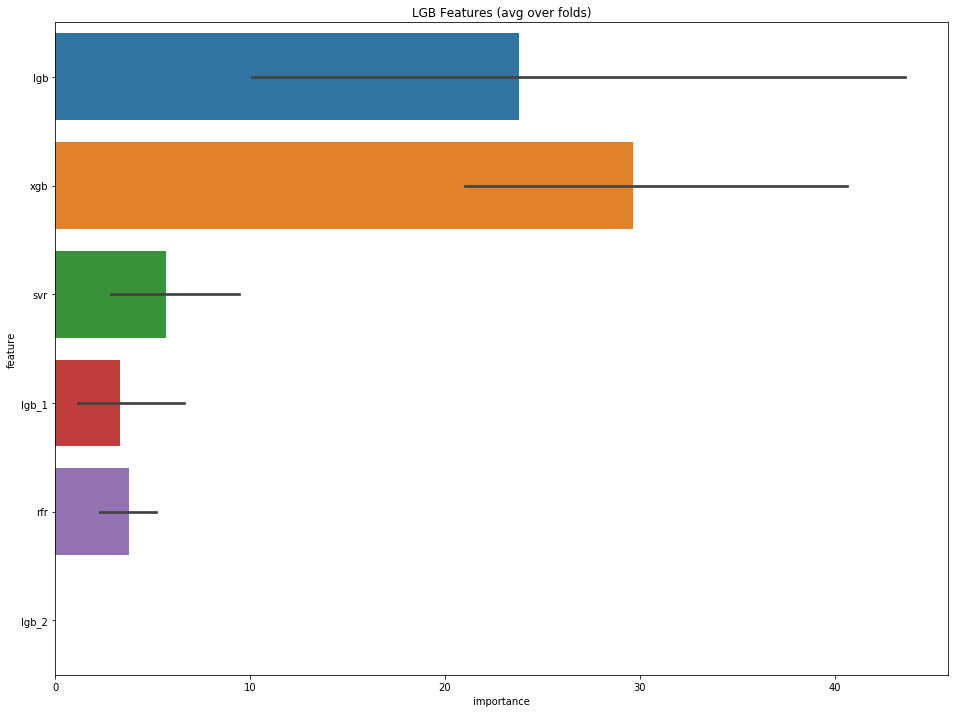

In [335]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [336]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:52:25 2019
Fold 1 started at Sun Dec 15 14:52:26 2019
Fold 2 started at Sun Dec 15 14:52:29 2019
Fold 3 started at Sun Dec 15 14:52:30 2019
Fold 4 started at Sun Dec 15 14:52:33 2019
Fold 5 started at Sun Dec 15 14:52:35 2019
Fold 6 started at Sun Dec 15 14:52:36 2019
Fold 7 started at Sun Dec 15 14:52:37 2019
Fold 8 started at Sun Dec 15 14:52:37 2019
Fold 9 started at Sun Dec 15 14:52:41 2019
CV mean score: 0.0694, std: 0.0564.


random forest做第二层融合模型

In [337]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:52:43 2019
Fold 1 started at Sun Dec 15 14:52:43 2019
Fold 2 started at Sun Dec 15 14:52:44 2019
Fold 3 started at Sun Dec 15 14:52:44 2019
Fold 4 started at Sun Dec 15 14:52:44 2019
Fold 5 started at Sun Dec 15 14:52:44 2019
Fold 6 started at Sun Dec 15 14:52:45 2019
Fold 7 started at Sun Dec 15 14:52:45 2019
Fold 8 started at Sun Dec 15 14:52:45 2019
Fold 9 started at Sun Dec 15 14:52:45 2019
CV mean score: 0.0744, std: 0.0570.


xgboost做第二层融合模型

In [338]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:52:46 2019
[0]	train-rmse:0.207364	valid_data-rmse:0.153814
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[221]	train-rmse:0.048304	valid_data-rmse:0.043482

Fold 1 started at Sun Dec 15 14:52:46 2019
[0]	train-rmse:0.197711	valid_data-rmse:0.238024
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014851	valid_data-rmse:0.04653
Stopping. Best iteration:
[602]	train-rmse:0.010276	valid_data-rmse:0.046333

Fold 2 started at Sun Dec 15 14:52:46 2019
[0]	train-rmse:0.200596	valid_data-rmse:0.216465
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[61]	train-rmse:0.119307

#### SVR作为meta

In [339]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:52:47 2019
Fold 1 started at Sun Dec 15 14:52:47 2019
Fold 2 started at Sun Dec 15 14:52:47 2019
Fold 3 started at Sun Dec 15 14:52:47 2019
Fold 4 started at Sun Dec 15 14:52:47 2019
Fold 5 started at Sun Dec 15 14:52:47 2019
Fold 6 started at Sun Dec 15 14:52:47 2019
Fold 7 started at Sun Dec 15 14:52:47 2019
Fold 8 started at Sun Dec 15 14:52:47 2019
Fold 9 started at Sun Dec 15 14:52:47 2019
CV mean score: 0.0806, std: 0.0515.


用岭回归做第二层融合模型

In [340]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 14:52:47 2019
Fold 1 started at Sun Dec 15 14:52:47 2019
Fold 2 started at Sun Dec 15 14:52:47 2019
Fold 3 started at Sun Dec 15 14:52:47 2019
Fold 4 started at Sun Dec 15 14:52:47 2019
Fold 5 started at Sun Dec 15 14:52:47 2019
Fold 6 started at Sun Dec 15 14:52:47 2019
Fold 7 started at Sun Dec 15 14:52:47 2019
Fold 8 started at Sun Dec 15 14:52:47 2019
Fold 9 started at Sun Dec 15 14:52:47 2019
CV mean score: 0.0667, std: 0.0544.


### 去掉xgboost

Fold 0 started at Sun Dec 15 14:52:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 0.0898579	valid_1's rmse: 0.0421454
Fold 1 started at Sun Dec 15 14:52:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0909268	valid_1's rmse: 0.0685593
[2000]	training's rmse: 0.0892321	valid_1's rmse: 0.0681646
Early stopping, best iteration is:
[2595]	training's rmse: 0.0887251	valid_1's rmse: 0.0680787
Fold 2 started at Sun Dec 15 14:52:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Sun Dec 15 14:52:48 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0895501	valid_1's rmse: 0.0385682
[2000]	training's rmse: 0.088846	valid_1's rmse: 0.0376862
[3000]	training's rmse: 0.0884896	valid_1's rmse: 0.037327

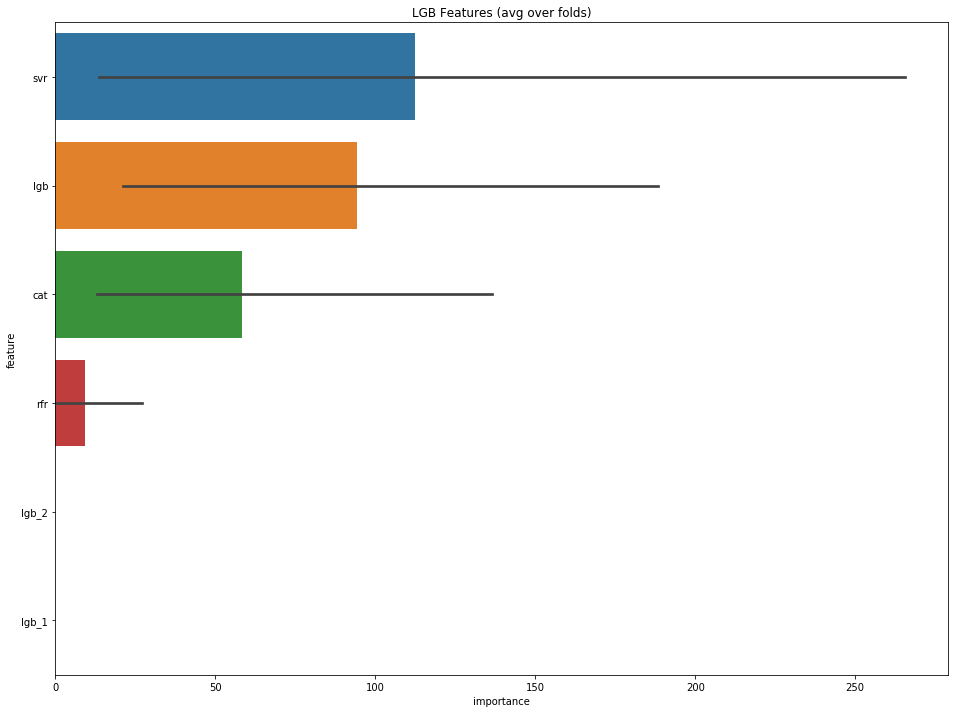

In [341]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:52:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 0.0921286	valid_1's rmse: 0.0352377
Fold 1 started at Sun Dec 15 14:52:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0926759	valid_1's rmse: 0.0704386
Early stopping, best iteration is:
[983]	training's rmse: 0.0927198	valid_1's rmse: 0.0702555
Fold 2 started at Sun Dec 15 14:52:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 0.107748	valid_1's rmse: 0.231304
Fold 3 started at Sun Dec 15 14:52:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0901958	valid_1's rmse: 0.0383442
Early stopping, best iteration is:
[1047]	training's rmse: 0.0900383	valid_1's rmse: 0.0382005
Fold 4 started at Sun Dec 15 14:52:53 2019
Training until validation scores don't i

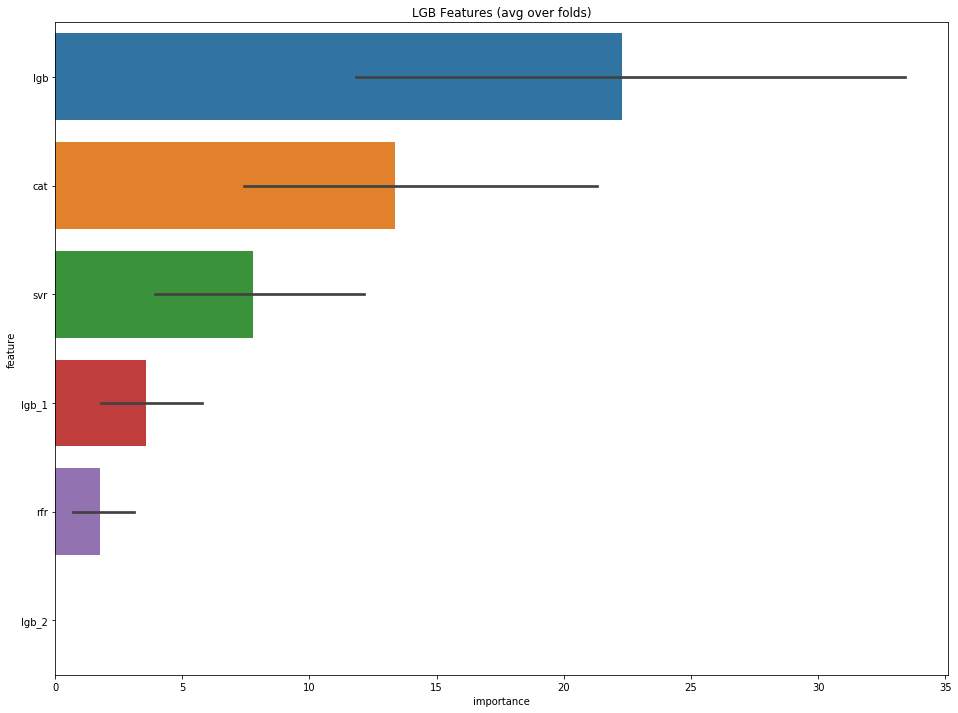

In [342]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [343]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:52:54 2019
Fold 1 started at Sun Dec 15 14:52:56 2019
Fold 2 started at Sun Dec 15 14:52:59 2019
Fold 3 started at Sun Dec 15 14:52:59 2019
Fold 4 started at Sun Dec 15 14:53:01 2019
Fold 5 started at Sun Dec 15 14:53:06 2019
Fold 6 started at Sun Dec 15 14:53:09 2019
Fold 7 started at Sun Dec 15 14:53:10 2019
Fold 8 started at Sun Dec 15 14:53:10 2019
Fold 9 started at Sun Dec 15 14:53:14 2019
CV mean score: 0.0719, std: 0.0563.


random forest做第二层融合模型

In [344]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:53:15 2019
Fold 1 started at Sun Dec 15 14:53:16 2019
Fold 2 started at Sun Dec 15 14:53:16 2019
Fold 3 started at Sun Dec 15 14:53:16 2019
Fold 4 started at Sun Dec 15 14:53:16 2019
Fold 5 started at Sun Dec 15 14:53:16 2019
Fold 6 started at Sun Dec 15 14:53:17 2019
Fold 7 started at Sun Dec 15 14:53:17 2019
Fold 8 started at Sun Dec 15 14:53:17 2019
Fold 9 started at Sun Dec 15 14:53:17 2019
CV mean score: 0.0802, std: 0.0578.


xgboost做第二层融合模型

In [345]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:53:18 2019
[0]	train-rmse:0.207374	valid_data-rmse:0.154114
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[274]	train-rmse:0.036208	valid_data-rmse:0.042425

Fold 1 started at Sun Dec 15 14:53:18 2019
[0]	train-rmse:0.197628	valid_data-rmse:0.237737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014301	valid_data-rmse:0.049168
Stopping. Best iteration:
[394]	train-rmse:0.021524	valid_data-rmse:0.048768

Fold 2 started at Sun Dec 15 14:53:18 2019
[0]	train-rmse:0.200591	valid_data-rmse:0.2164
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[35]	train-rmse:0.14822	v

#### SVR作为meta

In [346]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:53:19 2019
Fold 1 started at Sun Dec 15 14:53:19 2019
Fold 2 started at Sun Dec 15 14:53:19 2019
Fold 3 started at Sun Dec 15 14:53:19 2019
Fold 4 started at Sun Dec 15 14:53:19 2019
Fold 5 started at Sun Dec 15 14:53:19 2019
Fold 6 started at Sun Dec 15 14:53:19 2019
Fold 7 started at Sun Dec 15 14:53:19 2019
Fold 8 started at Sun Dec 15 14:53:19 2019
Fold 9 started at Sun Dec 15 14:53:19 2019
CV mean score: 0.0801, std: 0.0542.


用岭回归做第二层融合模型

In [347]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:53:19 2019
Fold 1 started at Sun Dec 15 14:53:19 2019
Fold 2 started at Sun Dec 15 14:53:19 2019
Fold 3 started at Sun Dec 15 14:53:19 2019
Fold 4 started at Sun Dec 15 14:53:19 2019
Fold 5 started at Sun Dec 15 14:53:19 2019
Fold 6 started at Sun Dec 15 14:53:19 2019
Fold 7 started at Sun Dec 15 14:53:19 2019
Fold 8 started at Sun Dec 15 14:53:19 2019
Fold 9 started at Sun Dec 15 14:53:19 2019
CV mean score: 0.0692, std: 0.0538.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 14:53:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0867547	valid_1's rmse: 0.0296008
[2000]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Early stopping, best iteration is:
[2732]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Fold 1 started at Sun Dec 15 14:53:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 0.0864571	valid_1's rmse: 0.0793066
Fold 2 started at Sun Dec 15 14:53:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Sun Dec 15 14:53:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0861144	valid_1's rmse: 0.0197316
Early stopping, best iteration is:
[1399]	training's rmse: 0.0861117	valid_1's rmse: 0.0197243
Fold 4 started at Su

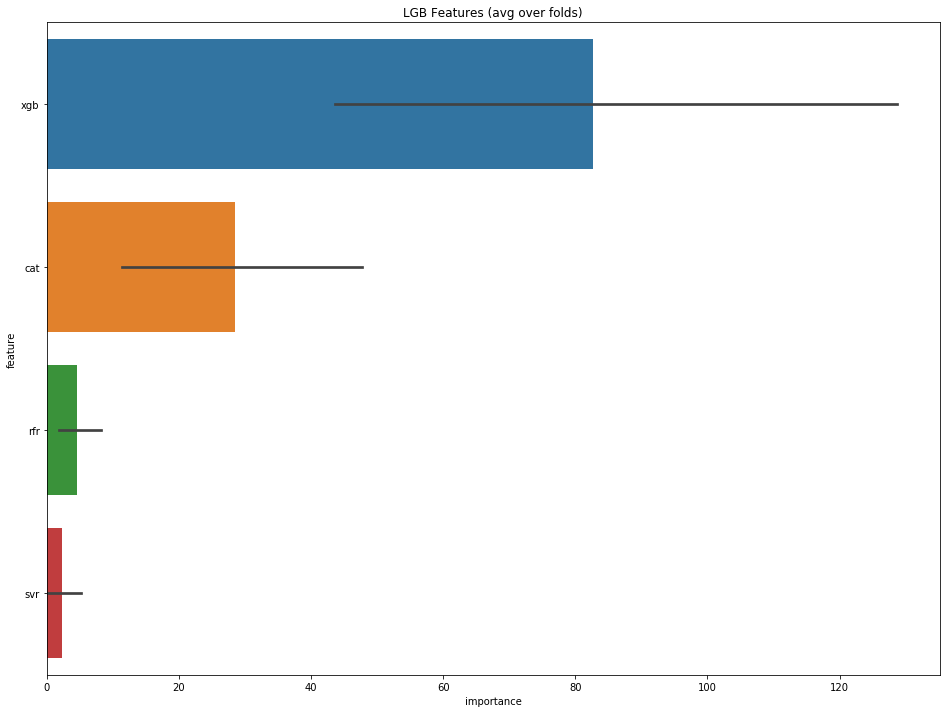

In [348]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 14:53:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[586]	training's rmse: 0.0910424	valid_1's rmse: 0.0293065
Fold 1 started at Sun Dec 15 14:53:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[586]	training's rmse: 0.0890444	valid_1's rmse: 0.080407
Fold 2 started at Sun Dec 15 14:53:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[144]	training's rmse: 0.0654639	valid_1's rmse: 0.228709
Fold 3 started at Sun Dec 15 14:53:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.088057	valid_1's rmse: 0.0228337
Early stopping, best iteration is:
[1207]	training's rmse: 0.0875814	valid_1's rmse: 0.0225888
Fold 4 started at Sun Dec 15 14:53:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

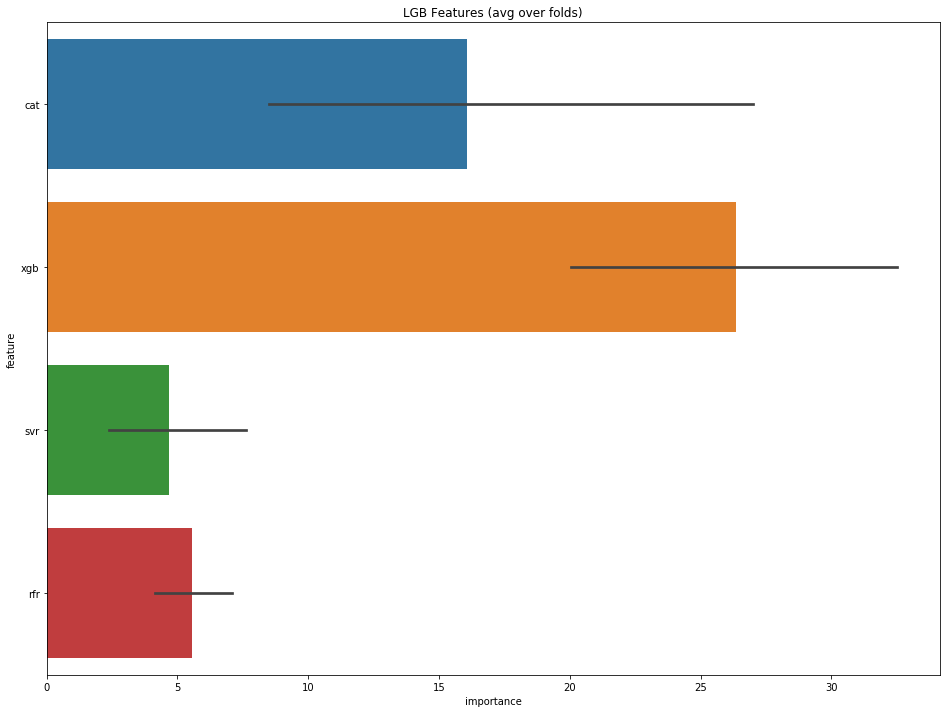

In [349]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [350]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 14:53:24 2019
Fold 1 started at Sun Dec 15 14:53:26 2019
Fold 2 started at Sun Dec 15 14:53:28 2019
Fold 3 started at Sun Dec 15 14:53:29 2019
Fold 4 started at Sun Dec 15 14:53:31 2019
Fold 5 started at Sun Dec 15 14:53:32 2019
Fold 6 started at Sun Dec 15 14:53:36 2019
Fold 7 started at Sun Dec 15 14:53:37 2019
Fold 8 started at Sun Dec 15 14:53:38 2019
Fold 9 started at Sun Dec 15 14:53:43 2019
CV mean score: 0.0663, std: 0.0563.


random forest做第二层融合模型

In [351]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 14:53:44 2019
Fold 1 started at Sun Dec 15 14:53:44 2019
Fold 2 started at Sun Dec 15 14:53:45 2019
Fold 3 started at Sun Dec 15 14:53:45 2019
Fold 4 started at Sun Dec 15 14:53:45 2019
Fold 5 started at Sun Dec 15 14:53:45 2019
Fold 6 started at Sun Dec 15 14:53:46 2019
Fold 7 started at Sun Dec 15 14:53:46 2019
Fold 8 started at Sun Dec 15 14:53:46 2019
Fold 9 started at Sun Dec 15 14:53:46 2019
CV mean score: 0.0704, std: 0.0604.


xgboost做第二层融合模型

In [352]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:53:47 2019
[0]	train-rmse:0.207417	valid_data-rmse:0.154117
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014477	valid_data-rmse:0.039451
Stopping. Best iteration:
[380]	train-rmse:0.02331	valid_data-rmse:0.03888

Fold 1 started at Sun Dec 15 14:53:47 2019
[0]	train-rmse:0.197628	valid_data-rmse:0.237737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014436	valid_data-rmse:0.041455
[1000]	train-rmse:0.002623	valid_data-rmse:0.039386
[1500]	train-rmse:0.000826	valid_data-rmse:0.039266
Stopping. Best iteration:
[1329]	train-rmse:0.001044	valid_data-rmse:0.039244

Fold 2 started at Sun Dec 15 14:53:47 2019
[0]	train-rmse:0.200606	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-

#### SVR作为meta

In [353]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 14:53:48 2019
Fold 1 started at Sun Dec 15 14:53:48 2019
Fold 2 started at Sun Dec 15 14:53:48 2019
Fold 3 started at Sun Dec 15 14:53:48 2019
Fold 4 started at Sun Dec 15 14:53:48 2019
Fold 5 started at Sun Dec 15 14:53:48 2019
Fold 6 started at Sun Dec 15 14:53:48 2019
Fold 7 started at Sun Dec 15 14:53:48 2019
Fold 8 started at Sun Dec 15 14:53:48 2019
Fold 9 started at Sun Dec 15 14:53:48 2019
CV mean score: 0.0789, std: 0.0531.


用岭回归做第二层融合模型

In [354]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 14:53:48 2019
Fold 1 started at Sun Dec 15 14:53:48 2019
Fold 2 started at Sun Dec 15 14:53:48 2019
Fold 3 started at Sun Dec 15 14:53:48 2019
Fold 4 started at Sun Dec 15 14:53:48 2019
Fold 5 started at Sun Dec 15 14:53:48 2019
Fold 6 started at Sun Dec 15 14:53:48 2019
Fold 7 started at Sun Dec 15 14:53:48 2019
Fold 8 started at Sun Dec 15 14:53:48 2019
Fold 9 started at Sun Dec 15 14:53:48 2019
CV mean score: 0.0674, std: 0.0557.


## space_ga 数据集实验

In [355]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('space_ga')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [356]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0819143	valid_1's rmse: 0.108325
[2000]	training's rmse: 0.0684396	valid_1's rmse: 0.105558
[3000]	training's rmse: 0.0604933	valid_1's rmse: 0.104595
[4000]	training's rmse: 0.0544426	valid_1's rmse: 0.104227
Early stopping, best iteration is:
[3876]	training's rmse: 0.0551018	valid_1's rmse: 0.104151


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [357]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 14:53:51 2019
Fold 1 started at Sun Dec 15 14:53:51 2019
Fold 2 started at Sun Dec 15 14:53:51 2019
Fold 3 started at Sun Dec 15 14:53:51 2019
Fold 4 started at Sun Dec 15 14:53:51 2019
Fold 5 started at Sun Dec 15 14:53:52 2019
Fold 6 started at Sun Dec 15 14:53:52 2019
Fold 7 started at Sun Dec 15 14:53:52 2019
Fold 8 started at Sun Dec 15 14:53:52 2019
Fold 9 started at Sun Dec 15 14:53:52 2019
CV mean score: 0.1975, std: 0.0165.


Fold 0 started at Sun Dec 15 14:53:52 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0764014	valid_1's rmse: 0.111502
[2000]	training's rmse: 0.0615625	valid_1's rmse: 0.108129
Early stopping, best iteration is:
[2608]	training's rmse: 0.0558129	valid_1's rmse: 0.107445
Fold 1 started at Sun Dec 15 14:53:54 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0766172	valid_1's rmse: 0.0988509
[2000]	training's rmse: 0.0618826	valid_1's rmse: 0.0969724
Early stopping, best iteration is:
[1947]	training's rmse: 0.0624591	valid_1's rmse: 0.0969001
Fold 2 started at Sun Dec 15 14:53:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0762247	valid_1's rmse: 0.115817
[2000]	training's rmse: 0.0615563	valid_1's rmse: 0.113049
Early stopping, best iteration is:
[2013]	training's rmse: 0.0614055	valid_1's rmse: 0.113033
Fold 3 started at Sun Dec 15 14:53:57 2019


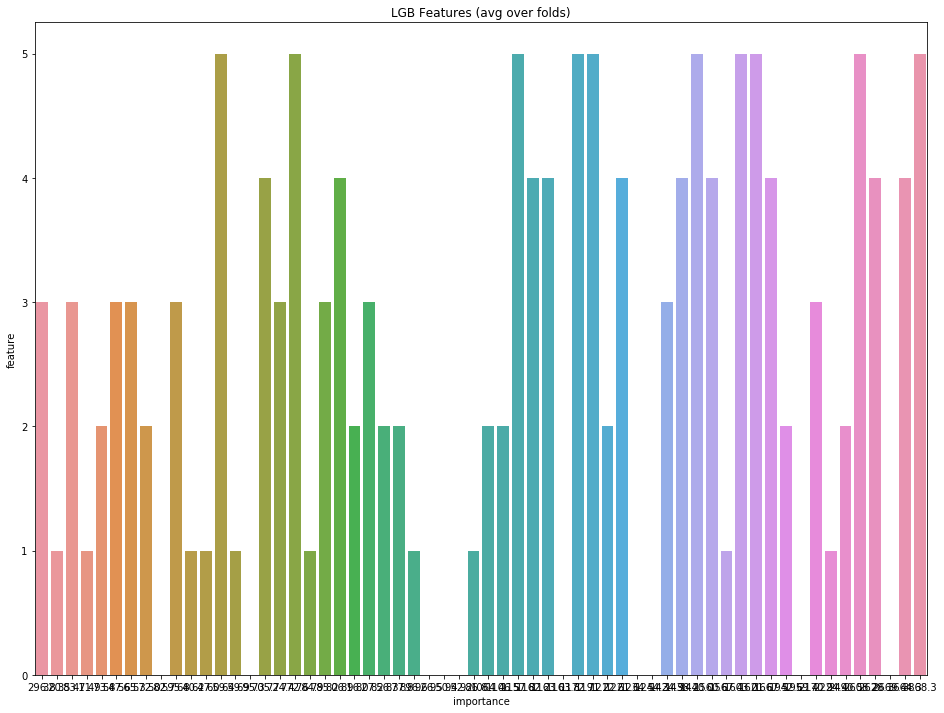

In [358]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:54:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0878367	valid_1's rmse: 0.115386
[2000]	training's rmse: 0.0750113	valid_1's rmse: 0.10996
[3000]	training's rmse: 0.0673456	valid_1's rmse: 0.107817
[4000]	training's rmse: 0.0616461	valid_1's rmse: 0.10676
[5000]	training's rmse: 0.0570346	valid_1's rmse: 0.106278
Early stopping, best iteration is:
[4901]	training's rmse: 0.0574641	valid_1's rmse: 0.106261
Fold 1 started at Sun Dec 15 14:54:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.087433	valid_1's rmse: 0.103035
[2000]	training's rmse: 0.0748182	valid_1's rmse: 0.0992899
[3000]	training's rmse: 0.0670707	valid_1's rmse: 0.0979835
Early stopping, best iteration is:
[3482]	training's rmse: 0.0641902	valid_1's rmse: 0.0975176
Fold 2 started at Sun Dec 15 14:54:21 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse

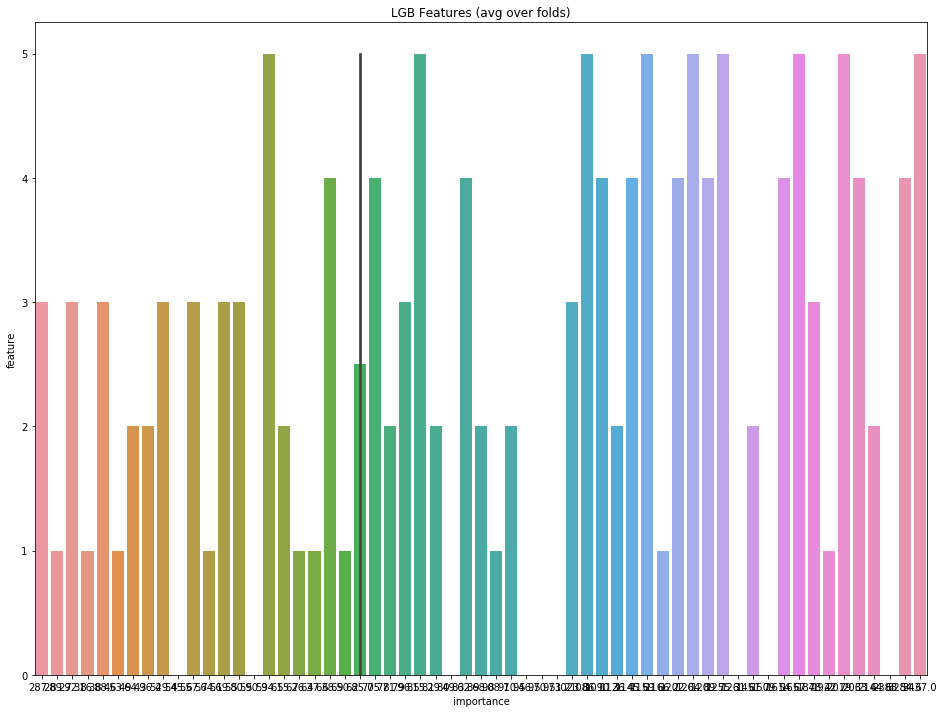

In [359]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 14:54:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0878367	valid_1's rmse: 0.115386
[2000]	training's rmse: 0.0750113	valid_1's rmse: 0.10996
[3000]	training's rmse: 0.0673456	valid_1's rmse: 0.107817
[4000]	training's rmse: 0.0616461	valid_1's rmse: 0.10676
[5000]	training's rmse: 0.0570346	valid_1's rmse: 0.106278
Early stopping, best iteration is:
[4901]	training's rmse: 0.0574641	valid_1's rmse: 0.106261
Fold 1 started at Sun Dec 15 14:54:43 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.087433	valid_1's rmse: 0.103035
[2000]	training's rmse: 0.0748182	valid_1's rmse: 0.0992899
[3000]	training's rmse: 0.0670707	valid_1's rmse: 0.0979835
Early stopping, best iteration is:
[3482]	training's rmse: 0.0641902	valid_1's rmse: 0.0975176
Fold 2 started at Sun Dec 15 14:54:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse

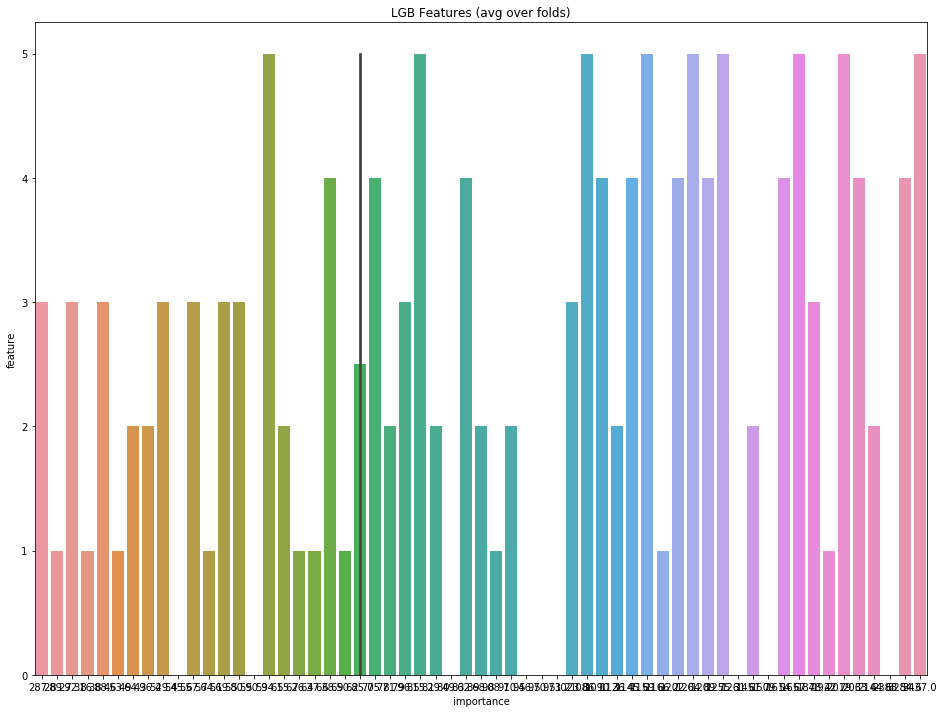

In [360]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [361]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 14:55:04 2019
Fold 1 started at Sun Dec 15 14:55:05 2019
Fold 2 started at Sun Dec 15 14:55:05 2019
Fold 3 started at Sun Dec 15 14:55:05 2019
Fold 4 started at Sun Dec 15 14:55:05 2019
Fold 5 started at Sun Dec 15 14:55:06 2019
Fold 6 started at Sun Dec 15 14:55:06 2019
Fold 7 started at Sun Dec 15 14:55:06 2019
Fold 8 started at Sun Dec 15 14:55:06 2019
Fold 9 started at Sun Dec 15 14:55:07 2019
CV mean score: 0.1230, std: 0.0201.


In [362]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 14:55:07 2019
[0]	train-rmse:1.08129	valid_data-rmse:1.10413
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.071597	valid_data-rmse:0.1225
[1000]	train-rmse:0.051415	valid_data-rmse:0.116264
[1500]	train-rmse:0.039962	valid_data-rmse:0.114554
[2000]	train-rmse:0.032159	valid_data-rmse:0.113986
[2500]	train-rmse:0.026333	valid_data-rmse:0.113579
[3000]	train-rmse:0.021869	valid_data-rmse:0.113386
[3500]	train-rmse:0.018307	valid_data-rmse:0.113292
Stopping. Best iteration:
[3541]	train-rmse:0.01806	valid_data-rmse:0.113261

Fold 1 started at Sun Dec 15 14:55:15 2019
[0]	train-rmse:1.0834	valid_data-rmse:1.08558
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.072245	valid_data-rmse:0.105339
[1000]	train-rmse:0

In [363]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 14:56:14 2019
Fold 1 started at Sun Dec 15 14:56:36 2019
Fold 2 started at Sun Dec 15 14:56:59 2019
Fold 3 started at Sun Dec 15 14:57:22 2019
Fold 4 started at Sun Dec 15 14:57:45 2019
Fold 5 started at Sun Dec 15 14:58:09 2019
Fold 6 started at Sun Dec 15 14:58:31 2019
Fold 7 started at Sun Dec 15 14:58:54 2019
Fold 8 started at Sun Dec 15 14:59:17 2019
Fold 9 started at Sun Dec 15 14:59:39 2019
CV mean score: 0.1097, std: 0.0156.


## stacking

Fold 0 started at Sun Dec 15 15:00:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[386]	training's rmse: 0.1002	valid_1's rmse: 0.109843
Fold 1 started at Sun Dec 15 15:00:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[311]	training's rmse: 0.102136	valid_1's rmse: 0.0983605
Fold 2 started at Sun Dec 15 15:00:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[334]	training's rmse: 0.100344	valid_1's rmse: 0.112765
Fold 3 started at Sun Dec 15 15:00:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[248]	training's rmse: 0.104458	valid_1's rmse: 0.0884738
Fold 4 started at Sun Dec 15 15:00:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0926322	valid_1's rmse: 0.146743
Early stopping, best iteration is:
[809]	tr

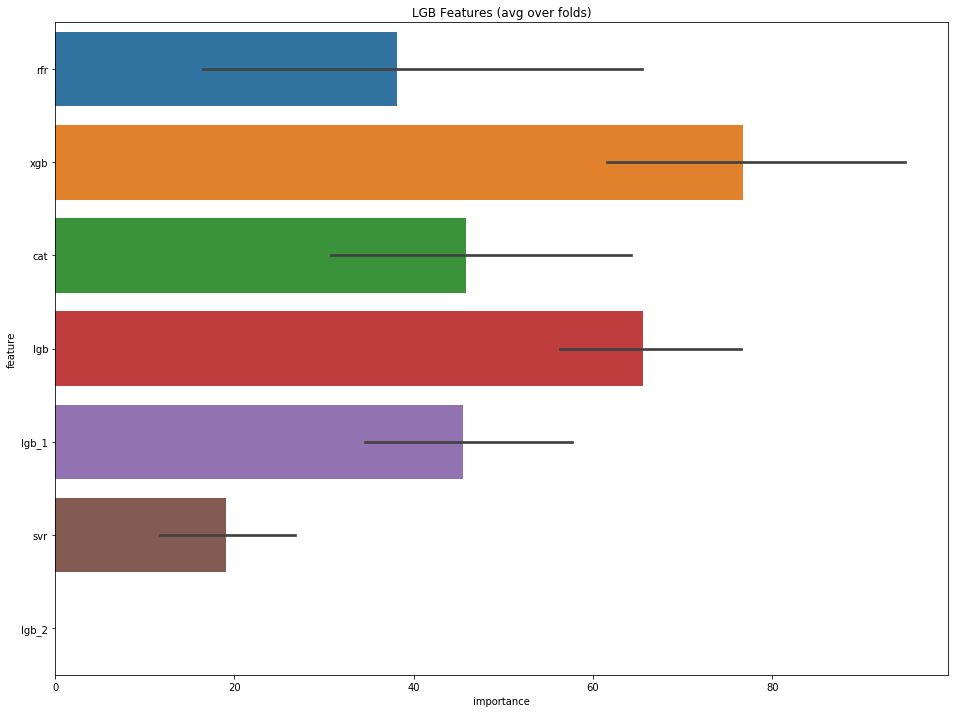

In [364]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:00:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0921013	valid_1's rmse: 0.111307
Fold 1 started at Sun Dec 15 15:00:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[275]	training's rmse: 0.0968037	valid_1's rmse: 0.0995917
Fold 2 started at Sun Dec 15 15:00:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.09706	valid_1's rmse: 0.11313
Fold 3 started at Sun Dec 15 15:00:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[250]	training's rmse: 0.0989329	valid_1's rmse: 0.0886035
Fold 4 started at Sun Dec 15 15:00:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0782381	valid_1's rmse: 0.148388
Early stopping, best iteration is:
[943]

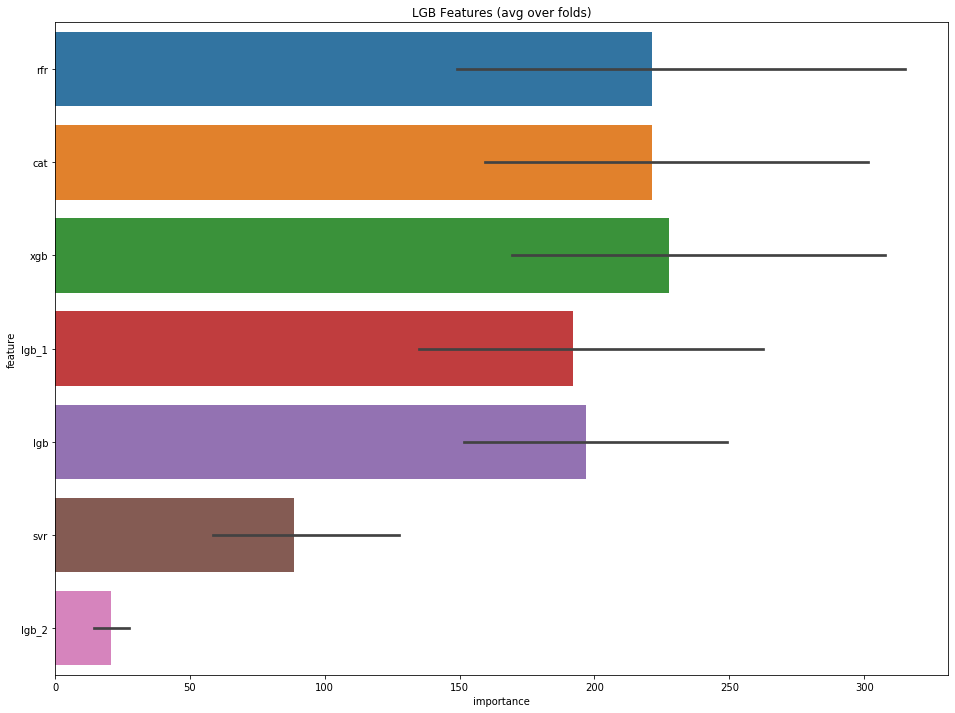

In [365]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [366]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:00:10 2019
Fold 1 started at Sun Dec 15 15:00:16 2019
Fold 2 started at Sun Dec 15 15:00:19 2019
Fold 3 started at Sun Dec 15 15:00:25 2019
Fold 4 started at Sun Dec 15 15:00:28 2019
Fold 5 started at Sun Dec 15 15:00:32 2019
Fold 6 started at Sun Dec 15 15:00:37 2019
Fold 7 started at Sun Dec 15 15:00:52 2019
Fold 8 started at Sun Dec 15 15:00:56 2019
Fold 9 started at Sun Dec 15 15:00:58 2019
CV mean score: 0.1047, std: 0.0172.


random forest做第二层融合模型

In [367]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:01:01 2019
Fold 1 started at Sun Dec 15 15:01:01 2019
Fold 2 started at Sun Dec 15 15:01:01 2019
Fold 3 started at Sun Dec 15 15:01:02 2019
Fold 4 started at Sun Dec 15 15:01:02 2019
Fold 5 started at Sun Dec 15 15:01:02 2019
Fold 6 started at Sun Dec 15 15:01:02 2019
Fold 7 started at Sun Dec 15 15:01:03 2019
Fold 8 started at Sun Dec 15 15:01:03 2019
Fold 9 started at Sun Dec 15 15:01:03 2019
CV mean score: 0.1062, std: 0.0152.


xgboost做第二层融合模型

In [368]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:01:03 2019
[0]	train-rmse:1.08121	valid_data-rmse:1.10409
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.079326	valid_data-rmse:0.116221
Stopping. Best iteration:
[786]	train-rmse:0.070928	valid_data-rmse:0.114648

Fold 1 started at Sun Dec 15 15:01:05 2019
[0]	train-rmse:1.08331	valid_data-rmse:1.08547
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.079649	valid_data-rmse:0.099614
Stopping. Best iteration:
[517]	train-rmse:0.079067	valid_data-rmse:0.099556

Fold 2 started at Sun Dec 15 15:01:07 2019
[0]	train-rmse:1.08294	valid_data-rmse:1.08857
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500

#### SVR作为meta

In [369]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:01:19 2019
Fold 1 started at Sun Dec 15 15:01:19 2019
Fold 2 started at Sun Dec 15 15:01:19 2019
Fold 3 started at Sun Dec 15 15:01:19 2019
Fold 4 started at Sun Dec 15 15:01:19 2019
Fold 5 started at Sun Dec 15 15:01:19 2019
Fold 6 started at Sun Dec 15 15:01:19 2019
Fold 7 started at Sun Dec 15 15:01:19 2019
Fold 8 started at Sun Dec 15 15:01:19 2019
Fold 9 started at Sun Dec 15 15:01:20 2019
CV mean score: 0.1032, std: 0.0155.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 15:01:20 2019
Fold 1 started at Sun Dec 15 15:01:20 2019
Fold 2 started at Sun Dec 15 15:01:20 2019
Fold 3 started at Sun Dec 15 15:01:20 2019
Fold 4 started at Sun Dec 15 15:01:20 2019
Fold 5 started at Sun Dec 15 15:01:20 2019
Fold 6 started at Sun Dec 15 15:01:20 2019
Fold 7 started at Sun Dec 15 15:01:20 2019
Fold 8 started at Sun Dec 15 15:01:20 2019
Fold 9 started at Sun Dec 15 15:01:20 2019
CV mean score: 0.1025, std: 0.0136.
Fold 0 started at Sun Dec 15 15:01:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[495]	training's rmse: 0.099629	valid_1's rmse: 0.110385
Fold 1 started at Sun Dec 15 15:01:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[314]	training's rmse: 0.102374	valid_1's rmse: 0.0985975
Fold 2 started at Sun Dec 15 15:01:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration 

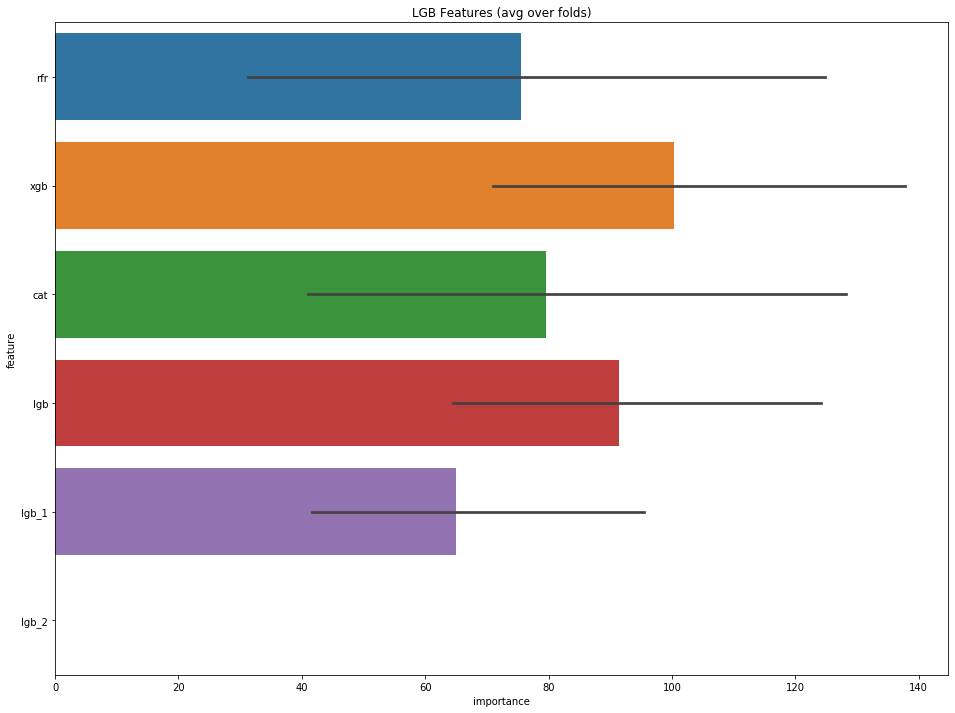

In [370]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:01:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0918785	valid_1's rmse: 0.111042
Fold 1 started at Sun Dec 15 15:01:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[301]	training's rmse: 0.0965792	valid_1's rmse: 0.0999955
Fold 2 started at Sun Dec 15 15:01:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 0.0974253	valid_1's rmse: 0.113632
Fold 3 started at Sun Dec 15 15:01:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[224]	training's rmse: 0.10079	valid_1's rmse: 0.0882829
Fold 4 started at Sun Dec 15 15:01:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0805359	valid_1's rmse: 0.146355
Early stopping, best iteration is:
[885

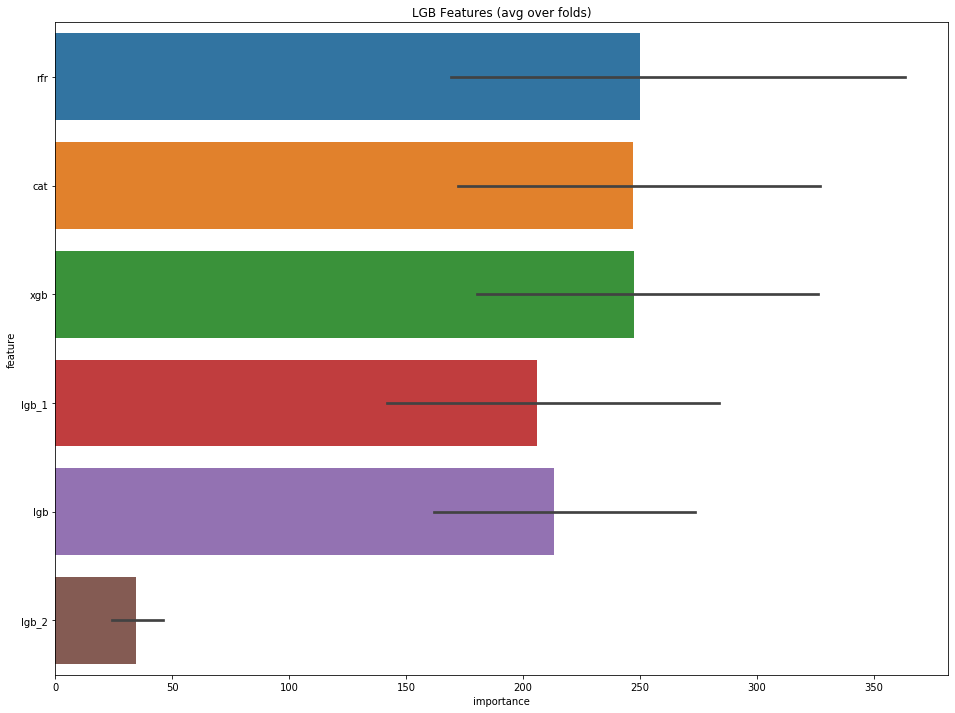

In [371]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [372]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:01:29 2019
Fold 1 started at Sun Dec 15 15:01:32 2019
Fold 2 started at Sun Dec 15 15:01:36 2019
Fold 3 started at Sun Dec 15 15:01:42 2019
Fold 4 started at Sun Dec 15 15:01:44 2019
Fold 5 started at Sun Dec 15 15:01:58 2019
Fold 6 started at Sun Dec 15 15:02:11 2019
Fold 7 started at Sun Dec 15 15:02:26 2019
Fold 8 started at Sun Dec 15 15:02:31 2019
Fold 9 started at Sun Dec 15 15:02:33 2019
CV mean score: 0.1032, std: 0.0142.


random forest做第二层融合模型

In [373]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:02:35 2019
Fold 1 started at Sun Dec 15 15:02:35 2019
Fold 2 started at Sun Dec 15 15:02:35 2019
Fold 3 started at Sun Dec 15 15:02:36 2019
Fold 4 started at Sun Dec 15 15:02:36 2019
Fold 5 started at Sun Dec 15 15:02:36 2019
Fold 6 started at Sun Dec 15 15:02:36 2019
Fold 7 started at Sun Dec 15 15:02:37 2019
Fold 8 started at Sun Dec 15 15:02:37 2019
Fold 9 started at Sun Dec 15 15:02:37 2019
CV mean score: 0.1056, std: 0.0140.


xgboost做第二层融合模型

In [374]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:02:37 2019
[0]	train-rmse:1.08121	valid_data-rmse:1.10409
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.080359	valid_data-rmse:0.116101
Stopping. Best iteration:
[636]	train-rmse:0.076022	valid_data-rmse:0.115155

Fold 1 started at Sun Dec 15 15:02:39 2019
[0]	train-rmse:1.08331	valid_data-rmse:1.08547
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.08039	valid_data-rmse:0.099728
Stopping. Best iteration:
[531]	train-rmse:0.079313	valid_data-rmse:0.099572

Fold 2 started at Sun Dec 15 15:02:40 2019
[0]	train-rmse:1.08294	valid_data-rmse:1.08857
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]

#### SVR作为meta

In [375]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:02:51 2019
Fold 1 started at Sun Dec 15 15:02:51 2019
Fold 2 started at Sun Dec 15 15:02:51 2019
Fold 3 started at Sun Dec 15 15:02:51 2019
Fold 4 started at Sun Dec 15 15:02:51 2019
Fold 5 started at Sun Dec 15 15:02:52 2019
Fold 6 started at Sun Dec 15 15:02:52 2019
Fold 7 started at Sun Dec 15 15:02:52 2019
Fold 8 started at Sun Dec 15 15:02:52 2019
Fold 9 started at Sun Dec 15 15:02:52 2019
CV mean score: 0.1032, std: 0.0155.


用岭回归做第二层融合模型

In [376]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:02:52 2019
Fold 1 started at Sun Dec 15 15:02:52 2019
Fold 2 started at Sun Dec 15 15:02:52 2019
Fold 3 started at Sun Dec 15 15:02:52 2019
Fold 4 started at Sun Dec 15 15:02:52 2019
Fold 5 started at Sun Dec 15 15:02:52 2019
Fold 6 started at Sun Dec 15 15:02:52 2019
Fold 7 started at Sun Dec 15 15:02:52 2019
Fold 8 started at Sun Dec 15 15:02:52 2019
Fold 9 started at Sun Dec 15 15:02:53 2019
CV mean score: 0.1025, std: 0.0136.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 15:02:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[692]	training's rmse: 0.0999814	valid_1's rmse: 0.107267
Fold 1 started at Sun Dec 15 15:02:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[352]	training's rmse: 0.102199	valid_1's rmse: 0.0983957
Fold 2 started at Sun Dec 15 15:02:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[301]	training's rmse: 0.101261	valid_1's rmse: 0.113123
Fold 3 started at Sun Dec 15 15:02:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 0.105375	valid_1's rmse: 0.0891201
Fold 4 started at Sun Dec 15 15:02:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[731]	training's rmse: 0.0944189	valid_1's rmse: 0.148587
Fold 5

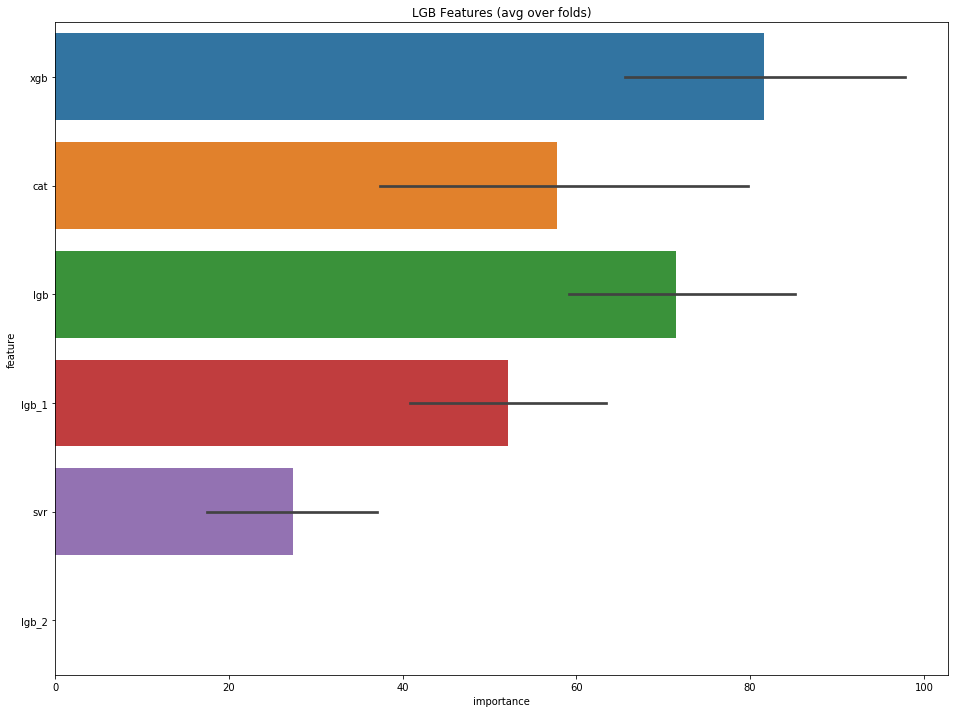

In [377]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:02:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[518]	training's rmse: 0.0920447	valid_1's rmse: 0.109434
Fold 1 started at Sun Dec 15 15:02:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rmse: 0.0974381	valid_1's rmse: 0.100121
Fold 2 started at Sun Dec 15 15:02:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's rmse: 0.097972	valid_1's rmse: 0.113541
Fold 3 started at Sun Dec 15 15:02:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.0997822	valid_1's rmse: 0.0885391
Fold 4 started at Sun Dec 15 15:02:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[461]	training's rmse: 0.0872444	valid_1's rmse: 0.150901
Fold 

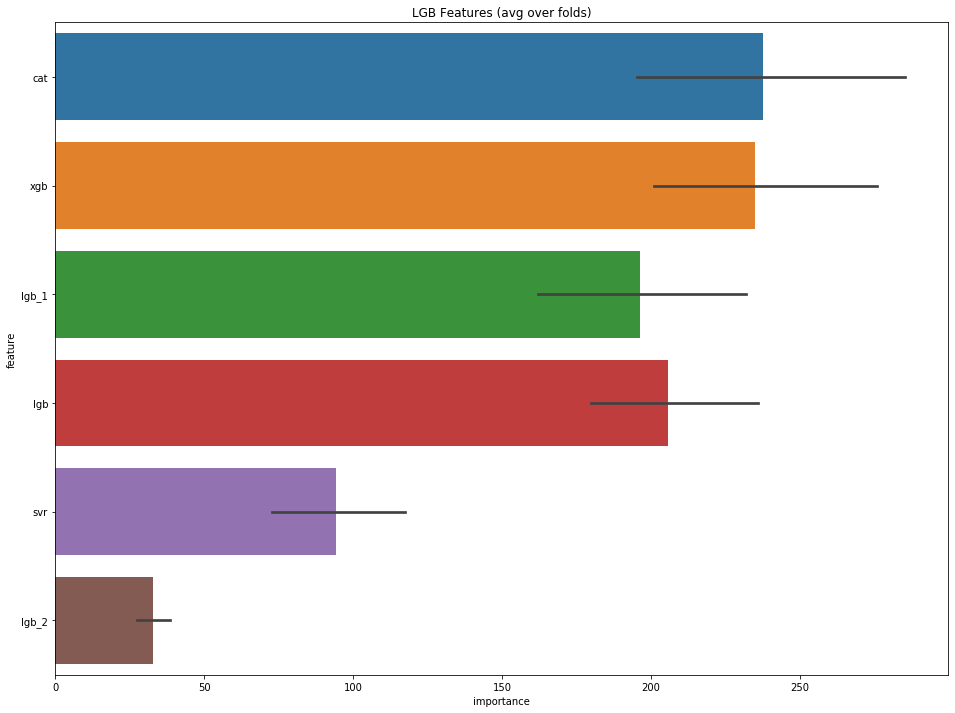

In [378]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [379]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:03:00 2019
Fold 1 started at Sun Dec 15 15:03:05 2019
Fold 2 started at Sun Dec 15 15:03:08 2019
Fold 3 started at Sun Dec 15 15:03:11 2019
Fold 4 started at Sun Dec 15 15:03:15 2019
Fold 5 started at Sun Dec 15 15:03:20 2019
Fold 6 started at Sun Dec 15 15:03:22 2019
Fold 7 started at Sun Dec 15 15:03:25 2019
Fold 8 started at Sun Dec 15 15:03:30 2019
Fold 9 started at Sun Dec 15 15:03:31 2019
CV mean score: 0.1043, std: 0.0175.


random forest做第二层融合模型

In [380]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:03:35 2019
Fold 1 started at Sun Dec 15 15:03:35 2019
Fold 2 started at Sun Dec 15 15:03:36 2019
Fold 3 started at Sun Dec 15 15:03:36 2019
Fold 4 started at Sun Dec 15 15:03:36 2019
Fold 5 started at Sun Dec 15 15:03:36 2019
Fold 6 started at Sun Dec 15 15:03:37 2019
Fold 7 started at Sun Dec 15 15:03:37 2019
Fold 8 started at Sun Dec 15 15:03:37 2019
Fold 9 started at Sun Dec 15 15:03:37 2019
CV mean score: 0.1059, std: 0.0162.


xgboost做第二层融合模型

In [381]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:03:38 2019
[0]	train-rmse:1.08121	valid_data-rmse:1.10409
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.081162	valid_data-rmse:0.115851
Stopping. Best iteration:
[636]	train-rmse:0.076963	valid_data-rmse:0.114759

Fold 1 started at Sun Dec 15 15:03:39 2019
[0]	train-rmse:1.08331	valid_data-rmse:1.08547
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.081029	valid_data-rmse:0.099634
Stopping. Best iteration:
[545]	train-rmse:0.079541	valid_data-rmse:0.099505

Fold 2 started at Sun Dec 15 15:03:40 2019
[0]	train-rmse:1.08294	valid_data-rmse:1.08857
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500

#### SVR作为meta

In [382]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:03:51 2019
Fold 1 started at Sun Dec 15 15:03:51 2019
Fold 2 started at Sun Dec 15 15:03:51 2019
Fold 3 started at Sun Dec 15 15:03:51 2019
Fold 4 started at Sun Dec 15 15:03:51 2019
Fold 5 started at Sun Dec 15 15:03:51 2019
Fold 6 started at Sun Dec 15 15:03:51 2019
Fold 7 started at Sun Dec 15 15:03:51 2019
Fold 8 started at Sun Dec 15 15:03:51 2019
Fold 9 started at Sun Dec 15 15:03:51 2019
CV mean score: 0.1035, std: 0.0158.


用岭回归做第二层融合模型

In [383]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:03:52 2019
Fold 1 started at Sun Dec 15 15:03:52 2019
Fold 2 started at Sun Dec 15 15:03:52 2019
Fold 3 started at Sun Dec 15 15:03:52 2019
Fold 4 started at Sun Dec 15 15:03:52 2019
Fold 5 started at Sun Dec 15 15:03:52 2019
Fold 6 started at Sun Dec 15 15:03:52 2019
Fold 7 started at Sun Dec 15 15:03:52 2019
Fold 8 started at Sun Dec 15 15:03:52 2019
Fold 9 started at Sun Dec 15 15:03:52 2019
CV mean score: 0.1029, std: 0.0143.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 15:03:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[414]	training's rmse: 0.100589	valid_1's rmse: 0.109976
Fold 1 started at Sun Dec 15 15:03:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[355]	training's rmse: 0.102113	valid_1's rmse: 0.0979318
Fold 2 started at Sun Dec 15 15:03:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.101452	valid_1's rmse: 0.111957
Fold 3 started at Sun Dec 15 15:03:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.103893	valid_1's rmse: 0.0877681
Fold 4 started at Sun Dec 15 15:03:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0931769	valid_1's rmse: 0.14772
Early stopping, best iteration is:
[1735]	

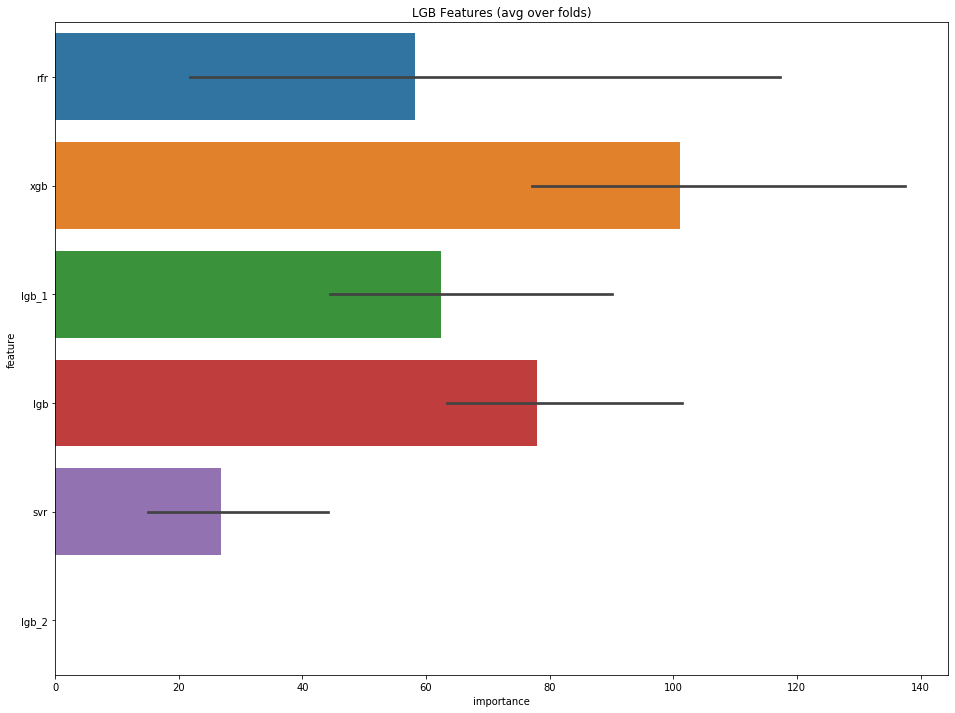

In [384]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:03:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[441]	training's rmse: 0.0925851	valid_1's rmse: 0.111752
Fold 1 started at Sun Dec 15 15:03:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[300]	training's rmse: 0.0968457	valid_1's rmse: 0.099591
Fold 2 started at Sun Dec 15 15:03:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[232]	training's rmse: 0.0984835	valid_1's rmse: 0.111889
Fold 3 started at Sun Dec 15 15:03:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[270]	training's rmse: 0.099299	valid_1's rmse: 0.0879075
Fold 4 started at Sun Dec 15 15:03:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0803789	valid_1's rmse: 0.149023
Early stopping, best iteration is:
[869

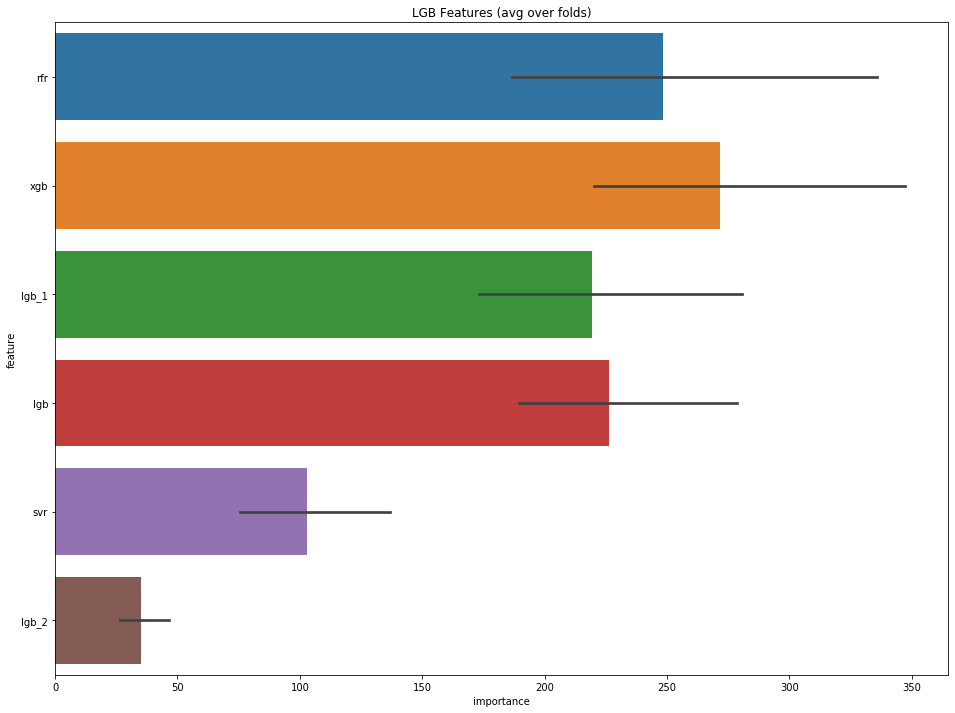

In [385]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [386]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:04:00 2019
Fold 1 started at Sun Dec 15 15:04:03 2019
Fold 2 started at Sun Dec 15 15:04:06 2019
Fold 3 started at Sun Dec 15 15:04:12 2019
Fold 4 started at Sun Dec 15 15:04:15 2019
Fold 5 started at Sun Dec 15 15:04:19 2019
Fold 6 started at Sun Dec 15 15:04:24 2019
Fold 7 started at Sun Dec 15 15:04:29 2019
Fold 8 started at Sun Dec 15 15:04:34 2019
Fold 9 started at Sun Dec 15 15:04:35 2019
CV mean score: 0.1046, std: 0.0174.


random forest做第二层融合模型

In [387]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:04:41 2019
Fold 1 started at Sun Dec 15 15:04:41 2019
Fold 2 started at Sun Dec 15 15:04:42 2019
Fold 3 started at Sun Dec 15 15:04:42 2019
Fold 4 started at Sun Dec 15 15:04:42 2019
Fold 5 started at Sun Dec 15 15:04:42 2019
Fold 6 started at Sun Dec 15 15:04:43 2019
Fold 7 started at Sun Dec 15 15:04:43 2019
Fold 8 started at Sun Dec 15 15:04:43 2019
Fold 9 started at Sun Dec 15 15:04:43 2019
CV mean score: 0.1061, std: 0.0158.


xgboost做第二层融合模型

In [388]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:04:44 2019
[0]	train-rmse:1.08121	valid_data-rmse:1.10409
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.081044	valid_data-rmse:0.115016
[1000]	train-rmse:0.067327	valid_data-rmse:0.112309
Stopping. Best iteration:
[911]	train-rmse:0.069704	valid_data-rmse:0.112165

Fold 1 started at Sun Dec 15 15:04:46 2019
[0]	train-rmse:1.08331	valid_data-rmse:1.08547
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.080971	valid_data-rmse:0.099135
Stopping. Best iteration:
[524]	train-rmse:0.080172	valid_data-rmse:0.098961

Fold 2 started at Sun Dec 15 15:04:47 2019
[0]	train-rmse:1.08294	valid_data-rmse:1.08857
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until

#### SVR作为meta

In [389]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:04:58 2019
Fold 1 started at Sun Dec 15 15:04:58 2019
Fold 2 started at Sun Dec 15 15:04:58 2019
Fold 3 started at Sun Dec 15 15:04:58 2019
Fold 4 started at Sun Dec 15 15:04:58 2019
Fold 5 started at Sun Dec 15 15:04:58 2019
Fold 6 started at Sun Dec 15 15:04:58 2019
Fold 7 started at Sun Dec 15 15:04:58 2019
Fold 8 started at Sun Dec 15 15:04:58 2019
Fold 9 started at Sun Dec 15 15:04:58 2019
CV mean score: 0.1033, std: 0.0158.


用岭回归做第二层融合模型

In [390]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 15:04:58 2019
Fold 1 started at Sun Dec 15 15:04:58 2019
Fold 2 started at Sun Dec 15 15:04:58 2019
Fold 3 started at Sun Dec 15 15:04:58 2019
Fold 4 started at Sun Dec 15 15:04:59 2019
Fold 5 started at Sun Dec 15 15:04:59 2019
Fold 6 started at Sun Dec 15 15:04:59 2019
Fold 7 started at Sun Dec 15 15:04:59 2019
Fold 8 started at Sun Dec 15 15:04:59 2019
Fold 9 started at Sun Dec 15 15:04:59 2019
CV mean score: 0.1024, std: 0.0137.


### 去掉xgboost

Fold 0 started at Sun Dec 15 15:04:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[538]	training's rmse: 0.10009	valid_1's rmse: 0.109752
Fold 1 started at Sun Dec 15 15:04:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[322]	training's rmse: 0.102802	valid_1's rmse: 0.0990727
Fold 2 started at Sun Dec 15 15:04:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[333]	training's rmse: 0.101506	valid_1's rmse: 0.113112
Fold 3 started at Sun Dec 15 15:05:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[268]	training's rmse: 0.104839	valid_1's rmse: 0.0895123
Fold 4 started at Sun Dec 15 15:05:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0942035	valid_1's rmse: 0.147497
Early stopping, best iteration is:
[955]	t

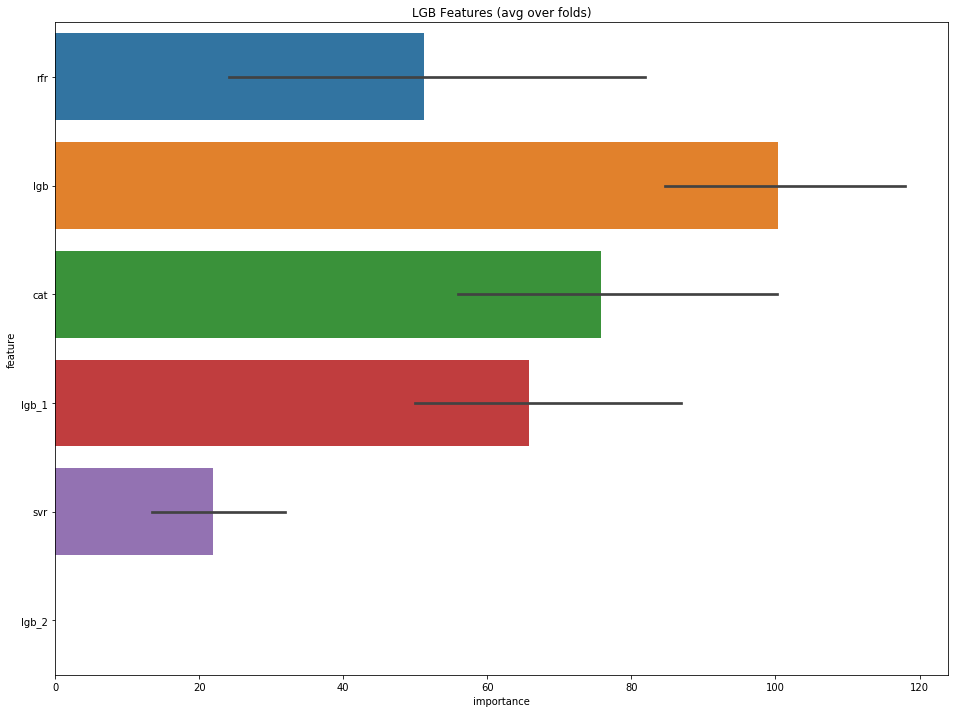

In [391]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:05:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[453]	training's rmse: 0.0927221	valid_1's rmse: 0.111498
Fold 1 started at Sun Dec 15 15:05:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[299]	training's rmse: 0.0974318	valid_1's rmse: 0.0999261
Fold 2 started at Sun Dec 15 15:05:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[241]	training's rmse: 0.0986419	valid_1's rmse: 0.113393
Fold 3 started at Sun Dec 15 15:05:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[257]	training's rmse: 0.100146	valid_1's rmse: 0.0894512
Fold 4 started at Sun Dec 15 15:05:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.081166	valid_1's rmse: 0.147912
Early stopping, best iteration is:
[996

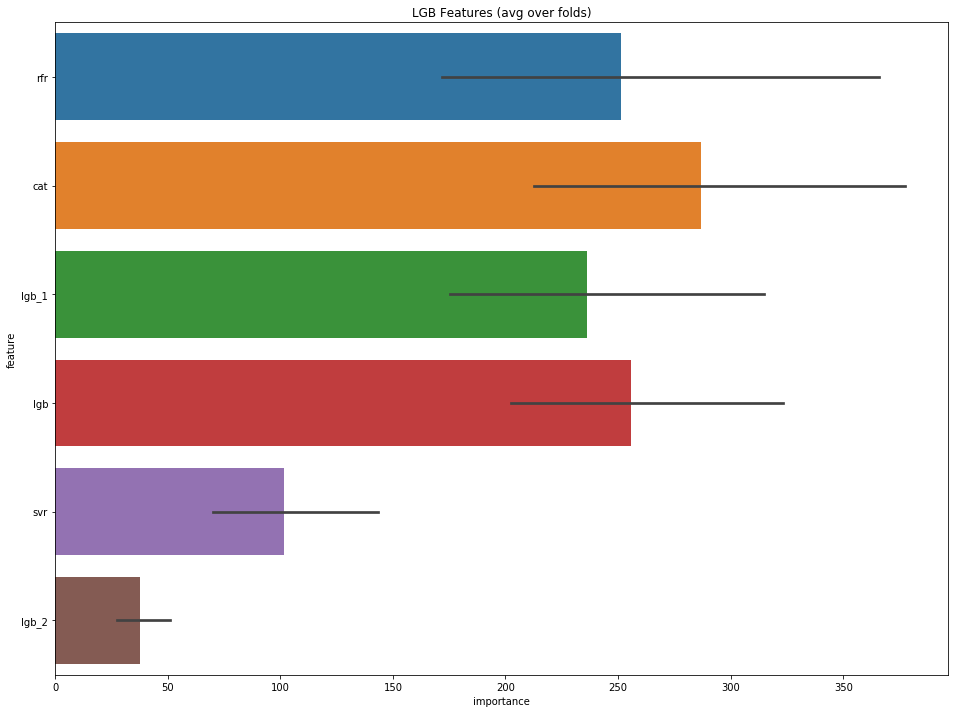

In [392]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [393]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:05:07 2019
Fold 1 started at Sun Dec 15 15:05:13 2019
Fold 2 started at Sun Dec 15 15:05:21 2019
Fold 3 started at Sun Dec 15 15:05:26 2019
Fold 4 started at Sun Dec 15 15:05:30 2019
Fold 5 started at Sun Dec 15 15:05:37 2019
Fold 6 started at Sun Dec 15 15:05:47 2019
Fold 7 started at Sun Dec 15 15:05:52 2019
Fold 8 started at Sun Dec 15 15:05:57 2019
Fold 9 started at Sun Dec 15 15:05:58 2019
CV mean score: 0.1051, std: 0.0165.


random forest做第二层融合模型

In [394]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:06:03 2019
Fold 1 started at Sun Dec 15 15:06:03 2019
Fold 2 started at Sun Dec 15 15:06:03 2019
Fold 3 started at Sun Dec 15 15:06:04 2019
Fold 4 started at Sun Dec 15 15:06:04 2019
Fold 5 started at Sun Dec 15 15:06:04 2019
Fold 6 started at Sun Dec 15 15:06:04 2019
Fold 7 started at Sun Dec 15 15:06:05 2019
Fold 8 started at Sun Dec 15 15:06:05 2019
Fold 9 started at Sun Dec 15 15:06:05 2019
CV mean score: 0.1069, std: 0.0158.


xgboost做第二层融合模型

In [395]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:06:05 2019
[0]	train-rmse:1.08121	valid_data-rmse:1.10408
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.081488	valid_data-rmse:0.115612
Stopping. Best iteration:
[724]	train-rmse:0.074869	valid_data-rmse:0.114415

Fold 1 started at Sun Dec 15 15:06:07 2019
[0]	train-rmse:1.08331	valid_data-rmse:1.08542
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.081422	valid_data-rmse:0.100271
Stopping. Best iteration:
[513]	train-rmse:0.080996	valid_data-rmse:0.100197

Fold 2 started at Sun Dec 15 15:06:08 2019
[0]	train-rmse:1.08294	valid_data-rmse:1.08856
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500

#### SVR作为meta

In [396]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:06:19 2019
Fold 1 started at Sun Dec 15 15:06:19 2019
Fold 2 started at Sun Dec 15 15:06:20 2019
Fold 3 started at Sun Dec 15 15:06:20 2019
Fold 4 started at Sun Dec 15 15:06:20 2019
Fold 5 started at Sun Dec 15 15:06:20 2019
Fold 6 started at Sun Dec 15 15:06:20 2019
Fold 7 started at Sun Dec 15 15:06:20 2019
Fold 8 started at Sun Dec 15 15:06:20 2019
Fold 9 started at Sun Dec 15 15:06:20 2019
CV mean score: 0.1037, std: 0.0149.


用岭回归做第二层融合模型

In [397]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:06:20 2019
Fold 1 started at Sun Dec 15 15:06:20 2019
Fold 2 started at Sun Dec 15 15:06:20 2019
Fold 3 started at Sun Dec 15 15:06:20 2019
Fold 4 started at Sun Dec 15 15:06:20 2019
Fold 5 started at Sun Dec 15 15:06:20 2019
Fold 6 started at Sun Dec 15 15:06:20 2019
Fold 7 started at Sun Dec 15 15:06:21 2019
Fold 8 started at Sun Dec 15 15:06:21 2019
Fold 9 started at Sun Dec 15 15:06:21 2019
CV mean score: 0.1030, std: 0.0132.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 15:06:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 0.101276	valid_1's rmse: 0.113355
Fold 1 started at Sun Dec 15 15:06:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 0.104304	valid_1's rmse: 0.100355
Fold 2 started at Sun Dec 15 15:06:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[318]	training's rmse: 0.102521	valid_1's rmse: 0.115743
Fold 3 started at Sun Dec 15 15:06:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.106452	valid_1's rmse: 0.0891027
Fold 4 started at Sun Dec 15 15:06:22 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0949489	valid_1's rmse: 0.149796
Early stopping, best iteration is:
[1522]	

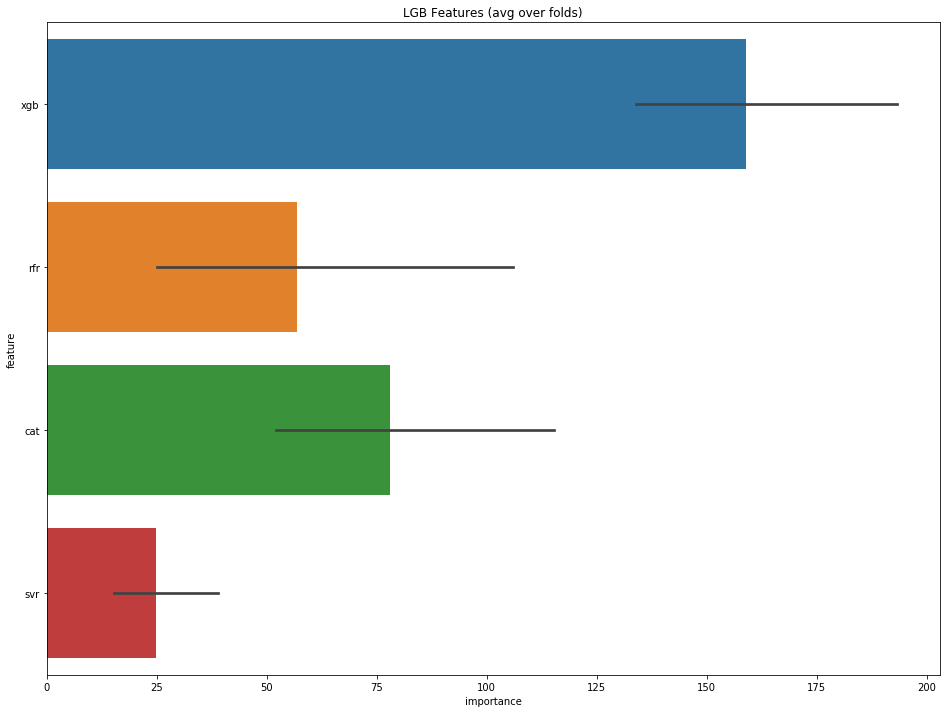

In [398]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:06:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[450]	training's rmse: 0.0951802	valid_1's rmse: 0.114167
Fold 1 started at Sun Dec 15 15:06:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[283]	training's rmse: 0.100162	valid_1's rmse: 0.100899
Fold 2 started at Sun Dec 15 15:06:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 0.1007	valid_1's rmse: 0.116243
Fold 3 started at Sun Dec 15 15:06:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[254]	training's rmse: 0.102229	valid_1's rmse: 0.0893791
Fold 4 started at Sun Dec 15 15:06:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[737]	training's rmse: 0.0863999	valid_1's rmse: 0.151712
Fold 5 st

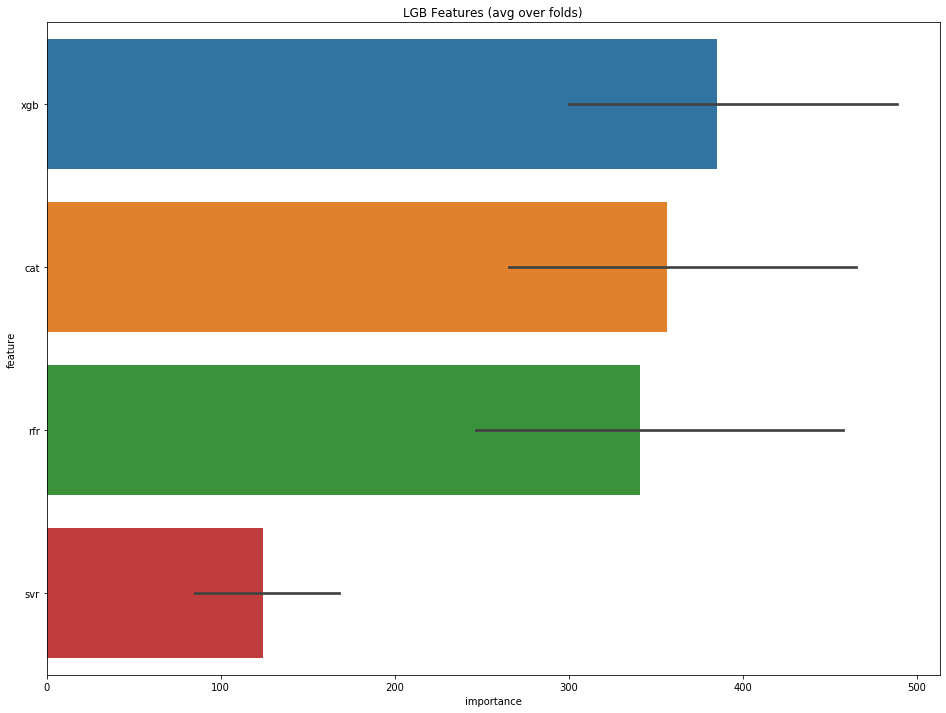

In [399]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [400]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:06:28 2019
Fold 1 started at Sun Dec 15 15:06:40 2019
Fold 2 started at Sun Dec 15 15:06:43 2019
Fold 3 started at Sun Dec 15 15:06:49 2019
Fold 4 started at Sun Dec 15 15:06:53 2019
Fold 5 started at Sun Dec 15 15:07:01 2019
Fold 6 started at Sun Dec 15 15:07:15 2019
Fold 7 started at Sun Dec 15 15:07:31 2019
Fold 8 started at Sun Dec 15 15:07:35 2019
Fold 9 started at Sun Dec 15 15:07:37 2019
CV mean score: 0.1056, std: 0.0174.


random forest做第二层融合模型

In [401]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:07:40 2019
Fold 1 started at Sun Dec 15 15:07:40 2019
Fold 2 started at Sun Dec 15 15:07:41 2019
Fold 3 started at Sun Dec 15 15:07:41 2019
Fold 4 started at Sun Dec 15 15:07:41 2019
Fold 5 started at Sun Dec 15 15:07:41 2019
Fold 6 started at Sun Dec 15 15:07:42 2019
Fold 7 started at Sun Dec 15 15:07:42 2019
Fold 8 started at Sun Dec 15 15:07:42 2019
Fold 9 started at Sun Dec 15 15:07:42 2019
CV mean score: 0.1074, std: 0.0179.


xgboost做第二层融合模型

In [402]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:07:43 2019
[0]	train-rmse:1.08122	valid_data-rmse:1.10416
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.083108	valid_data-rmse:0.115707
Stopping. Best iteration:
[763]	train-rmse:0.075951	valid_data-rmse:0.114327

Fold 1 started at Sun Dec 15 15:07:44 2019
[0]	train-rmse:1.08332	valid_data-rmse:1.0854
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.08354	valid_data-rmse:0.101274
Stopping. Best iteration:
[504]	train-rmse:0.083375	valid_data-rmse:0.101241

Fold 2 started at Sun Dec 15 15:07:45 2019
[0]	train-rmse:1.08295	valid_data-rmse:1.08864
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	

#### SVR作为meta

In [403]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:07:54 2019
Fold 1 started at Sun Dec 15 15:07:54 2019
Fold 2 started at Sun Dec 15 15:07:54 2019
Fold 3 started at Sun Dec 15 15:07:54 2019
Fold 4 started at Sun Dec 15 15:07:54 2019
Fold 5 started at Sun Dec 15 15:07:54 2019
Fold 6 started at Sun Dec 15 15:07:54 2019
Fold 7 started at Sun Dec 15 15:07:54 2019
Fold 8 started at Sun Dec 15 15:07:54 2019
Fold 9 started at Sun Dec 15 15:07:54 2019
CV mean score: 0.1049, std: 0.0163.


用岭回归做第二层融合模型

In [404]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:07:55 2019
Fold 1 started at Sun Dec 15 15:07:55 2019
Fold 2 started at Sun Dec 15 15:07:55 2019
Fold 3 started at Sun Dec 15 15:07:55 2019
Fold 4 started at Sun Dec 15 15:07:55 2019
Fold 5 started at Sun Dec 15 15:07:55 2019
Fold 6 started at Sun Dec 15 15:07:55 2019
Fold 7 started at Sun Dec 15 15:07:55 2019
Fold 8 started at Sun Dec 15 15:07:55 2019
Fold 9 started at Sun Dec 15 15:07:55 2019
CV mean score: 0.1042, std: 0.0152.


## triazines 数据集实验

In [405]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('triazines')

### 使用catboost,lightgbm,xgboost,randomforest_regressor,support vector regression进行训练



In [406]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 6,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
model1 = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
model1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)



Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[472]	training's rmse: 0.113171	valid_1's rmse: 0.081223


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=6, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [407]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)


Fold 0 started at Sun Dec 15 15:07:56 2019
Fold 1 started at Sun Dec 15 15:07:56 2019
Fold 2 started at Sun Dec 15 15:07:56 2019
Fold 3 started at Sun Dec 15 15:07:56 2019
Fold 4 started at Sun Dec 15 15:07:56 2019
Fold 5 started at Sun Dec 15 15:07:56 2019
Fold 6 started at Sun Dec 15 15:07:56 2019
Fold 7 started at Sun Dec 15 15:07:56 2019
Fold 8 started at Sun Dec 15 15:07:56 2019
Fold 9 started at Sun Dec 15 15:07:56 2019
CV mean score: 0.1404, std: 0.0354.


Fold 0 started at Sun Dec 15 15:07:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.101139	valid_1's rmse: 0.1195
Early stopping, best iteration is:
[1052]	training's rmse: 0.100487	valid_1's rmse: 0.118956
Fold 1 started at Sun Dec 15 15:07:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[469]	training's rmse: 0.108848	valid_1's rmse: 0.112711
Fold 2 started at Sun Dec 15 15:07:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.122624	valid_1's rmse: 0.0942903
Fold 3 started at Sun Dec 15 15:07:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0991282	valid_1's rmse: 0.155847
[2000]	training's rmse: 0.0924373	valid_1's rmse: 0.148627
[3000]	training's rmse: 0.0888221	valid_1's rmse: 0.144906
[4000]	training's rmse: 0.0863004	valid_1's rmse: 0.142412
Early 

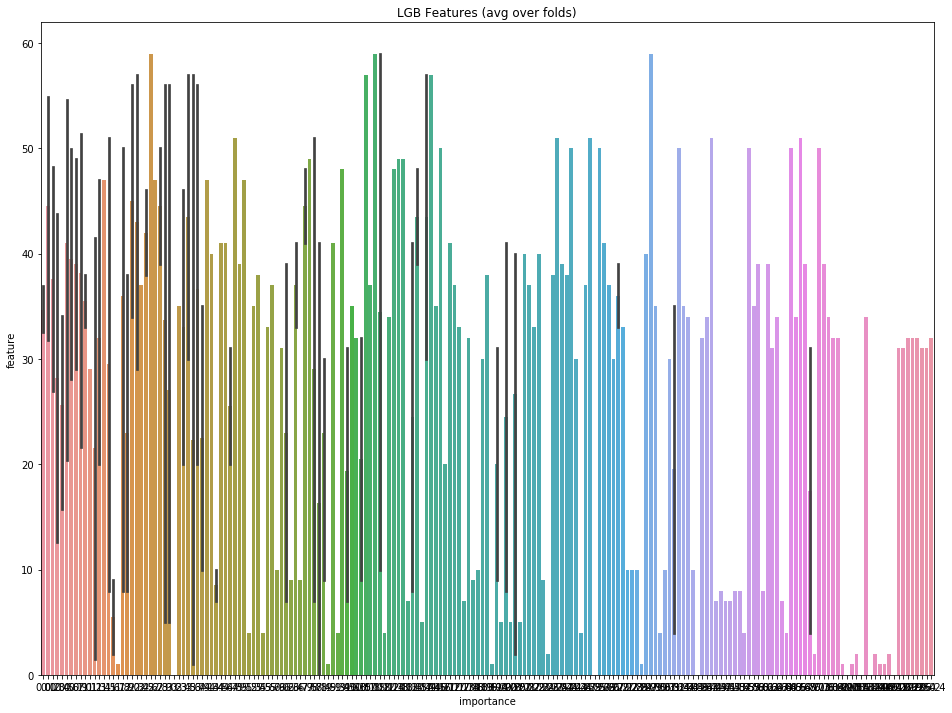

In [408]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 15:08:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.101139	valid_1's rmse: 0.1195
Early stopping, best iteration is:
[1052]	training's rmse: 0.100487	valid_1's rmse: 0.118956
Fold 1 started at Sun Dec 15 15:08:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[469]	training's rmse: 0.108848	valid_1's rmse: 0.112711
Fold 2 started at Sun Dec 15 15:08:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.122624	valid_1's rmse: 0.0942903
Fold 3 started at Sun Dec 15 15:08:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0991282	valid_1's rmse: 0.155847
[2000]	training's rmse: 0.0924373	valid_1's rmse: 0.148627
[3000]	training's rmse: 0.0888221	valid_1's rmse: 0.144906
[4000]	training's rmse: 0.0863004	valid_1's rmse: 0.142412
Early 

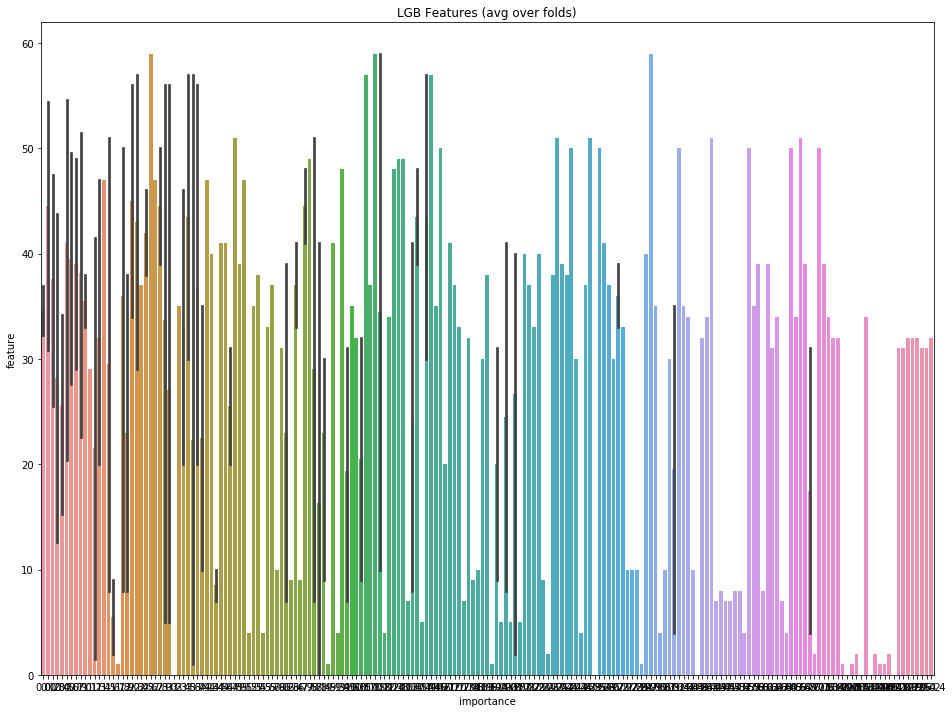

In [409]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sun Dec 15 15:08:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.101139	valid_1's rmse: 0.1195
Early stopping, best iteration is:
[1052]	training's rmse: 0.100487	valid_1's rmse: 0.118956
Fold 1 started at Sun Dec 15 15:08:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[469]	training's rmse: 0.108848	valid_1's rmse: 0.112711
Fold 2 started at Sun Dec 15 15:08:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[240]	training's rmse: 0.122624	valid_1's rmse: 0.0942903
Fold 3 started at Sun Dec 15 15:08:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0991282	valid_1's rmse: 0.155847
[2000]	training's rmse: 0.0924373	valid_1's rmse: 0.148627
[3000]	training's rmse: 0.0888221	valid_1's rmse: 0.144906
[4000]	training's rmse: 0.0863004	valid_1's rmse: 0.142412
Early 

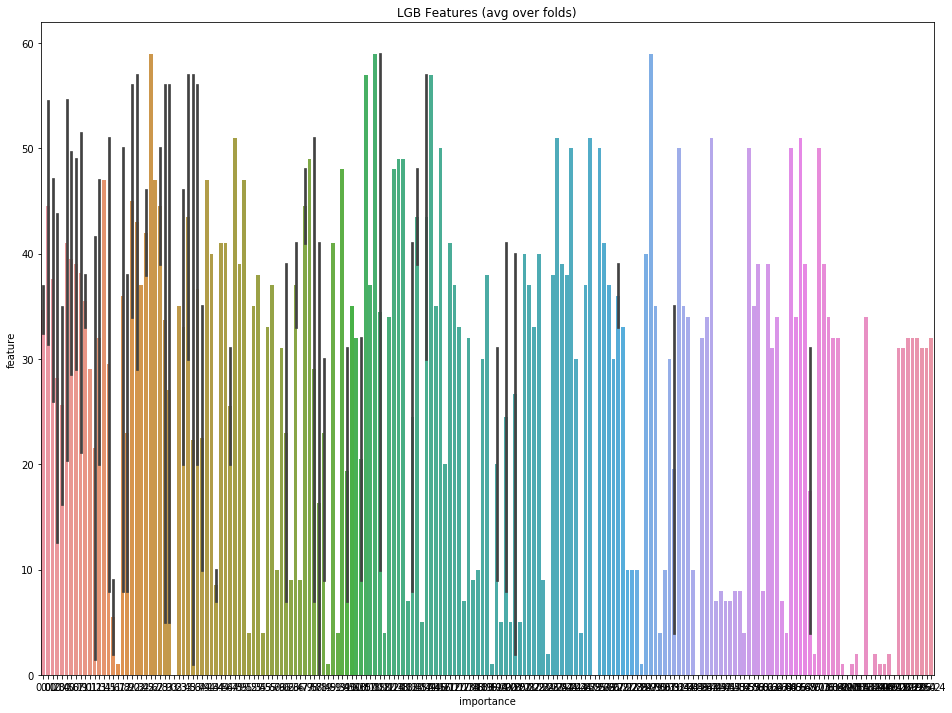

In [410]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

In [411]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)


Fold 0 started at Sun Dec 15 15:08:22 2019
Fold 1 started at Sun Dec 15 15:08:23 2019
Fold 2 started at Sun Dec 15 15:08:23 2019
Fold 3 started at Sun Dec 15 15:08:23 2019
Fold 4 started at Sun Dec 15 15:08:23 2019
Fold 5 started at Sun Dec 15 15:08:24 2019
Fold 6 started at Sun Dec 15 15:08:24 2019
Fold 7 started at Sun Dec 15 15:08:24 2019
Fold 8 started at Sun Dec 15 15:08:24 2019
Fold 9 started at Sun Dec 15 15:08:25 2019
CV mean score: 0.1278, std: 0.0269.


In [412]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:08:25 2019
[0]	train-rmse:0.215938	valid_data-rmse:0.227341
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.037281	valid_data-rmse:0.144072
Stopping. Best iteration:
[334]	train-rmse:0.047651	valid_data-rmse:0.141985

Fold 1 started at Sun Dec 15 15:08:25 2019
[0]	train-rmse:0.219296	valid_data-rmse:0.195642
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[212]	train-rmse:0.066218	valid_data-rmse:0.115402

Fold 2 started at Sun Dec 15 15:08:26 2019
[0]	train-rmse:0.220716	valid_data-rmse:0.181957
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[175]	train-rmse:0.0770

In [413]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')


Fold 0 started at Sun Dec 15 15:08:31 2019
Fold 1 started at Sun Dec 15 15:08:33 2019
Fold 2 started at Sun Dec 15 15:08:36 2019
Fold 3 started at Sun Dec 15 15:08:39 2019
Fold 4 started at Sun Dec 15 15:08:54 2019
Fold 5 started at Sun Dec 15 15:09:00 2019
Fold 6 started at Sun Dec 15 15:09:09 2019
Fold 7 started at Sun Dec 15 15:09:18 2019
Fold 8 started at Sun Dec 15 15:09:25 2019
Fold 9 started at Sun Dec 15 15:09:26 2019
CV mean score: 0.1147, std: 0.0202.


## stacking

Fold 0 started at Sun Dec 15 15:09:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[203]	training's rmse: 0.111573	valid_1's rmse: 0.138325
Fold 1 started at Sun Dec 15 15:09:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 0.108567	valid_1's rmse: 0.114176
Fold 2 started at Sun Dec 15 15:09:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[135]	training's rmse: 0.11951	valid_1's rmse: 0.0912664
Fold 3 started at Sun Dec 15 15:09:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[287]	training's rmse: 0.0991128	valid_1's rmse: 0.184471
Fold 4 started at Sun Dec 15 15:09:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's rmse: 0.117589	valid_1's rmse: 0.0994362
Fold 5 s

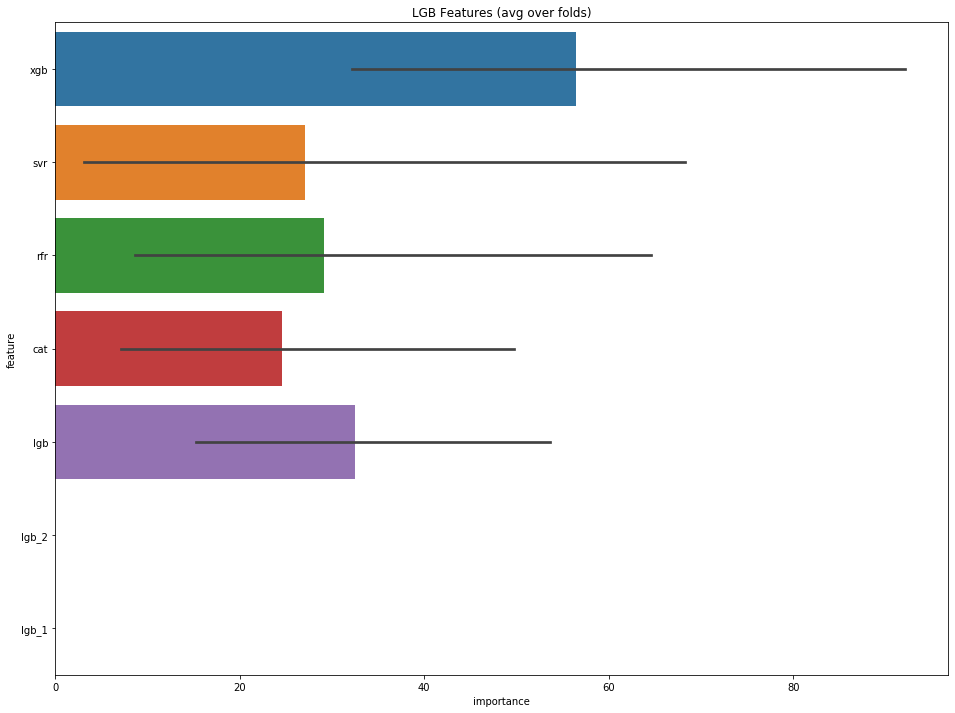

In [414]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:09:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[567]	training's rmse: 0.0998886	valid_1's rmse: 0.133311
Fold 1 started at Sun Dec 15 15:09:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 0.10822	valid_1's rmse: 0.11326
Fold 2 started at Sun Dec 15 15:09:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[181]	training's rmse: 0.115993	valid_1's rmse: 0.0895768
Fold 3 started at Sun Dec 15 15:09:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.100601	valid_1's rmse: 0.185344
Fold 4 started at Sun Dec 15 15:09:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[195]	training's rmse: 0.11437	valid_1's rmse: 0.0988902
Fold 5 sta

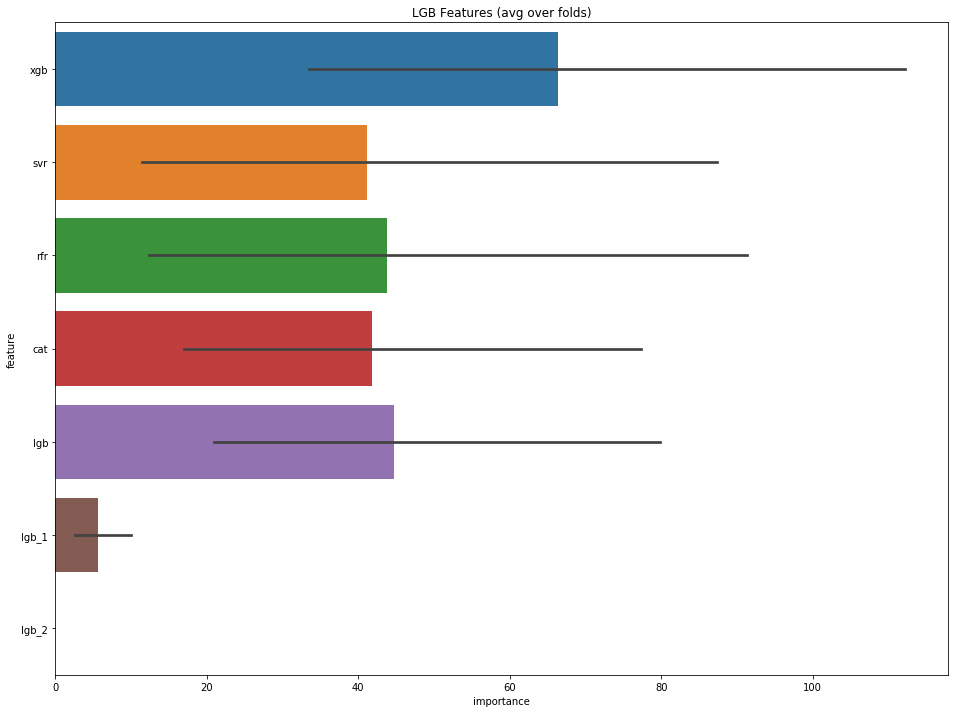

In [415]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [416]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:09:46 2019
Fold 1 started at Sun Dec 15 15:09:47 2019
Fold 2 started at Sun Dec 15 15:09:49 2019
Fold 3 started at Sun Dec 15 15:09:50 2019
Fold 4 started at Sun Dec 15 15:09:52 2019
Fold 5 started at Sun Dec 15 15:09:53 2019
Fold 6 started at Sun Dec 15 15:09:54 2019
Fold 7 started at Sun Dec 15 15:10:00 2019
Fold 8 started at Sun Dec 15 15:10:05 2019
Fold 9 started at Sun Dec 15 15:10:06 2019
CV mean score: 0.1076, std: 0.0226.


random forest做第二层融合模型

In [417]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:10:08 2019
Fold 1 started at Sun Dec 15 15:10:08 2019
Fold 2 started at Sun Dec 15 15:10:08 2019
Fold 3 started at Sun Dec 15 15:10:09 2019
Fold 4 started at Sun Dec 15 15:10:09 2019
Fold 5 started at Sun Dec 15 15:10:09 2019
Fold 6 started at Sun Dec 15 15:10:09 2019
Fold 7 started at Sun Dec 15 15:10:10 2019
Fold 8 started at Sun Dec 15 15:10:10 2019
Fold 9 started at Sun Dec 15 15:10:10 2019
CV mean score: 0.1165, std: 0.0224.


xgboost做第二层融合模型

In [418]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:10:10 2019
[0]	train-rmse:0.215709	valid_data-rmse:0.22712
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[192]	train-rmse:0.060861	valid_data-rmse:0.140271

Fold 1 started at Sun Dec 15 15:10:10 2019
[0]	train-rmse:0.219208	valid_data-rmse:0.195679
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[232]	train-rmse:0.050816	valid_data-rmse:0.122604

Fold 2 started at Sun Dec 15 15:10:11 2019
[0]	train-rmse:0.220465	valid_data-rmse:0.182227
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.022778	valid_data-rmse:0.098347
Stopping. Best iteration:
[449]	train-rmse:0.02615

#### SVR作为meta

In [419]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:10:13 2019
Fold 1 started at Sun Dec 15 15:10:13 2019
Fold 2 started at Sun Dec 15 15:10:13 2019
Fold 3 started at Sun Dec 15 15:10:13 2019
Fold 4 started at Sun Dec 15 15:10:13 2019
Fold 5 started at Sun Dec 15 15:10:13 2019
Fold 6 started at Sun Dec 15 15:10:13 2019
Fold 7 started at Sun Dec 15 15:10:13 2019
Fold 8 started at Sun Dec 15 15:10:13 2019
Fold 9 started at Sun Dec 15 15:10:13 2019
CV mean score: 0.1103, std: 0.0175.


用岭回归做第二层融合模型

### 去掉svr的结果做stacking

Fold 0 started at Sun Dec 15 15:10:13 2019
Fold 1 started at Sun Dec 15 15:10:13 2019
Fold 2 started at Sun Dec 15 15:10:13 2019
Fold 3 started at Sun Dec 15 15:10:13 2019
Fold 4 started at Sun Dec 15 15:10:13 2019
Fold 5 started at Sun Dec 15 15:10:13 2019
Fold 6 started at Sun Dec 15 15:10:13 2019
Fold 7 started at Sun Dec 15 15:10:13 2019
Fold 8 started at Sun Dec 15 15:10:13 2019
Fold 9 started at Sun Dec 15 15:10:13 2019
CV mean score: 0.1101, std: 0.0174.
Fold 0 started at Sun Dec 15 15:10:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[185]	training's rmse: 0.112733	valid_1's rmse: 0.13863
Fold 1 started at Sun Dec 15 15:10:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's rmse: 0.108663	valid_1's rmse: 0.114482
Fold 2 started at Sun Dec 15 15:10:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is

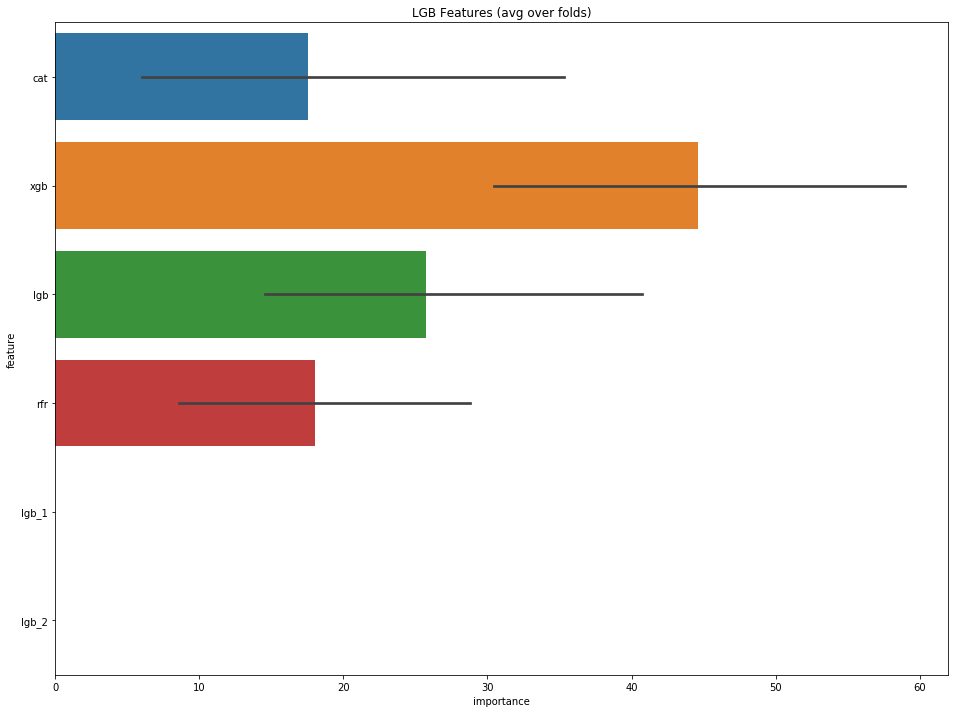

In [420]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:10:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.107301	valid_1's rmse: 0.136181
Fold 1 started at Sun Dec 15 15:10:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 0.109103	valid_1's rmse: 0.113366
Fold 2 started at Sun Dec 15 15:10:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[145]	training's rmse: 0.118803	valid_1's rmse: 0.0897973
Fold 3 started at Sun Dec 15 15:10:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[261]	training's rmse: 0.100999	valid_1's rmse: 0.184244
Fold 4 started at Sun Dec 15 15:10:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's rmse: 0.114404	valid_1's rmse: 0.0982515
Fold 5 s

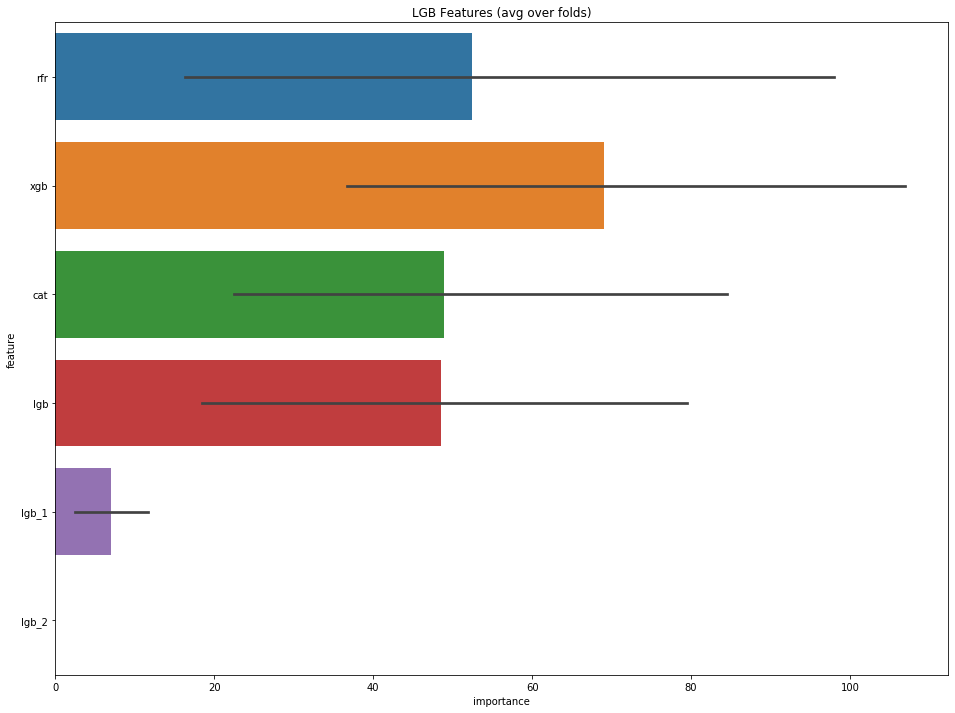

In [421]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [422]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:10:18 2019
Fold 1 started at Sun Dec 15 15:10:19 2019
Fold 2 started at Sun Dec 15 15:10:20 2019
Fold 3 started at Sun Dec 15 15:10:21 2019
Fold 4 started at Sun Dec 15 15:10:23 2019
Fold 5 started at Sun Dec 15 15:10:24 2019
Fold 6 started at Sun Dec 15 15:10:25 2019
Fold 7 started at Sun Dec 15 15:10:29 2019
Fold 8 started at Sun Dec 15 15:10:34 2019
Fold 9 started at Sun Dec 15 15:10:34 2019
CV mean score: 0.1071, std: 0.0224.


random forest做第二层融合模型

In [423]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:10:37 2019
Fold 1 started at Sun Dec 15 15:10:37 2019
Fold 2 started at Sun Dec 15 15:10:37 2019
Fold 3 started at Sun Dec 15 15:10:37 2019
Fold 4 started at Sun Dec 15 15:10:38 2019
Fold 5 started at Sun Dec 15 15:10:38 2019
Fold 6 started at Sun Dec 15 15:10:38 2019
Fold 7 started at Sun Dec 15 15:10:38 2019
Fold 8 started at Sun Dec 15 15:10:39 2019
Fold 9 started at Sun Dec 15 15:10:39 2019
CV mean score: 0.1171, std: 0.0222.


xgboost做第二层融合模型

In [424]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:10:39 2019
[0]	train-rmse:0.215672	valid_data-rmse:0.227038
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[244]	train-rmse:0.050439	valid_data-rmse:0.139749

Fold 1 started at Sun Dec 15 15:10:39 2019
[0]	train-rmse:0.21917	valid_data-rmse:0.19563
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[223]	train-rmse:0.055693	valid_data-rmse:0.127721

Fold 2 started at Sun Dec 15 15:10:39 2019
[0]	train-rmse:0.220472	valid_data-rmse:0.182369
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.024899	valid_data-rmse:0.101838
Stopping. Best iteration:
[347]	train-rmse:0.037297

#### SVR作为meta

In [425]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:10:41 2019
Fold 1 started at Sun Dec 15 15:10:41 2019
Fold 2 started at Sun Dec 15 15:10:41 2019
Fold 3 started at Sun Dec 15 15:10:41 2019
Fold 4 started at Sun Dec 15 15:10:41 2019
Fold 5 started at Sun Dec 15 15:10:41 2019
Fold 6 started at Sun Dec 15 15:10:41 2019
Fold 7 started at Sun Dec 15 15:10:41 2019
Fold 8 started at Sun Dec 15 15:10:41 2019
Fold 9 started at Sun Dec 15 15:10:41 2019
CV mean score: 0.1100, std: 0.0176.


用岭回归做第二层融合模型

In [426]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:10:41 2019
Fold 1 started at Sun Dec 15 15:10:41 2019
Fold 2 started at Sun Dec 15 15:10:41 2019
Fold 3 started at Sun Dec 15 15:10:41 2019
Fold 4 started at Sun Dec 15 15:10:41 2019
Fold 5 started at Sun Dec 15 15:10:41 2019
Fold 6 started at Sun Dec 15 15:10:41 2019
Fold 7 started at Sun Dec 15 15:10:41 2019
Fold 8 started at Sun Dec 15 15:10:41 2019
Fold 9 started at Sun Dec 15 15:10:41 2019
CV mean score: 0.1095, std: 0.0180.


### 去掉rfr做stacking

Fold 0 started at Sun Dec 15 15:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[764]	training's rmse: 0.0990879	valid_1's rmse: 0.126639
Fold 1 started at Sun Dec 15 15:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 0.108439	valid_1's rmse: 0.113995
Fold 2 started at Sun Dec 15 15:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[129]	training's rmse: 0.120246	valid_1's rmse: 0.0923292
Fold 3 started at Sun Dec 15 15:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[290]	training's rmse: 0.100542	valid_1's rmse: 0.180568
Fold 4 started at Sun Dec 15 15:10:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[148]	training's rmse: 0.118139	valid_1's rmse: 0.0996517
Fold 5 

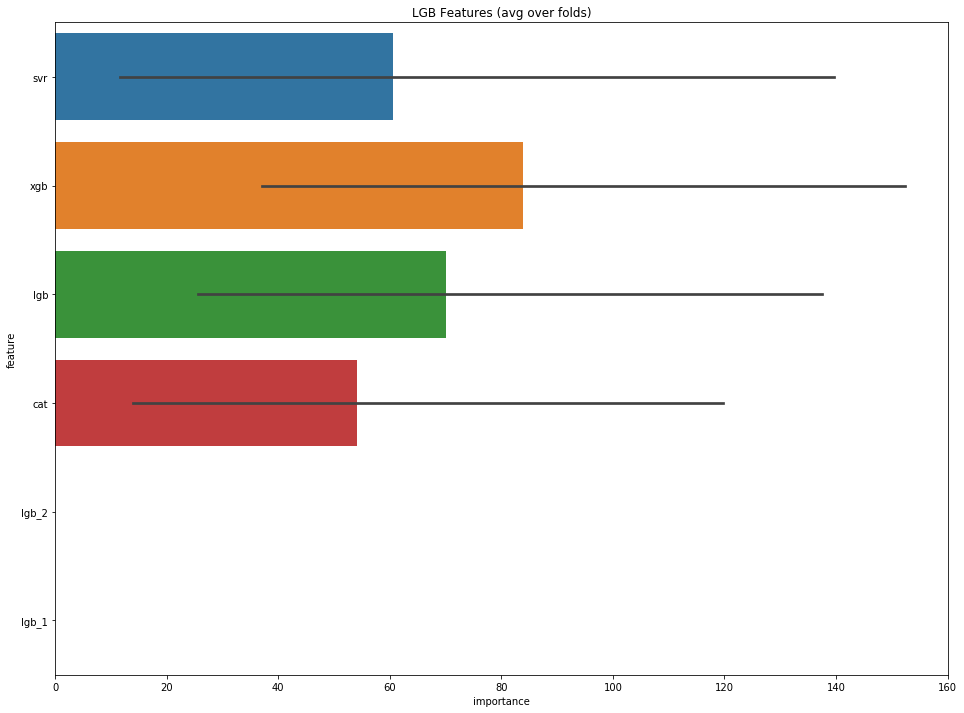

In [427]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:10:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0943357	valid_1's rmse: 0.121742
[2000]	training's rmse: 0.0841686	valid_1's rmse: 0.119722
Early stopping, best iteration is:
[2176]	training's rmse: 0.0828212	valid_1's rmse: 0.119385
Fold 1 started at Sun Dec 15 15:10:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 0.108856	valid_1's rmse: 0.112416
Fold 2 started at Sun Dec 15 15:10:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[181]	training's rmse: 0.11644	valid_1's rmse: 0.089736
Fold 3 started at Sun Dec 15 15:10:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 0.101048	valid_1's rmse: 0.181898
Fold 4 started at Sun Dec 15 15:10:45 2019
Training until validation scores don't improve

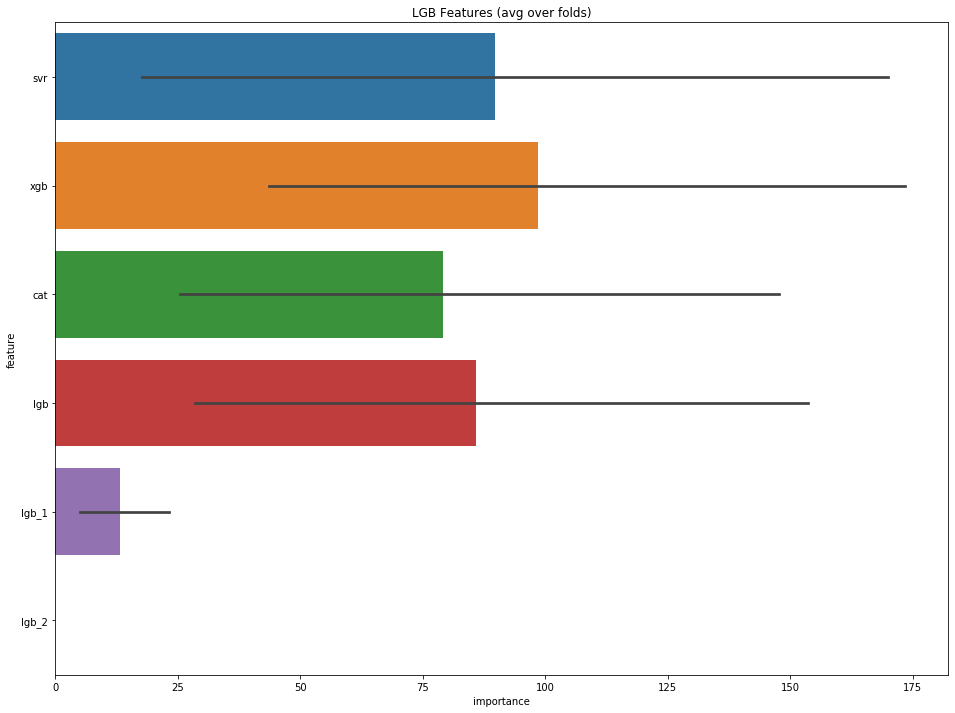

In [428]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [429]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:10:47 2019
Fold 1 started at Sun Dec 15 15:10:48 2019
Fold 2 started at Sun Dec 15 15:10:51 2019
Fold 3 started at Sun Dec 15 15:10:51 2019
Fold 4 started at Sun Dec 15 15:10:54 2019
Fold 5 started at Sun Dec 15 15:10:55 2019
Fold 6 started at Sun Dec 15 15:10:56 2019
Fold 7 started at Sun Dec 15 15:11:01 2019
Fold 8 started at Sun Dec 15 15:11:07 2019
Fold 9 started at Sun Dec 15 15:11:07 2019
CV mean score: 0.1066, std: 0.0233.


random forest做第二层融合模型

In [430]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:11:10 2019
Fold 1 started at Sun Dec 15 15:11:10 2019
Fold 2 started at Sun Dec 15 15:11:10 2019
Fold 3 started at Sun Dec 15 15:11:10 2019
Fold 4 started at Sun Dec 15 15:11:10 2019
Fold 5 started at Sun Dec 15 15:11:11 2019
Fold 6 started at Sun Dec 15 15:11:11 2019
Fold 7 started at Sun Dec 15 15:11:11 2019
Fold 8 started at Sun Dec 15 15:11:11 2019
Fold 9 started at Sun Dec 15 15:11:12 2019
CV mean score: 0.1139, std: 0.0236.


xgboost做第二层融合模型

In [431]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:11:12 2019
[0]	train-rmse:0.215709	valid_data-rmse:0.22712
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[209]	train-rmse:0.058369	valid_data-rmse:0.138332

Fold 1 started at Sun Dec 15 15:11:12 2019
[0]	train-rmse:0.219219	valid_data-rmse:0.195684
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[251]	train-rmse:0.048853	valid_data-rmse:0.126246

Fold 2 started at Sun Dec 15 15:11:12 2019
[0]	train-rmse:0.220477	valid_data-rmse:0.182329
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.024717	valid_data-rmse:0.10124
Stopping. Best iteration:
[344]	train-rmse:0.037485

#### SVR作为meta

In [432]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:11:14 2019
Fold 1 started at Sun Dec 15 15:11:14 2019
Fold 2 started at Sun Dec 15 15:11:14 2019
Fold 3 started at Sun Dec 15 15:11:14 2019
Fold 4 started at Sun Dec 15 15:11:14 2019
Fold 5 started at Sun Dec 15 15:11:14 2019
Fold 6 started at Sun Dec 15 15:11:14 2019
Fold 7 started at Sun Dec 15 15:11:14 2019
Fold 8 started at Sun Dec 15 15:11:14 2019
Fold 9 started at Sun Dec 15 15:11:14 2019
CV mean score: 0.1095, std: 0.0177.


用岭回归做第二层融合模型

In [433]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:11:14 2019
Fold 1 started at Sun Dec 15 15:11:14 2019
Fold 2 started at Sun Dec 15 15:11:14 2019
Fold 3 started at Sun Dec 15 15:11:14 2019
Fold 4 started at Sun Dec 15 15:11:14 2019
Fold 5 started at Sun Dec 15 15:11:14 2019
Fold 6 started at Sun Dec 15 15:11:14 2019
Fold 7 started at Sun Dec 15 15:11:14 2019
Fold 8 started at Sun Dec 15 15:11:14 2019
Fold 9 started at Sun Dec 15 15:11:15 2019
CV mean score: 0.1094, std: 0.0175.


### 去掉catboost做stacking

Fold 0 started at Sun Dec 15 15:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 0.106954	valid_1's rmse: 0.137927
Fold 1 started at Sun Dec 15 15:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[200]	training's rmse: 0.109887	valid_1's rmse: 0.113292
Fold 2 started at Sun Dec 15 15:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[130]	training's rmse: 0.119946	valid_1's rmse: 0.0916149
Fold 3 started at Sun Dec 15 15:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[243]	training's rmse: 0.10266	valid_1's rmse: 0.185012
Fold 4 started at Sun Dec 15 15:11:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[175]	training's rmse: 0.116516	valid_1's rmse: 0.0993246
Fold 5 st

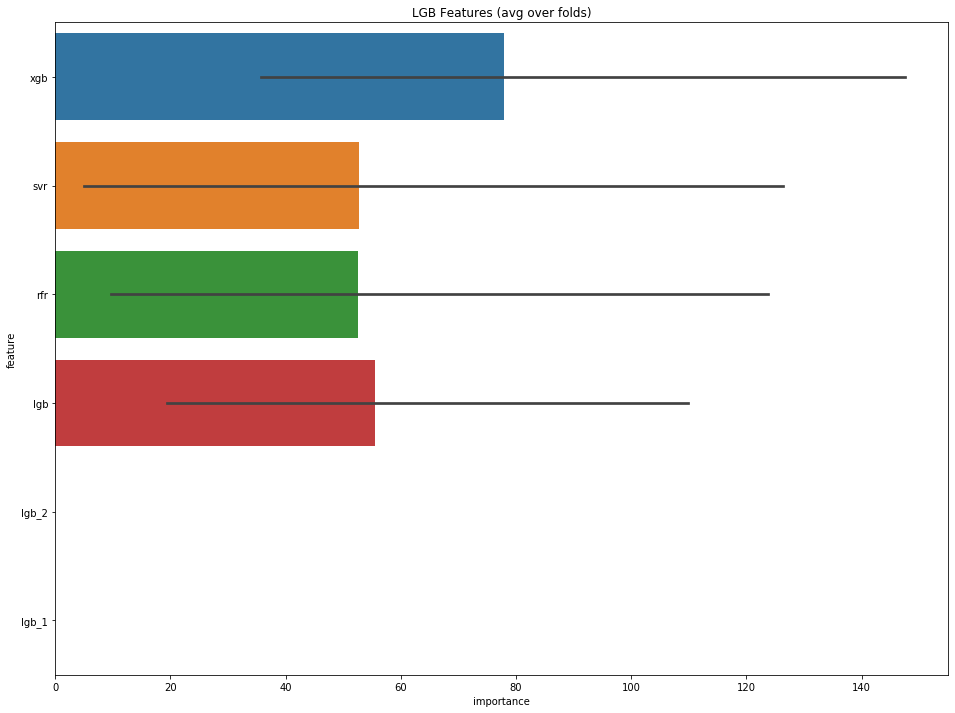

In [434]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 0.107063	valid_1's rmse: 0.135373
Fold 1 started at Sun Dec 15 15:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[233]	training's rmse: 0.10889	valid_1's rmse: 0.114863
Fold 2 started at Sun Dec 15 15:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[145]	training's rmse: 0.118803	valid_1's rmse: 0.0913947
Fold 3 started at Sun Dec 15 15:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 0.100961	valid_1's rmse: 0.185959
Fold 4 started at Sun Dec 15 15:11:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[150]	training's rmse: 0.117701	valid_1's rmse: 0.100268
Fold 5 sta

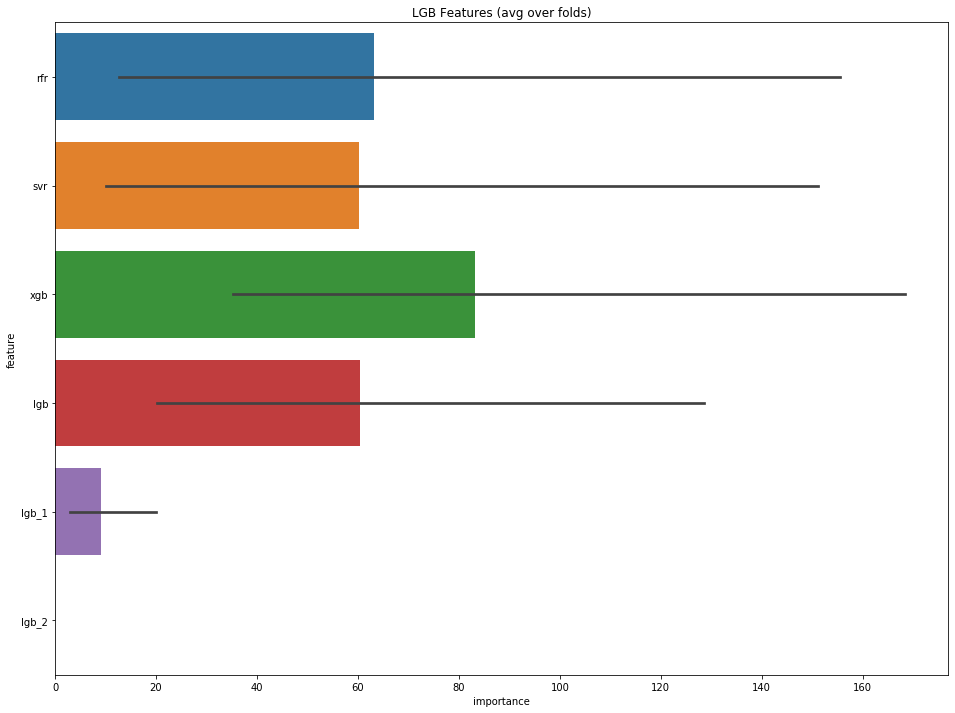

In [435]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [436]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:11:20 2019
Fold 1 started at Sun Dec 15 15:11:21 2019
Fold 2 started at Sun Dec 15 15:11:22 2019
Fold 3 started at Sun Dec 15 15:11:23 2019
Fold 4 started at Sun Dec 15 15:11:25 2019
Fold 5 started at Sun Dec 15 15:11:26 2019
Fold 6 started at Sun Dec 15 15:11:27 2019
Fold 7 started at Sun Dec 15 15:11:33 2019
Fold 8 started at Sun Dec 15 15:11:39 2019
Fold 9 started at Sun Dec 15 15:11:39 2019
CV mean score: 0.1077, std: 0.0221.


random forest做第二层融合模型

In [437]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:11:43 2019
Fold 1 started at Sun Dec 15 15:11:43 2019
Fold 2 started at Sun Dec 15 15:11:43 2019
Fold 3 started at Sun Dec 15 15:11:43 2019
Fold 4 started at Sun Dec 15 15:11:43 2019
Fold 5 started at Sun Dec 15 15:11:44 2019
Fold 6 started at Sun Dec 15 15:11:44 2019
Fold 7 started at Sun Dec 15 15:11:44 2019
Fold 8 started at Sun Dec 15 15:11:44 2019
Fold 9 started at Sun Dec 15 15:11:45 2019
CV mean score: 0.1152, std: 0.0220.


xgboost做第二层融合模型

In [438]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:11:45 2019
[0]	train-rmse:0.215699	valid_data-rmse:0.227083
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[178]	train-rmse:0.067307	valid_data-rmse:0.141321

Fold 1 started at Sun Dec 15 15:11:45 2019
[0]	train-rmse:0.219219	valid_data-rmse:0.195702
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[244]	train-rmse:0.050379	valid_data-rmse:0.129403

Fold 2 started at Sun Dec 15 15:11:45 2019
[0]	train-rmse:0.220494	valid_data-rmse:0.182163
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.023934	valid_data-rmse:0.101868
Stopping. Best iteration:
[367]	train-rmse:0.0345

#### SVR作为meta

In [439]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:11:47 2019
Fold 1 started at Sun Dec 15 15:11:47 2019
Fold 2 started at Sun Dec 15 15:11:47 2019
Fold 3 started at Sun Dec 15 15:11:47 2019
Fold 4 started at Sun Dec 15 15:11:47 2019
Fold 5 started at Sun Dec 15 15:11:47 2019
Fold 6 started at Sun Dec 15 15:11:47 2019
Fold 7 started at Sun Dec 15 15:11:47 2019
Fold 8 started at Sun Dec 15 15:11:47 2019
Fold 9 started at Sun Dec 15 15:11:47 2019
CV mean score: 0.1105, std: 0.0176.


用岭回归做第二层融合模型

In [440]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)


Fold 0 started at Sun Dec 15 15:11:47 2019
Fold 1 started at Sun Dec 15 15:11:47 2019
Fold 2 started at Sun Dec 15 15:11:47 2019
Fold 3 started at Sun Dec 15 15:11:47 2019
Fold 4 started at Sun Dec 15 15:11:47 2019
Fold 5 started at Sun Dec 15 15:11:47 2019
Fold 6 started at Sun Dec 15 15:11:47 2019
Fold 7 started at Sun Dec 15 15:11:47 2019
Fold 8 started at Sun Dec 15 15:11:47 2019
Fold 9 started at Sun Dec 15 15:11:47 2019
CV mean score: 0.1096, std: 0.0182.


### 去掉xgboost

Fold 0 started at Sun Dec 15 15:11:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[342]	training's rmse: 0.111297	valid_1's rmse: 0.123536
Fold 1 started at Sun Dec 15 15:11:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[447]	training's rmse: 0.104259	valid_1's rmse: 0.109043
Fold 2 started at Sun Dec 15 15:11:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[126]	training's rmse: 0.12304	valid_1's rmse: 0.0892564
Fold 3 started at Sun Dec 15 15:11:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[137]	training's rmse: 0.109987	valid_1's rmse: 0.191156
Fold 4 started at Sun Dec 15 15:11:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[118]	training's rmse: 0.123219	valid_1's rmse: 0.104622
Fold 5 sta

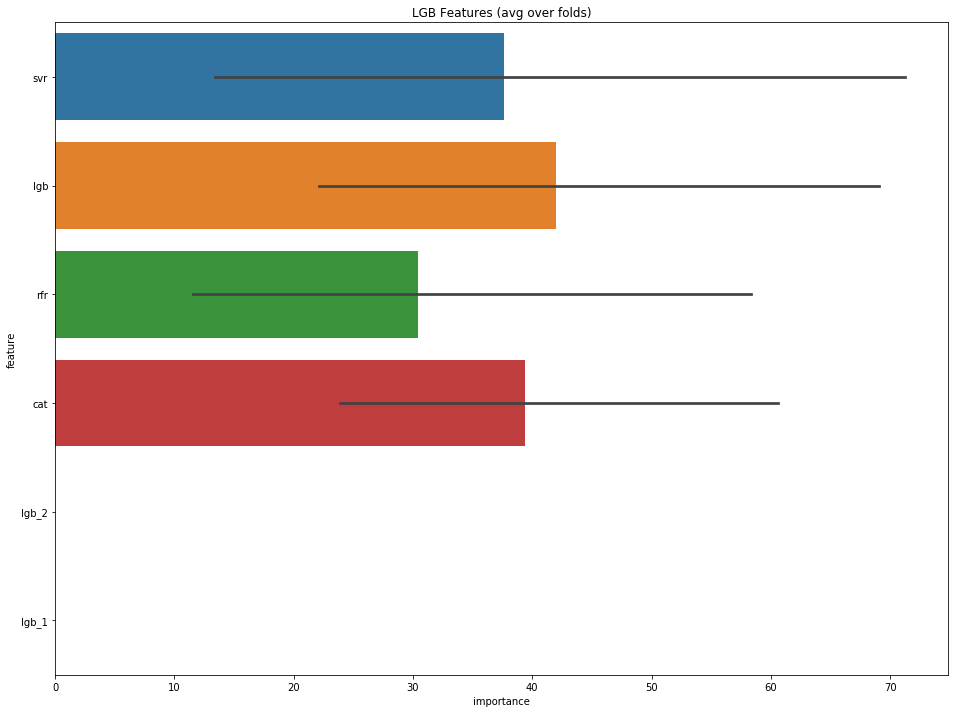

In [441]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:11:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[614]	training's rmse: 0.105266	valid_1's rmse: 0.120878
Fold 1 started at Sun Dec 15 15:11:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[328]	training's rmse: 0.109743	valid_1's rmse: 0.109968
Fold 2 started at Sun Dec 15 15:11:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[126]	training's rmse: 0.123589	valid_1's rmse: 0.0892431
Fold 3 started at Sun Dec 15 15:11:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[260]	training's rmse: 0.104291	valid_1's rmse: 0.190561
Fold 4 started at Sun Dec 15 15:11:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[156]	training's rmse: 0.119962	valid_1's rmse: 0.102796
Fold 5 st

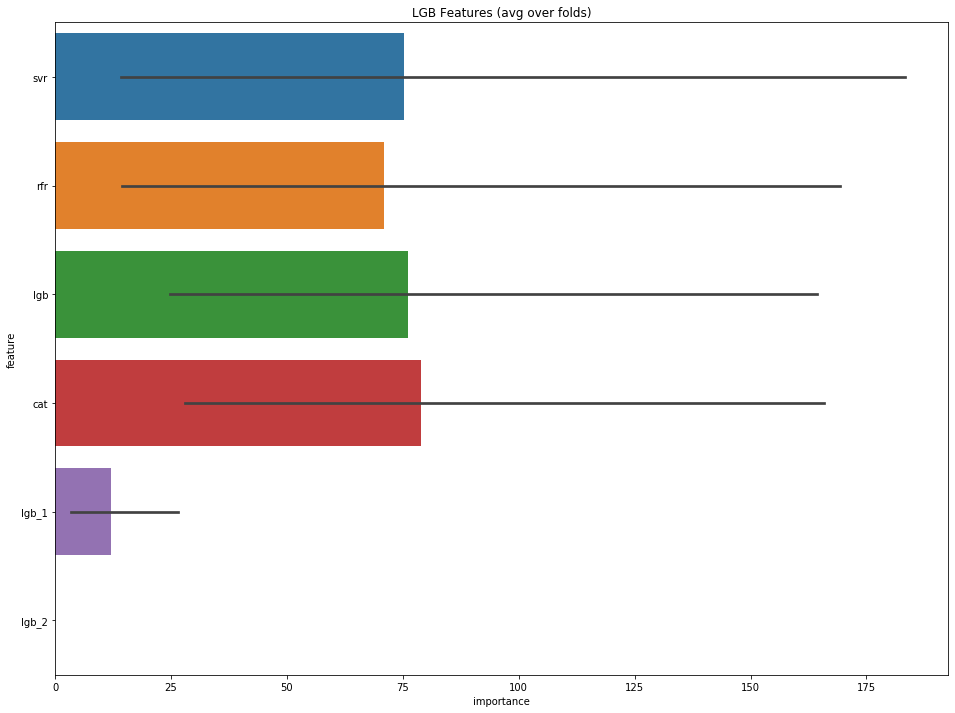

In [442]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [443]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:11:52 2019
Fold 1 started at Sun Dec 15 15:11:54 2019
Fold 2 started at Sun Dec 15 15:11:55 2019
Fold 3 started at Sun Dec 15 15:11:56 2019
Fold 4 started at Sun Dec 15 15:11:58 2019
Fold 5 started at Sun Dec 15 15:11:59 2019
Fold 6 started at Sun Dec 15 15:12:00 2019
Fold 7 started at Sun Dec 15 15:12:04 2019
Fold 8 started at Sun Dec 15 15:12:05 2019
Fold 9 started at Sun Dec 15 15:12:05 2019
CV mean score: 0.1115, std: 0.0173.


random forest做第二层融合模型

In [444]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:12:08 2019
Fold 1 started at Sun Dec 15 15:12:08 2019
Fold 2 started at Sun Dec 15 15:12:08 2019
Fold 3 started at Sun Dec 15 15:12:09 2019
Fold 4 started at Sun Dec 15 15:12:09 2019
Fold 5 started at Sun Dec 15 15:12:09 2019
Fold 6 started at Sun Dec 15 15:12:09 2019
Fold 7 started at Sun Dec 15 15:12:10 2019
Fold 8 started at Sun Dec 15 15:12:10 2019
Fold 9 started at Sun Dec 15 15:12:10 2019
CV mean score: 0.1161, std: 0.0200.


xgboost做第二层融合模型

In [445]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:12:10 2019
[0]	train-rmse:0.21571	valid_data-rmse:0.2272
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[182]	train-rmse:0.068001	valid_data-rmse:0.148665

Fold 1 started at Sun Dec 15 15:12:11 2019
[0]	train-rmse:0.219219	valid_data-rmse:0.195673
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[202]	train-rmse:0.061734	valid_data-rmse:0.125922

Fold 2 started at Sun Dec 15 15:12:11 2019
[0]	train-rmse:0.22054	valid_data-rmse:0.182212
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[251]	train-rmse:0.053275	valid_data-rmse:0.095566

Fold 3 started at Sun Dec 

#### SVR作为meta

In [446]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:12:12 2019
Fold 1 started at Sun Dec 15 15:12:12 2019
Fold 2 started at Sun Dec 15 15:12:12 2019
Fold 3 started at Sun Dec 15 15:12:12 2019
Fold 4 started at Sun Dec 15 15:12:12 2019
Fold 5 started at Sun Dec 15 15:12:12 2019
Fold 6 started at Sun Dec 15 15:12:12 2019
Fold 7 started at Sun Dec 15 15:12:12 2019
Fold 8 started at Sun Dec 15 15:12:12 2019
Fold 9 started at Sun Dec 15 15:12:12 2019
CV mean score: 0.1132, std: 0.0160.


用岭回归做第二层融合模型

In [447]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:12:12 2019
Fold 1 started at Sun Dec 15 15:12:12 2019
Fold 2 started at Sun Dec 15 15:12:12 2019
Fold 3 started at Sun Dec 15 15:12:12 2019
Fold 4 started at Sun Dec 15 15:12:13 2019
Fold 5 started at Sun Dec 15 15:12:13 2019
Fold 6 started at Sun Dec 15 15:12:13 2019
Fold 7 started at Sun Dec 15 15:12:13 2019
Fold 8 started at Sun Dec 15 15:12:13 2019
Fold 9 started at Sun Dec 15 15:12:13 2019
CV mean score: 0.1124, std: 0.0141.


### 去掉三个lgb

Fold 0 started at Sun Dec 15 15:12:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[216]	training's rmse: 0.11084	valid_1's rmse: 0.140574
Fold 1 started at Sun Dec 15 15:12:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0992936	valid_1's rmse: 0.107058
Early stopping, best iteration is:
[1532]	training's rmse: 0.0952352	valid_1's rmse: 0.106234
Fold 2 started at Sun Dec 15 15:12:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[651]	training's rmse: 0.10546	valid_1's rmse: 0.083624
Fold 3 started at Sun Dec 15 15:12:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[303]	training's rmse: 0.10223	valid_1's rmse: 0.179005
Fold 4 started at Sun Dec 15 15:12:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[160]	tra

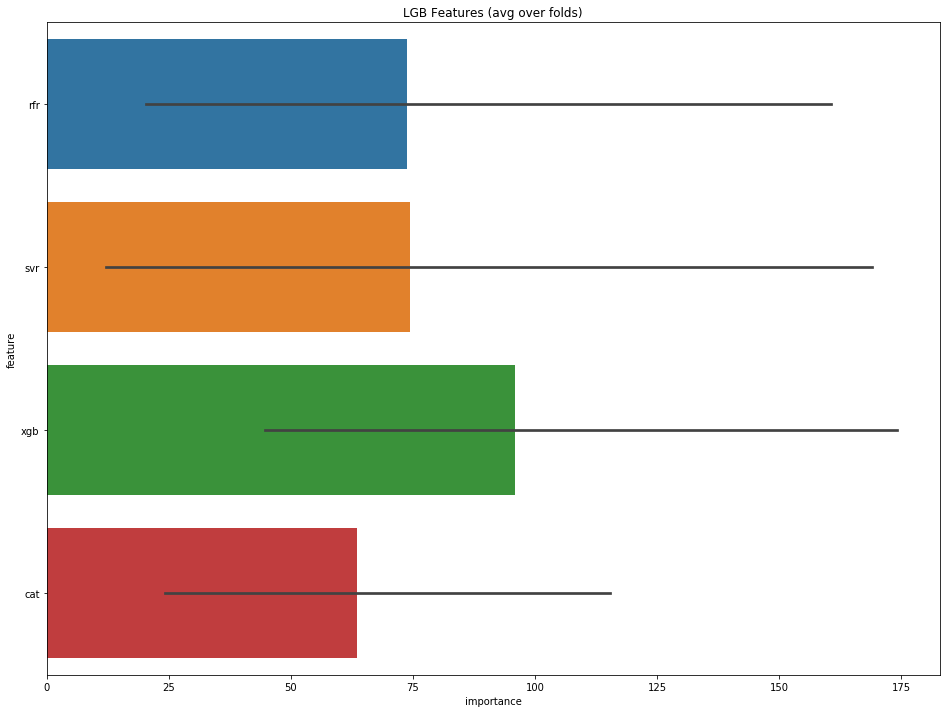

In [448]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat,oof_rfr,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack,columns=['xgb', 'cat','rfr','svr'])

#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)



Fold 0 started at Sun Dec 15 15:12:16 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0946806	valid_1's rmse: 0.138729
Early stopping, best iteration is:
[1294]	training's rmse: 0.0915086	valid_1's rmse: 0.137842
Fold 1 started at Sun Dec 15 15:12:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[430]	training's rmse: 0.106694	valid_1's rmse: 0.110126
Fold 2 started at Sun Dec 15 15:12:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[497]	training's rmse: 0.107204	valid_1's rmse: 0.0834223
Fold 3 started at Sun Dec 15 15:12:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[380]	training's rmse: 0.100096	valid_1's rmse: 0.179787
Fold 4 started at Sun Dec 15 15:12:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[152]

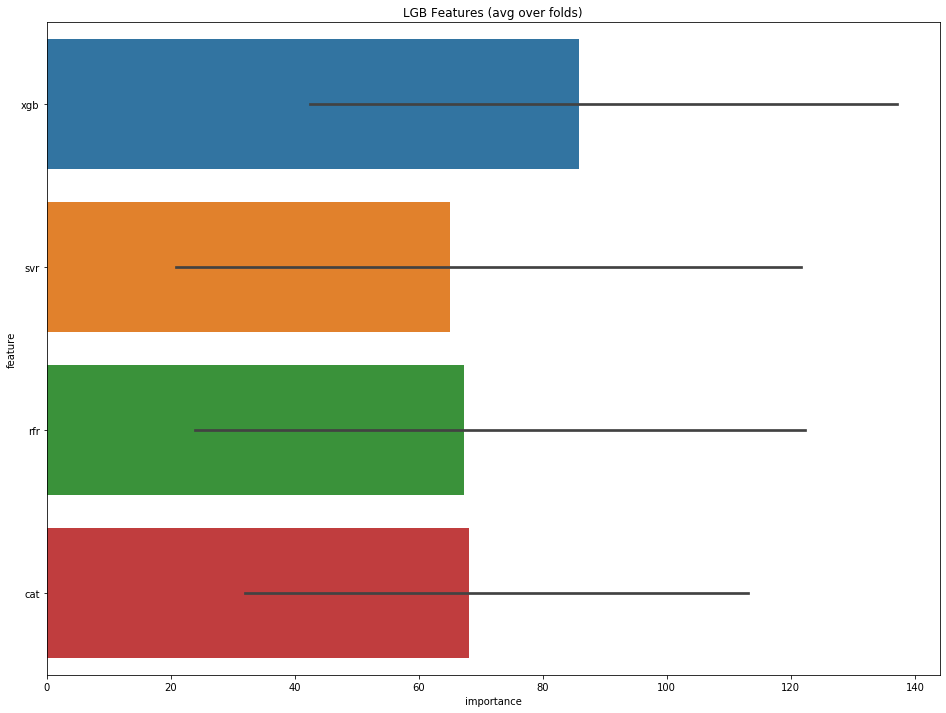

In [449]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

catboost做第二层融合模型

In [450]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Sun Dec 15 15:12:18 2019
Fold 1 started at Sun Dec 15 15:12:20 2019
Fold 2 started at Sun Dec 15 15:12:21 2019
Fold 3 started at Sun Dec 15 15:12:22 2019
Fold 4 started at Sun Dec 15 15:12:25 2019
Fold 5 started at Sun Dec 15 15:12:26 2019
Fold 6 started at Sun Dec 15 15:12:28 2019
Fold 7 started at Sun Dec 15 15:12:31 2019
Fold 8 started at Sun Dec 15 15:12:33 2019
Fold 9 started at Sun Dec 15 15:12:33 2019
CV mean score: 0.1147, std: 0.0244.


random forest做第二层融合模型

In [451]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Sun Dec 15 15:12:35 2019
Fold 1 started at Sun Dec 15 15:12:36 2019
Fold 2 started at Sun Dec 15 15:12:36 2019
Fold 3 started at Sun Dec 15 15:12:36 2019
Fold 4 started at Sun Dec 15 15:12:36 2019
Fold 5 started at Sun Dec 15 15:12:37 2019
Fold 6 started at Sun Dec 15 15:12:37 2019
Fold 7 started at Sun Dec 15 15:12:37 2019
Fold 8 started at Sun Dec 15 15:12:37 2019
Fold 9 started at Sun Dec 15 15:12:38 2019
CV mean score: 0.1206, std: 0.0250.


xgboost做第二层融合模型

In [452]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Sun Dec 15 15:12:38 2019
[0]	train-rmse:0.215783	valid_data-rmse:0.227123
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[164]	train-rmse:0.072414	valid_data-rmse:0.143848

Fold 1 started at Sun Dec 15 15:12:38 2019
[0]	train-rmse:0.219256	valid_data-rmse:0.195587
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[234]	train-rmse:0.054484	valid_data-rmse:0.114115

Fold 2 started at Sun Dec 15 15:12:38 2019
[0]	train-rmse:0.220652	valid_data-rmse:0.182022
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[249]	train-rmse:0.0531	valid_data-rmse:0.101696

Fold 3 started at Sun De

#### SVR作为meta

In [453]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Sun Dec 15 15:12:39 2019
Fold 1 started at Sun Dec 15 15:12:39 2019
Fold 2 started at Sun Dec 15 15:12:39 2019
Fold 3 started at Sun Dec 15 15:12:39 2019
Fold 4 started at Sun Dec 15 15:12:39 2019
Fold 5 started at Sun Dec 15 15:12:39 2019
Fold 6 started at Sun Dec 15 15:12:39 2019
Fold 7 started at Sun Dec 15 15:12:39 2019
Fold 8 started at Sun Dec 15 15:12:39 2019
Fold 9 started at Sun Dec 15 15:12:39 2019
CV mean score: 0.1131, std: 0.0217.


用岭回归做第二层融合模型

In [454]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Sun Dec 15 15:12:39 2019
Fold 1 started at Sun Dec 15 15:12:39 2019
Fold 2 started at Sun Dec 15 15:12:39 2019
Fold 3 started at Sun Dec 15 15:12:39 2019
Fold 4 started at Sun Dec 15 15:12:39 2019
Fold 5 started at Sun Dec 15 15:12:40 2019
Fold 6 started at Sun Dec 15 15:12:40 2019
Fold 7 started at Sun Dec 15 15:12:40 2019
Fold 8 started at Sun Dec 15 15:12:40 2019
Fold 9 started at Sun Dec 15 15:12:40 2019
CV mean score: 0.1128, std: 0.0218.
